In [1]:
import pandas as pd
import numpy as np
import librosa
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import seaborn as sns

import matplotlib.pyplot as plt
from IPython.display import Audio
import soundfile as sf

from scene_cls_model import Cnn_9layers_AvgPooling

2024-08-30 22:03:46.200550: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-30 22:03:49.919678: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from pytorch_grad_cam import GradCAM,GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image,preprocess_image

In [3]:
eval_df = pd.read_csv('predictions.csv')
eval_df.shape

(4185, 3)

In [4]:
eval_df.head()

Filename    Predicted Label  \
0  /work/aistwal/dataset_tau2019/extracted-files/...  street_pedestrian   
1  /work/aistwal/dataset_tau2019/extracted-files/...              metro   
2  /work/aistwal/dataset_tau2019/extracted-files/...     street_traffic   
3  /work/aistwal/dataset_tau2019/extracted-files/...  street_pedestrian   
4  /work/aistwal/dataset_tau2019/extracted-files/...     street_traffic   

        Actual Label  
0  street_pedestrian  
1              metro  
2               park  
3  street_pedestrian  
4     street_traffic

/tmp/ipykernel_2210444/288508668.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=90)


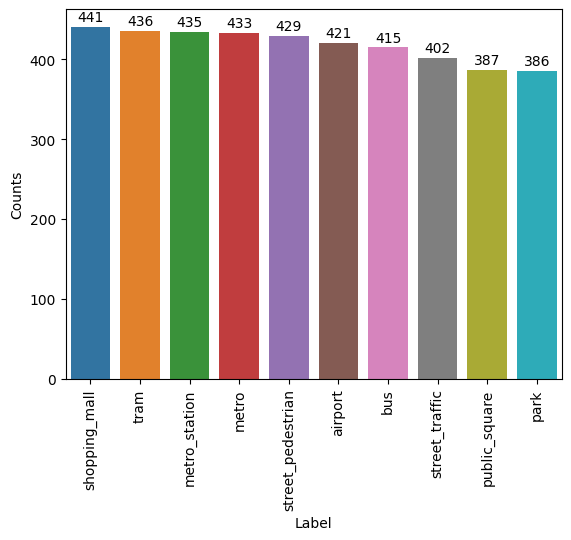

In [6]:
df_gb = eval_df['Actual Label'].value_counts().reset_index()
df_gb.columns = ['Label', 'Counts']

# Creating the bar plot
my_plot = sns.barplot(x='Label', y='Counts', data=df_gb, hue='Label', dodge=False)

# Setting the x-tick labels with rotation
my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=90)

# Adding the text labels on the bars
for p in my_plot.patches:
    my_plot.annotate(format(p.get_height(), '.0f'),  # Format the number as a float
                     (p.get_x() + p.get_width() / 2., p.get_height()),  # Position for the text
                     ha = 'center',  # Center alignment
                     va = 'center',  # Center alignment
                     xytext = (0, 7),  # Distance from text to points (x,y)
                     textcoords = 'offset points')  # Offset (in points) from the *xy* value

plt.savefig('evaldf_scene_distri.png')

# Show the plot
plt.show()

In [6]:
# Correct Predictions

In [7]:
correct_pred = eval_df[eval_df['Predicted Label'] == eval_df['Actual Label']]
correct_pred.shape

(2230, 3)

In [8]:
correct_pred.head()

Filename    Predicted Label  \
0  /work/aistwal/dataset_tau2019/extracted-files/...  street_pedestrian   
1  /work/aistwal/dataset_tau2019/extracted-files/...              metro   
3  /work/aistwal/dataset_tau2019/extracted-files/...  street_pedestrian   
4  /work/aistwal/dataset_tau2019/extracted-files/...     street_traffic   
7  /work/aistwal/dataset_tau2019/extracted-files/...            airport   

        Actual Label  
0  street_pedestrian  
1              metro  
3  street_pedestrian  
4     street_traffic  
7            airport

In [9]:
# Incorrect Predictions
incorrect_pred = eval_df[eval_df['Predicted Label'] != eval_df['Actual Label']]
incorrect_pred.shape

(1955, 3)

In [10]:
# Checking for accuracy to be 53.29%
correct_pred.shape[0]/(correct_pred.shape[0]+incorrect_pred.shape[0]) * 100

53.28554360812425

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
# Instantiate and load the model
model = Cnn_9layers_AvgPooling(classes_num=10, activation="logsoftmax")
model_path = '/work/aistwal/MMDS_MasterThesis/models/checkpoints/tau_2019_conv_10_16.pth'
# model_path = '/work/aistwal/MMDS_MasterThesis/models/checkpoints/tau_2019_conv_new_10_16.pth'
model_name = model_path.split('/')[-1]
print("model name: ", model_name)
model.load_state_dict(torch.load(model_path))
model = model.to(device)
model.eval()

model name:  tau_2019_conv_10_16.pth


Cnn_9layers_AvgPooling(
  (conv_block1): ConvBlock(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_block2): ConvBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_block3): ConvBlock(
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1

Selecting audios from specific scenes

In [13]:
# sp = correct_pred.groupby(["Actual Label"]).get_group("street_pedestrian")["Filename"].sample(n=10, random_state = 42).tolist()
# st = correct_pred.groupby(["Actual Label"]).get_group("street_traffic")["Filename"].sample(n=10, random_state = 42).tolist()
# tram = correct_pred.groupby(["Actual Label"]).get_group("tram")["Filename"].sample(n=10, random_state = 42).tolist()
# apt = correct_pred.groupby(["Actual Label"]).get_group("airport")["Filename"].sample(n=10, random_state = 42).tolist()

In [14]:
# correct_audio_list = sp+st+tram+apt
correct_audio_list = ['/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-45459-a.wav','/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-265-8053-a.wav','/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-paris-272-8289-a.wav','/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lyon-1220-44633-a.wav', '/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-milan-1222-45317-a.wav','/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-283-8561-a.wav','/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-vienna-209-6366-a.wav','/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-207-6305-a.wav']

In [15]:
correct_audio_list

['/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-45459-a.wav',
 '/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-265-8053-a.wav',
 '/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-paris-272-8289-a.wav',
 '/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lyon-1220-44633-a.wav',
 '/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-milan-1222-45317-a.wav',
 '/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-283-8561-a.wav',
 '/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-vienna-209-6366-a.wav',
 '/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acousti

Randomly get 10 audios

In [16]:
# correct_audio_list = correct_pred['Filename'].sample(n=10, random_state = 1).tolist()
# correct_audio_list

In [17]:
labels = [
    "airport", "shopping_mall", "metro_station", "street_pedestrian",
    "public_square", "street_traffic", "tram", "bus", "metro", "park"]
lb_to_idx = {lb: idx for idx, lb in enumerate(labels)}
idx_to_lb = {idx: lb for idx, lb in enumerate(labels)}

In [18]:
def get_grayscale_cam(model, target_layers, tensor_x, targets):
    
    print("Target_layer ", target_layers)
    cam = GradCAM(model=model,target_layers=target_layers)
    # cam = GradCAMPlusPlus(model=model,target_layers=target_layers)
    grayscale_cam = cam(input_tensor=tensor_x, 
                        targets=targets)
    # print("original grayscale_cam", grayscale_cam.shape)
    
    # Here grayscale_cam has only one image in the batch
    grayscale_cam = grayscale_cam[0, :]
    return grayscale_cam

In [19]:
# target_layers = [model.conv_block4.conv2]
target_layers = [model.conv_block4.bn2]

# If None, returns the map for the highest scoring category.
# Otherwise, targets the requested category.
targets = None


## The index of the class to visualize
# class_index = 3  # For example, class index 3 for class "STREET PEDESTRIAN"

## Using the ClassifierOutputTarget to focus on a specific class
# targets = [ClassifierOutputTarget(class_index)]

In [20]:
def predict(model, inputs):
    with torch.no_grad():
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

    return predicted

In [21]:
def display_log_mel_spectrogram(audioname, version, input_feature, model_name):
    print(audioname, "Log-Mel Feature Shape : ", input_feature.shape)
    plt.figure(figsize=(15, 6))
    plt.title(f'SPECTROGRAM FOR {audioname}')
    root_dir = '/work/aistwal/backup/MMDS_MasterThesis/models/asc'
    save_path = os.path.join(root_dir, 'files', model_name, version)
    
    # Create the directory if it does not exist
    os.makedirs(save_path, exist_ok=True)
    
    file_path = os.path.join(save_path, f'{audioname}-spectrogram.png')
    librosa.display.specshow(input_feature, x_axis='time', y_axis='linear', sr=32000)
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.savefig(file_path)
    plt.show()

In [22]:
# def blackout_unimportant_features(grayscale_cam, input_spectrogram, threshold=0.5):
#     normalized_cam = (grayscale_cam - np.min(grayscale_cam)) / (np.max(grayscale_cam) - np.min(grayscale_cam))
#     # Create a mask for important regions
#     important_mask = normalized_cam >= threshold
    
#     # Get the minimum value of the input spectrogram
#     min_value = np.min(input_spectrogram)
    
#     # Create a copy of the input spectrogram to modify
#     modified_spectrogram = np.copy(input_spectrogram)
    
#     # Blackout unimportant regions by setting them to the minimum value
#     modified_spectrogram[~important_mask] = min_value
    
#     return modified_spectrogram

In [23]:
def blackout_unimportant_features(grayscale_cam, input_spectrogram, percentile = 85):
    normalized_cam = (grayscale_cam - np.min(grayscale_cam)) / (np.max(grayscale_cam) - np.min(grayscale_cam))
    threshold = np.percentile(normalized_cam, percentile)
    # Create a mask for important regions
    important_mask = normalized_cam >= threshold
    
    # Get the minimum value of the input spectrogram
    min_value = np.min(input_spectrogram)
    
    # Create a copy of the input spectrogram to modify
    modified_spectrogram = np.copy(input_spectrogram)
    
    # Blackout unimportant regions by setting them to the minimum value
    modified_spectrogram[~important_mask] = min_value
    
    return modified_spectrogram

In [24]:
def spectrogram_indices_to_sample_range(col_index, hop_length = 500, n_fft = 1024):
    """     
    Convert the column index of a spectrogram to the sample range of the original waveform.     
    Parameters:     
    
    column_index (int): The column index of the spectrogram.     
    hop_length (int): The hop length used in the STFT.     
    n_fft (int): The window length (number of FFT points) used in the STFT.     
    
    Returns:     
        tuple: A tuple containing the start and end sample indices (inclusive) in the original waveform.     
    """
    start_sample = col_index * hop_length
    end_sample = start_sample + n_fft
    return start_sample, end_sample

In [25]:
# # Fetch timestamps where audio was not activated
# def fetch_audio_timestamps(generalized_cam_version, col_list):
#     timestamps = np.array(col_list) * 500 / 32000
#     return timestamps

In [26]:
# def blackout_only_x_dim(grayscale_cam, log_mel_spectrogram, threshold=0.35):

#     # Create copy of input_spectrogram
#     generalized_cam_version = np.copy(log_mel_spectrogram) #64*641
    
#     # Get the minimum value of the input spectrogram
#     min_value = np.min(log_mel_spectrogram)
    
#     normalized_cam = (grayscale_cam - np.min(grayscale_cam)) / (np.max(grayscale_cam) - np.min(grayscale_cam))
#     print("Columns: ", normalized_cam.shape[1])

#     deactivated_col_list = []
#     for col in range(0, normalized_cam.shape[1]):
#         flag = np.all(normalized_cam[:,col] < threshold)
#         if flag:
#             deactivated_col_list.append(col)
#             generalized_cam_version[:,col] = min_value
            
#     return generalized_cam_version, deactivated_col_list

In [27]:
def blackout_only_x_dim(grayscale_cam, log_mel_spectrogram, percentile = 85):

    # Create copy of input_spectrogram
    generalized_cam_version = np.copy(log_mel_spectrogram) #64*641
    
    # Get the minimum value of the input spectrogram
    min_value = np.min(log_mel_spectrogram)
    
    normalized_cam = (grayscale_cam - np.min(grayscale_cam)) / (np.max(grayscale_cam) - np.min(grayscale_cam))
    print("Columns: ", normalized_cam.shape[1])

    threshold = np.percentile(normalized_cam, percentile)
    threshold = float("{:.2f}".format(threshold))  #set threshold format
    print("Threshold: ", threshold)
    deactivated_col_list = []
    for col in range(0, normalized_cam.shape[1]):
        flag = np.all(normalized_cam[:,col] < threshold)
        if flag:
            deactivated_col_list.append(col)
            generalized_cam_version[:,col] = min_value
            
    return generalized_cam_version, deactivated_col_list

In [ ]:
audio_path = correct_audio_list[0]
# audio_path = '/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-milan-1172-44126-a.wav'
# audio_path = '/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-milan-1172-44205-a.wav'
# audio_path = '/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-barcelona-203-6126-a.wav'
# audio_path = '/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-milan-1172-45710-a.wav'
print(audio_path)
# Load the audio file
audio, sr = librosa.load(audio_path, sr = 32000)
print(audio.shape)
print("Sampling rate: ",sr)
Audio(data=audio, rate=sr)

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-45459-a.wav
(320000,)
Sampling rate:  32000


In [ ]:
audio

In [ ]:
correct_audio_list

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lyon-1220-44633-a.wav
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Shape of grayscale_cam  (64, 641)
Shape of log_mel_spectrogram  (64, 641)
Columns:  641
Threshold:  0.54
Minimum value of audio:  -0.13325776
Altered audio shape : (320000,)
Original audio shape : (320000,)
Shape of modified_spectrogram  (64, 641)
Prediction for  street_traffic-lyon-1220-44633-a.wav is  street_traffic
Prediction after cam mask for  street_traffic-lyon-1220-44633-a.wav is  street_traffic
street_traffic-lyon-1220-44633-a.wav Log-Mel Feature Shape :  (64, 641)


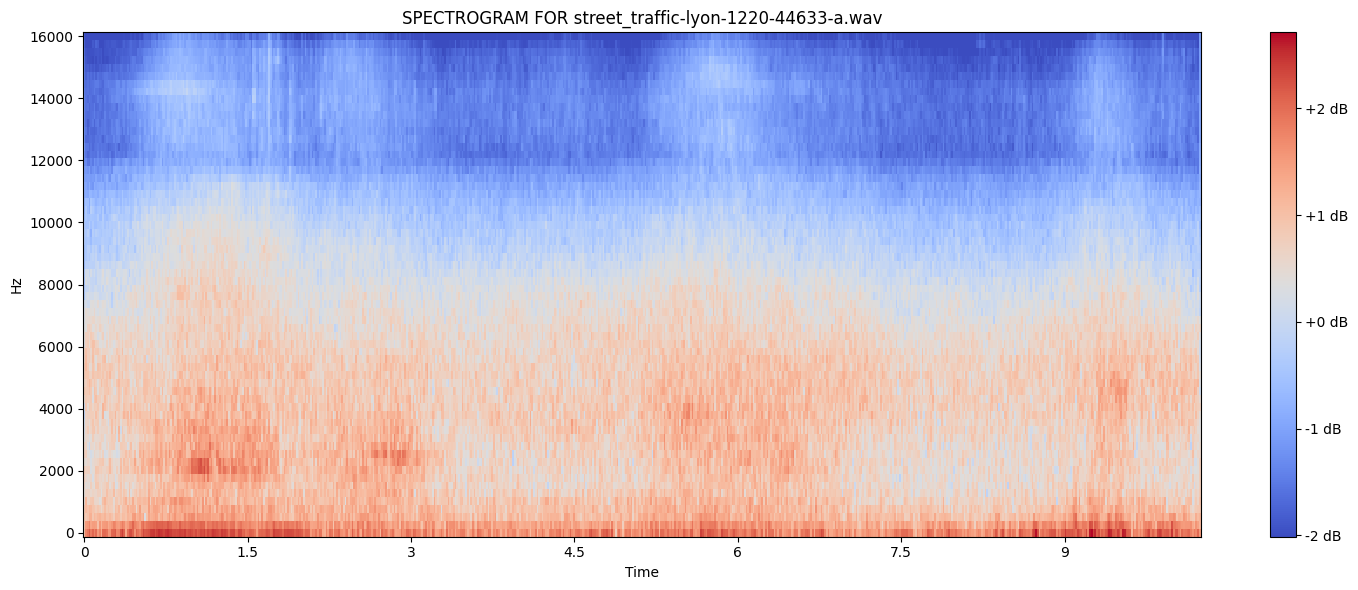

street_traffic-lyon-1220-44633-a.wav_overlay Log-Mel Feature Shape :  (64, 641)


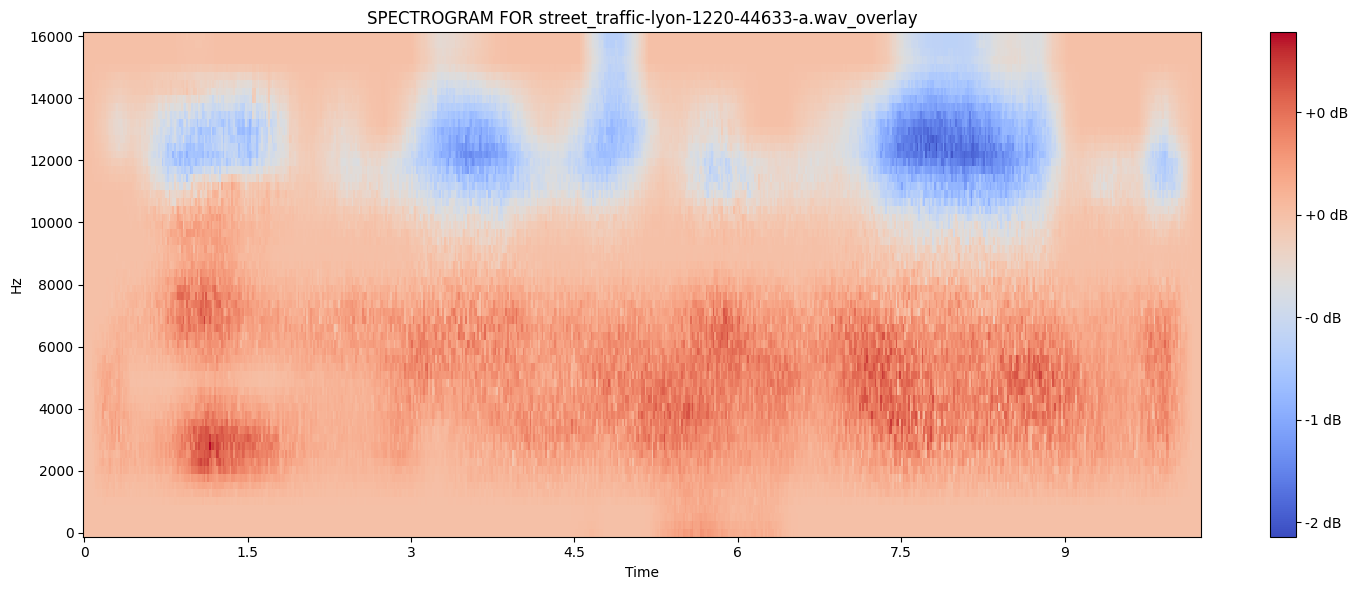

street_traffic-lyon-1220-44633-a.wav_modified Log-Mel Feature Shape :  (64, 641)


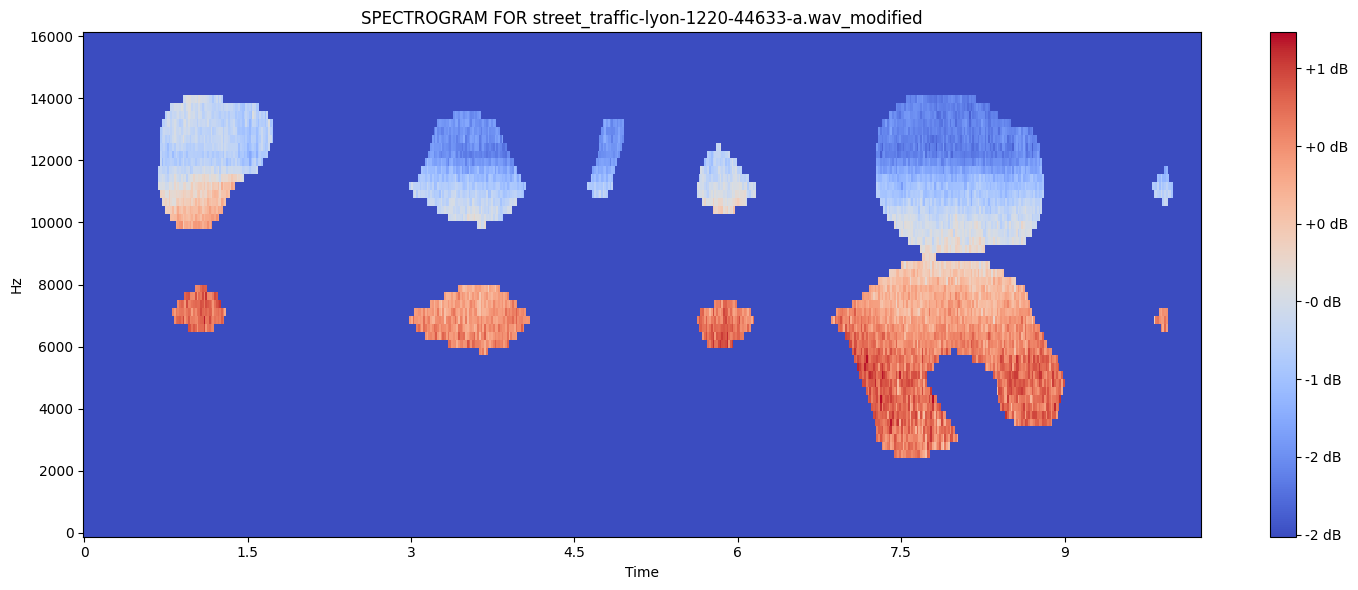

street_traffic-lyon-1220-44633-a.wav_generalized Log-Mel Feature Shape :  (64, 641)


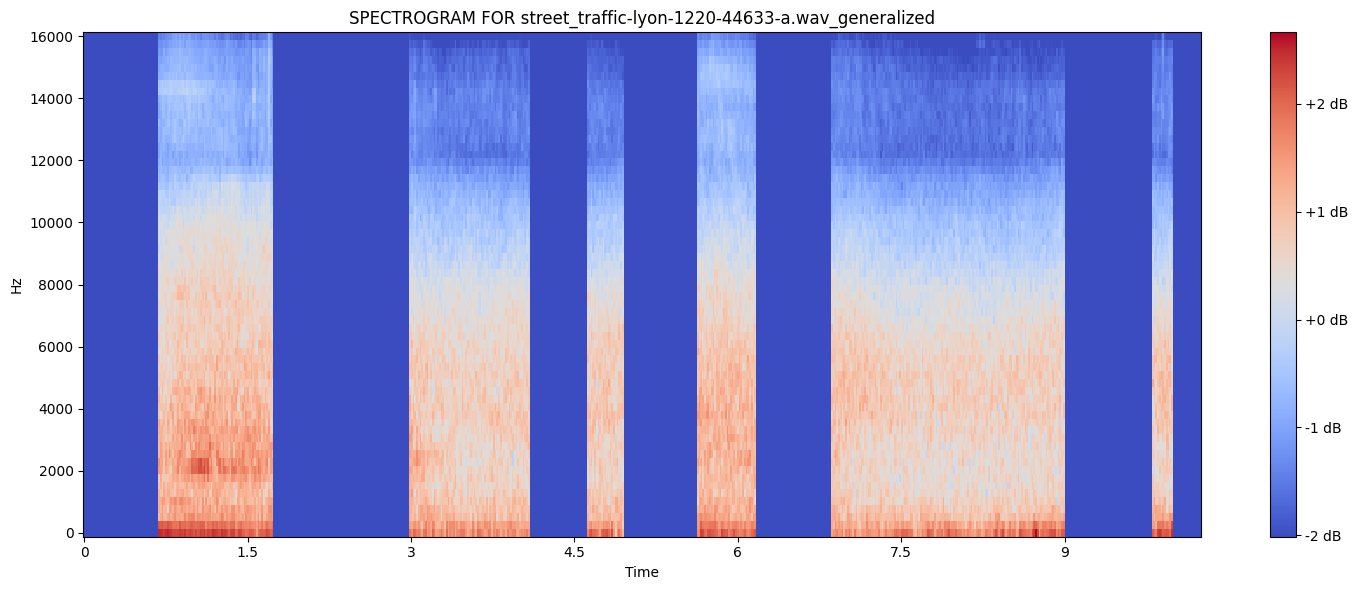

In [32]:
for audio in correct_audio_list[3:]:
    ##change the below to test on specific audios
    # audio = '/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-milan-1172-44126-a.wav'
    # audio = '/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-milan-1172-44205-a.wav'
    # audio = '/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-barcelona-203-6126-a.wav'
    # audio = '/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-milan-1172-45710-a.wav'
    print(audio)
    audioname = audio.split('/')[-1]
    
    # Load the audio file
    y, sr = librosa.load(audio, sr=32000)
    
    # Convert to log mel-spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=1024, hop_length=500, n_mels=64)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
    
    # Normalize the spectrogram
    log_mel_spectrogram = (log_mel_spectrogram - log_mel_spectrogram.mean()) / log_mel_spectrogram.std()
    #print(log_mel_spectrogram.shape) #(64, 641)
    
    # Convert to torch tensor
    log_mel_spectrogram_tensor = torch.tensor(log_mel_spectrogram, dtype=torch.float32).unsqueeze(0)
    # print(log_mel_spectrogram_tensor.shape)   #--- torch.Size([1, 64, 641])
    preds = predict(model, log_mel_spectrogram_tensor)
    preds = preds.cpu().numpy()
    
    # targets = [ClassifierOutputTarget(preds[0])]
    
    grayscale_cam = get_grayscale_cam(model, target_layers, log_mel_spectrogram_tensor, targets)
    print("Shape of grayscale_cam ", grayscale_cam.shape)
    print("Shape of log_mel_spectrogram ", log_mel_spectrogram.shape)

    # Overlay mask on input spectrogram
    normalized_cam = (grayscale_cam - np.min(grayscale_cam)) / (np.max(grayscale_cam) - np.min(grayscale_cam))
    product_spec = (log_mel_spectrogram * normalized_cam) # 64*641

    #Blackout
    modified_spectrogram = blackout_unimportant_features(grayscale_cam, log_mel_spectrogram)

    #Blackout only x, leave y
    generalized_cam_version, deactivated_col_list = blackout_only_x_dim(grayscale_cam, log_mel_spectrogram)
    generalized_cam_version_tensor = torch.tensor(generalized_cam_version, dtype=torch.float32).unsqueeze(0)
    # print("deactivated_col_list",deactivated_col_list)
    
    #Get altered audio
    y_alt = np.copy(y)
    print("Minimum value of audio: ", y.min())
    # y_alt[indices[:-1]] = 0 #setting it to 0

    # Get start index and stop index
    for col_index in deactivated_col_list:
        start_sample, end_sample = spectrogram_indices_to_sample_range(col_index)
        # print(start_sample, end_sample)
        y_alt[start_sample:end_sample+1] = y.min()
    
    # # timestamps = fetch_audio_timestamps(generalized_cam_version, deactivated_col_list)
    # # print("Deactivated-Timestamps :\n", timestamps)
   
    # #Retreive indices from timestamps
    # indices = (timestamps * 32000).astype(int)
    # # print("Audio Indices to be muted : ", type(indices), indices.shape, indices)
    # print("Number of audio indices to be muted: ", len(indices))    

    print("Altered audio shape :" ,y_alt.shape)
    print("Original audio shape :",y.shape)

    

    print("Shape of modified_spectrogram ",modified_spectrogram.shape)
    
    preds_after_cam = predict(model, generalized_cam_version_tensor)
    
    # Print the predicted label
    preds_after_cam = preds_after_cam.cpu().numpy()
    
    pred_label = idx_to_lb[preds[0]]
    preds_after_cam_label = idx_to_lb[preds_after_cam[0]]
    print("Prediction for ",audioname ,"is ", pred_label)
    print("Prediction after cam mask for ", audioname, "is ", preds_after_cam_label)
    display_log_mel_spectrogram(audioname, "spectrograms",log_mel_spectrogram, model_name)
    display_log_mel_spectrogram(audioname+"_overlay","cam_spectrograms", product_spec, "overlay")    
    display_log_mel_spectrogram(audioname+"_modified", "cam_spectrograms", modified_spectrogram, model_name)
    display_log_mel_spectrogram(audioname+"_generalized","generalized_cam_spectrograms", generalized_cam_version, model_name)
    break



In [1]:
audio_path = correct_audio_list[5]
# audio_path = '/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-prague-1193-45728-a.wav'
print(audio_path)
# Load the audio file
audio, sr = librosa.load(audio_path, sr = 32000)
print(audio.shape)
print("Sampling rate: ",sr)
Audio(data=audio, rate=sr)

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-prague-1193-45728-a.wav


NameError: name 'sound' is not defined

In [169]:
generalized_cam_version.shape

(64, 641)

In [170]:
y_alt.shape
Audio(data=y_alt, rate=32000)

In [35]:
def print_audio_tagging_result(clipwise_output):
    """Visualization of audio tagging result.

    Args:
      clipwise_output: (classes_num,)
    """
    sorted_indexes = np.argsort(clipwise_output)[::-1]

    # Print audio tagging top probabilities
    for k in range(10):
        print('{}: {:.3f}'.format(np.array(labels)[sorted_indexes[k]], 
            clipwise_output[sorted_indexes[k]]))

In [53]:
from panns_inference import AudioTagging, SoundEventDetection, labels
# INITIALIZE THE AUDIO TAGGER
at = AudioTagging(checkpoint_path='/home/aistwal/panns_data/Cnn14_mAP=0.431.pth', device="cuda")
audio = correct_audio_list[7]
# audio = '/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-prague-1193-45728-a.wav'

print(audio)
audioname = audio.split('/')[-1]
# Load the audio file
y, sr = librosa.load(audio, sr=32000)

#check panns inference
y = y[None, :]  # (batch_size, segment_samples)
print(y.shape)
(clipwise_output, embedding) = at.inference(y)
print_audio_tagging_result(clipwise_output[0])

print("New audio",y_alt.shape)
#check panns inference
y_new = y_alt[None, :]
(clipwise_output, embedding) = at.inference(y_new)
print_audio_tagging_result(clipwise_output[0])


Checkpoint path: /home/aistwal/panns_data/Cnn14_mAP=0.431.pth
GPU number: 8
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-207-6305-a.wav
(1, 320000)
Speech: 0.740
Clip-clop: 0.572
Horse: 0.445
Animal: 0.413
Vehicle: 0.132
Run: 0.096
Outside, urban or manmade: 0.073
Boat, Water vehicle: 0.039
Neigh, whinny: 0.037
Outside, rural or natural: 0.029
New audio (320000,)
Speech: 0.697
Clip-clop: 0.530
Horse: 0.460
Animal: 0.447
Vehicle: 0.123
Run: 0.088
Outside, urban or manmade: 0.068
Bicycle: 0.043
Neigh, whinny: 0.036
Boat, Water vehicle: 0.027


### UNSEEN AUDIO

In [227]:
#testing the model on an unseen test audio 
test_dir = '/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-leaderboard/audio/'
# afile = '2420.wav'
afile = '561.wav'
# afile = '1020.wav'
# afile = '1024.wav'
# afile = '/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1225-44995-a.wav'
# afile = '427.wav'
audio = test_dir + afile
audio 

'/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-leaderboard/audio/561.wav'

In [228]:
# Display Audio
ad, sr = librosa.load(audio, sr = 32000)
print(ad.shape, sr)
print("Sampling rate: ",sr)
Audio(data=ad, rate=sr)

(320000,) 32000
Sampling rate:  32000


In [229]:
print(audio)
audioname = audio.split('/')[-1]
print(audioname)
# Load the audio file
y, sr = librosa.load(audio, sr=32000)

# Convert to log mel-spectrogram
mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=32000, n_fft=1024, hop_length=500, n_mels=64)
log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)

# Normalize the spectrogram
log_mel_spectrogram = (log_mel_spectrogram - log_mel_spectrogram.mean()) / log_mel_spectrogram.std()
#print(log_mel_spectrogram.shape) #(64, 641)

# Convert to torch tensor
log_mel_spectrogram_tensor = torch.tensor(log_mel_spectrogram, dtype=torch.float32).unsqueeze(0)
# print(log_mel_spectrogram_tensor.shape) torch.Size([1, 64, 641])

grayscale_cam = get_grayscale_cam(model, target_layers, log_mel_spectrogram_tensor, targets)

print("Shape of grayscale_cam ", grayscale_cam.shape)
print("Shape of log_mel_spectrogram ", log_mel_spectrogram.shape)

modified_spectrogram = blackout_unimportant_features(grayscale_cam, log_mel_spectrogram)
generalized_cam_version, deactivated_col_list = blackout_only_x_dim(grayscale_cam, log_mel_spectrogram)
# print("deactivated_col_list",deactivated_col_list)
timestamps = fetch_audio_timestamps(generalized_cam_version, deactivated_col_list)
# print("Deactivated-Timestamps :\n", timestamps)

#Retreive indices from timestamps
indices = (timestamps * 32000).astype(int)
# print("Audio Indices to be muted : ", type(indices), indices)
print("Number of audio indices to be muted: ", len(indices))

#Get altered audio
y_alt = np.copy(y)
y_alt[indices[:-1]] = 0 #setting it to 0

print("Altered audio shape :" ,y_alt.shape)
print("Original audio shape :",y.shape)



# # Convert modified_spectrogram to torch tensor
# modified_spectrogram_tensor = torch.tensor(modified_spectrogram, dtype=torch.float32).unsqueeze(0)
print("Shape of modified_spectrogram ",modified_spectrogram.shape)
preds = predict(model, log_mel_spectrogram_tensor)

# Print the predicted label
preds = preds.cpu().numpy()
pred_label = idx_to_lb[preds[0]]
print("Prediction for ",audioname ,"is ", pred_label)
display_log_mel_spectrogram(audioname, "spectrograms",log_mel_spectrogram, model_name)
display_log_mel_spectrogram(audioname+"_modified", "cam_spectrograms", modified_spectrogram, model_name)
display_log_mel_spectrogram(audioname+"_generalized","generalized_cam_spectrograms", generalized_cam_version, model_name)

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-leaderboard/audio/561.wav
561.wav
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Shape of grayscale_cam  (64, 641)
Shape of log_mel_spectrogram  (64, 641)
Columns:  641


NameError: name 'fetch_audio_timestamps' is not defined

In [ ]:
y_alt.shape

In [ ]:
def print_audio_tagging_result(clipwise_output):
    sorted_indexes = np.argsort(clipwise_output)[::-1]
    events = []
    # Print audio tagging top probabilities
    for k in range(10):
        print('{}: {:.3f}'.format(np.array(labels)[sorted_indexes[k]], 
            clipwise_output[sorted_indexes[k]]))
        events.append(np.array(labels)[sorted_indexes[k]])
    return events

In [230]:
from panns_inference import AudioTagging, SoundEventDetection, labels
# INITIALIZE THE AUDIO TAGGER
at = AudioTagging(checkpoint_path='/home/aistwal/panns_data/Cnn14_mAP=0.431.pth', device="cuda")

#check panns inference
y = y[None, :]  # (batch_size, segment_samples)
print(y.shape)
(clipwise_output, embedding) = at.inference(y)
events_before = print_audio_tagging_result(clipwise_output[0])

#check panns inference
y_new = y_alt[None, :]
print("New audio",y_alt.shape)
(clipwise_output, embedding) = at.inference(y_new)
events_after = print_audio_tagging_result(clipwise_output[0])

Checkpoint path: /home/aistwal/panns_data/Cnn14_mAP=0.431.pth
GPU number: 8
(1, 320000)
Speech: 0.745
Vehicle: 0.534
Car: 0.157
Bus: 0.107
Music: 0.101
Aircraft: 0.080
Outside, urban or manmade: 0.062
Field recording: 0.061
Fixed-wing aircraft, airplane: 0.055
Boat, Water vehicle: 0.055
New audio (320000,)
Speech: 0.845
Clip-clop: 0.177
Horse: 0.148
Animal: 0.143
Outside, urban or manmade: 0.135
Run: 0.114
Vehicle: 0.109
Male speech, man speaking: 0.069
Music: 0.031
Car: 0.027


In [231]:
# clipwise_output[0] #basically represents the probabilities for all 527 classes of events from audio set.

In [232]:
!pip install matplotlib-venn

In [233]:
from matplotlib_venn import venn2

# Example data
set_before = set(events_before)
set_after = set(events_after)

venn2([set_before, set_after], ('Before CAM', 'After CAM'))
plt.title('Event overlap before and after CAM')
plt.show()

TypeError: 'NoneType' object is not iterable

### COLLECT EVENT LIST FOR ALL THE CORRECTLY PREDICTED AUDIOS


In [85]:
correct_pred = eval_df[eval_df['Predicted Label'] == eval_df['Actual Label']]
print(correct_pred.shape)
correct_pred.head()

(2230, 3)


Filename    Predicted Label  \
0  /work/aistwal/dataset_tau2019/extracted-files/...  street_pedestrian   
1  /work/aistwal/dataset_tau2019/extracted-files/...              metro   
3  /work/aistwal/dataset_tau2019/extracted-files/...  street_pedestrian   
4  /work/aistwal/dataset_tau2019/extracted-files/...     street_traffic   
7  /work/aistwal/dataset_tau2019/extracted-files/...            airport   

        Actual Label  
0  street_pedestrian  
1              metro  
3  street_pedestrian  
4     street_traffic  
7            airport

In [86]:
# INITIALIZE THE AUDIO TAGGER
at = AudioTagging(checkpoint_path='/home/aistwal/panns_data/Cnn14_mAP=0.431.pth', device="cuda")

Checkpoint path: /home/aistwal/panns_data/Cnn14_mAP=0.431.pth
GPU number: 8


In [87]:
def print_audio_tagging_result(clipwise_output):
    sorted_indexes = np.argsort(clipwise_output)[::-1]
    events = []
    for k in range(10):
        # print('{}: {:.3f}'.format(np.array(labels)[sorted_indexes[k]], 
        #     clipwise_output[sorted_indexes[k]]))
        events.append(np.array(labels)[sorted_indexes[k]])
    return events

In [128]:
# GET EVENTS FOR ALL CORRECTLY PREDICTED 2230 AUDIOS, AND STORE THE PREDICTED SCENE AFTER CAM MASK

from tqdm import tqdm

final_events_before = []
final_events_after = []
final_preds_cam_label = []

for file in tqdm(correct_pred['Filename']):

    audioname = file.split('/')[-1]
    print(audioname)
    # Load audio
    y, sr = librosa.load(file, sr=32000)
    
    # Convert to log mel-spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=32000, n_fft=1024, hop_length=500, n_mels=64)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
    
    # Normalize the spectrogram
    log_mel_spectrogram = (log_mel_spectrogram - log_mel_spectrogram.mean()) / log_mel_spectrogram.std()
    #print(log_mel_spectrogram.shape) #(64, 641)
    
    # Convert to torch tensor
    log_mel_spectrogram_tensor = torch.tensor(log_mel_spectrogram, dtype=torch.float32).unsqueeze(0)
    # print(log_mel_spectrogram_tensor.shape) torch.Size([1, 64, 641])

    print("Targets ",targets)
    grayscale_cam = get_grayscale_cam(model, target_layers, log_mel_spectrogram_tensor, targets)
    
    modified_spectrogram = blackout_unimportant_features(grayscale_cam, log_mel_spectrogram)
    generalized_cam_version, deactivated_col_list = blackout_only_x_dim(grayscale_cam, log_mel_spectrogram)
    
    # Convert to torch tensor
    generalized_cam_version_tensor = torch.tensor(generalized_cam_version, dtype=torch.float32).unsqueeze(0)
    # print("deactivated_col_list",deactivated_col_list)
    
    #Get altered audio
    y_alt = np.copy(y)
    print("Minimum value of audio: ", y.min())
    # y_alt[indices[:-1]] = 0 #setting it to 0

    # Get start index and stop index
    for col_index in deactivated_col_list:
        start_sample, end_sample = spectrogram_indices_to_sample_range(col_index)
        # print(start_sample, end_sample)
        y_alt[start_sample:end_sample+1] = y.min()

    
    # # Convert modified_spectrogram to torch tensor
    # modified_spectrogram_tensor = torch.tensor(modified_spectrogram, dtype=torch.float32).unsqueeze(0)
    # print("Shape of modified_spectrogram ",modified_spectrogram.shape)
    preds = predict(model, log_mel_spectrogram_tensor)
    preds_cam = predict(model, generalized_cam_version_tensor)
    
    # Print the predicted label
    preds = preds.cpu().numpy()
    pred_label = idx_to_lb[preds[0]]
    preds_cam = preds_cam.cpu().numpy()
    preds_cam_label = idx_to_lb[preds_cam[0]]
    print("Prediction for ",audioname ,"is ", pred_label)
    print("Prediction after cam mask: ", preds_cam_label)
    final_preds_cam_label.append(preds_cam_label)
    # display_log_mel_spectrogram(audioname, "spectrograms",log_mel_spectrogram, model_name)
    # display_log_mel_spectrogram(audioname+"_modified", "cam_spectrograms", modified_spectrogram, model_name)
    # display_log_mel_spectrogram(audioname+"_generalized","generalized_cam_spectrograms", generalized_cam_version, model_name)

    # Get panns inference for unaltered audio
    y = y[None, :]  # (batch_size, segment_samples)
    (clipwise_output, embedding) = at.inference(y)
    events_before = print_audio_tagging_result(clipwise_output[0])
    final_events_before.append(events_before)
    
    # Get panns inference for altered audio
    y_new = y_alt[None, :]
    (clipwise_output, embedding) = at.inference(y_new)
    events_after = print_audio_tagging_result(clipwise_output[0])
    final_events_after.append(events_after)    
    
    print("----"*25)
    

  0%|                                                                                                             | 1/2230 [00:00<06:06,  6.08it/s]

street_pedestrian-lyon-1162-44093-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.44
Minimum value of audio:  -0.007459752
Prediction for  street_pedestrian-lyon-1162-44093-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
metro-prague-1163-44094-a.wav


  0%|▏                                                                                                            | 3/2230 [00:00<03:48,  9.73it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.41
Minimum value of audio:  -0.3691916
Prediction for  metro-prague-1163-44094-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
street_pedestrian-milan-1165-44096-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.52
Minimum value of audio:  -0.010240768
Prediction for  street_pedestrian-milan-1165-44096-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_traffic-milan-1166-44097-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.53
Mini

  0%|▏                                                                                                            | 5/2230 [00:00<03:47,  9.79it/s]

----------------------------------------------------------------------------------------------------
airport-lyon-1169-44100-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.38
Minimum value of audio:  -0.012390156
Prediction for  airport-lyon-1169-44100-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
metro_station-prague-1170-44101-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.24
Minimum value of audio:  -0.15691179
Prediction for  metro_station-prague-1170-44101-a.wav is  metro_station
Prediction after cam mask:  metro_station


  0%|▎                                                                                                            | 7/2230 [00:00<03:35, 10.32it/s]

----------------------------------------------------------------------------------------------------
street_traffic-lisbon-1171-44102-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.47
Minimum value of audio:  -0.12655416
Prediction for  street_traffic-lisbon-1171-44102-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
airport-milan-1172-44103-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.31
Minimum value of audio:  -0.013888352
Prediction for  airport-milan-1172-44103-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
street_pedestrian-lisbon-1174-44105-a.wav
Targets  None


  0%|▍                                                                                                            | 9/2230 [00:00<03:22, 10.98it/s]

Columns:  641
Threshold:  0.36
Minimum value of audio:  -0.04976526
Prediction for  street_pedestrian-lisbon-1174-44105-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
airport-lisbon-1175-44106-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.21
Minimum value of audio:  -0.015374009
Prediction for  airport-lisbon-1175-44106-a.wav is  airport
Prediction after cam mask:  airport


  0%|▌                                                                                                           | 11/2230 [00:01<04:26,  8.32it/s]

----------------------------------------------------------------------------------------------------
metro_station-lyon-1167-44107-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.42
Minimum value of audio:  -0.04419734
Prediction for  metro_station-lyon-1167-44107-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
shopping_mall-lisbon-1176-44108-a.wav


  1%|▋                                                                                                           | 14/2230 [00:01<03:39, 10.12it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.29
Minimum value of audio:  -0.006702589
Prediction for  shopping_mall-lisbon-1176-44108-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
bus-lyon-1177-44109-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.05005766
Prediction for  bus-lyon-1177-44109-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
street_pedestrian-lyon-1162-44112-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.31
Minimum value of audio:  -0.00743277

  1%|▊                                                                                                           | 16/2230 [00:01<03:29, 10.57it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.26
Minimum value of audio:  -0.18018197
Prediction for  tram-prague-1184-44119-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
bus-lyon-1186-44122-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.38
Minimum value of audio:  -0.12001818
Prediction for  bus-lyon-1186-44122-a.wav is  bus
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
metro_station-milan-1187-44123-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.09753248
Prediction for  metro_station

  1%|▊                                                                                                           | 18/2230 [00:01<03:19, 11.08it/s]

----------------------------------------------------------------------------------------------------
park-lyon-1188-44124-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.46
Minimum value of audio:  -0.0040859575
Prediction for  park-lyon-1188-44124-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
airport-milan-1172-44126-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.33
Minimum value of audio:  -0.025008904
Prediction for  airport-milan-1172-44126-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-lyon-1169-44127-a.wav


  1%|▉                                                                                                           | 20/2230 [00:01<03:15, 11.33it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.41
Minimum value of audio:  -0.024698684
Prediction for  airport-lyon-1169-44127-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
bus-lyon-1177-44129-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.47
Minimum value of audio:  -0.05323643
Prediction for  bus-lyon-1177-44129-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
street_pedestrian-lyon-1162-44130-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.42
Minimum value of audio:  -0.013350835
Prediction for  s

  1%|█▏                                                                                                          | 24/2230 [00:02<03:15, 11.26it/s]

----------------------------------------------------------------------------------------------------
tram-lisbon-1191-44133-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.53
Minimum value of audio:  -0.15505499
Prediction for  tram-lisbon-1191-44133-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
public_square-prague-1192-44134-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.42
Minimum value of audio:  -0.03929974
Prediction for  public_square-prague-1192-44134-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
street_traffic-prague-1193-44135-a.wav


  1%|█▎                                                                                                          | 26/2230 [00:02<03:26, 10.69it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.47
Minimum value of audio:  -0.03766874
Prediction for  street_traffic-prague-1193-44135-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
park-prague-1185-44137-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.44
Minimum value of audio:  -0.052678514
Prediction for  park-prague-1185-44137-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-lyon-1188-44138-a.wav


  1%|█▎                                                                                                          | 28/2230 [00:02<03:36, 10.16it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.44
Minimum value of audio:  -0.0036417383
Prediction for  park-lyon-1188-44138-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
public_square-prague-1192-44139-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.51
Minimum value of audio:  -0.028394558
Prediction for  public_square-prague-1192-44139-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
tram-prague-1184-44141-a.wav


  1%|█▍                                                                                                          | 30/2230 [00:02<03:36, 10.16it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.21
Minimum value of audio:  -0.17490575
Prediction for  tram-prague-1184-44141-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
metro-lyon-1181-44146-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.41
Minimum value of audio:  -0.09423973
Prediction for  metro-lyon-1181-44146-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
park-lisbon-1198-44147-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


  1%|█▌                                                                                                          | 32/2230 [00:03<03:37, 10.08it/s]

Columns:  641
Threshold:  0.53
Minimum value of audio:  -0.0105229225
Prediction for  park-lisbon-1198-44147-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
metro-lisbon-1199-44150-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.53
Minimum value of audio:  -0.15325595
Prediction for  metro-lisbon-1199-44150-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
street_pedestrian-milan-1165-44151-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.32


  2%|█▋                                                                                                          | 34/2230 [00:03<03:36, 10.16it/s]

Minimum value of audio:  -0.011820539
Prediction for  street_pedestrian-milan-1165-44151-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-milan-1165-44156-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.31
Minimum value of audio:  -0.010311901
Prediction for  street_pedestrian-milan-1165-44156-a.wav is  street_pedestrian
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
bus-lyon-1177-44159-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.032558743


  2%|█▋                                                                                                          | 36/2230 [00:03<03:37, 10.07it/s]

Prediction for  bus-lyon-1177-44159-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
street_traffic-milan-1202-44160-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.02348132
Prediction for  street_traffic-milan-1202-44160-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
park-lyon-1188-44161-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.004740347
Prediction for  park-lyon-1188-44161-a.wav is  park
Prediction after cam mask:  park
---------------------------------------------------------------------------------------------

  2%|█▉                                                                                                          | 40/2230 [00:03<03:10, 11.47it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.33
Minimum value of audio:  -0.035346813
Prediction for  street_traffic-prague-1193-44163-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_pedestrian-prague-1203-44164-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.39
Minimum value of audio:  -0.009618698
Prediction for  street_pedestrian-prague-1203-44164-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
metro-lyon-1181-44168-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641


  2%|██                                                                                                          | 42/2230 [00:03<03:02, 11.96it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.25
Minimum value of audio:  -0.009554318
Prediction for  airport-prague-1195-44169-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
park-lisbon-1198-44170-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.54
Minimum value of audio:  -0.0077038934
Prediction for  park-lisbon-1198-44170-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
metro-lyon-1206-44172-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.26
Minimum value of audio:  -0.08626455
Prediction for  me

  2%|██▏                                                                                                         | 44/2230 [00:04<03:01, 12.02it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.58
Minimum value of audio:  -0.01757411
Prediction for  street_pedestrian-lisbon-1174-44174-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_traffic-lisbon-1171-44176-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.46
Minimum value of audio:  -0.06619415
Prediction for  street_traffic-lisbon-1171-44176-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
bus-lyon-1177-44178-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Thresho

  2%|██▎                                                                                                         | 48/2230 [00:04<02:54, 12.47it/s]

----------------------------------------------------------------------------------------------------
street_pedestrian-lisbon-1174-44179-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.27
Minimum value of audio:  -0.014325282
Prediction for  street_pedestrian-lisbon-1174-44179-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
bus-milan-1180-44182-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.47
Minimum value of audio:  -0.22983411
Prediction for  bus-milan-1180-44182-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
tram-prague-1210-44184-a.wav
Targets  None
Target_layer  [Ba

  2%|██▍                                                                                                         | 50/2230 [00:04<02:49, 12.85it/s]

----------------------------------------------------------------------------------------------------
street_pedestrian-lyon-1162-44185-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.35
Minimum value of audio:  -0.008953258
Prediction for  street_pedestrian-lyon-1162-44185-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
airport-lisbon-1175-44186-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.34
Minimum value of audio:  -0.019699963
Prediction for  airport-lisbon-1175-44186-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
park-prague-1185-44187-a.wav


  2%|██▌                                                                                                         | 52/2230 [00:04<02:56, 12.33it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.026208647
Prediction for  park-prague-1185-44187-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
public_square-lisbon-1211-44190-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.42
Minimum value of audio:  -0.08111513
Prediction for  public_square-lisbon-1211-44190-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
street_traffic-lisbon-1171-44192-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.47
Minimum value of aud

  3%|██▋                                                                                                         | 56/2230 [00:05<03:01, 12.01it/s]

----------------------------------------------------------------------------------------------------
street_pedestrian-lyon-1162-44194-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.007506247
Prediction for  street_pedestrian-lyon-1162-44194-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-milan-1165-44195-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.21
Minimum value of audio:  -0.014628912
Prediction for  street_pedestrian-milan-1165-44195-a.wav is  street_pedestrian
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
public_squa

  3%|██▊                                                                                                         | 58/2230 [00:05<03:01, 11.98it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.26
Minimum value of audio:  -0.027980886
Prediction for  public_square-prague-1192-44200-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
street_traffic-milan-1202-44201-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.39
Minimum value of audio:  -0.09784558
Prediction for  street_traffic-milan-1202-44201-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
metro-prague-1163-44202-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.35

  3%|██▉                                                                                                         | 60/2230 [00:05<03:03, 11.85it/s]

----------------------------------------------------------------------------------------------------
park-prague-1185-44203-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.51
Minimum value of audio:  -0.019455735
Prediction for  park-prague-1185-44203-a.wav is  park
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
tram-milan-1182-44204-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.41
Minimum value of audio:  -0.05605894
Prediction for  tram-milan-1182-44204-a.wav is  tram
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
airport-milan-1172-44205-a.wav


  3%|███                                                                                                         | 62/2230 [00:05<03:03, 11.79it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.41
Minimum value of audio:  -0.016056508
Prediction for  airport-milan-1172-44205-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
street_traffic-milan-1166-44207-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.39
Minimum value of audio:  -0.021358706
Prediction for  street_traffic-milan-1166-44207-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_pedestrian-prague-1203-44208-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimu

  3%|███▏                                                                                                        | 66/2230 [00:05<03:06, 11.59it/s]

----------------------------------------------------------------------------------------------------
airport-lisbon-1175-44210-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.49
Minimum value of audio:  -0.020899076
Prediction for  airport-lisbon-1175-44210-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
metro-prague-1213-44212-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.27
Minimum value of audio:  -0.14878482
Prediction for  metro-prague-1213-44212-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
airport-milan-1172-44215-a.wav


  3%|███▎                                                                                                        | 68/2230 [00:06<03:05, 11.67it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.27
Minimum value of audio:  -0.0132764205
Prediction for  airport-milan-1172-44215-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
metro-prague-1213-44217-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.17
Minimum value of audio:  -0.17769293
Prediction for  metro-prague-1213-44217-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
airport-prague-1195-44218-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.34
Minimum value of audio:  -0.0066954754
Prediction

  3%|███▍                                                                                                        | 70/2230 [00:06<03:07, 11.53it/s]

----------------------------------------------------------------------------------------------------
bus-prague-1215-44220-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.39
Minimum value of audio:  -0.06880908
Prediction for  bus-prague-1215-44220-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
park-prague-1185-44221-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.46
Minimum value of audio:  -0.03523325
Prediction for  park-prague-1185-44221-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
street_pedestrian-prague-1203-44222-a.wav


  3%|███▍                                                                                                        | 72/2230 [00:06<03:06, 11.58it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.52
Minimum value of audio:  -0.018833434
Prediction for  street_pedestrian-prague-1203-44222-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
metro_station-milan-1187-44224-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.18206085
Prediction for  metro_station-milan-1187-44224-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
street_traffic-milan-1166-44225-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
T

  3%|███▋                                                                                                        | 76/2230 [00:06<03:02, 11.77it/s]

Prediction for  street_traffic-milan-1166-44225-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
shopping_mall-milan-1183-44226-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.36
Minimum value of audio:  -0.016294587
Prediction for  shopping_mall-milan-1183-44226-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
airport-lyon-1169-44227-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.39
Minimum value of audio:  -0.0117235575
Prediction for  airport-lyon-1169-44227-a.wav is  airport
Prediction after cam mask:  airport
-----------------------------------------------

  3%|███▊                                                                                                        | 78/2230 [00:07<02:59, 12.01it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.49
Minimum value of audio:  -0.37868053
Prediction for  metro-milan-1197-44231-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
airport-lisbon-1175-44233-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.49
Minimum value of audio:  -0.021840239
Prediction for  airport-lisbon-1175-44233-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
park-prague-1185-44234-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.020074345
Prediction for

  4%|███▊                                                                                                        | 80/2230 [00:07<03:01, 11.85it/s]

----------------------------------------------------------------------------------------------------
street_traffic-prague-1193-44235-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.41
Minimum value of audio:  -0.035402186
Prediction for  street_traffic-prague-1193-44235-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
tram-prague-1210-44236-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.46
Minimum value of audio:  -0.3558341
Prediction for  tram-prague-1210-44236-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-lisbon-1191-44237-a.wav


  4%|████                                                                                                        | 84/2230 [00:07<02:54, 12.30it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.41
Minimum value of audio:  -0.17961925
Prediction for  tram-lisbon-1191-44237-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-lisbon-1191-44241-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.29
Minimum value of audio:  -0.36047745
Prediction for  tram-lisbon-1191-44241-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
park-lisbon-1198-44245-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.57
Minimum value of audio:  -0.011488593
Prediction for  park-lisbon-

  4%|████▏                                                                                                       | 86/2230 [00:07<02:55, 12.19it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.36
Minimum value of audio:  -0.11782868
Prediction for  street_traffic-lisbon-1171-44246-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
shopping_mall-lisbon-1176-44249-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.44
Minimum value of audio:  -0.0062522413
Prediction for  shopping_mall-lisbon-1176-44249-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
park-prague-1185-44250-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5

  4%|████▎                                                                                                       | 88/2230 [00:07<02:56, 12.11it/s]

----------------------------------------------------------------------------------------------------
tram-lisbon-1191-44252-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.52
Minimum value of audio:  -0.33062094
Prediction for  tram-lisbon-1191-44252-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-lyon-1216-44254-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.36
Minimum value of audio:  -0.07036555
Prediction for  tram-lyon-1216-44254-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
street_pedestrian-milan-1165-44255-a.wav


  4%|████▎                                                                                                       | 90/2230 [00:08<03:06, 11.46it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.36
Minimum value of audio:  -0.01813795
Prediction for  street_pedestrian-milan-1165-44255-a.wav is  street_pedestrian
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
street_traffic-lisbon-1171-44258-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.31
Minimum value of audio:  -0.058478225
Prediction for  street_traffic-lisbon-1171-44258-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
shopping_mall-lisbon-1176-44259-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Thres

  4%|████▌                                                                                                       | 94/2230 [00:08<02:57, 12.01it/s]

----------------------------------------------------------------------------------------------------
street_traffic-prague-1193-44261-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.49
Minimum value of audio:  -0.011201802
Prediction for  street_traffic-prague-1193-44261-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
metro-lyon-1206-44265-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.41
Minimum value of audio:  -0.07378801
Prediction for  metro-lyon-1206-44265-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-lisbon-1217-44266-a.wav
Targets  None
Target_layer  [BatchNo

  4%|████▋                                                                                                       | 96/2230 [00:08<02:58, 11.96it/s]

Columns:  641
Threshold:  0.15
Minimum value of audio:  -0.07286556
Prediction for  metro-lisbon-1217-44266-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
bus-lyon-1177-44268-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.39
Minimum value of audio:  -0.05865816
Prediction for  bus-lyon-1177-44268-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
metro-lyon-1181-44269-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.06906412
Prediction for  metro-lyon-1181-44269-a.wav is  metro
Prediction after cam mask:  metro


  4%|████▋                                                                                                       | 98/2230 [00:08<02:58, 11.95it/s]

----------------------------------------------------------------------------------------------------
bus-milan-1190-44273-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.58
Minimum value of audio:  -0.038159467
Prediction for  bus-milan-1190-44273-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
street_traffic-milan-1166-44275-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.48
Minimum value of audio:  -0.029161613
Prediction for  street_traffic-milan-1166-44275-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
park-lyon-1188-44277-a.wav


  4%|████▊                                                                                                      | 100/2230 [00:08<02:56, 12.06it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.59
Minimum value of audio:  -0.005478465
Prediction for  park-lyon-1188-44277-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
street_traffic-lisbon-1171-44278-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.42
Minimum value of audio:  -0.11979245
Prediction for  street_traffic-lisbon-1171-44278-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
airport-lyon-1169-44279-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.35
Minimum value of audio:  -

  5%|████▉                                                                                                      | 104/2230 [00:09<02:52, 12.34it/s]

----------------------------------------------------------------------------------------------------
tram-lisbon-1200-44280-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.57
Minimum value of audio:  -0.09391287
Prediction for  tram-lisbon-1200-44280-a.wav is  tram
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
airport-lyon-1169-44283-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.48
Minimum value of audio:  -0.027885802
Prediction for  airport-lyon-1169-44283-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
shopping_mall-prague-1219-44285-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, mo

  5%|█████                                                                                                      | 106/2230 [00:09<02:50, 12.49it/s]

Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.009639063
Prediction for  shopping_mall-prague-1219-44285-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
park-lisbon-1198-44290-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.57
Minimum value of audio:  -0.0069665136
Prediction for  park-lisbon-1198-44290-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
metro-lisbon-1217-44291-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.45
Minimum value of audio:  -0.16413292
Prediction for  metro-lisbon-1217-44291-a.wav is  metro
Prediction after cam mask:  metro
--------------------

  5%|█████▏                                                                                                     | 108/2230 [00:09<02:52, 12.30it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.54
Minimum value of audio:  -0.10050371
Prediction for  street_traffic-lyon-1220-44294-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
park-prague-1185-44295-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.47
Minimum value of audio:  -0.039358098
Prediction for  park-prague-1185-44295-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-lyon-1188-44300-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.43
Minimum value of audio:  -0.0037780048


  5%|█████▎                                                                                                     | 112/2230 [00:09<02:50, 12.45it/s]

public_square-prague-1192-44302-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.32
Minimum value of audio:  -0.04781357
Prediction for  public_square-prague-1192-44302-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-lyon-1208-44303-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.43
Minimum value of audio:  -0.033911914
Prediction for  public_square-lyon-1208-44303-a.wav is  public_square
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
park-milan-1164-44304-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


  5%|█████▍                                                                                                     | 114/2230 [00:09<02:41, 13.09it/s]

Minimum value of audio:  -0.008387007
Prediction for  park-milan-1164-44304-a.wav is  park
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-lyon-1220-44305-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.46
Minimum value of audio:  -0.06583567
Prediction for  street_traffic-lyon-1220-44305-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
shopping_mall-lyon-1196-44307-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.37
Minimum value of audio:  -0.010492167
Prediction for  shopping_mall-lyon-1196-44307-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
-----

  5%|█████▋                                                                                                     | 118/2230 [00:10<02:38, 13.29it/s]

Prediction for  street_traffic-lisbon-1171-44308-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_pedestrian-lisbon-1174-44310-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.45
Minimum value of audio:  -0.013439184
Prediction for  street_pedestrian-lisbon-1174-44310-a.wav is  street_pedestrian
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-lyon-1169-44314-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.37
Minimum value of audio:  -0.021018753
Prediction for  airport-lyon-1169-44314-a.wav is  airport
Prediction after cam mask:  airport
---------------------------------------

  5%|█████▊                                                                                                     | 120/2230 [00:10<02:35, 13.61it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.31
Minimum value of audio:  -0.006739859
Prediction for  shopping_mall-lyon-1196-44315-a.wav is  shopping_mall
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
metro_station-prague-1170-44316-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.35
Minimum value of audio:  -0.21069248
Prediction for  metro_station-prague-1170-44316-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
park-lyon-1188-44317-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.57
Minimum valu

  6%|█████▉                                                                                                     | 124/2230 [00:10<02:35, 13.53it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.38
Minimum value of audio:  -0.403511
Prediction for  tram-prague-1210-44319-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
metro-prague-1213-44320-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.46
Minimum value of audio:  -0.37770155
Prediction for  metro-prague-1213-44320-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
airport-lyon-1169-44321-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.41
Minimum value of audio:  -0.011640892
Prediction for  airport-l

  6%|██████                                                                                                     | 126/2230 [00:10<02:30, 13.96it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.45
Minimum value of audio:  -0.31506318
Prediction for  bus-prague-1207-44322-a.wav is  bus
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
park-lyon-1188-44323-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.45
Minimum value of audio:  -0.0040171305
Prediction for  park-lyon-1188-44323-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
metro-milan-1218-44325-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.29
Minimum value of audio:  -0.32050884
Prediction for  metro-milan-1218-

  6%|██████▏                                                                                                    | 130/2230 [00:11<02:35, 13.53it/s]

Columns:  641
Threshold:  0.48
Minimum value of audio:  -0.0057296865
Prediction for  park-lisbon-1198-44326-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-lyon-1188-44329-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.57
Minimum value of audio:  -0.0055670803
Prediction for  park-lyon-1188-44329-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
airport-lyon-1169-44330-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.35
Minimum value of audio:  -0.016489588
Prediction for  airport-lyon-1169-44330-a.wav is  airport
Prediction after cam mask:  airport
--------------------------------------------

  6%|██████▎                                                                                                    | 132/2230 [00:11<02:42, 12.88it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.29
Minimum value of audio:  -0.06777263
Prediction for  metro-lyon-1181-44331-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
street_traffic-lyon-1220-44332-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.48
Minimum value of audio:  -0.04092493
Prediction for  street_traffic-lyon-1220-44332-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
tram-milan-1209-44337-a.wav


  6%|██████▍                                                                                                    | 134/2230 [00:11<02:57, 11.78it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.58
Minimum value of audio:  -0.17143291
Prediction for  tram-milan-1209-44337-a.wav is  tram
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
shopping_mall-lisbon-1176-44338-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.34
Minimum value of audio:  -0.0059168967
Prediction for  shopping_mall-lisbon-1176-44338-a.wav is  shopping_mall
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro-prague-1163-44340-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.41
Minimum value of audio:  -0

  6%|██████▌                                                                                                    | 136/2230 [00:11<03:00, 11.63it/s]

----------------------------------------------------------------------------------------------------
street_traffic-milan-1166-44341-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.41
Minimum value of audio:  -0.062626734
Prediction for  street_traffic-milan-1166-44341-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
metro-lyon-1206-44343-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.38
Minimum value of audio:  -0.08002652
Prediction for  metro-lyon-1206-44343-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
tram-prague-1210-44345-a.wav


  6%|██████▌                                                                                                    | 138/2230 [00:11<02:55, 11.95it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.43
Minimum value of audio:  -0.2719108
Prediction for  tram-prague-1210-44345-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
street_pedestrian-milan-1205-44346-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.57
Minimum value of audio:  -0.0034619435
Prediction for  street_pedestrian-milan-1205-44346-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
airport-lyon-1169-44348-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.49
Minimum value 

  6%|██████▊                                                                                                    | 142/2230 [00:12<02:49, 12.32it/s]

----------------------------------------------------------------------------------------------------
street_traffic-lyon-1220-44350-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.59
Minimum value of audio:  -0.055970516
Prediction for  street_traffic-lyon-1220-44350-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
airport-lyon-1169-44351-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.39
Minimum value of audio:  -0.023940163
Prediction for  airport-lyon-1169-44351-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
street_traffic-prague-1193-44356-a.wav
Targets  None
Target_l

  6%|██████▉                                                                                                    | 144/2230 [00:12<02:47, 12.46it/s]

Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.040391386
Prediction for  street_traffic-prague-1193-44356-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-milan-1166-44360-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.44
Minimum value of audio:  -0.03420653
Prediction for  street_traffic-milan-1166-44360-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
park-prague-1185-44362-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.37
Minimum value of audio:  -0.02479586
Prediction for  park-prague-1185-44362-a.wav is  park
Prediction after c

  7%|███████                                                                                                    | 146/2230 [00:12<02:52, 12.05it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.39
Minimum value of audio:  -0.061851654
Prediction for  airport-lyon-1169-44363-a.wav is  airport
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-lyon-1206-44364-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.25
Minimum value of audio:  -0.10403952
Prediction for  metro-lyon-1206-44364-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
street_pedestrian-lisbon-1174-44365-a.wav


  7%|███████▏                                                                                                   | 150/2230 [00:12<02:51, 12.10it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.49
Minimum value of audio:  -0.014534643
Prediction for  street_pedestrian-lisbon-1174-44365-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-lisbon-1174-44367-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.42
Minimum value of audio:  -0.02327371
Prediction for  street_pedestrian-lisbon-1174-44367-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
metro-lyon-1181-44369-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Column

  7%|███████▎                                                                                                   | 152/2230 [00:13<03:00, 11.53it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.29
Minimum value of audio:  -0.044504263
Prediction for  tram-lisbon-1191-44372-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
metro_station-lyon-1179-44375-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.048340503
Prediction for  metro_station-lyon-1179-44375-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
airport-milan-1172-44376-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.39
Minimum value of audio:  -0.020

  7%|███████▍                                                                                                   | 154/2230 [00:13<02:46, 12.48it/s]

----------------------------------------------------------------------------------------------------
street_pedestrian-milan-1205-44377-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.39
Minimum value of audio:  -0.009876322
Prediction for  street_pedestrian-milan-1205-44377-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-lyon-1162-44378-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.25
Minimum value of audio:  -0.012233157
Prediction for  street_pedestrian-lyon-1162-44378-a.wav is  street_pedestrian
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
tram-lyon-1216-44

  7%|███████▌                                                                                                   | 158/2230 [00:13<02:45, 12.55it/s]

----------------------------------------------------------------------------------------------------
street_traffic-lyon-1220-44381-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.59
Minimum value of audio:  -0.05974158
Prediction for  street_traffic-lyon-1220-44381-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-milan-1202-44384-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.48
Minimum value of audio:  -0.012862021
Prediction for  street_traffic-milan-1202-44384-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
park-lyon-1188-44385-a.wav


  7%|███████▋                                                                                                   | 160/2230 [00:13<02:44, 12.59it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.43
Minimum value of audio:  -0.0030923253
Prediction for  park-lyon-1188-44385-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
airport-lyon-1169-44387-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.26
Minimum value of audio:  -0.024848942
Prediction for  airport-lyon-1169-44387-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
park-lyon-1188-44388-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.54
Minimum value of audio:  -0.0050554727
Prediction for  park

  7%|███████▊                                                                                                   | 162/2230 [00:13<02:43, 12.65it/s]

----------------------------------------------------------------------------------------------------
public_square-lisbon-1211-44389-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.48
Minimum value of audio:  -0.13616435
Prediction for  public_square-lisbon-1211-44389-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
street_traffic-prague-1193-44390-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.44
Minimum value of audio:  -0.013170678
Prediction for  street_traffic-prague-1193-44390-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-milan-1202-4439

  7%|███████▉                                                                                                   | 166/2230 [00:14<02:43, 12.65it/s]

Minimum value of audio:  -0.011822227
Prediction for  street_traffic-milan-1202-44391-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-prague-1193-44392-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.63
Minimum value of audio:  -0.02002035
Prediction for  street_traffic-prague-1193-44392-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
metro-lisbon-1199-44394-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.18956858
Prediction for  metro-lisbon-1199-44394-a.wav is  metro
Prediction after cam mask:  metro
-----------

  8%|████████                                                                                                   | 168/2230 [00:14<02:58, 11.56it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.34
Minimum value of audio:  -0.06447683
Prediction for  metro-lyon-1206-44395-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
tram-lisbon-1191-44398-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.49
Minimum value of audio:  -0.24916825
Prediction for  tram-lisbon-1191-44398-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
street_pedestrian-lyon-1162-44399-a.wav


  8%|████████▏                                                                                                  | 170/2230 [00:14<02:57, 11.60it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.36
Minimum value of audio:  -0.007810587
Prediction for  street_pedestrian-lyon-1162-44399-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
bus-prague-1215-44400-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.44
Minimum value of audio:  -0.15834355
Prediction for  bus-prague-1215-44400-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
public_square-prague-1192-44402-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.43
Minimum value of audio:

  8%|████████▎                                                                                                  | 172/2230 [00:14<02:53, 11.89it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.36
Minimum value of audio:  -0.013293279
Prediction for  airport-milan-1172-44409-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
street_traffic-prague-1193-44410-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.46
Minimum value of audio:  -0.060010925
Prediction for  street_traffic-prague-1193-44410-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_pedestrian-milan-1165-44411-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.31
Mini

  8%|████████▍                                                                                                  | 176/2230 [00:14<02:53, 11.84it/s]

----------------------------------------------------------------------------------------------------
street_traffic-lisbon-1171-44417-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.55
Minimum value of audio:  -0.027092556
Prediction for  street_traffic-lisbon-1171-44417-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-lyon-1220-44418-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.51
Minimum value of audio:  -0.06881035
Prediction for  street_traffic-lyon-1220-44418-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-milan-1166-4442

  8%|████████▌                                                                                                  | 178/2230 [00:15<02:52, 11.92it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.37
Minimum value of audio:  -0.051551513
Prediction for  street_traffic-milan-1166-44421-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
bus-prague-1215-44427-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.46
Minimum value of audio:  -0.1709244
Prediction for  bus-prague-1215-44427-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
street_traffic-milan-1202-44428-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.55
Minimum value of audio:  -0.0101

  8%|████████▋                                                                                                  | 180/2230 [00:15<02:50, 12.03it/s]

----------------------------------------------------------------------------------------------------
airport-lyon-1169-44430-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.37
Minimum value of audio:  -0.019585982
Prediction for  airport-lyon-1169-44430-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
street_traffic-lyon-1220-44431-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.51
Minimum value of audio:  -0.043013744
Prediction for  street_traffic-lyon-1220-44431-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-lisbon-1171-44432-a.wav
Targets  None
Target_l

  8%|████████▊                                                                                                  | 184/2230 [00:15<02:43, 12.48it/s]

Columns:  641
Threshold:  0.51
Minimum value of audio:  -0.030348936
Prediction for  street_traffic-lisbon-1171-44432-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
airport-prague-1195-44435-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.42
Minimum value of audio:  -0.0060601034
Prediction for  airport-prague-1195-44435-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
public_square-prague-1192-44436-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.47
Minimum value of audio:  -0.012271625
Prediction for  public_square-prague-1192-44436-a.wav is  public_square
Prediction af

  8%|████████▉                                                                                                  | 186/2230 [00:15<02:44, 12.39it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.35
Minimum value of audio:  -0.015320955
Prediction for  shopping_mall-milan-1183-44440-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
street_pedestrian-milan-1205-44443-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.35
Minimum value of audio:  -0.005861397
Prediction for  street_pedestrian-milan-1205-44443-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_traffic-milan-1166-44444-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  

  8%|█████████                                                                                                  | 188/2230 [00:15<02:46, 12.26it/s]

----------------------------------------------------------------------------------------------------
street_pedestrian-lisbon-1174-44445-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.34
Minimum value of audio:  -0.026858632
Prediction for  street_pedestrian-lisbon-1174-44445-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
airport-lyon-1169-44446-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.38
Minimum value of audio:  -0.009586915
Prediction for  airport-lyon-1169-44446-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
street_traffic-milan-1166-44447-a.wav
Targets

  9%|█████████▏                                                                                                 | 192/2230 [00:16<02:48, 12.09it/s]

Columns:  641
Threshold:  0.45
Minimum value of audio:  -0.042968497
Prediction for  street_traffic-milan-1166-44447-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
park-milan-1164-44449-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.0053708083
Prediction for  park-milan-1164-44449-a.wav is  park
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
street_pedestrian-milan-1165-44450-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.53
Minimum value of audio:  -0.0069017503
Prediction for  street_pedestrian-milan-1165-44450-a.wav is  street_pedestrian
Predictio

  9%|█████████▎                                                                                                 | 194/2230 [00:16<02:49, 12.00it/s]

metro-milan-1197-44452-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.33
Minimum value of audio:  -0.20706117
Prediction for  metro-milan-1197-44452-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
street_pedestrian-lyon-1162-44453-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.41
Minimum value of audio:  -0.007573774
Prediction for  street_pedestrian-lyon-1162-44453-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
public_square-prague-1192-44454-a.wav


  9%|█████████▍                                                                                                 | 196/2230 [00:16<02:51, 11.87it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.48
Minimum value of audio:  -0.026153564
Prediction for  public_square-prague-1192-44454-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
street_traffic-lyon-1220-44456-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.58
Minimum value of audio:  -0.086492226
Prediction for  street_traffic-lyon-1220-44456-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
park-prague-1185-44457-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.57
M

  9%|█████████▌                                                                                                 | 198/2230 [00:16<02:47, 12.16it/s]

----------------------------------------------------------------------------------------------------
park-lyon-1188-44460-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.38
Minimum value of audio:  -0.01037489
Prediction for  park-lyon-1188-44460-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
street_traffic-lyon-1220-44461-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.51
Minimum value of audio:  -0.1697475
Prediction for  street_traffic-lyon-1220-44461-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
park-lyon-1188-44464-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps

  9%|█████████▋                                                                                                 | 202/2230 [00:17<02:42, 12.47it/s]

Minimum value of audio:  -0.0037218768
Prediction for  park-lyon-1188-44464-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
street_traffic-lyon-1220-44467-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.51
Minimum value of audio:  -0.12468259
Prediction for  street_traffic-lyon-1220-44467-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_pedestrian-lyon-1162-44468-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.0075854743
Prediction for  street_pedestrian-lyon-1162-44468-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian

  9%|█████████▊                                                                                                 | 204/2230 [00:17<02:52, 11.77it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.35
Minimum value of audio:  -0.022509404
Prediction for  street_traffic-prague-1193-44470-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-prague-1193-44472-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.46
Minimum value of audio:  -0.022951793
Prediction for  street_traffic-prague-1193-44472-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
bus-prague-1215-44476-a.wav


  9%|█████████▉                                                                                                 | 206/2230 [00:17<03:05, 10.92it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.14680243
Prediction for  bus-prague-1215-44476-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
tram-lyon-1216-44477-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.29
Minimum value of audio:  -0.047072053
Prediction for  tram-lyon-1216-44477-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
street_traffic-lyon-1220-44479-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.39
Minimum value of audio:  -0.06952249


  9%|█████████▉                                                                                                 | 208/2230 [00:17<03:05, 10.91it/s]

Prediction for  street_traffic-lyon-1220-44479-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_pedestrian-lisbon-1174-44481-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.53
Minimum value of audio:  -0.015487723
Prediction for  street_pedestrian-lisbon-1174-44481-a.wav is  street_pedestrian
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
bus-lyon-1186-44482-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.37


  9%|██████████                                                                                                 | 210/2230 [00:17<03:15, 10.33it/s]

Minimum value of audio:  -0.09588325
Prediction for  bus-lyon-1186-44482-a.wav is  bus
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
airport-lyon-1169-44486-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.36
Minimum value of audio:  -0.017535588
Prediction for  airport-lyon-1169-44486-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
bus-milan-1190-44489-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.41
Minimum value of audio:  -0.21732512
Prediction for  bus-milan-1190-44489-a.wav is  bus
Prediction after cam mask:  bus


 10%|██████████▏                                                                                                | 212/2230 [00:18<03:06, 10.82it/s]

----------------------------------------------------------------------------------------------------
street_pedestrian-lisbon-1174-44492-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.32
Minimum value of audio:  -0.0124780815
Prediction for  street_pedestrian-lisbon-1174-44492-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_traffic-milan-1166-44493-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.49
Minimum value of audio:  -0.03585869
Prediction for  street_traffic-milan-1166-44493-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
public_square-l

 10%|██████████▎                                                                                                | 216/2230 [00:18<02:44, 12.21it/s]

Columns:  641
Threshold:  0.41
Minimum value of audio:  -0.010689165
Prediction for  public_square-lyon-1178-44495-a.wav is  public_square
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-lyon-1169-44497-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.39
Minimum value of audio:  -0.018947124
Prediction for  airport-lyon-1169-44497-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
street_pedestrian-prague-1203-44501-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.45
Minimum value of audio:  -0.013592789
Prediction for  street_pedestrian-prague-1203-44501-a.wav is  street_pedestrian
Prediction after 

 10%|██████████▍                                                                                                | 218/2230 [00:18<02:37, 12.77it/s]

Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.05696419
Prediction for  street_traffic-milan-1202-44505-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
metro_station-lisbon-1221-44508-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.47
Minimum value of audio:  -0.17478406
Prediction for  metro_station-lisbon-1221-44508-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
bus-lyon-1186-44509-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.44
Minimum value of audio:  -0.22346485
Prediction for  bus-lyon-1186-44509-a.wav is  bus
Prediction after cam mask:  b

 10%|██████████▋                                                                                                | 222/2230 [00:18<02:25, 13.76it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.46
Minimum value of audio:  -0.049849294
Prediction for  tram-lyon-1216-44510-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
bus-milan-1190-44511-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.46
Minimum value of audio:  -0.05141625
Prediction for  bus-milan-1190-44511-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
metro_station-lyon-1179-44512-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.37
Minimum value of audio:  -0.032114778
Prediction for  metro_statio

 10%|██████████▋                                                                                                | 224/2230 [00:18<02:29, 13.41it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.56
Minimum value of audio:  -0.009109233
Prediction for  street_pedestrian-lisbon-1174-44513-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
metro-milan-1197-44514-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.44
Minimum value of audio:  -0.2383148
Prediction for  metro-milan-1197-44514-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
public_square-lisbon-1211-44515-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.33
Minimum value of

 10%|██████████▉                                                                                                | 228/2230 [00:19<02:25, 13.74it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.56
Minimum value of audio:  -0.09944521
Prediction for  street_traffic-lyon-1220-44519-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
tram-lyon-1225-44521-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.45
Minimum value of audio:  -0.05157811
Prediction for  tram-lyon-1225-44521-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
park-prague-1185-44522-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.43
Minimum value of audio:  -0.030363947
Pred

 10%|███████████                                                                                                | 230/2230 [00:19<02:25, 13.77it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.41
Minimum value of audio:  -0.045270342
Prediction for  bus-lisbon-1226-44523-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
airport-milan-1172-44524-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.016543297
Prediction for  airport-milan-1172-44524-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
street_traffic-lyon-1220-44527-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.58
Minimum value of audio:  -0.099510014
Prediction f

 10%|███████████▏                                                                                               | 234/2230 [00:19<02:18, 14.36it/s]

Columns:  641
Threshold:  0.42
Minimum value of audio:  -0.028705569
Prediction for  airport-lyon-1169-44528-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
metro-prague-1204-44537-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.36
Minimum value of audio:  -0.42175308
Prediction for  metro-prague-1204-44537-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
street_traffic-lyon-1220-44542-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.49
Minimum value of audio:  -0.056965254
Prediction for  street_traffic-lyon-1220-44542-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----

 11%|███████████▎                                                                                               | 236/2230 [00:19<02:21, 14.13it/s]

Columns:  641
Threshold:  0.55
Minimum value of audio:  -0.09352033
Prediction for  bus-milan-1190-44543-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
metro-milan-1218-44544-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.34
Minimum value of audio:  -0.040345542
Prediction for  metro-milan-1218-44544-a.wav is  metro
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
street_traffic-lyon-1220-44545-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.38
Minimum value of audio:  -0.060106855
Prediction for  street_traffic-lyon-1220-44545-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
---------

 11%|███████████▌                                                                                               | 240/2230 [00:20<02:16, 14.56it/s]

Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.34034592
Prediction for  tram-lisbon-1191-44547-a.wav is  tram
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
street_traffic-lisbon-1171-44548-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.56
Minimum value of audio:  -0.045498163
Prediction for  street_traffic-lisbon-1171-44548-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_pedestrian-prague-1203-44549-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.36
Minimum value of audio:  -0.0055957106
Prediction for  street_pedestrian-prague-1203-44549-a.wav is  street_pedestrian
Pred

 11%|███████████▌                                                                                               | 242/2230 [00:20<02:14, 14.73it/s]

Columns:  641
Threshold:  0.46
Minimum value of audio:  -0.06112861
Prediction for  tram-lyon-1225-44550-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
street_pedestrian-lisbon-1174-44556-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.46
Minimum value of audio:  -0.013719112
Prediction for  street_pedestrian-lisbon-1174-44556-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
tram-lisbon-1191-44557-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.45
Minimum value of audio:  -0.09030976
Prediction for  tram-lisbon-1191-44557-a.wav is  tram
Prediction after cam mask:  tram
--

 11%|███████████▊                                                                                               | 246/2230 [00:20<02:25, 13.65it/s]

Prediction for  tram-prague-1189-44561-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-lyon-1216-44562-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.46
Minimum value of audio:  -0.1644277
Prediction for  tram-lyon-1216-44562-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
shopping_mall-lyon-1196-44563-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.35
Minimum value of audio:  -0.015756063
Prediction for  shopping_mall-lyon-1196-44563-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
---------------------------------------------------------------------------------------------

 11%|███████████▉                                                                                               | 248/2230 [00:20<02:31, 13.08it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.29
Minimum value of audio:  -0.064244375
Prediction for  metro-lyon-1181-44564-a.wav is  metro
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
airport-milan-1172-44567-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.24
Minimum value of audio:  -0.03372271
Prediction for  airport-milan-1172-44567-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
metro-lisbon-1224-44568-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.33
Minimum value of audio:  -0.20125392
Predicti

 11%|████████████                                                                                               | 252/2230 [00:20<02:28, 13.32it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.006093053
Prediction for  park-lyon-1188-44569-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
airport-lyon-1169-44570-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.29
Minimum value of audio:  -0.00802708
Prediction for  airport-lyon-1169-44570-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
street_traffic-milan-1166-44571-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.39
Minimum value of audio:  -0.044901356
Prediction fo

 11%|████████████▏                                                                                              | 254/2230 [00:21<02:28, 13.35it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.1806901
Prediction for  tram-lyon-1225-44574-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
street_traffic-lisbon-1171-44575-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.52
Minimum value of audio:  -0.047546744
Prediction for  street_traffic-lisbon-1171-44575-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
metro_station-lisbon-1221-44577-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.25
Minimum value of aud

 12%|████████████▍                                                                                              | 258/2230 [00:21<02:30, 13.11it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.009626345
Prediction for  street_pedestrian-lyon-1162-44579-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_traffic-milan-1166-44580-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.34
Minimum value of audio:  -0.040242437
Prediction for  street_traffic-milan-1166-44580-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-milan-1202-44584-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  64

 12%|████████████▍                                                                                              | 260/2230 [00:21<02:30, 13.12it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.58
Minimum value of audio:  -0.065993115
Prediction for  tram-lyon-1216-44585-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
park-prague-1185-44590-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.18
Minimum value of audio:  -0.03248919
Prediction for  park-prague-1185-44590-a.wav is  park
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_pedestrian-milan-1165-44591-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.46
Minimum value of audio:  -0.014364058
Predict

 12%|████████████▋                                                                                              | 264/2230 [00:21<02:25, 13.54it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.28
Minimum value of audio:  -0.07474751
Prediction for  metro-lyon-1206-44595-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
bus-milan-1190-44598-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.42
Minimum value of audio:  -0.1160575
Prediction for  bus-milan-1190-44598-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
street_pedestrian-lyon-1162-44599-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.52
Minimum value of audio:  -0.009302907
Prediction for  street_

 12%|████████████▊                                                                                              | 266/2230 [00:21<02:24, 13.59it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.052819073
Prediction for  tram-lyon-1216-44600-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
metro-lisbon-1224-44603-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.34
Minimum value of audio:  -0.06277856
Prediction for  metro-lisbon-1224-44603-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
tram-prague-1184-44604-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.33
Minimum value of audio:  -0.3058074
Prediction for  tram-prague-

 12%|████████████▊                                                                                              | 268/2230 [00:22<02:35, 12.65it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.54
Minimum value of audio:  -0.0144221205
Prediction for  park-lisbon-1198-44605-a.wav is  park
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
airport-lisbon-1175-44606-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.43
Minimum value of audio:  -0.021162534
Prediction for  airport-lisbon-1175-44606-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
bus-lisbon-1226-44607-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.62
Minimum value of audio:  -0.31233284
Prediction for 

 12%|████████████▉                                                                                              | 270/2230 [00:22<02:34, 12.66it/s]

----------------------------------------------------------------------------------------------------
street_pedestrian-lisbon-1174-44609-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.26
Minimum value of audio:  -0.013641397
Prediction for  street_pedestrian-lisbon-1174-44609-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
bus-milan-1180-44610-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.46
Minimum value of audio:  -0.21688649
Prediction for  bus-milan-1180-44610-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------


 12%|█████████████▏                                                                                             | 274/2230 [00:22<02:48, 11.59it/s]

metro_station-lyon-1167-44611-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.03008452
Prediction for  metro_station-lyon-1167-44611-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
street_pedestrian-prague-1203-44612-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.44
Minimum value of audio:  -0.024845695
Prediction for  street_pedestrian-prague-1203-44612-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
park-lyon-1188-44613-a.wav


 12%|█████████████▏                                                                                             | 276/2230 [00:22<02:48, 11.62it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.41
Minimum value of audio:  -0.0047339685
Prediction for  park-lyon-1188-44613-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
bus-prague-1194-44618-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.53
Minimum value of audio:  -0.2073847
Prediction for  bus-prague-1194-44618-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
street_pedestrian-lyon-1162-44621-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.23
Minimum value of audio:  -0.009012321
Prediction for  street

 12%|█████████████▎                                                                                             | 278/2230 [00:23<02:48, 11.55it/s]

----------------------------------------------------------------------------------------------------
airport-milan-1172-44624-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.29
Minimum value of audio:  -0.013314322
Prediction for  airport-milan-1172-44624-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
bus-milan-1180-44625-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.25
Minimum value of audio:  -0.075673014
Prediction for  bus-milan-1180-44625-a.wav is  bus
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
street_traffic-milan-1202-44626-a.wav


 13%|█████████████▍                                                                                             | 280/2230 [00:23<02:48, 11.60it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.54
Minimum value of audio:  -0.01282954
Prediction for  street_traffic-milan-1202-44626-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_pedestrian-lisbon-1174-44627-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.013353702
Prediction for  street_pedestrian-lisbon-1174-44627-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
metro_station-lyon-1167-44628-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


 13%|█████████████▋                                                                                             | 284/2230 [00:23<02:46, 11.68it/s]

Columns:  641
Threshold:  0.51
Minimum value of audio:  -0.031021014
Prediction for  metro_station-lyon-1167-44628-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
bus-lyon-1186-44629-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.35
Minimum value of audio:  -0.08961594
Prediction for  bus-lyon-1186-44629-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
street_pedestrian-lyon-1162-44630-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.008081393
Prediction for  street_pedestrian-lyon-1162-44630-a.wav is  street_pedestrian
Prediction after cam mask:  stree

 13%|█████████████▋                                                                                             | 286/2230 [00:23<02:37, 12.34it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.54
Minimum value of audio:  -0.13325776
Prediction for  street_traffic-lyon-1220-44633-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
metro_station-milan-1187-44635-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.43
Minimum value of audio:  -0.21705356
Prediction for  metro_station-milan-1187-44635-a.wav is  metro_station
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
street_traffic-lyon-1220-44637-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.63
Mini

 13%|█████████████▊                                                                                             | 288/2230 [00:23<02:30, 12.87it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.0155928405
Prediction for  street_traffic-milan-1202-44638-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
bus-prague-1215-44640-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.13591313
Prediction for  bus-prague-1215-44640-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
metro-lisbon-1217-44642-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.47
Minimum value of audio:  -0.12137906
Pre

 13%|██████████████                                                                                             | 292/2230 [00:24<02:36, 12.42it/s]

----------------------------------------------------------------------------------------------------
metro_station-prague-1170-44643-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.33
Minimum value of audio:  -0.05857948
Prediction for  metro_station-prague-1170-44643-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
park-lisbon-1198-44644-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.54
Minimum value of audio:  -0.007801553
Prediction for  park-lisbon-1198-44644-a.wav is  park
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
street_pedestrian-lisbon-1174-44646-a.wav


 13%|██████████████                                                                                             | 294/2230 [00:24<02:42, 11.94it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.52
Minimum value of audio:  -0.035892572
Prediction for  street_pedestrian-lisbon-1174-44646-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_traffic-lyon-1220-44647-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.57
Minimum value of audio:  -0.16112795
Prediction for  street_traffic-lyon-1220-44647-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
shopping_mall-lyon-1196-44648-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641


 13%|██████████████▏                                                                                            | 296/2230 [00:24<02:53, 11.17it/s]

----------------------------------------------------------------------------------------------------
street_pedestrian-lyon-1162-44649-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.008348083
Prediction for  street_pedestrian-lyon-1162-44649-a.wav is  street_pedestrian
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
street_pedestrian-lyon-1162-44650-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.23
Minimum value of audio:  -0.006884498
Prediction for  street_pedestrian-lyon-1162-44650-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-pr

 13%|██████████████▎                                                                                            | 298/2230 [00:24<02:54, 11.06it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.41
Minimum value of audio:  -0.011475285
Prediction for  street_pedestrian-prague-1203-44652-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-prague-1227-44653-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.31
Minimum value of audio:  -0.010132412
Prediction for  street_pedestrian-prague-1227-44653-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-prague-1203-44655-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stat

 13%|██████████████▍                                                                                            | 300/2230 [00:24<02:56, 10.92it/s]

Threshold:  0.37
Minimum value of audio:  -0.019987267
Prediction for  street_pedestrian-prague-1203-44655-a.wav is  street_pedestrian
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
park-prague-1185-44659-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.52
Minimum value of audio:  -0.026438106
Prediction for  park-prague-1185-44659-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
street_pedestrian-milan-1165-44660-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


 14%|██████████████▌                                                                                            | 304/2230 [00:25<02:56, 10.88it/s]

Columns:  641
Threshold:  0.43
Minimum value of audio:  -0.0414692
Prediction for  street_pedestrian-milan-1165-44660-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
airport-milan-1172-44661-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.23
Minimum value of audio:  -0.013688733
Prediction for  airport-milan-1172-44661-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
bus-prague-1215-44662-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.33
Minimum value of audio:  -0.043446317
Prediction for  bus-prague-1215-44662-a.wav is  bus
Prediction after cam mask:  bus
--------

 14%|██████████████▋                                                                                            | 306/2230 [00:25<02:48, 11.45it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.52
Minimum value of audio:  -0.10094525
Prediction for  street_traffic-lisbon-1171-44663-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
tram-lyon-1225-44664-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.55
Minimum value of audio:  -0.049305078
Prediction for  tram-lyon-1225-44664-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
airport-lisbon-1175-44669-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.29
Minimum value of audio:  -0.02663584

 14%|██████████████▊                                                                                            | 308/2230 [00:25<02:43, 11.77it/s]

----------------------------------------------------------------------------------------------------
park-lyon-1188-44670-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.53
Minimum value of audio:  -0.0040202183
Prediction for  park-lyon-1188-44670-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
street_traffic-lisbon-1171-44671-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.54
Minimum value of audio:  -0.04944974
Prediction for  street_traffic-lisbon-1171-44671-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
shopping_mall-prague-1219-44673-a.wav
Targets  None
Target_layer  [Ba

 14%|██████████████▊                                                                                            | 310/2230 [00:25<02:38, 12.11it/s]

Prediction for  shopping_mall-prague-1219-44673-a.wav is  shopping_mall
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
park-lisbon-1198-44675-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.63
Minimum value of audio:  -0.010827858
Prediction for  park-lisbon-1198-44675-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
metro-lisbon-1217-44679-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.13989386
Prediction for  metro-lisbon-1217-44679-a.wav is  metro
Prediction after cam mask:  metro


 14%|██████████████▉                                                                                            | 312/2230 [00:25<02:44, 11.62it/s]

----------------------------------------------------------------------------------------------------
metro-milan-1197-44680-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.27
Minimum value of audio:  -0.25210676
Prediction for  metro-milan-1197-44680-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
tram-lyon-1225-44681-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.39
Minimum value of audio:  -0.19155602
Prediction for  tram-lyon-1225-44681-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------


 14%|███████████████▏                                                                                           | 316/2230 [00:26<02:47, 11.42it/s]

street_pedestrian-lyon-1162-44682-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.41
Minimum value of audio:  -0.009902427
Prediction for  street_pedestrian-lyon-1162-44682-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
shopping_mall-prague-1219-44685-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.34
Minimum value of audio:  -0.0147731975
Prediction for  shopping_mall-prague-1219-44685-a.wav is  shopping_mall
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
park-lyon-1188-44686-a.wav


 14%|███████████████▎                                                                                           | 318/2230 [00:26<03:02, 10.49it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.48
Minimum value of audio:  -0.006198883
Prediction for  park-lyon-1188-44686-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
airport-milan-1172-44687-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.28
Minimum value of audio:  -0.018290648
Prediction for  airport-milan-1172-44687-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
metro-lisbon-1224-44688-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.56
Minimum value of audio:  -0.21505505


 14%|███████████████▎                                                                                           | 320/2230 [00:26<02:58, 10.70it/s]

Prediction for  metro-lisbon-1224-44688-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
bus-lyon-1186-44689-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.51
Minimum value of audio:  -0.21785994
Prediction for  bus-lyon-1186-44689-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
airport-lisbon-1175-44691-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.020356562
Prediction for  airport-lisbon-1175-44691-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
metro-prague-

 14%|███████████████▍                                                                                           | 322/2230 [00:26<02:53, 10.97it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.14282331
Prediction for  metro-prague-1213-44692-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
tram-lisbon-1191-44696-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.58
Minimum value of audio:  -0.039141916
Prediction for  tram-lisbon-1191-44696-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
airport-lisbon-1175-44700-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.29
Minimum value of audio:  -0.026421405
Prediction for  airpor

 15%|███████████████▋                                                                                           | 326/2230 [00:27<02:48, 11.31it/s]

----------------------------------------------------------------------------------------------------
bus-milan-1190-44701-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.45
Minimum value of audio:  -0.043179862
Prediction for  bus-milan-1190-44701-a.wav is  bus
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
street_traffic-lisbon-1171-44704-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.56
Minimum value of audio:  -0.075908124
Prediction for  street_traffic-lisbon-1171-44704-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_pedestrian-lyon-1162-44707-a.wav


 15%|███████████████▋                                                                                           | 328/2230 [00:27<03:00, 10.53it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.58
Minimum value of audio:  -0.0066183037
Prediction for  street_pedestrian-lyon-1162-44707-a.wav is  street_pedestrian
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
airport-lisbon-1175-44708-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.32
Minimum value of audio:  -0.015896976
Prediction for  airport-lisbon-1175-44708-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
metro_station-lisbon-1221-44710-a.wav


 15%|███████████████▊                                                                                           | 330/2230 [00:27<02:52, 11.00it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.31
Minimum value of audio:  -0.13593748
Prediction for  metro_station-lisbon-1221-44710-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
street_pedestrian-prague-1227-44711-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.47
Minimum value of audio:  -0.013145481
Prediction for  street_pedestrian-prague-1227-44711-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
tram-lyon-1216-44712-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Thres

 15%|███████████████▉                                                                                           | 332/2230 [00:27<02:47, 11.31it/s]

----------------------------------------------------------------------------------------------------
street_traffic-milan-1166-44715-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.43
Minimum value of audio:  -0.03540227
Prediction for  street_traffic-milan-1166-44715-a.wav is  street_traffic
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
street_pedestrian-lyon-1162-44717-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.26
Minimum value of audio:  -0.008106947
Prediction for  street_pedestrian-lyon-1162-44717-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
shopping_mall-milan-1

 15%|████████████████                                                                                           | 336/2230 [00:28<02:35, 12.17it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.016804073
Prediction for  shopping_mall-milan-1183-44718-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
street_pedestrian-milan-1165-44719-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.38
Minimum value of audio:  -0.008401239
Prediction for  street_pedestrian-milan-1165-44719-a.wav is  street_pedestrian
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
tram-prague-1189-44720-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.48

 15%|████████████████▏                                                                                          | 338/2230 [00:28<02:39, 11.88it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.21543083
Prediction for  tram-lisbon-1191-44722-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
public_square-prague-1192-44723-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.018856905
Prediction for  public_square-prague-1192-44723-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
street_pedestrian-milan-1205-44726-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


 15%|████████████████▎                                                                                          | 340/2230 [00:28<02:52, 10.96it/s]

Columns:  641
Threshold:  0.41
Minimum value of audio:  -0.009534283
Prediction for  street_pedestrian-milan-1205-44726-a.wav is  street_pedestrian
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
street_traffic-lisbon-1171-44729-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.42
Minimum value of audio:  -0.02729055
Prediction for  street_traffic-lisbon-1171-44729-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-lyon-1220-44730-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


 15%|████████████████▍                                                                                          | 342/2230 [00:28<02:49, 11.13it/s]

Columns:  641
Threshold:  0.52
Minimum value of audio:  -0.17395104
Prediction for  street_traffic-lyon-1220-44730-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
shopping_mall-milan-1183-44733-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.26
Minimum value of audio:  -0.016029289
Prediction for  shopping_mall-milan-1183-44733-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
metro-prague-1163-44734-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.25
Minimum value of audio:  -0.16238332
Prediction for  metro-prague-1163-44734-a.wav is  metro
Prediction after cam

 15%|████████████████▌                                                                                          | 344/2230 [00:28<02:47, 11.24it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.51
Minimum value of audio:  -0.090096116
Prediction for  street_traffic-lyon-1220-44735-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_pedestrian-lyon-1162-44736-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.36
Minimum value of audio:  -0.012059959
Prediction for  street_pedestrian-lyon-1162-44736-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
tram-lyon-1225-44737-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Thresho

 16%|████████████████▋                                                                                          | 348/2230 [00:29<02:45, 11.40it/s]

Prediction for  tram-lyon-1225-44737-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
airport-lyon-1169-44738-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.47
Minimum value of audio:  -0.017381925
Prediction for  airport-lyon-1169-44738-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
tram-lyon-1225-44746-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.41
Minimum value of audio:  -0.03171209
Prediction for  tram-lyon-1225-44746-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
park-prague-1185-

 16%|████████████████▊                                                                                          | 350/2230 [00:29<02:47, 11.24it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.29
Minimum value of audio:  -0.03308413
Prediction for  park-prague-1185-44749-a.wav is  park
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
metro-lisbon-1199-44751-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.55
Minimum value of audio:  -0.24690469
Prediction for  metro-lisbon-1199-44751-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
shopping_mall-prague-1219-44754-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.34


 16%|████████████████▉                                                                                          | 352/2230 [00:29<02:47, 11.21it/s]

Minimum value of audio:  -0.01299995
Prediction for  shopping_mall-prague-1219-44754-a.wav is  shopping_mall
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
street_pedestrian-lisbon-1174-44757-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.25
Minimum value of audio:  -0.038754646
Prediction for  street_pedestrian-lisbon-1174-44757-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
metro-milan-1218-44758-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.33
Minimum value of audio:  -0.2023404


 16%|████████████████▉                                                                                          | 354/2230 [00:29<02:52, 10.87it/s]

Prediction for  metro-milan-1218-44758-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
shopping_mall-milan-1183-44759-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.45
Minimum value of audio:  -0.020746157
Prediction for  shopping_mall-milan-1183-44759-a.wav is  shopping_mall
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
shopping_mall-milan-1183-44760-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.28
Minimum value of audio:  -0.019109147
Prediction for  shopping_mall-milan-1183-44760-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
-------------------------------------------------

 16%|█████████████████                                                                                          | 356/2230 [00:29<02:49, 11.07it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.27
Minimum value of audio:  -0.015592613
Prediction for  airport-milan-1172-44762-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
metro-milan-1218-44764-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.21
Minimum value of audio:  -0.20389733
Prediction for  metro-milan-1218-44764-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
street_traffic-prague-1193-44766-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


 16%|█████████████████▏                                                                                         | 358/2230 [00:30<02:52, 10.87it/s]

Columns:  641
Threshold:  0.44
Minimum value of audio:  -0.04426857
Prediction for  street_traffic-prague-1193-44766-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
airport-milan-1172-44768-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.25
Minimum value of audio:  -0.015578491
Prediction for  airport-milan-1172-44768-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
tram-lisbon-1200-44769-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.53


 16%|█████████████████▎                                                                                         | 360/2230 [00:30<02:56, 10.60it/s]

Minimum value of audio:  -0.06730753
Prediction for  tram-lisbon-1200-44769-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
street_traffic-milan-1166-44772-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.47
Minimum value of audio:  -0.013045514
Prediction for  street_traffic-milan-1166-44772-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
metro-lisbon-1224-44776-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.43
Minimum value of audio:  -0.15387376
Prediction for  metro-lisbon-1224-44776-a.wav is  metro
Prediction after cam mask:  metro


 16%|█████████████████▍                                                                                         | 364/2230 [00:30<02:54, 10.68it/s]

----------------------------------------------------------------------------------------------------
street_pedestrian-lisbon-1174-44779-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.44
Minimum value of audio:  -0.01047984
Prediction for  street_pedestrian-lisbon-1174-44779-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
airport-lyon-1169-44782-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.45
Minimum value of audio:  -0.016871754
Prediction for  airport-lyon-1169-44782-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
park-prague-1185-44783-a.wav


 16%|█████████████████▌                                                                                         | 366/2230 [00:30<02:50, 10.95it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.022495488
Prediction for  park-prague-1185-44783-a.wav is  park
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
tram-lyon-1216-44784-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.47
Minimum value of audio:  -0.044567138
Prediction for  tram-lyon-1216-44784-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
public_square-lisbon-1211-44785-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.33
Minimum value of audio:  -0.02786402


 17%|█████████████████▋                                                                                         | 368/2230 [00:31<02:55, 10.60it/s]

Prediction for  public_square-lisbon-1211-44785-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
street_pedestrian-lyon-1162-44786-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.44
Minimum value of audio:  -0.009217657
Prediction for  street_pedestrian-lyon-1162-44786-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_traffic-lisbon-1171-44790-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.57
Minimum value of audio:  -0.076882735


 17%|█████████████████▊                                                                                         | 370/2230 [00:31<02:55, 10.61it/s]

Prediction for  street_traffic-lisbon-1171-44790-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
airport-lisbon-1175-44791-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.46
Minimum value of audio:  -0.017974472
Prediction for  airport-lisbon-1175-44791-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
metro_station-milan-1187-44792-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.27
Minimum value of audio:  -0.1176325
Prediction for  metro_station-milan-1187-44792-a.wav is  metro_station
Prediction after cam mask:  metro_station
---------------------------------------------

 17%|█████████████████▊                                                                                         | 372/2230 [00:31<02:51, 10.83it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.44
Minimum value of audio:  -0.012948897
Prediction for  street_pedestrian-prague-1227-44793-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
shopping_mall-milan-1183-44794-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.026025057
Prediction for  shopping_mall-milan-1183-44794-a.wav is  shopping_mall
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
bus-milan-1190-44795-a.wav


 17%|█████████████████▉                                                                                         | 374/2230 [00:31<02:56, 10.54it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.59
Minimum value of audio:  -0.116792694
Prediction for  bus-milan-1190-44795-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
street_pedestrian-prague-1203-44796-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.016600862
Prediction for  street_pedestrian-prague-1203-44796-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
tram-lyon-1225-44798-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.39


 17%|██████████████████▏                                                                                        | 378/2230 [00:31<02:48, 11.01it/s]

Minimum value of audio:  -0.08367209
Prediction for  tram-lyon-1225-44798-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
street_traffic-prague-1193-44801-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.47
Minimum value of audio:  -0.02680905
Prediction for  street_traffic-prague-1193-44801-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_pedestrian-milan-1165-44803-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.61
Minimum value of audio:  -0.006094845
Prediction for  street_pedestrian-milan-1165-44803-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedest

 17%|██████████████████▏                                                                                        | 380/2230 [00:32<02:50, 10.88it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.36
Minimum value of audio:  -0.039843835
Prediction for  street_pedestrian-prague-1203-44804-a.wav is  street_pedestrian
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
street_pedestrian-milan-1165-44805-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.45
Minimum value of audio:  -0.010781033
Prediction for  street_pedestrian-milan-1165-44805-a.wav is  street_pedestrian
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
street_traffic-milan-1202-44808-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  6

 17%|██████████████████▎                                                                                        | 382/2230 [00:32<02:46, 11.10it/s]

Minimum value of audio:  -0.0315998
Prediction for  street_traffic-milan-1202-44808-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-milan-1166-44809-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.53
Minimum value of audio:  -0.022216078
Prediction for  street_traffic-milan-1166-44809-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_pedestrian-milan-1165-44810-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.59
Minimum value of audio:  -0.013261256
Prediction for  street_pedestrian-milan-1165-44810-a.wav is  street_pedestrian
Prediction a

 17%|██████████████████▍                                                                                        | 384/2230 [00:32<02:48, 10.94it/s]

----------------------------------------------------------------------------------------------------
airport-lisbon-1175-44813-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.47
Minimum value of audio:  -0.022388339
Prediction for  airport-lisbon-1175-44813-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
metro-lyon-1206-44814-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.43
Minimum value of audio:  -0.0691338
Prediction for  metro-lyon-1206-44814-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
tram-lisbon-1191-44817-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=

 17%|██████████████████▌                                                                                        | 386/2230 [00:32<02:48, 10.94it/s]

Columns:  641
Threshold:  0.36
Minimum value of audio:  -0.31698006
Prediction for  tram-lisbon-1191-44817-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
airport-milan-1172-44819-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.024943866
Prediction for  airport-milan-1172-44819-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
public_square-lisbon-1211-44820-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.36
Minimum value of audio:  -0.020984542
Prediction for  public_square-lisbon-1211-44820-a.wav is  public_square
Prediction after cam mask:  public_square


 17%|██████████████████▋                                                                                        | 390/2230 [00:33<02:47, 10.97it/s]

----------------------------------------------------------------------------------------------------
park-lyon-1188-44823-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.48
Minimum value of audio:  -0.0041279783
Prediction for  park-lyon-1188-44823-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
airport-prague-1195-44824-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.44
Minimum value of audio:  -0.008139014
Prediction for  airport-prague-1195-44824-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
metro_station-prague-1170-44825-a.wav


 18%|██████████████████▊                                                                                        | 392/2230 [00:33<02:41, 11.40it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.31
Minimum value of audio:  -0.07215194
Prediction for  metro_station-prague-1170-44825-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
street_traffic-milan-1166-44826-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.45
Minimum value of audio:  -0.024312008
Prediction for  street_traffic-milan-1166-44826-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
metro-lyon-1206-44827-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.36
M

 18%|██████████████████▉                                                                                        | 394/2230 [00:33<02:36, 11.73it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.57
Minimum value of audio:  -0.04104506
Prediction for  street_traffic-lyon-1220-44830-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
public_square-lyon-1208-44832-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.48
Minimum value of audio:  -0.012909599
Prediction for  public_square-lyon-1208-44832-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
street_pedestrian-lisbon-1174-44834-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


 18%|███████████████████                                                                                        | 396/2230 [00:33<02:45, 11.06it/s]

Columns:  641
Threshold:  0.27
Minimum value of audio:  -0.040567353
Prediction for  street_pedestrian-lisbon-1174-44834-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_traffic-lisbon-1171-44836-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.52
Minimum value of audio:  -0.049003027
Prediction for  street_traffic-lisbon-1171-44836-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_pedestrian-prague-1227-44838-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.17
Minimum value of audio:  -0.02009024
Prediction for  street_pedestrian-prague-1227-

 18%|███████████████████▏                                                                                       | 400/2230 [00:33<02:42, 11.24it/s]

----------------------------------------------------------------------------------------------------
tram-lisbon-1191-44840-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.46
Minimum value of audio:  -0.22029427
Prediction for  tram-lisbon-1191-44840-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
street_pedestrian-milan-1165-44841-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.36
Minimum value of audio:  -0.00596833
Prediction for  street_pedestrian-milan-1165-44841-a.wav is  street_pedestrian
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
tram-lyon-1216-44845-a.wav


 18%|███████████████████▎                                                                                       | 402/2230 [00:34<02:47, 10.94it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.54
Minimum value of audio:  -0.08057331
Prediction for  tram-lyon-1216-44845-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-prague-1210-44846-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.44
Minimum value of audio:  -0.21089089
Prediction for  tram-prague-1210-44846-a.wav is  tram
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
park-lyon-1188-44848-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.57


 18%|███████████████████▍                                                                                       | 404/2230 [00:34<02:42, 11.26it/s]

Minimum value of audio:  -0.004561959
Prediction for  park-lyon-1188-44848-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
tram-lyon-1225-44849-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.44
Minimum value of audio:  -0.049404383
Prediction for  tram-lyon-1225-44849-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-lisbon-1200-44850-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.46
Minimum value of audio:  -0.057974353
Prediction for  tram-lisbon-1200-44850-a.wav is  tram
Prediction after cam mask:  tram
---------------------------------------------------------------------------------------

 18%|███████████████████▍                                                                                       | 406/2230 [00:34<02:38, 11.53it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.32
Minimum value of audio:  -0.37036553
Prediction for  tram-prague-1210-44851-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
street_traffic-lisbon-1171-44853-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.41
Minimum value of audio:  -0.056468014
Prediction for  street_traffic-lisbon-1171-44853-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_pedestrian-lisbon-1174-44854-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.45
Minimum valu

 18%|███████████████████▋                                                                                       | 410/2230 [00:34<02:34, 11.80it/s]

bus-prague-1215-44855-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.47
Minimum value of audio:  -0.1258186
Prediction for  bus-prague-1215-44855-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
metro-prague-1213-44857-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.43
Minimum value of audio:  -0.29317552
Prediction for  metro-prague-1213-44857-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro_station-milan-1187-44860-a.wav


 18%|███████████████████▊                                                                                       | 412/2230 [00:34<02:41, 11.25it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.52
Minimum value of audio:  -0.07377137
Prediction for  metro_station-milan-1187-44860-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
airport-lisbon-1175-44864-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.45
Minimum value of audio:  -0.02073325
Prediction for  airport-lisbon-1175-44864-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
metro-lisbon-1199-44865-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


 19%|███████████████████▊                                                                                       | 414/2230 [00:35<02:39, 11.36it/s]

Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.10073919
Prediction for  metro-lisbon-1199-44865-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
tram-prague-1184-44866-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.31
Minimum value of audio:  -0.128595
Prediction for  tram-prague-1184-44866-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
street_traffic-lisbon-1171-44869-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.43
Minimum value of audio:  -0.10949338
Prediction for  street_traffic-lisbon-1171-44869-a.wav is  street_traffic
Prediction after cam mask:  street_traffic


 19%|███████████████████▉                                                                                       | 416/2230 [00:35<02:42, 11.15it/s]

----------------------------------------------------------------------------------------------------
shopping_mall-lisbon-1176-44870-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.32
Minimum value of audio:  -0.0054530045
Prediction for  shopping_mall-lisbon-1176-44870-a.wav is  shopping_mall
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
bus-lisbon-1226-44871-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.48
Minimum value of audio:  -0.2655512
Prediction for  bus-lisbon-1226-44871-a.wav is  bus
Prediction after cam mask:  metro


 19%|████████████████████                                                                                       | 418/2230 [00:35<02:49, 10.68it/s]

----------------------------------------------------------------------------------------------------
metro_station-lyon-1167-44872-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.44
Minimum value of audio:  -0.033538792
Prediction for  metro_station-lyon-1167-44872-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro-milan-1197-44875-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.33
Minimum value of audio:  -0.37971708
Prediction for  metro-milan-1197-44875-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
street_pedestrian-lyon-1162-44879-a.wav


 19%|████████████████████▏                                                                                      | 420/2230 [00:35<02:46, 10.89it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.29
Minimum value of audio:  -0.009613468
Prediction for  street_pedestrian-lyon-1162-44879-a.wav is  street_pedestrian
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
street_traffic-lyon-1220-44880-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.48
Minimum value of audio:  -0.060949218
Prediction for  street_traffic-lyon-1220-44880-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-lisbon-1171-44881-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshol

 19%|████████████████████▏                                                                                      | 422/2230 [00:35<02:46, 10.87it/s]

Prediction for  street_traffic-lisbon-1171-44881-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
park-lisbon-1198-44882-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.55
Minimum value of audio:  -0.0071501983
Prediction for  park-lisbon-1198-44882-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-milan-1164-44883-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.46
Minimum value of audio:  -0.0053341184
Prediction for  park-milan-1164-44883-a.wav is  park
Prediction after cam mask:  park


 19%|████████████████████▍                                                                                      | 426/2230 [00:36<02:44, 10.98it/s]

----------------------------------------------------------------------------------------------------
tram-lisbon-1200-44884-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.054455675
Prediction for  tram-lisbon-1200-44884-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
park-lyon-1188-44885-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.47
Minimum value of audio:  -0.004324963
Prediction for  park-lyon-1188-44885-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
public_square-lisbon-1211-44893-a.wav


 19%|████████████████████▌                                                                                      | 428/2230 [00:36<02:51, 10.52it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.43
Minimum value of audio:  -0.022706717
Prediction for  public_square-lisbon-1211-44893-a.wav is  public_square
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
street_traffic-lisbon-1171-44896-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.46
Minimum value of audio:  -0.068042666
Prediction for  street_traffic-lisbon-1171-44896-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
metro_station-prague-1170-44897-a.wav


 19%|████████████████████▋                                                                                      | 430/2230 [00:36<02:56, 10.21it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.28
Minimum value of audio:  -0.040622726
Prediction for  metro_station-prague-1170-44897-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
street_traffic-milan-1202-44900-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.56
Minimum value of audio:  -0.025741588
Prediction for  street_traffic-milan-1202-44900-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
metro-prague-1213-44903-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


 19%|████████████████████▋                                                                                      | 432/2230 [00:36<02:56, 10.20it/s]

Columns:  641
Threshold:  0.43
Minimum value of audio:  -0.21502931
Prediction for  metro-prague-1213-44903-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
park-lyon-1188-44904-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.27
Minimum value of audio:  -0.0037730266
Prediction for  park-lyon-1188-44904-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
tram-lyon-1225-44907-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


 19%|████████████████████▊                                                                                      | 434/2230 [00:37<02:58, 10.03it/s]

Columns:  641
Threshold:  0.46
Minimum value of audio:  -0.14925493
Prediction for  tram-lyon-1225-44907-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
park-lyon-1188-44908-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.44
Minimum value of audio:  -0.0034506642
Prediction for  park-lyon-1188-44908-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
street_traffic-prague-1193-44915-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


 20%|████████████████████▉                                                                                      | 436/2230 [00:37<02:59, 10.01it/s]

Columns:  641
Threshold:  0.45
Minimum value of audio:  -0.07261852
Prediction for  street_traffic-prague-1193-44915-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
airport-lisbon-1175-44916-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.32
Minimum value of audio:  -0.034368224
Prediction for  airport-lisbon-1175-44916-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
street_traffic-prague-1193-44917-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5


 20%|█████████████████████                                                                                      | 438/2230 [00:37<03:00,  9.93it/s]

Minimum value of audio:  -0.045633085
Prediction for  street_traffic-prague-1193-44917-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
airport-lisbon-1175-44918-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.43
Minimum value of audio:  -0.013203809
Prediction for  airport-lisbon-1175-44918-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
public_square-prague-1192-44919-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.43


 20%|█████████████████████                                                                                      | 440/2230 [00:37<03:00,  9.94it/s]

Minimum value of audio:  -0.016008765
Prediction for  public_square-prague-1192-44919-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
street_pedestrian-milan-1205-44920-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.38
Minimum value of audio:  -0.008575607
Prediction for  street_pedestrian-milan-1205-44920-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-lyon-1162-44921-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.27
Minimum value of audio:  -0.006424989


 20%|█████████████████████▏                                                                                     | 442/2230 [00:37<02:54, 10.24it/s]

Prediction for  street_pedestrian-lyon-1162-44921-a.wav is  street_pedestrian
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-milan-1172-44925-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.34
Minimum value of audio:  -0.01389627
Prediction for  airport-milan-1172-44925-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-prague-1195-44928-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.29
Minimum value of audio:  -0.0067146383
Prediction for  airport-prague-1195-44928-a.wav is  airport
Prediction after cam mask:  airport


 20%|█████████████████████▎                                                                                     | 444/2230 [00:38<02:55, 10.15it/s]

----------------------------------------------------------------------------------------------------
metro-lisbon-1199-44930-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.51
Minimum value of audio:  -0.13734168
Prediction for  metro-lisbon-1199-44930-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
bus-lyon-1186-44933-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.1133512
Prediction for  bus-lyon-1186-44933-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-lyon-1186-44936-a.wav


 20%|█████████████████████▍                                                                                     | 446/2230 [00:38<02:57, 10.04it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.55
Minimum value of audio:  -0.13761121
Prediction for  bus-lyon-1186-44936-a.wav is  bus
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
street_pedestrian-lyon-1162-44937-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.37
Minimum value of audio:  -0.008103829
Prediction for  street_pedestrian-lyon-1162-44937-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_traffic-lyon-1220-44939-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.47
Minimum valu

 20%|█████████████████████▌                                                                                     | 450/2230 [00:38<02:42, 10.96it/s]

----------------------------------------------------------------------------------------------------
metro-lyon-1206-44940-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.35
Minimum value of audio:  -0.07823184
Prediction for  metro-lyon-1206-44940-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro_station-lyon-1167-44941-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.036835562
Prediction for  metro_station-lyon-1167-44941-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
street_traffic-lisbon-1171-44942-a.wav


 20%|█████████████████████▋                                                                                     | 452/2230 [00:38<02:32, 11.66it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.32
Minimum value of audio:  -0.06735027
Prediction for  street_traffic-lisbon-1171-44942-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_pedestrian-milan-1205-44943-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.36
Minimum value of audio:  -0.029289642
Prediction for  street_pedestrian-milan-1205-44943-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
metro_station-milan-1187-44944-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:

 20%|█████████████████████▊                                                                                     | 454/2230 [00:38<02:22, 12.43it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.47
Minimum value of audio:  -0.19518389
Prediction for  street_traffic-lyon-1220-44945-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
park-lisbon-1198-44946-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.58
Minimum value of audio:  -0.006323891
Prediction for  park-lisbon-1198-44946-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
airport-prague-1195-44947-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.36
Minimum value of audio:  -0.012868

 20%|█████████████████████▉                                                                                     | 456/2230 [00:39<02:29, 11.83it/s]

Prediction for  airport-prague-1195-44947-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
tram-lyon-1225-44948-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.09911217
Prediction for  tram-lyon-1225-44948-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
shopping_mall-milan-1183-44950-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


 21%|██████████████████████                                                                                     | 460/2230 [00:39<02:35, 11.35it/s]

Columns:  641
Threshold:  0.34
Minimum value of audio:  -0.016005117
Prediction for  shopping_mall-milan-1183-44950-a.wav is  shopping_mall
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
park-lisbon-1198-44951-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.63
Minimum value of audio:  -0.0065275803
Prediction for  park-lisbon-1198-44951-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
metro-lyon-1206-44953-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.38
Minimum value of audio:  -0.08560234
Prediction for  metro-lyon-1206-44953-a.wav is  metro
Prediction after cam mask:  metro
------------------------------

 21%|██████████████████████▏                                                                                    | 462/2230 [00:39<02:30, 11.74it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.45
Minimum value of audio:  -0.16996902
Prediction for  metro-lisbon-1224-44955-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
tram-lyon-1216-44958-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.57
Minimum value of audio:  -0.027812103
Prediction for  tram-lyon-1216-44958-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-lisbon-1191-44959-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.41
Minimum value of audio:  -0.35018432
Prediction for  tram-lisbon-1

 21%|██████████████████████▎                                                                                    | 464/2230 [00:39<02:28, 11.88it/s]

----------------------------------------------------------------------------------------------------
tram-lisbon-1200-44960-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.46
Minimum value of audio:  -0.10775842
Prediction for  tram-lisbon-1200-44960-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
metro-prague-1213-44961-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.45
Minimum value of audio:  -0.22621785
Prediction for  metro-prague-1213-44961-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
tram-prague-1189-44965-a.wav


 21%|██████████████████████▎                                                                                    | 466/2230 [00:40<02:41, 10.95it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.37
Minimum value of audio:  -0.2422075
Prediction for  tram-prague-1189-44965-a.wav is  tram
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
tram-lisbon-1191-44967-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.23034745
Prediction for  tram-lisbon-1191-44967-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
metro_station-milan-1187-44970-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


 21%|██████████████████████▍                                                                                    | 468/2230 [00:40<02:43, 10.75it/s]

Columns:  641
Threshold:  0.32
Minimum value of audio:  -0.09427849
Prediction for  metro_station-milan-1187-44970-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
street_pedestrian-lyon-1162-44971-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.55
Minimum value of audio:  -0.027006187
Prediction for  street_pedestrian-lyon-1162-44971-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_traffic-milan-1202-44972-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


 21%|██████████████████████▋                                                                                    | 472/2230 [00:40<02:32, 11.51it/s]

Columns:  641
Threshold:  0.38
Minimum value of audio:  -0.015886169
Prediction for  street_traffic-milan-1202-44972-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-lyon-1220-44974-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.08915425
Prediction for  street_traffic-lyon-1220-44974-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
shopping_mall-milan-1183-44976-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.01679716
Prediction for  shopping_mall-milan-1183-44976-a.wav is  shopping_ma

 21%|██████████████████████▋                                                                                    | 474/2230 [00:40<02:27, 11.92it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.41
Minimum value of audio:  -0.009034757
Prediction for  street_pedestrian-milan-1165-44977-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-prague-1203-44978-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.29
Minimum value of audio:  -0.0076276883
Prediction for  street_pedestrian-prague-1203-44978-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_traffic-milan-1202-44979-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

 21%|██████████████████████▊                                                                                    | 476/2230 [00:40<02:35, 11.30it/s]

Prediction for  street_traffic-milan-1202-44979-a.wav is  street_traffic
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
airport-lyon-1169-44981-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.48
Minimum value of audio:  -0.022444222
Prediction for  airport-lyon-1169-44981-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
metro-prague-1213-44982-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.41
Minimum value of audio:  -0.20530218
Prediction for  metro-prague-1213-44982-a.wav is  metro
Prediction after cam mask:  metro
--------------------------------------------------------------------------------

 21%|██████████████████████▉                                                                                    | 478/2230 [00:41<02:37, 11.14it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.43
Minimum value of audio:  -0.0031647435
Prediction for  park-lyon-1188-44984-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-lyon-1188-44985-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.0046166135
Prediction for  park-lyon-1188-44985-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
tram-lyon-1216-44986-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.52


 22%|███████████████████████                                                                                    | 480/2230 [00:41<02:37, 11.14it/s]

Minimum value of audio:  -0.070301056
Prediction for  tram-lyon-1216-44986-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
public_square-lisbon-1211-44988-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.02639352
Prediction for  public_square-lisbon-1211-44988-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
tram-lyon-1216-44990-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.52
Minimum value of audio:  -0.09839241
Prediction for  tram-lyon-1216-44990-a.wav is  tram
Prediction after cam mask:  tram


 22%|███████████████████████▏                                                                                   | 484/2230 [00:41<02:38, 11.01it/s]

----------------------------------------------------------------------------------------------------
public_square-lyon-1208-44991-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.41
Minimum value of audio:  -0.0138038
Prediction for  public_square-lyon-1208-44991-a.wav is  public_square
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
tram-prague-1189-44992-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.51
Minimum value of audio:  -0.25886816
Prediction for  tram-prague-1189-44992-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
street_traffic-lyon-1220-44993-a.wav


 22%|███████████████████████▎                                                                                   | 486/2230 [00:41<02:39, 10.93it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.53
Minimum value of audio:  -0.06224218
Prediction for  street_traffic-lyon-1220-44993-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
tram-lyon-1225-44995-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.39
Minimum value of audio:  -0.10068001
Prediction for  tram-lyon-1225-44995-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
street_traffic-milan-1202-44996-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.37


 22%|███████████████████████▍                                                                                   | 488/2230 [00:41<02:41, 10.77it/s]

Minimum value of audio:  -0.010485568
Prediction for  street_traffic-milan-1202-44996-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
public_square-prague-1192-44998-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.41
Minimum value of audio:  -0.022406604
Prediction for  public_square-prague-1192-44998-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
park-lyon-1188-44999-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


 22%|███████████████████████▌                                                                                   | 490/2230 [00:42<02:53, 10.05it/s]

Columns:  641
Threshold:  0.39
Minimum value of audio:  -0.0048312363
Prediction for  park-lyon-1188-44999-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
street_pedestrian-lyon-1162-45000-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.41
Minimum value of audio:  -0.007186277
Prediction for  street_pedestrian-lyon-1162-45000-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-lisbon-1174-45002-a.wav


 22%|███████████████████████▌                                                                                   | 492/2230 [00:42<03:02,  9.53it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.56
Minimum value of audio:  -0.015534723
Prediction for  street_pedestrian-lisbon-1174-45002-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
tram-lyon-1225-45003-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.20062375
Prediction for  tram-lyon-1225-45003-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
bus-lyon-1186-45007-a.wav


 22%|███████████████████████▋                                                                                   | 494/2230 [00:42<03:06,  9.31it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.62
Minimum value of audio:  -0.0960682
Prediction for  bus-lyon-1186-45007-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
tram-lisbon-1191-45009-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.42
Minimum value of audio:  -0.18307218
Prediction for  tram-lisbon-1191-45009-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
park-lyon-1188-45010-a.wav


 22%|███████████████████████▊                                                                                   | 496/2230 [00:42<03:01,  9.54it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.53
Minimum value of audio:  -0.0046574567
Prediction for  park-lyon-1188-45010-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
metro_station-prague-1170-45011-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.43
Minimum value of audio:  -0.124100424
Prediction for  metro_station-prague-1170-45011-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
street_traffic-milan-1166-45012-a.wav


 22%|███████████████████████▉                                                                                   | 498/2230 [00:43<03:06,  9.30it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.29
Minimum value of audio:  -0.034862135
Prediction for  street_traffic-milan-1166-45012-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
metro-lyon-1206-45016-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.09
Minimum value of audio:  -0.074548714
Prediction for  metro-lyon-1206-45016-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
tram-lyon-1225-45021-a.wav


 22%|███████████████████████▉                                                                                   | 499/2230 [00:43<03:04,  9.36it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.27
Minimum value of audio:  -0.3223452
Prediction for  tram-lyon-1225-45021-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
airport-milan-1172-45028-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.37
Minimum value of audio:  -0.030245135
Prediction for  airport-milan-1172-45028-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
tram-lisbon-1191-45036-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


 23%|████████████████████████▏                                                                                  | 503/2230 [00:43<02:42, 10.62it/s]

Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.20078401
Prediction for  tram-lisbon-1191-45036-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
park-milan-1164-45039-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.46
Minimum value of audio:  -0.004728695
Prediction for  park-milan-1164-45039-a.wav is  park
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
metro_station-lisbon-1221-45043-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.23
Minimum value of audio:  -0.1567679
Prediction for  metro_station-lisbon-1221-45043-a.wav is  metro_station
Prediction after cam mask:  metro_station
-----------

 23%|████████████████████████▏                                                                                  | 505/2230 [00:43<02:31, 11.36it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.54
Minimum value of audio:  -0.2168197
Prediction for  tram-lisbon-1200-45048-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
park-prague-1185-45050-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.54
Minimum value of audio:  -0.02453797
Prediction for  park-prague-1185-45050-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
tram-lisbon-1191-45052-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.51
Minimum value of audio:  -0.31354398
Prediction for  tram-lisbon-11

 23%|████████████████████████▎                                                                                  | 507/2230 [00:43<02:26, 11.76it/s]

----------------------------------------------------------------------------------------------------
street_traffic-lisbon-1171-45055-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.59
Minimum value of audio:  -0.056255467
Prediction for  street_traffic-lisbon-1171-45055-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
public_square-lisbon-1211-45056-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.41
Minimum value of audio:  -0.03004342
Prediction for  public_square-lisbon-1211-45056-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
street_traffic-lisbon-1171-450

 23%|████████████████████████▍                                                                                  | 509/2230 [00:44<02:26, 11.73it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.46
Minimum value of audio:  -0.041236702
Prediction for  street_traffic-lisbon-1171-45058-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
metro-lisbon-1217-45062-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.35
Minimum value of audio:  -0.058675893
Prediction for  metro-lisbon-1217-45062-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
airport-prague-1195-45063-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.37
Minimum value of audio:  -0

 23%|████████████████████████▌                                                                                  | 511/2230 [00:44<02:27, 11.62it/s]

----------------------------------------------------------------------------------------------------
street_traffic-milan-1202-45067-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.46
Minimum value of audio:  -0.022239376
Prediction for  street_traffic-milan-1202-45067-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
airport-lyon-1169-45068-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.33
Minimum value of audio:  -0.025038652
Prediction for  airport-lyon-1169-45068-a.wav is  airport
Prediction after cam mask:  airport


 23%|████████████████████████▌                                                                                  | 513/2230 [00:44<02:37, 10.91it/s]

----------------------------------------------------------------------------------------------------
metro-milan-1197-45069-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.41
Minimum value of audio:  -0.29461825
Prediction for  metro-milan-1197-45069-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
airport-lisbon-1175-45070-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.01177688


 23%|████████████████████████▋                                                                                  | 515/2230 [00:44<02:48, 10.16it/s]

Prediction for  airport-lisbon-1175-45070-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
metro-milan-1218-45073-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.26
Minimum value of audio:  -0.046429582
Prediction for  metro-milan-1218-45073-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-prague-1213-45074-a.wav


 23%|████████████████████████▊                                                                                  | 518/2230 [00:45<03:04,  9.28it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.2129437
Prediction for  metro-prague-1213-45074-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-milan-1218-45075-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.22
Minimum value of audio:  -0.051823653
Prediction for  metro-milan-1218-45075-a.wav is  metro
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
airport-milan-1172-45082-a.wav


 23%|████████████████████████▉                                                                                  | 519/2230 [00:45<03:03,  9.30it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.32
Minimum value of audio:  -0.02970225
Prediction for  airport-milan-1172-45082-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
street_pedestrian-lyon-1162-45083-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.31
Minimum value of audio:  -0.017065145
Prediction for  street_pedestrian-lyon-1162-45083-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-lisbon-1174-45084-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0

 23%|█████████████████████████                                                                                  | 523/2230 [00:45<02:38, 10.79it/s]

----------------------------------------------------------------------------------------------------
bus-lisbon-1226-45085-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.46
Minimum value of audio:  -0.060788754
Prediction for  bus-lisbon-1226-45085-a.wav is  bus
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
street_traffic-lyon-1220-45086-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.49
Minimum value of audio:  -0.08595805
Prediction for  street_traffic-lyon-1220-45086-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
shopping_mall-milan-1183-45088-a.wav


 24%|█████████████████████████▏                                                                                 | 525/2230 [00:45<02:40, 10.64it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.38
Minimum value of audio:  -0.013943511
Prediction for  shopping_mall-milan-1183-45088-a.wav is  shopping_mall
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
bus-lyon-1186-45090-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.38
Minimum value of audio:  -0.14330208
Prediction for  bus-lyon-1186-45090-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
street_pedestrian-prague-1227-45094-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


 24%|█████████████████████████▎                                                                                 | 527/2230 [00:45<02:37, 10.81it/s]

Columns:  641
Threshold:  0.17
Minimum value of audio:  -0.023765197
Prediction for  street_pedestrian-prague-1227-45094-a.wav is  street_pedestrian
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
bus-lisbon-1226-45095-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.59
Minimum value of audio:  -0.059886545
Prediction for  bus-lisbon-1226-45095-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
metro_station-prague-1170-45098-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.15673873
Prediction for  metro_station-prague-1170-45098-a.wav is  metro_station
Prediction after cam mask: 

 24%|█████████████████████████▍                                                                                 | 529/2230 [00:46<02:35, 10.92it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.49
Minimum value of audio:  -0.019538376
Prediction for  public_square-lisbon-1211-45099-a.wav is  public_square
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
bus-lisbon-1226-45100-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.43
Minimum value of audio:  -0.20410511
Prediction for  bus-lisbon-1226-45100-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
street_pedestrian-prague-1227-45101-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.35


 24%|█████████████████████████▌                                                                                 | 533/2230 [00:46<02:28, 11.41it/s]

Minimum value of audio:  -0.012125194
Prediction for  street_pedestrian-prague-1227-45101-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
metro-lisbon-1217-45102-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.46
Minimum value of audio:  -0.093169734
Prediction for  metro-lisbon-1217-45102-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
tram-prague-1184-45105-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.48
Minimum value of audio:  -0.13085711
Prediction for  tram-prague-1184-45105-a.wav is  tram
Prediction after cam mask:  tram
---------------------------------------

 24%|█████████████████████████▋                                                                                 | 535/2230 [00:46<02:24, 11.74it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.26
Minimum value of audio:  -0.03363871
Prediction for  public_square-lisbon-1211-45106-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
metro_station-lyon-1167-45107-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.36
Minimum value of audio:  -0.038697287
Prediction for  metro_station-lyon-1167-45107-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
airport-lisbon-1175-45108-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.37
Min

 24%|█████████████████████████▊                                                                                 | 539/2230 [00:46<02:16, 12.42it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.32
Minimum value of audio:  -0.0050230576
Prediction for  airport-prague-1195-45109-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
shopping_mall-lyon-1196-45110-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.32
Minimum value of audio:  -0.010517717
Prediction for  shopping_mall-lyon-1196-45110-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
metro_station-lisbon-1221-45111-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.25
Minimum value

 24%|█████████████████████████▉                                                                                 | 541/2230 [00:46<02:20, 12.02it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.34
Minimum value of audio:  -0.018630253
Prediction for  shopping_mall-milan-1183-45113-a.wav is  shopping_mall
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
shopping_mall-lisbon-1176-45114-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.34
Minimum value of audio:  -0.0059493044
Prediction for  shopping_mall-lisbon-1176-45114-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
airport-milan-1172-45119-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.32
Minim

 24%|██████████████████████████                                                                                 | 543/2230 [00:47<02:17, 12.28it/s]

----------------------------------------------------------------------------------------------------
street_traffic-prague-1193-45120-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.42
Minimum value of audio:  -0.011819836
Prediction for  street_traffic-prague-1193-45120-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
bus-lyon-1186-45122-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.49
Minimum value of audio:  -0.09373258
Prediction for  bus-lyon-1186-45122-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
metro-prague-1163-45123-a.wav
Targets  None
Target_layer  [BatchNorm2d(512

 25%|██████████████████████████▏                                                                                | 547/2230 [00:47<02:18, 12.18it/s]

Columns:  641
Threshold:  0.17
Minimum value of audio:  -0.11881839
Prediction for  metro-prague-1163-45123-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
street_pedestrian-lisbon-1174-45124-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.49
Minimum value of audio:  -0.012119506
Prediction for  street_pedestrian-lisbon-1174-45124-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
airport-lisbon-1175-45127-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.34
Minimum value of audio:  -0.014156136
Prediction for  airport-lisbon-1175-45127-a.wav is  airport
Prediction after cam

 25%|██████████████████████████▎                                                                                | 549/2230 [00:47<02:21, 11.86it/s]

street_pedestrian-milan-1165-45128-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.42
Minimum value of audio:  -0.0056001777
Prediction for  street_pedestrian-milan-1165-45128-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
airport-lyon-1169-45129-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.37
Minimum value of audio:  -0.015434051
Prediction for  airport-lyon-1169-45129-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
metro-prague-1213-45130-a.wav


 25%|██████████████████████████▍                                                                                | 551/2230 [00:47<02:23, 11.67it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.36
Minimum value of audio:  -0.15362248
Prediction for  metro-prague-1213-45130-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
tram-lyon-1216-45132-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.46
Minimum value of audio:  -0.029003557
Prediction for  tram-lyon-1216-45132-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
bus-prague-1215-45133-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.59
Minimum value of audio:  -0.042336065
Prediction for  bus-prague-12

 25%|██████████████████████████▌                                                                                | 553/2230 [00:48<02:23, 11.68it/s]

----------------------------------------------------------------------------------------------------
public_square-prague-1192-45134-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.36
Minimum value of audio:  -0.018698059
Prediction for  public_square-prague-1192-45134-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
bus-lyon-1186-45135-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.42
Minimum value of audio:  -0.103209965
Prediction for  bus-lyon-1186-45135-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
street_traffic-milan-1202-45137-a.wav


 25%|██████████████████████████▋                                                                                | 555/2230 [00:48<02:25, 11.53it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.48
Minimum value of audio:  -0.03177542
Prediction for  street_traffic-milan-1202-45137-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
tram-lyon-1225-45138-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.34
Minimum value of audio:  -0.07626262
Prediction for  tram-lyon-1225-45138-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
public_square-lisbon-1211-45139-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.03137

 25%|██████████████████████████▊                                                                                | 559/2230 [00:48<02:23, 11.61it/s]

----------------------------------------------------------------------------------------------------
public_square-prague-1192-45141-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.31
Minimum value of audio:  -0.012561313
Prediction for  public_square-prague-1192-45141-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
street_traffic-milan-1166-45144-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.33
Minimum value of audio:  -0.04185249
Prediction for  street_traffic-milan-1166-45144-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
metro-milan-1197-45145-a.wav


 25%|██████████████████████████▉                                                                                | 561/2230 [00:48<02:28, 11.21it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.39
Minimum value of audio:  -0.30617693
Prediction for  metro-milan-1197-45145-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
bus-milan-1190-45146-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.2560752
Prediction for  bus-milan-1190-45146-a.wav is  bus
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
metro-lyon-1206-45148-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.47
Minimum value of audio:  -0.057406478


 25%|███████████████████████████                                                                                | 563/2230 [00:48<02:29, 11.18it/s]

Prediction for  metro-lyon-1206-45148-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
park-lyon-1188-45151-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.41
Minimum value of audio:  -0.0042797597
Prediction for  park-lyon-1188-45151-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
shopping_mall-milan-1183-45152-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.25
Minimum value of audio:  -0.015426449
Prediction for  shopping_mall-milan-1183-45152-a.wav is  shopping_mall
Prediction after cam mask:  airport


 25%|███████████████████████████                                                                                | 565/2230 [00:49<02:32, 10.91it/s]

----------------------------------------------------------------------------------------------------
metro-lisbon-1199-45154-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.37
Minimum value of audio:  -0.15140256
Prediction for  metro-lisbon-1199-45154-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-prague-1163-45157-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.25
Minimum value of audio:  -0.16028488
Prediction for  metro-prague-1163-45157-a.wav is  metro
Prediction after cam mask:  metro


 25%|███████████████████████████▏                                                                               | 567/2230 [00:49<02:44, 10.14it/s]

----------------------------------------------------------------------------------------------------
park-prague-1185-45159-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.03234299
Prediction for  park-prague-1185-45159-a.wav is  park
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
shopping_mall-milan-1183-45160-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.34
Minimum value of audio:  -0.017623398
Prediction for  shopping_mall-milan-1183-45160-a.wav is  shopping_mall
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
metro_station-lyon-1167-45161-a.wav


 26%|███████████████████████████▎                                                                               | 569/2230 [00:49<02:40, 10.36it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.34
Minimum value of audio:  -0.08330108
Prediction for  metro_station-lyon-1167-45161-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro-lisbon-1224-45162-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.62
Minimum value of audio:  -0.20066503
Prediction for  metro-lisbon-1224-45162-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
airport-milan-1172-45165-a.wav


 26%|███████████████████████████▍                                                                               | 572/2230 [00:49<02:49,  9.76it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.019138612
Prediction for  airport-milan-1172-45165-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
tram-lisbon-1191-45169-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.52
Minimum value of audio:  -0.3575502
Prediction for  tram-lisbon-1191-45169-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
street_traffic-milan-1202-45171-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.49
Minimum value of audio:  -0.069947146


 26%|███████████████████████████▌                                                                               | 574/2230 [00:49<02:37, 10.55it/s]

Prediction for  street_traffic-milan-1202-45171-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-lisbon-1171-45173-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.41
Minimum value of audio:  -0.04994025
Prediction for  street_traffic-lisbon-1171-45173-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
bus-milan-1190-45176-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.63
Minimum value of audio:  -0.06289257
Prediction for  bus-milan-1190-45176-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------

 26%|███████████████████████████▋                                                                               | 576/2230 [00:50<02:27, 11.23it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.41
Minimum value of audio:  -0.058798853
Prediction for  tram-lyon-1225-45181-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
street_traffic-lisbon-1171-45182-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.54
Minimum value of audio:  -0.053094827
Prediction for  street_traffic-lisbon-1171-45182-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-milan-1202-45183-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.42
Minimum value of 

 26%|███████████████████████████▊                                                                               | 580/2230 [00:50<02:24, 11.41it/s]

----------------------------------------------------------------------------------------------------
shopping_mall-prague-1219-45184-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.45
Minimum value of audio:  -0.017195145
Prediction for  shopping_mall-prague-1219-45184-a.wav is  shopping_mall
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-lyon-1169-45185-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.017233236
Prediction for  airport-lyon-1169-45185-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
street_pedestrian-prague-1203-45186-a.wav
Targets  None
Target_layer

 26%|███████████████████████████▉                                                                               | 582/2230 [00:50<02:17, 12.02it/s]

Columns:  641
Threshold:  0.43
Minimum value of audio:  -0.0149646355
Prediction for  street_pedestrian-prague-1203-45186-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-prague-1203-45187-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.43
Minimum value of audio:  -0.010663089
Prediction for  street_pedestrian-prague-1203-45187-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
tram-prague-1184-45189-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.34
Minimum value of audio:  -0.03264852
Prediction for  tram-prague-1184-45189-a.wav i

 26%|████████████████████████████                                                                               | 586/2230 [00:50<02:11, 12.53it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.33
Minimum value of audio:  -0.018864948
Prediction for  airport-milan-1172-45190-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
shopping_mall-lyon-1196-45191-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.29
Minimum value of audio:  -0.008944288
Prediction for  shopping_mall-lyon-1196-45191-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
street_traffic-milan-1202-45192-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.48
Minimum value o

 26%|████████████████████████████▏                                                                              | 588/2230 [00:51<02:13, 12.34it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.42
Minimum value of audio:  -0.04742475
Prediction for  bus-lyon-1177-45193-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
street_traffic-prague-1193-45195-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.56
Minimum value of audio:  -0.019626407
Prediction for  street_traffic-prague-1193-45195-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
shopping_mall-lyon-1196-45197-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.33
Minimum value of audio:

 26%|████████████████████████████▎                                                                              | 590/2230 [00:51<02:16, 12.01it/s]

----------------------------------------------------------------------------------------------------
public_square-lyon-1208-45198-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.21
Minimum value of audio:  -0.027812025
Prediction for  public_square-lyon-1208-45198-a.wav is  public_square
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
park-lisbon-1198-45199-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.51
Minimum value of audio:  -0.0069860294
Prediction for  park-lisbon-1198-45199-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
tram-lisbon-1200-45200-a.wav
Targets  None
Target_layer  [BatchNorm2d(51

 27%|████████████████████████████▌                                                                              | 594/2230 [00:51<02:01, 13.50it/s]

Columns:  641
Threshold:  0.51
Minimum value of audio:  -0.44450843
Prediction for  tram-lisbon-1200-45200-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
park-milan-1164-45203-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.49
Minimum value of audio:  -0.004123207
Prediction for  park-milan-1164-45203-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
metro-milan-1197-45204-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.087398246
Prediction for  metro-milan-1197-45204-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------

 27%|████████████████████████████▌                                                                              | 596/2230 [00:51<02:10, 12.56it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.38
Minimum value of audio:  -0.120974526
Prediction for  tram-lisbon-1200-45206-a.wav is  tram
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
park-milan-1164-45208-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.41
Minimum value of audio:  -0.004556421
Prediction for  park-milan-1164-45208-a.wav is  park
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-prague-1193-45211-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.46
Minimum value of audio:  -0.004811045


 27%|████████████████████████████▋                                                                              | 598/2230 [00:51<02:11, 12.41it/s]

Prediction for  street_traffic-prague-1193-45211-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
airport-milan-1172-45214-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.26
Minimum value of audio:  -0.011323351
Prediction for  airport-milan-1172-45214-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
park-lisbon-1198-45215-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.59
Minimum value of audio:  -0.011860732
Prediction for  park-lisbon-1198-45215-a.wav is  park
Prediction after cam mask:  park
-------------------------------------------------------------------------------

 27%|████████████████████████████▊                                                                              | 600/2230 [00:52<02:09, 12.58it/s]

Columns:  641
Threshold:  0.36
Minimum value of audio:  -0.06717006
Prediction for  street_traffic-lisbon-1171-45218-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
shopping_mall-milan-1183-45222-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.28
Minimum value of audio:  -0.014453117
Prediction for  shopping_mall-milan-1183-45222-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
metro_station-milan-1187-45224-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.34
Minimum value of audio:  -0.0440794
Prediction for  metro_station-milan-1187-45224-a.wav is  metro_stati

 27%|████████████████████████████▉                                                                              | 604/2230 [00:52<02:19, 11.62it/s]

----------------------------------------------------------------------------------------------------
airport-milan-1172-45225-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.39
Minimum value of audio:  -0.015986554
Prediction for  airport-milan-1172-45225-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
park-lyon-1188-45227-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.47
Minimum value of audio:  -0.003783042
Prediction for  park-lyon-1188-45227-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
street_pedestrian-milan-1205-45228-a.wav


 27%|█████████████████████████████                                                                              | 606/2230 [00:52<02:21, 11.44it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.44
Minimum value of audio:  -0.006734989
Prediction for  street_pedestrian-milan-1205-45228-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-lisbon-1174-45229-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.012346191
Prediction for  street_pedestrian-lisbon-1174-45229-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-lyon-1162-45230-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

 27%|█████████████████████████████▏                                                                             | 608/2230 [00:52<02:24, 11.24it/s]

Columns:  641
Threshold:  0.47
Minimum value of audio:  -0.03680979
Prediction for  street_pedestrian-lyon-1162-45230-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
metro-milan-1197-45231-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.32
Minimum value of audio:  -0.28504872
Prediction for  metro-milan-1197-45231-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
street_traffic-lyon-1220-45233-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.55
Minimum value of audio:  -0.05486688
Prediction for  street_traffic-lyon-1220-45233-a.wav is  street_traffic
Prediction after cam 

 27%|█████████████████████████████▎                                                                             | 612/2230 [00:53<02:11, 12.28it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.016655784
Prediction for  metro_station-lyon-1179-45234-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
tram-lyon-1225-45236-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.29
Minimum value of audio:  -0.08054486
Prediction for  tram-lyon-1225-45236-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
street_traffic-prague-1193-45237-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.41
Minimum value of audio:  -0.0365525

 28%|█████████████████████████████▍                                                                             | 614/2230 [00:53<02:15, 11.93it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.44
Minimum value of audio:  -0.012017501
Prediction for  street_pedestrian-prague-1203-45239-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
metro-lisbon-1199-45240-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.41
Minimum value of audio:  -0.06952253
Prediction for  metro-lisbon-1199-45240-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
bus-milan-1180-45242-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.37
Minimum value of audio: 

 28%|█████████████████████████████▌                                                                             | 616/2230 [00:53<02:15, 11.92it/s]

----------------------------------------------------------------------------------------------------
street_traffic-lyon-1220-45243-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.52
Minimum value of audio:  -0.071931064
Prediction for  street_traffic-lyon-1220-45243-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
tram-prague-1184-45247-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.33
Minimum value of audio:  -0.08662173
Prediction for  tram-prague-1184-45247-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
park-lyon-1188-45248-a.wav


 28%|█████████████████████████████▋                                                                             | 620/2230 [00:53<02:06, 12.70it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.52
Minimum value of audio:  -0.0041971006
Prediction for  park-lyon-1188-45248-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
metro-milan-1197-45249-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.44
Minimum value of audio:  -0.28143036
Prediction for  metro-milan-1197-45249-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
street_traffic-milan-1166-45253-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.42
Minimum value of audio:  -0.031506024
Prediction for  s

 28%|█████████████████████████████▊                                                                             | 622/2230 [00:53<02:03, 13.07it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.48
Minimum value of audio:  -0.0051453924
Prediction for  park-milan-1164-45255-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
street_pedestrian-lyon-1162-45258-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.34
Minimum value of audio:  -0.0067186775
Prediction for  street_pedestrian-lyon-1162-45258-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
airport-prague-1195-45260-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value

 28%|██████████████████████████████                                                                             | 626/2230 [00:54<01:54, 13.95it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.31
Minimum value of audio:  -0.01801348
Prediction for  airport-milan-1172-45261-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
metro_station-lisbon-1221-45262-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.32
Minimum value of audio:  -0.09527445
Prediction for  metro_station-lisbon-1221-45262-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
airport-lyon-1169-45263-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.45
Minimum value of audi

 28%|██████████████████████████████▏                                                                            | 628/2230 [00:54<01:52, 14.21it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.41
Minimum value of audio:  -0.101232275
Prediction for  bus-lyon-1186-45264-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
airport-prague-1195-45265-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.32
Minimum value of audio:  -0.00717199
Prediction for  airport-prague-1195-45265-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
metro-prague-1213-45266-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.38
Minimum value of audio:  -0.5485681
Prediction for  metro

 28%|██████████████████████████████▎                                                                            | 632/2230 [00:54<01:44, 15.26it/s]

Columns:  641
Threshold:  0.54
Minimum value of audio:  -0.021073868
Prediction for  street_traffic-milan-1166-45271-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_pedestrian-lisbon-1174-45273-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.68
Minimum value of audio:  -0.022814918
Prediction for  street_pedestrian-lisbon-1174-45273-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-milan-1205-45276-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.32
Minimum value of audio:  -0.01002789
Prediction for  street_pedestrian-milan-1205-

 28%|██████████████████████████████▍                                                                            | 634/2230 [00:54<01:52, 14.18it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.36
Minimum value of audio:  -0.028678115
Prediction for  metro_station-lyon-1167-45281-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
street_pedestrian-milan-1165-45284-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.41
Minimum value of audio:  -0.01485052
Prediction for  street_pedestrian-milan-1165-45284-a.wav is  street_pedestrian
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
street_traffic-milan-1202-45286-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Th

 29%|██████████████████████████████▌                                                                            | 638/2230 [00:55<02:06, 12.55it/s]

Minimum value of audio:  -0.030430496
Prediction for  street_traffic-milan-1202-45286-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
tram-lisbon-1200-45287-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.42
Minimum value of audio:  -0.087841004
Prediction for  tram-lisbon-1200-45287-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
park-prague-1185-45288-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.18
Minimum value of audio:  -0.034385562
Prediction for  park-prague-1185-45288-a.wav is  park
Prediction after cam mask:  metro_station
-------------------------------------------

 29%|██████████████████████████████▋                                                                            | 640/2230 [00:55<02:05, 12.67it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.16
Minimum value of audio:  -0.020154774
Prediction for  public_square-prague-1192-45289-a.wav is  public_square
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
street_traffic-lisbon-1171-45290-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.57
Minimum value of audio:  -0.040390138
Prediction for  street_traffic-lisbon-1171-45290-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-milan-1202-45291-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0

 29%|██████████████████████████████▊                                                                            | 642/2230 [00:55<02:06, 12.55it/s]

----------------------------------------------------------------------------------------------------
street_traffic-prague-1193-45293-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.48
Minimum value of audio:  -0.043247327
Prediction for  street_traffic-prague-1193-45293-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
airport-lyon-1169-45296-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.45
Minimum value of audio:  -0.0305751
Prediction for  airport-lyon-1169-45296-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-prague-1173-45299-a.wav
Targets  None
Target_layer 

 29%|██████████████████████████████▉                                                                            | 646/2230 [00:55<02:05, 12.65it/s]

Minimum value of audio:  -0.0086408015
Prediction for  airport-prague-1173-45299-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
metro_station-prague-1170-45302-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.24
Minimum value of audio:  -0.06785537
Prediction for  metro_station-prague-1170-45302-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
public_square-lisbon-1211-45303-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.57
Minimum value of audio:  -0.025771052
Prediction for  public_square-lisbon-1211-45303-a.wav is  public_square
Prediction after cam mask:  public_square


 29%|███████████████████████████████                                                                            | 648/2230 [00:55<02:01, 13.00it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.045304246
Prediction for  metro_station-milan-1187-45304-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
bus-milan-1180-45305-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.5591973
Prediction for  bus-milan-1180-45305-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
street_traffic-lisbon-1171-45306-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.35
Minimum value of audio:  -0.030782336


 29%|███████████████████████████████▎                                                                           | 652/2230 [00:56<01:53, 13.93it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.38
Minimum value of audio:  -0.19894047
Prediction for  metro-lisbon-1224-45308-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro_station-lyon-1179-45309-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.44
Minimum value of audio:  -0.029086761
Prediction for  metro_station-lyon-1179-45309-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro-prague-1163-45310-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.18

 29%|███████████████████████████████▍                                                                           | 654/2230 [00:56<01:55, 13.66it/s]

Columns:  641
Threshold:  0.49
Minimum value of audio:  -0.03231623
Prediction for  metro_station-lyon-1167-45316-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
tram-milan-1222-45317-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.15490824
Prediction for  tram-milan-1222-45317-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-prague-1210-45319-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.46
Minimum value of audio:  -0.041439608
Prediction for  tram-prague-1210-45319-a.wav is  tram
Prediction after cam mask:  tram
------------------------------

 30%|███████████████████████████████▌                                                                           | 658/2230 [00:56<01:56, 13.51it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.33
Minimum value of audio:  -0.017662492
Prediction for  airport-milan-1172-45320-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
public_square-lisbon-1211-45324-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.49
Minimum value of audio:  -0.03454136
Prediction for  public_square-lisbon-1211-45324-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
street_pedestrian-milan-1205-45325-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.42
Minimum v

 30%|███████████████████████████████▋                                                                           | 660/2230 [00:56<01:55, 13.59it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.34
Minimum value of audio:  -0.018705815
Prediction for  airport-milan-1172-45327-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
street_traffic-lyon-1220-45329-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.48
Minimum value of audio:  -0.06749104
Prediction for  street_traffic-lyon-1220-45329-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_pedestrian-prague-1203-45330-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.34
Minimum 

 30%|███████████████████████████████▊                                                                           | 664/2230 [00:56<01:52, 13.91it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.64
Minimum value of audio:  -0.14221933
Prediction for  bus-prague-1215-45332-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
public_square-prague-1192-45334-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.36
Minimum value of audio:  -0.018357676
Prediction for  public_square-prague-1192-45334-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
street_traffic-lyon-1220-45335-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.53
Minimum value of audio: 

 30%|███████████████████████████████▉                                                                           | 666/2230 [00:57<02:03, 12.68it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.28
Minimum value of audio:  -0.015836457
Prediction for  shopping_mall-milan-1183-45339-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
airport-lisbon-1175-45340-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.35
Minimum value of audio:  -0.017030649
Prediction for  airport-lisbon-1175-45340-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
street_pedestrian-prague-1227-45344-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.47
Minimum value

 30%|████████████████████████████████                                                                           | 668/2230 [00:57<01:59, 13.05it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.38
Minimum value of audio:  -0.12756743
Prediction for  bus-milan-1190-45345-a.wav is  bus
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
street_traffic-prague-1193-45346-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.44
Minimum value of audio:  -0.03522232
Prediction for  street_traffic-prague-1193-45346-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-lisbon-1171-45347-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.43
Minimum value of au

 30%|████████████████████████████████▏                                                                          | 672/2230 [00:57<02:00, 12.88it/s]

Prediction for  street_traffic-lisbon-1171-45347-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
public_square-prague-1192-45348-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.46
Minimum value of audio:  -0.015824797
Prediction for  public_square-prague-1192-45348-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
bus-lyon-1186-45349-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.42
Minimum value of audio:  -0.104171395
Prediction for  bus-lyon-1186-45349-a.wav is  bus
Prediction after cam mask:  tram
------------------------------------------------------------

 30%|████████████████████████████████▎                                                                          | 674/2230 [00:57<02:15, 11.49it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.31
Minimum value of audio:  -0.018131997
Prediction for  airport-lisbon-1175-45350-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-lisbon-1175-45351-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.35
Minimum value of audio:  -0.0175961
Prediction for  airport-lisbon-1175-45351-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-milan-1172-45355-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


 30%|████████████████████████████████▍                                                                          | 676/2230 [00:58<02:14, 11.57it/s]

Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.027311757
Prediction for  airport-milan-1172-45355-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-lisbon-1175-45357-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.25
Minimum value of audio:  -0.014989143
Prediction for  airport-lisbon-1175-45357-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
street_pedestrian-prague-1203-45358-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.0078470465


 30%|████████████████████████████████▌                                                                          | 678/2230 [00:58<02:17, 11.29it/s]

Prediction for  street_pedestrian-prague-1203-45358-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
airport-lisbon-1175-45362-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.41
Minimum value of audio:  -0.0150804315
Prediction for  airport-lisbon-1175-45362-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
tram-lyon-1216-45365-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.43
Minimum value of audio:  -0.25159538
Prediction for  tram-lyon-1216-45365-a.wav is  tram
Prediction after cam mask:  tram
------------------------------------------------------------------------

 30%|████████████████████████████████▋                                                                          | 680/2230 [00:58<02:13, 11.64it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.61
Minimum value of audio:  -0.104527734
Prediction for  tram-prague-1189-45367-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-prague-1184-45368-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.29
Minimum value of audio:  -0.08321625
Prediction for  tram-prague-1184-45368-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
street_traffic-prague-1193-45369-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.47
Minimum value of audio:  -0.040921386
Prediction for  s

 31%|████████████████████████████████▊                                                                          | 684/2230 [00:58<02:14, 11.52it/s]

----------------------------------------------------------------------------------------------------
street_pedestrian-lyon-1162-45371-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.033657238
Prediction for  street_pedestrian-lyon-1162-45371-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
park-lyon-1188-45373-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.44
Minimum value of audio:  -0.003405395
Prediction for  park-lyon-1188-45373-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
shopping_mall-milan-1183-45376-a.wav


 31%|████████████████████████████████▉                                                                          | 686/2230 [00:58<02:16, 11.27it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.29
Minimum value of audio:  -0.016028684
Prediction for  shopping_mall-milan-1183-45376-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
street_pedestrian-prague-1203-45379-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.39
Minimum value of audio:  -0.006192948
Prediction for  street_pedestrian-prague-1203-45379-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
shopping_mall-prague-1219-45380-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:

 31%|█████████████████████████████████                                                                          | 688/2230 [00:59<02:18, 11.12it/s]

Minimum value of audio:  -0.022547005
Prediction for  shopping_mall-prague-1219-45380-a.wav is  shopping_mall
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
metro_station-prague-1170-45381-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.18
Minimum value of audio:  -0.1518021
Prediction for  metro_station-prague-1170-45381-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
park-lisbon-1198-45382-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.58
Minimum value of audio:  -0.008576751
Prediction for  park-lisbon-1198-45382-a.wav is  park
Prediction after cam mask:  park


 31%|█████████████████████████████████                                                                          | 690/2230 [00:59<02:20, 10.93it/s]

----------------------------------------------------------------------------------------------------
tram-lisbon-1191-45384-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.47
Minimum value of audio:  -0.054485053
Prediction for  tram-lisbon-1191-45384-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-lyon-1216-45387-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.47
Minimum value of audio:  -0.12368782
Prediction for  tram-lyon-1216-45387-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
bus-lyon-1186-45388-a.wav


 31%|█████████████████████████████████▏                                                                         | 692/2230 [00:59<02:20, 10.96it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.47
Minimum value of audio:  -0.14159724
Prediction for  bus-lyon-1186-45388-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-milan-1180-45390-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.56
Minimum value of audio:  -0.19641647
Prediction for  bus-milan-1180-45390-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
street_traffic-lisbon-1171-45392-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.31
Minimum value of audio:  -0.0968803


 31%|█████████████████████████████████▍                                                                         | 696/2230 [00:59<02:10, 11.72it/s]

Prediction for  street_traffic-lisbon-1171-45392-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
tram-lyon-1216-45393-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.51
Minimum value of audio:  -0.017440608
Prediction for  tram-lyon-1216-45393-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
park-prague-1185-45395-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.31
Minimum value of audio:  -0.02005294
Prediction for  park-prague-1185-45395-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------

 31%|█████████████████████████████████▍                                                                         | 698/2230 [00:59<02:08, 11.88it/s]

Columns:  641
Threshold:  0.38
Minimum value of audio:  -0.024889275
Prediction for  airport-lyon-1169-45396-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
street_pedestrian-milan-1165-45397-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.51
Minimum value of audio:  -0.021947626
Prediction for  street_pedestrian-milan-1165-45397-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-prague-1203-45400-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.49
Minimum value of audio:  -0.0131496545
Prediction for  street_pedestrian-prague-1203-45400-a.wav is  stre

 31%|█████████████████████████████████▌                                                                         | 700/2230 [01:00<02:10, 11.68it/s]

----------------------------------------------------------------------------------------------------
street_pedestrian-lyon-1162-45402-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.42
Minimum value of audio:  -0.006003341
Prediction for  street_pedestrian-lyon-1162-45402-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-prague-1227-45403-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.38
Minimum value of audio:  -0.018146612
Prediction for  street_pedestrian-prague-1227-45403-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
metro

 32%|█████████████████████████████████▊                                                                         | 704/2230 [01:00<01:57, 12.98it/s]

Columns:  641
Threshold:  0.31
Minimum value of audio:  -0.07419334
Prediction for  metro-lyon-1206-45406-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
street_traffic-lisbon-1171-45407-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.39
Minimum value of audio:  -0.09133788
Prediction for  street_traffic-lisbon-1171-45407-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
tram-lyon-1216-45408-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.45
Minimum value of audio:  -0.056001846
Prediction for  tram-lyon-1216-45408-a.wav is  tram
Prediction after cam mask:  tram
---------------

 32%|█████████████████████████████████▉                                                                         | 706/2230 [01:00<02:08, 11.90it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.38
Minimum value of audio:  -0.011780456
Prediction for  shopping_mall-lyon-1196-45412-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
metro-lisbon-1224-45413-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.31
Minimum value of audio:  -0.06249582
Prediction for  metro-lisbon-1224-45413-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro_station-milan-1187-45415-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


 32%|█████████████████████████████████▉                                                                         | 708/2230 [01:00<02:10, 11.68it/s]

Columns:  641
Threshold:  0.37
Minimum value of audio:  -0.18671253
Prediction for  metro_station-milan-1187-45415-a.wav is  metro_station
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
airport-milan-1172-45420-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.33
Minimum value of audio:  -0.016341683
Prediction for  airport-milan-1172-45420-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
street_traffic-milan-1166-45422-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.36
Minimum value of audio:  -0.047513314
Prediction for  street_traffic-milan-1166-45422-a.wav is  street_traffic
Prediction after cam mask:  

 32%|██████████████████████████████████                                                                         | 710/2230 [01:00<02:04, 12.19it/s]

----------------------------------------------------------------------------------------------------
shopping_mall-lyon-1196-45423-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.37
Minimum value of audio:  -0.01065958
Prediction for  shopping_mall-lyon-1196-45423-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
park-milan-1164-45425-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.54
Minimum value of audio:  -0.003977195
Prediction for  park-milan-1164-45425-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
street_pedestrian-prague-1203-45427-a.wav
Targets  None
Target_layer  [Batch

 32%|██████████████████████████████████▎                                                                        | 714/2230 [01:01<01:57, 12.92it/s]

----------------------------------------------------------------------------------------------------
tram-milan-1222-45428-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.52
Minimum value of audio:  -0.049833048
Prediction for  tram-milan-1222-45428-a.wav is  tram
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
street_pedestrian-lisbon-1174-45429-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.43
Minimum value of audio:  -0.011712112
Prediction for  street_pedestrian-lisbon-1174-45429-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
shopping_mall-prague-1219-45431-a.wav
Targets  None
Ta

 32%|██████████████████████████████████▎                                                                        | 716/2230 [01:01<02:01, 12.48it/s]

----------------------------------------------------------------------------------------------------
street_traffic-prague-1193-45432-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.45
Minimum value of audio:  -0.022463094
Prediction for  street_traffic-prague-1193-45432-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_pedestrian-prague-1203-45434-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.44
Minimum value of audio:  -0.007877619
Prediction for  street_pedestrian-prague-1203-45434-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
bus-lyon-1186

 32%|██████████████████████████████████▍                                                                        | 718/2230 [01:01<02:06, 11.94it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.46
Minimum value of audio:  -0.31449968
Prediction for  bus-lyon-1186-45436-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
tram-prague-1189-45437-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.56
Minimum value of audio:  -0.15939653
Prediction for  tram-prague-1189-45437-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
shopping_mall-lyon-1196-45439-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


 32%|██████████████████████████████████▌                                                                        | 720/2230 [01:01<02:11, 11.48it/s]

Columns:  641
Threshold:  0.38
Minimum value of audio:  -0.009219214
Prediction for  shopping_mall-lyon-1196-45439-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
tram-lyon-1225-45441-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.46
Minimum value of audio:  -0.045830358
Prediction for  tram-lyon-1225-45441-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-lisbon-1200-45442-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.52
Minimum value of audio:  -0.030715162
Prediction for  tram-lisbon-1200-45442-a.wav is  tram
Prediction after cam mask:  tram


 32%|██████████████████████████████████▋                                                                        | 724/2230 [01:02<02:08, 11.72it/s]

----------------------------------------------------------------------------------------------------
street_traffic-lisbon-1171-45443-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.037714235
Prediction for  street_traffic-lisbon-1171-45443-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-prague-1193-45445-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.39
Minimum value of audio:  -0.017928733
Prediction for  street_traffic-prague-1193-45445-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
public_square-lyon-1208-45

 33%|██████████████████████████████████▊                                                                        | 726/2230 [01:02<02:08, 11.71it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.49
Minimum value of audio:  -0.023407768
Prediction for  public_square-lyon-1208-45446-a.wav is  public_square
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
metro_station-lyon-1167-45447-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.44
Minimum value of audio:  -0.034206375
Prediction for  metro_station-lyon-1167-45447-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
street_pedestrian-prague-1203-45448-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:

 33%|██████████████████████████████████▉                                                                        | 728/2230 [01:02<02:10, 11.54it/s]

----------------------------------------------------------------------------------------------------
street_traffic-milan-1166-45449-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.37
Minimum value of audio:  -0.03331015
Prediction for  street_traffic-milan-1166-45449-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
airport-lisbon-1175-45450-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.24
Minimum value of audio:  -0.016775874
Prediction for  airport-lisbon-1175-45450-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-lisbon-1175-45451-a.wav


 33%|███████████████████████████████████                                                                        | 732/2230 [01:02<02:04, 12.02it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.35
Minimum value of audio:  -0.019247074
Prediction for  airport-lisbon-1175-45451-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
street_pedestrian-prague-1203-45452-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.47
Minimum value of audio:  -0.012226258
Prediction for  street_pedestrian-prague-1203-45452-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_traffic-milan-1202-45454-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold: 

 33%|███████████████████████████████████▏                                                                       | 734/2230 [01:02<02:00, 12.46it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.44
Minimum value of audio:  -0.14514197
Prediction for  metro-lisbon-1217-45455-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
tram-lyon-1225-45456-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.52
Minimum value of audio:  -0.16720456
Prediction for  tram-lyon-1225-45456-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
street_pedestrian-lisbon-1174-45459-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.42
Minimum value of audio:  -0.009980636
Prediction for  

 33%|███████████████████████████████████▎                                                                       | 736/2230 [01:03<02:00, 12.44it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.015726551
Prediction for  shopping_mall-milan-1183-45460-a.wav is  shopping_mall
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
public_square-prague-1192-45462-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.023935111
Prediction for  public_square-prague-1192-45462-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
tram-lisbon-1200-45464-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minim

 33%|███████████████████████████████████▍                                                                       | 738/2230 [01:03<02:03, 12.03it/s]

Prediction for  tram-lisbon-1200-45464-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-lyon-1216-45467-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.45
Minimum value of audio:  -0.06790539
Prediction for  tram-lyon-1216-45467-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
park-lyon-1188-45468-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.52
Minimum value of audio:  -0.0041111615
Prediction for  park-lyon-1188-45468-a.wav is  park
Prediction after cam mask:  park


 33%|███████████████████████████████████▌                                                                       | 742/2230 [01:03<02:13, 11.17it/s]

----------------------------------------------------------------------------------------------------
metro-prague-1163-45469-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.44
Minimum value of audio:  -0.2977577
Prediction for  metro-prague-1163-45469-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
tram-lyon-1225-45472-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.23
Minimum value of audio:  -0.036569204
Prediction for  tram-lyon-1225-45472-a.wav is  tram
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-prague-1213-45473-a.wav


 33%|███████████████████████████████████▋                                                                       | 744/2230 [01:03<02:16, 10.89it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.45
Minimum value of audio:  -0.18370603
Prediction for  metro-prague-1213-45473-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
street_pedestrian-milan-1165-45477-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.0093498565
Prediction for  street_pedestrian-milan-1165-45477-a.wav is  street_pedestrian
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
tram-lisbon-1191-45478-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


 33%|███████████████████████████████████▊                                                                       | 746/2230 [01:04<02:17, 10.82it/s]

Columns:  641
Threshold:  0.59
Minimum value of audio:  -0.44929335
Prediction for  tram-lisbon-1191-45478-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
street_traffic-lyon-1220-45479-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.45
Minimum value of audio:  -0.08244049
Prediction for  street_traffic-lyon-1220-45479-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_pedestrian-lyon-1162-45480-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.41
Minimum value of audio:  -0.011123227
Prediction for  street_pedestrian-lyon-1162-45480-a.wav is  street_pedestrian
Prediction aft

 34%|███████████████████████████████████▉                                                                       | 748/2230 [01:04<02:20, 10.58it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.41
Minimum value of audio:  -0.055049643
Prediction for  street_traffic-prague-1193-45483-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
airport-lyon-1169-45487-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.39
Minimum value of audio:  -0.01677628
Prediction for  airport-lyon-1169-45487-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-milan-1172-45490-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.39


 34%|███████████████████████████████████▉                                                                       | 750/2230 [01:04<02:17, 10.80it/s]

Minimum value of audio:  -0.028625218
Prediction for  airport-milan-1172-45490-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
park-lyon-1188-45492-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.46
Minimum value of audio:  -0.0045392807
Prediction for  park-lyon-1188-45492-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
street_pedestrian-milan-1165-45497-a.wav


 34%|████████████████████████████████████                                                                       | 752/2230 [01:04<02:30,  9.85it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.42
Minimum value of audio:  -0.011710541
Prediction for  street_pedestrian-milan-1165-45497-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
airport-lyon-1169-45498-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.43
Minimum value of audio:  -0.014618309
Prediction for  airport-lyon-1169-45498-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
metro_station-lyon-1167-45500-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


 34%|████████████████████████████████████▏                                                                      | 754/2230 [01:04<02:23, 10.30it/s]

Columns:  641
Threshold:  0.32
Minimum value of audio:  -0.04407124
Prediction for  metro_station-lyon-1167-45500-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
street_traffic-lisbon-1171-45501-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.49
Minimum value of audio:  -0.085373014
Prediction for  street_traffic-lisbon-1171-45501-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
tram-lisbon-1200-45502-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.52
Minimum value of audio:  -0.13666497
Prediction for  tram-lisbon-1200-45502-a.wav is  tram
Prediction after cam

 34%|████████████████████████████████████▎                                                                      | 758/2230 [01:05<02:17, 10.73it/s]

----------------------------------------------------------------------------------------------------
tram-lisbon-1200-45504-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.24
Minimum value of audio:  -0.13485572
Prediction for  tram-lisbon-1200-45504-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
airport-milan-1172-45505-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.010651646
Prediction for  airport-milan-1172-45505-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
street_traffic-prague-1193-45506-a.wav


 34%|████████████████████████████████████▍                                                                      | 760/2230 [01:05<02:13, 11.00it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.59
Minimum value of audio:  -0.015464988
Prediction for  street_traffic-prague-1193-45506-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
tram-prague-1210-45507-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.54
Minimum value of audio:  -0.12797976
Prediction for  tram-prague-1210-45507-a.wav is  tram
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
street_pedestrian-lisbon-1174-45511-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.48
Minimum value of audi

 34%|████████████████████████████████████▌                                                                      | 762/2230 [01:05<02:05, 11.70it/s]

----------------------------------------------------------------------------------------------------
street_traffic-lyon-1220-45512-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.46
Minimum value of audio:  -0.104035094
Prediction for  street_traffic-lyon-1220-45512-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
metro-lisbon-1199-45513-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.42
Minimum value of audio:  -0.17550023
Prediction for  metro-lisbon-1199-45513-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro_station-lyon-1167-45515-a.wav
Targets  None
Target_layer  [B

 34%|████████████████████████████████████▊                                                                      | 766/2230 [01:05<02:05, 11.65it/s]

----------------------------------------------------------------------------------------------------
shopping_mall-lyon-1196-45517-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.36
Minimum value of audio:  -0.010805848
Prediction for  shopping_mall-lyon-1196-45517-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
tram-prague-1184-45518-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.35
Minimum value of audio:  -0.12874046
Prediction for  tram-prague-1184-45518-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
street_pedestrian-prague-1203-45520-a.wav


 34%|████████████████████████████████████▊                                                                      | 768/2230 [01:06<02:04, 11.77it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.38
Minimum value of audio:  -0.010202136
Prediction for  street_pedestrian-prague-1203-45520-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
public_square-prague-1192-45523-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.41
Minimum value of audio:  -0.02086106
Prediction for  public_square-prague-1192-45523-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
metro-lisbon-1224-45524-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Thresh

 35%|████████████████████████████████████▉                                                                      | 770/2230 [01:06<02:05, 11.63it/s]

----------------------------------------------------------------------------------------------------
street_pedestrian-prague-1227-45527-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.37
Minimum value of audio:  -0.009067588
Prediction for  street_pedestrian-prague-1227-45527-a.wav is  street_pedestrian
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
park-lisbon-1198-45531-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.51
Minimum value of audio:  -0.0070810635
Prediction for  park-lisbon-1198-45531-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
street_traffic-prague-1193-45533-a.wav


 35%|█████████████████████████████████████                                                                      | 772/2230 [01:06<02:03, 11.78it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.54
Minimum value of audio:  -0.007945742
Prediction for  street_traffic-prague-1193-45533-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
airport-prague-1195-45537-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.37
Minimum value of audio:  -0.007959116
Prediction for  airport-prague-1195-45537-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-lisbon-1175-45539-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.41
Minimum value of au

 35%|█████████████████████████████████████▏                                                                     | 776/2230 [01:06<02:03, 11.75it/s]

----------------------------------------------------------------------------------------------------
street_traffic-prague-1193-45543-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.36
Minimum value of audio:  -0.0496213
Prediction for  street_traffic-prague-1193-45543-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_pedestrian-lyon-1162-45545-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.00982267
Prediction for  street_pedestrian-lyon-1162-45545-a.wav is  street_pedestrian
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
park-prague-1185-45549-a.

 35%|█████████████████████████████████████▎                                                                     | 778/2230 [01:06<02:05, 11.60it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.01
Minimum value of audio:  -0.04322283
Prediction for  park-prague-1185-45549-a.wav is  park
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
tram-lyon-1225-45553-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.39
Minimum value of audio:  -0.08364546
Prediction for  tram-lyon-1225-45553-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
public_square-lyon-1208-45554-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.42
Minimum value of audio:  -0.0141902


 35%|█████████████████████████████████████▍                                                                     | 780/2230 [01:07<02:03, 11.73it/s]

Prediction for  public_square-lyon-1208-45554-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
park-lisbon-1198-45557-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.51
Minimum value of audio:  -0.0060645128
Prediction for  park-lisbon-1198-45557-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
public_square-prague-1192-45558-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.38
Minimum value of audio:  -0.013593331
Prediction for  public_square-prague-1192-45558-a.wav is  public_square
Prediction after cam mask:  public_square
---------------------------------------------------------

 35%|█████████████████████████████████████▌                                                                     | 784/2230 [01:07<01:56, 12.46it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.37
Minimum value of audio:  -0.18103513
Prediction for  metro-prague-1163-45559-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
airport-lyon-1169-45560-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.44
Minimum value of audio:  -0.018745016
Prediction for  airport-lyon-1169-45560-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
street_pedestrian-lyon-1162-45561-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.34
Minimum value of audio:  -0.009536143
Predi

 35%|█████████████████████████████████████▋                                                                     | 786/2230 [01:07<01:51, 12.92it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.057367746
Prediction for  tram-lyon-1225-45564-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
street_pedestrian-prague-1203-45568-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.36
Minimum value of audio:  -0.008895073
Prediction for  street_pedestrian-prague-1203-45568-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
shopping_mall-lisbon-1176-45569-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.35
Minimu

 35%|█████████████████████████████████████▊                                                                     | 788/2230 [01:07<01:54, 12.56it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.49
Minimum value of audio:  -0.25831074
Prediction for  tram-lisbon-1191-45571-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
street_pedestrian-prague-1203-45572-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.47
Minimum value of audio:  -0.00884917
Prediction for  street_pedestrian-prague-1203-45572-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
bus-prague-1215-45573-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.47
Minimum value o

 36%|██████████████████████████████████████                                                                     | 792/2230 [01:07<01:56, 12.31it/s]

----------------------------------------------------------------------------------------------------
tram-lisbon-1191-45574-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.38
Minimum value of audio:  -0.17621271
Prediction for  tram-lisbon-1191-45574-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
park-prague-1185-45578-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.25
Minimum value of audio:  -0.028303225
Prediction for  park-prague-1185-45578-a.wav is  park
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
public_square-lyon-1178-45579-a.wav


 36%|██████████████████████████████████████                                                                     | 794/2230 [01:08<01:54, 12.51it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.41
Minimum value of audio:  -0.010864405
Prediction for  public_square-lyon-1178-45579-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
metro-lyon-1201-45581-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.44
Minimum value of audio:  -0.043239504
Prediction for  metro-lyon-1201-45581-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
bus-lyon-1186-45584-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.34
Minimum value of audio:  -0.19621882
Predi

 36%|██████████████████████████████████████▎                                                                    | 798/2230 [01:08<01:47, 13.32it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.27
Minimum value of audio:  -0.023093252
Prediction for  street_traffic-prague-1193-45586-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
airport-lyon-1169-45588-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.023919983
Prediction for  airport-lyon-1169-45588-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
street_traffic-prague-1193-45589-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.45
Minimum value of 

 36%|██████████████████████████████████████▍                                                                    | 800/2230 [01:08<01:48, 13.14it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.28
Minimum value of audio:  -0.020526752
Prediction for  airport-lisbon-1175-45593-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
bus-milan-1190-45599-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.49
Minimum value of audio:  -0.17398426
Prediction for  bus-milan-1190-45599-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
street_traffic-prague-1193-45604-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.42
Minimum value of audio:  -0.029105058
Prediction for

 36%|██████████████████████████████████████▌                                                                    | 804/2230 [01:08<01:45, 13.57it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.53
Minimum value of audio:  -0.029766003
Prediction for  street_traffic-prague-1193-45606-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
bus-prague-1215-45607-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.53
Minimum value of audio:  -0.13265291
Prediction for  bus-prague-1215-45607-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
shopping_mall-lyon-1196-45609-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.33
Minimum value of audio:  -0.0062

 36%|██████████████████████████████████████▋                                                                    | 806/2230 [01:09<01:46, 13.33it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.2526823
Prediction for  tram-prague-1189-45612-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
park-prague-1185-45614-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.39
Minimum value of audio:  -0.027476154
Prediction for  park-prague-1185-45614-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-prague-1185-45617-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.42
Minimum value of audio:  -0.02958747
Prediction for  park-prague-11

 36%|██████████████████████████████████████▊                                                                    | 808/2230 [01:09<01:54, 12.44it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.48
Minimum value of audio:  -0.068497635
Prediction for  public_square-lisbon-1211-45618-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
street_pedestrian-lyon-1162-45619-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.59
Minimum value of audio:  -0.011511526
Prediction for  street_pedestrian-lyon-1162-45619-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
shopping_mall-lyon-1196-45621-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


 36%|██████████████████████████████████████▊                                                                    | 810/2230 [01:09<02:01, 11.64it/s]

Columns:  641
Threshold:  0.37
Minimum value of audio:  -0.009980867
Prediction for  shopping_mall-lyon-1196-45621-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
street_pedestrian-prague-1203-45623-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.51
Minimum value of audio:  -0.005866279
Prediction for  street_pedestrian-prague-1203-45623-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-prague-1203-45624-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.47
Minimum value of audio:  -0.011338505


 36%|██████████████████████████████████████▉                                                                    | 812/2230 [01:09<02:05, 11.34it/s]

Prediction for  street_pedestrian-prague-1203-45624-a.wav is  street_pedestrian
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
shopping_mall-lyon-1196-45625-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.31
Minimum value of audio:  -0.032101054
Prediction for  shopping_mall-lyon-1196-45625-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
tram-prague-1184-45627-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


 37%|███████████████████████████████████████▏                                                                   | 816/2230 [01:09<02:09, 10.94it/s]

Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.17098035
Prediction for  tram-prague-1184-45627-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
airport-lyon-1169-45628-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.39
Minimum value of audio:  -0.014627386
Prediction for  airport-lyon-1169-45628-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
tram-lyon-1216-45629-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.46
Minimum value of audio:  -0.06425441
Prediction for  tram-lyon-1216-45629-a.wav is  tram
Prediction after cam mask:  tram
-------------------------------------------------

 37%|███████████████████████████████████████▏                                                                   | 818/2230 [01:10<02:02, 11.56it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.37
Minimum value of audio:  -0.016356174
Prediction for  shopping_mall-milan-1183-45631-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
park-lyon-1188-45633-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.53
Minimum value of audio:  -0.004004284
Prediction for  park-lyon-1188-45633-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
metro-lisbon-1199-45634-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.54
Minimum value of audio:  -0.12656182
Pred

 37%|███████████████████████████████████████▍                                                                   | 822/2230 [01:10<01:45, 13.36it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.53
Minimum value of audio:  -0.046698634
Prediction for  street_traffic-prague-1193-45635-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
metro_station-milan-1187-45636-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.39
Minimum value of audio:  -0.02932474
Prediction for  metro_station-milan-1187-45636-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
street_pedestrian-milan-1165-45638-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Thresh

 37%|███████████████████████████████████████▌                                                                   | 824/2230 [01:10<01:44, 13.44it/s]

Prediction for  park-lyon-1188-45642-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
metro-prague-1213-45643-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.58
Minimum value of audio:  -0.20669705
Prediction for  metro-prague-1213-45643-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
airport-milan-1172-45645-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.017589442
Prediction for  airport-milan-1172-45645-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
metro-mi

 37%|███████████████████████████████████████▋                                                                   | 826/2230 [01:10<01:46, 13.12it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.28
Minimum value of audio:  -0.11831584
Prediction for  metro-milan-1197-45646-a.wav is  metro
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro-lyon-1181-45649-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.46
Minimum value of audio:  -0.09085688
Prediction for  metro-lyon-1181-45649-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
street_pedestrian-prague-1203-45651-a.wav


 37%|███████████████████████████████████████▋                                                                   | 828/2230 [01:10<02:02, 11.43it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.46
Minimum value of audio:  -0.008174162
Prediction for  street_pedestrian-prague-1203-45651-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
park-lyon-1188-45652-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.51
Minimum value of audio:  -0.004794321
Prediction for  park-lyon-1188-45652-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
tram-prague-1189-45654-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.45


 37%|███████████████████████████████████████▊                                                                   | 830/2230 [01:11<02:03, 11.34it/s]

Minimum value of audio:  -0.115875445
Prediction for  tram-prague-1189-45654-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
public_square-prague-1192-45658-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.14
Minimum value of audio:  -0.02722593
Prediction for  public_square-prague-1192-45658-a.wav is  public_square
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
street_pedestrian-lisbon-1174-45659-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.54
Minimum value of audio:  -0.014845753
Prediction for  street_pedestrian-lisbon-1174-45659-a.wav is  street_pedestrian
Prediction after cam mask:  street_traffic


 37%|███████████████████████████████████████▉                                                                   | 832/2230 [01:11<02:05, 11.13it/s]

----------------------------------------------------------------------------------------------------
metro-prague-1204-45660-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.34
Minimum value of audio:  -0.099927425
Prediction for  metro-prague-1204-45660-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
tram-lisbon-1191-45661-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.47
Minimum value of audio:  -0.03583493
Prediction for  tram-lisbon-1191-45661-a.wav is  tram
Prediction after cam mask:  metro


 37%|████████████████████████████████████████                                                                   | 836/2230 [01:11<02:03, 11.24it/s]

----------------------------------------------------------------------------------------------------
street_traffic-lyon-1220-45663-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.062384818
Prediction for  street_traffic-lyon-1220-45663-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_pedestrian-lisbon-1174-45664-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.48
Minimum value of audio:  -0.013916286
Prediction for  street_pedestrian-lisbon-1174-45664-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
metro_station-lyon

 38%|████████████████████████████████████████▏                                                                  | 838/2230 [01:11<02:00, 11.51it/s]

Columns:  641
Threshold:  0.39
Minimum value of audio:  -0.023006368
Prediction for  metro_station-lyon-1167-45665-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
bus-prague-1215-45666-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.42
Minimum value of audio:  -0.15137067
Prediction for  bus-prague-1215-45666-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
street_pedestrian-prague-1203-45669-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.47
Minimum value of audio:  -0.011260992
Prediction for  street_pedestrian-prague-1203-45669-a.wav is  street_pedestrian
Prediction after cam mas

 38%|████████████████████████████████████████▎                                                                  | 840/2230 [01:11<01:58, 11.74it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.19
Minimum value of audio:  -0.01198099
Prediction for  street_pedestrian-lyon-1162-45671-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
airport-lyon-1169-45672-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.29
Minimum value of audio:  -0.017955998
Prediction for  airport-lyon-1169-45672-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
street_traffic-milan-1166-45673-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.39


 38%|████████████████████████████████████████▍                                                                  | 842/2230 [01:12<02:00, 11.53it/s]

Minimum value of audio:  -0.031956874
Prediction for  street_traffic-milan-1166-45673-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
tram-lyon-1216-45676-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.47
Minimum value of audio:  -0.051218003
Prediction for  tram-lyon-1216-45676-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-lyon-1216-45677-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.089938216


 38%|████████████████████████████████████████▍                                                                  | 844/2230 [01:12<02:07, 10.87it/s]

Prediction for  tram-lyon-1216-45677-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
street_pedestrian-milan-1165-45678-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.55
Minimum value of audio:  -0.014415896
Prediction for  street_pedestrian-milan-1165-45678-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-prague-1203-45682-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


 38%|████████████████████████████████████████▌                                                                  | 846/2230 [01:12<02:15, 10.24it/s]

Columns:  641
Threshold:  0.45
Minimum value of audio:  -0.010917794
Prediction for  street_pedestrian-prague-1203-45682-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-lisbon-1174-45683-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.55
Minimum value of audio:  -0.013390388
Prediction for  street_pedestrian-lisbon-1174-45683-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
metro-lisbon-1199-45684-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.27
Minimum value of audio:  -0.13526006
Prediction for  metro-lisbon-1199-45684-a.wav 

 38%|████████████████████████████████████████▊                                                                  | 850/2230 [01:12<02:04, 11.08it/s]

----------------------------------------------------------------------------------------------------
street_pedestrian-lisbon-1174-45688-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.62
Minimum value of audio:  -0.02782065
Prediction for  street_pedestrian-lisbon-1174-45688-a.wav is  street_pedestrian
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
street_pedestrian-lyon-1162-45691-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.32
Minimum value of audio:  -0.0065252036
Prediction for  street_pedestrian-lyon-1162-45691-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_tr

 38%|████████████████████████████████████████▉                                                                  | 852/2230 [01:13<02:05, 11.02it/s]

Columns:  641
Threshold:  0.37
Minimum value of audio:  -0.18918143
Prediction for  street_traffic-lisbon-1171-45694-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-lyon-1220-45696-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.07593064
Prediction for  street_traffic-lyon-1220-45696-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-lyon-1220-45699-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.58
Minimum value of audio:  -0.057861973
Prediction for  street_traffic-lyon-1220-45699-a.wav is  street_tr

 38%|████████████████████████████████████████▉                                                                  | 854/2230 [01:13<02:02, 11.24it/s]

----------------------------------------------------------------------------------------------------
public_square-prague-1214-45700-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.39
Minimum value of audio:  -0.04323753
Prediction for  public_square-prague-1214-45700-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
street_pedestrian-lyon-1162-45701-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.29
Minimum value of audio:  -0.009320738
Prediction for  street_pedestrian-lyon-1162-45701-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_traffic-lisbon-

 38%|█████████████████████████████████████████▏                                                                 | 858/2230 [01:13<01:50, 12.45it/s]

Minimum value of audio:  -0.04209715
Prediction for  street_traffic-lisbon-1171-45702-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_pedestrian-lisbon-1174-45703-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.24
Minimum value of audio:  -0.010925563
Prediction for  street_pedestrian-lisbon-1174-45703-a.wav is  street_pedestrian
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
park-milan-1164-45705-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.43
Minimum value of audio:  -0.0031713578
Prediction for  park-milan-1164-45705-a.wav is  park
Prediction after cam mask:  street_traffic
-

 39%|█████████████████████████████████████████▎                                                                 | 860/2230 [01:13<01:49, 12.50it/s]

Columns:  641
Threshold:  0.37
Minimum value of audio:  -0.033530045
Prediction for  metro_station-lyon-1167-45706-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
airport-lisbon-1175-45707-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.46
Minimum value of audio:  -0.015233718
Prediction for  airport-lisbon-1175-45707-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-milan-1172-45710-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.38
Minimum value of audio:  -0.017623896
Prediction for  airport-milan-1172-45710-a.wav is  airport
Prediction after cam mask:  airport
---

 39%|█████████████████████████████████████████▎                                                                 | 862/2230 [01:13<01:46, 12.79it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.51
Minimum value of audio:  -0.20690683
Prediction for  metro-prague-1213-45711-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
street_pedestrian-prague-1227-45713-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.39
Minimum value of audio:  -0.007021673
Prediction for  street_pedestrian-prague-1227-45713-a.wav is  street_pedestrian
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
street_traffic-prague-1193-45714-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.44
Minimum va

 39%|█████████████████████████████████████████▍                                                                 | 864/2230 [01:14<01:53, 12.01it/s]

Prediction for  street_traffic-prague-1193-45714-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
public_square-lisbon-1211-45717-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.32
Minimum value of audio:  -0.03466755
Prediction for  public_square-lisbon-1211-45717-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
metro-lyon-1181-45719-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.47
Minimum value of audio:  -0.07241797
Prediction for  metro-lyon-1181-45719-a.wav is  metro
Prediction after cam mask:  metro


 39%|█████████████████████████████████████████▋                                                                 | 868/2230 [01:14<02:00, 11.31it/s]

----------------------------------------------------------------------------------------------------
tram-lisbon-1200-45720-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.08715098
Prediction for  tram-lisbon-1200-45720-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
metro_station-prague-1170-45721-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.26
Minimum value of audio:  -0.04086123
Prediction for  metro_station-prague-1170-45721-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
street_pedestrian-prague-1203-45723-a.wav


 39%|█████████████████████████████████████████▋                                                                 | 870/2230 [01:14<02:04, 10.92it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.48
Minimum value of audio:  -0.008504734
Prediction for  street_pedestrian-prague-1203-45723-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-prague-1203-45726-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.31
Minimum value of audio:  -0.009981107
Prediction for  street_pedestrian-prague-1203-45726-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
metro_station-lyon-1179-45727-a.wav


 39%|█████████████████████████████████████████▊                                                                 | 872/2230 [01:14<02:05, 10.80it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.41
Minimum value of audio:  -0.030617753
Prediction for  metro_station-lyon-1179-45727-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
street_traffic-prague-1193-45728-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.27
Minimum value of audio:  -0.004879946
Prediction for  street_traffic-prague-1193-45728-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
shopping_mall-lyon-1196-45730-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold

 39%|█████████████████████████████████████████▉                                                                 | 874/2230 [01:15<02:06, 10.70it/s]

Minimum value of audio:  -0.009925559
Prediction for  shopping_mall-lyon-1196-45730-a.wav is  shopping_mall
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-lisbon-1175-45732-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.45
Minimum value of audio:  -0.030061092
Prediction for  airport-lisbon-1175-45732-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
tram-prague-1189-45733-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.38
Minimum value of audio:  -0.11542298


 39%|██████████████████████████████████████████                                                                 | 876/2230 [01:15<02:06, 10.67it/s]

Prediction for  tram-prague-1189-45733-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
street_pedestrian-lisbon-1174-45734-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.36
Minimum value of audio:  -0.011893842
Prediction for  street_pedestrian-lisbon-1174-45734-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
park-lyon-1188-45736-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.36
Minimum value of audio:  -0.0049613807
Prediction for  park-lyon-1188-45736-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------

 39%|██████████████████████████████████████████▏                                                                | 880/2230 [01:15<01:52, 11.97it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.41
Minimum value of audio:  -0.014951078
Prediction for  airport-milan-1172-45738-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
street_pedestrian-lisbon-1174-45739-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.63
Minimum value of audio:  -0.02889959
Prediction for  street_pedestrian-lisbon-1174-45739-a.wav is  street_pedestrian
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
park-prague-1185-45741-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.42
Minimum value o

 40%|██████████████████████████████████████████▎                                                                | 882/2230 [01:15<01:48, 12.47it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.25
Minimum value of audio:  -0.17167662
Prediction for  metro_station-prague-1170-45743-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
street_pedestrian-lyon-1162-45745-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.46
Minimum value of audio:  -0.011409904
Prediction for  street_pedestrian-lyon-1162-45745-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
bus-prague-1215-45746-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshol

 40%|██████████████████████████████████████████▍                                                                | 884/2230 [01:15<01:45, 12.80it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.36
Minimum value of audio:  -0.018827505
Prediction for  public_square-prague-1192-45748-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
street_pedestrian-lyon-1162-45750-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.39
Minimum value of audio:  -0.0119589325
Prediction for  street_pedestrian-lyon-1162-45750-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
bus-milan-1180-45753-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Thresho

 40%|██████████████████████████████████████████▌                                                                | 888/2230 [01:16<01:42, 13.13it/s]

----------------------------------------------------------------------------------------------------
airport-prague-1195-45754-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.34
Minimum value of audio:  -0.005650411
Prediction for  airport-prague-1195-45754-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
bus-lisbon-1226-45756-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.41
Minimum value of audio:  -0.3100025
Prediction for  bus-lisbon-1226-45756-a.wav is  bus
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
street_pedestrian-prague-1227-45757-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05,

 40%|██████████████████████████████████████████▋                                                                | 890/2230 [01:16<01:41, 13.22it/s]

----------------------------------------------------------------------------------------------------
park-lyon-1188-45758-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.61
Minimum value of audio:  -0.003817407
Prediction for  park-lyon-1188-45758-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
airport-barcelona-203-6122-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.007783059
Prediction for  airport-barcelona-203-6122-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-barcelona-203-6123-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, moment

 40%|██████████████████████████████████████████▉                                                                | 894/2230 [01:16<01:38, 13.61it/s]

Prediction for  airport-barcelona-203-6123-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-barcelona-203-6124-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.35
Minimum value of audio:  -0.008767022
Prediction for  airport-barcelona-203-6124-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-barcelona-203-6125-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.37
Minimum value of audio:  -0.025708944
Prediction for  airport-barcelona-203-6125-a.wav is  airport
Prediction after cam mask:  airport
---------------------------------------------------------------------------------

 40%|██████████████████████████████████████████▉                                                                | 896/2230 [01:16<01:34, 14.16it/s]

Prediction for  airport-barcelona-203-6126-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-barcelona-203-6127-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.33
Minimum value of audio:  -0.016878117
Prediction for  airport-barcelona-203-6127-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-barcelona-203-6128-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.35
Minimum value of audio:  -0.013980725
Prediction for  airport-barcelona-203-6128-a.wav is  airport
Prediction after cam mask:  airport
---------------------------------------------------------------------------------

 40%|███████████████████████████████████████████▏                                                               | 900/2230 [01:16<01:38, 13.45it/s]

----------------------------------------------------------------------------------------------------
airport-barcelona-203-6130-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.45
Minimum value of audio:  -0.1503478
Prediction for  airport-barcelona-203-6130-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-barcelona-203-6131-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.38
Minimum value of audio:  -0.012138186
Prediction for  airport-barcelona-203-6131-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-barcelona-203-6132-a.wav


 40%|███████████████████████████████████████████▎                                                               | 902/2230 [01:17<01:39, 13.34it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.010836013
Prediction for  airport-barcelona-203-6132-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-barcelona-203-6133-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.33
Minimum value of audio:  -0.044630207
Prediction for  airport-barcelona-203-6133-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-barcelona-203-6134-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.44
Minimum value of audio:  -0.011581918

 41%|███████████████████████████████████████████▍                                                               | 904/2230 [01:17<01:46, 12.47it/s]

Prediction for  airport-barcelona-203-6134-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-barcelona-203-6135-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.32
Minimum value of audio:  -0.009253209
Prediction for  airport-barcelona-203-6135-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-barcelona-203-6136-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.35
Minimum value of audio:  -0.010102658
Prediction for  airport-barcelona-203-6136-a.wav is  airport
Prediction after cam mask:  airport
---------------------------------------------------------------------------------

 41%|███████████████████████████████████████████▌                                                               | 908/2230 [01:17<01:44, 12.68it/s]

Columns:  641
Threshold:  0.32
Minimum value of audio:  -0.0115679
Prediction for  airport-barcelona-203-6137-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-helsinki-204-6138-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.36
Minimum value of audio:  -0.012519352
Prediction for  airport-helsinki-204-6138-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-helsinki-204-6139-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.38
Minimum value of audio:  -0.0073475754
Prediction for  airport-helsinki-204-6139-a.wav is  airport
Prediction after cam mask:  airport
-----------------

 41%|███████████████████████████████████████████▋                                                               | 910/2230 [01:17<01:43, 12.77it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.43
Minimum value of audio:  -0.008395809
Prediction for  airport-helsinki-204-6140-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-helsinki-204-6142-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.53
Minimum value of audio:  -0.0113747455
Prediction for  airport-helsinki-204-6142-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-helsinki-204-6143-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.35
Minimum value of audio:  -0.019366834
P

 41%|███████████████████████████████████████████▊                                                               | 912/2230 [01:17<01:46, 12.42it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.33
Minimum value of audio:  -0.019041264
Prediction for  airport-helsinki-204-6144-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-helsinki-204-6145-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.33
Minimum value of audio:  -0.016587108
Prediction for  airport-helsinki-204-6145-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-helsinki-204-6149-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.48
Minimum value of audio:  -0.011673857
Pr

 41%|███████████████████████████████████████████▉                                                               | 916/2230 [01:18<01:44, 12.57it/s]

----------------------------------------------------------------------------------------------------
airport-helsinki-204-6152-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.34
Minimum value of audio:  -0.018772831
Prediction for  airport-helsinki-204-6152-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-helsinki-204-6154-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.43
Minimum value of audio:  -0.010358526
Prediction for  airport-helsinki-204-6154-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-helsinki-204-6155-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps

 41%|████████████████████████████████████████████                                                               | 918/2230 [01:18<01:44, 12.57it/s]

Columns:  641
Threshold:  0.41
Minimum value of audio:  -0.009877794
Prediction for  airport-helsinki-204-6155-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-helsinki-204-6157-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.32
Minimum value of audio:  -0.008458141
Prediction for  airport-helsinki-204-6157-a.wav is  airport
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
airport-helsinki-204-6158-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.38
Minimum value of audio:  -0.017839849
Prediction for  airport-helsinki-204-6158-a.wav is  airport
Prediction after cam mask:  airport
-----------

 41%|████████████████████████████████████████████▏                                                              | 920/2230 [01:18<01:45, 12.46it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.43
Minimum value of audio:  -0.018307567
Prediction for  airport-helsinki-204-6160-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-helsinki-204-6161-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.43
Minimum value of audio:  -0.011214724
Prediction for  airport-helsinki-204-6161-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-helsinki-204-6162-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


 41%|████████████████████████████████████████████▎                                                              | 924/2230 [01:18<01:46, 12.29it/s]

Columns:  641
Threshold:  0.46
Minimum value of audio:  -0.020750646
Prediction for  airport-helsinki-204-6162-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-helsinki-204-6163-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.38
Minimum value of audio:  -0.011883799
Prediction for  airport-helsinki-204-6163-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-helsinki-204-6168-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.43
Minimum value of audio:  -0.008665762
Prediction for  airport-helsinki-204-6168-a.wav is  airport
Prediction after cam mask:  airport
-----------------

 42%|████████████████████████████████████████████▍                                                              | 926/2230 [01:19<01:43, 12.61it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.43
Minimum value of audio:  -0.0089588985
Prediction for  airport-helsinki-204-6169-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-helsinki-204-6170-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.38
Minimum value of audio:  -0.015504879
Prediction for  airport-helsinki-204-6170-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-helsinki-204-6172-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.27
Minimum value of audio:  -0.018445998
P

 42%|████████████████████████████████████████████▌                                                              | 928/2230 [01:19<01:47, 12.07it/s]

----------------------------------------------------------------------------------------------------
airport-helsinki-204-6173-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.36
Minimum value of audio:  -0.010135658
Prediction for  airport-helsinki-204-6173-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-helsinki-204-6174-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.46
Minimum value of audio:  -0.0084727155
Prediction for  airport-helsinki-204-6174-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-helsinki-204-6176-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, ep

 42%|████████████████████████████████████████████▌                                                              | 930/2230 [01:19<01:46, 12.23it/s]

Minimum value of audio:  -0.019778263
Prediction for  airport-helsinki-204-6176-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-london-205-6178-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.27
Minimum value of audio:  -0.015850173
Prediction for  airport-london-205-6178-a.wav is  airport
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
airport-london-205-6180-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


 42%|████████████████████████████████████████████▋                                                              | 932/2230 [01:19<01:56, 11.11it/s]

Columns:  641
Threshold:  0.48
Minimum value of audio:  -0.009270068
Prediction for  airport-london-205-6180-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-london-205-6181-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.28
Minimum value of audio:  -0.008888311
Prediction for  airport-london-205-6181-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-london-205-6183-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.39
Minimum value of audio:  -0.011786686
Prediction for  airport-london-205-6183-a.wav is  airport
Prediction after cam mask:  airport


 42%|████████████████████████████████████████████▊                                                              | 934/2230 [01:19<01:55, 11.24it/s]

----------------------------------------------------------------------------------------------------
airport-london-205-6186-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.52
Minimum value of audio:  -0.0074543958
Prediction for  airport-london-205-6186-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-london-205-6192-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.41
Minimum value of audio:  -0.0077099623
Prediction for  airport-london-205-6192-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------


 42%|████████████████████████████████████████████▉                                                              | 936/2230 [01:19<01:59, 10.81it/s]

airport-london-205-6193-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.36
Minimum value of audio:  -0.019806836
Prediction for  airport-london-205-6193-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-london-205-6195-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.35
Minimum value of audio:  -0.009897977
Prediction for  airport-london-205-6195-a.wav is  airport
Prediction after cam mask:  airport


 42%|█████████████████████████████████████████████                                                              | 940/2230 [01:20<01:59, 10.75it/s]

----------------------------------------------------------------------------------------------------
airport-london-205-6196-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.42
Minimum value of audio:  -0.0067605856
Prediction for  airport-london-205-6196-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-london-205-6197-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.24
Minimum value of audio:  -0.008784027
Prediction for  airport-london-205-6197-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-london-205-6202-a.wav


 42%|█████████████████████████████████████████████▏                                                             | 942/2230 [01:20<02:01, 10.61it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.36
Minimum value of audio:  -0.009400187
Prediction for  airport-london-205-6202-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-london-205-6203-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.52
Minimum value of audio:  -0.009801647
Prediction for  airport-london-205-6203-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-london-205-6206-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


 42%|█████████████████████████████████████████████▎                                                             | 944/2230 [01:20<01:59, 10.79it/s]

Columns:  641
Threshold:  0.27
Minimum value of audio:  -0.006403855
Prediction for  airport-london-205-6206-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-london-205-6207-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.33
Minimum value of audio:  -0.0069199074
Prediction for  airport-london-205-6207-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-london-205-6208-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.24
Minimum value of audio:  -0.027355017
Prediction for  airport-london-205-6208-a.wav is  airport
Prediction after cam mask:  airport
--------------------------

 43%|█████████████████████████████████████████████▍                                                             | 948/2230 [01:21<01:47, 11.96it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.42
Minimum value of audio:  -0.0084002195
Prediction for  airport-london-205-6209-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-london-205-6210-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.34
Minimum value of audio:  -0.0045926883
Prediction for  airport-london-205-6210-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-london-205-6211-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.47
Minimum value of audio:  -0.00759796
Predictio

 43%|█████████████████████████████████████████████▌                                                             | 950/2230 [01:21<01:47, 11.87it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.41
Minimum value of audio:  -0.0047198427
Prediction for  airport-london-205-6212-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-london-205-6215-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.46
Minimum value of audio:  -0.0068244915
Prediction for  airport-london-205-6215-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-london-205-6216-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.31
Minimum value of audio:  -0.0053177485
Predict

 43%|█████████████████████████████████████████████▋                                                             | 952/2230 [01:21<01:46, 12.03it/s]

----------------------------------------------------------------------------------------------------
airport-london-205-6218-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.35
Minimum value of audio:  -0.018475987
Prediction for  airport-london-205-6218-a.wav is  airport
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
airport-london-205-6220-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.38
Minimum value of audio:  -0.005408436
Prediction for  airport-london-205-6220-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-london-205-6221-a.wav


 43%|█████████████████████████████████████████████▊                                                             | 954/2230 [01:21<01:46, 11.97it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.38
Minimum value of audio:  -0.0117519125
Prediction for  airport-london-205-6221-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-london-205-6223-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.43
Minimum value of audio:  -0.008085817
Prediction for  airport-london-205-6223-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-london-205-6226-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.33
Minimum value of audio:  -0.007565413
Predictio

 43%|█████████████████████████████████████████████▉                                                             | 958/2230 [01:21<01:42, 12.42it/s]

----------------------------------------------------------------------------------------------------
airport-london-205-6227-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.46
Minimum value of audio:  -0.013359171
Prediction for  airport-london-205-6227-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-london-205-6228-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.53
Minimum value of audio:  -0.008950029
Prediction for  airport-london-205-6228-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-london-205-6232-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, mo

 43%|██████████████████████████████████████████████                                                             | 960/2230 [01:21<01:39, 12.71it/s]

Prediction for  airport-london-205-6232-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-london-205-6234-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.43
Minimum value of audio:  -0.007465344
Prediction for  airport-london-205-6234-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-paris-206-6239-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.21
Minimum value of audio:  -0.023343716
Prediction for  airport-paris-206-6239-a.wav is  airport
Prediction after cam mask:  airport
--------------------------------------------------------------------------------------------------

 43%|██████████████████████████████████████████████▎                                                            | 964/2230 [01:22<01:36, 13.15it/s]

Minimum value of audio:  -0.023046132
Prediction for  airport-paris-206-6240-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-paris-206-6242-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.42
Minimum value of audio:  -0.029035607
Prediction for  airport-paris-206-6242-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-paris-206-6244-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.34
Minimum value of audio:  -0.031671803
Prediction for  airport-paris-206-6244-a.wav is  airport
Prediction after cam mask:  airport
---------------------------------------------------------------

 43%|██████████████████████████████████████████████▎                                                            | 966/2230 [01:22<01:38, 12.88it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.43
Minimum value of audio:  -0.043100104
Prediction for  airport-paris-206-6246-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-paris-206-6248-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.23
Minimum value of audio:  -0.028127817
Prediction for  airport-paris-206-6248-a.wav is  airport
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
airport-paris-206-6252-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.25
Minimum value of audio:  -0.023865234
Prediction for  

 43%|██████████████████████████████████████████████▌                                                            | 970/2230 [01:22<01:33, 13.51it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.32
Minimum value of audio:  -0.027109548
Prediction for  airport-paris-206-6254-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-paris-206-6258-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.02562485
Prediction for  airport-paris-206-6258-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-paris-206-6272-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.28
Minimum value of audio:  -0.027875002
Prediction for  

 44%|██████████████████████████████████████████████▋                                                            | 972/2230 [01:22<01:33, 13.47it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.34
Minimum value of audio:  -0.03515952
Prediction for  airport-paris-206-6275-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-207-6283-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.37
Minimum value of audio:  -0.026112754
Prediction for  airport-stockholm-207-6283-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-207-6284-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.44
Minimum value of audio:  -0.03669998
Pred

 44%|██████████████████████████████████████████████▋                                                            | 974/2230 [01:23<01:42, 12.31it/s]

----------------------------------------------------------------------------------------------------
airport-stockholm-207-6285-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.36
Minimum value of audio:  -0.017806884
Prediction for  airport-stockholm-207-6285-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-207-6288-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.45
Minimum value of audio:  -0.021180864
Prediction for  airport-stockholm-207-6288-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-207-6289-a.wav


 44%|██████████████████████████████████████████████▊                                                            | 976/2230 [01:23<01:40, 12.47it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.58
Minimum value of audio:  -0.023161067
Prediction for  airport-stockholm-207-6289-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-207-6290-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.47
Minimum value of audio:  -0.015680566
Prediction for  airport-stockholm-207-6290-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-207-6292-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.35
Minimum value of audio:  -0.01889771

 44%|███████████████████████████████████████████████                                                            | 980/2230 [01:23<01:39, 12.55it/s]

airport-stockholm-207-6293-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.35
Minimum value of audio:  -0.023297843
Prediction for  airport-stockholm-207-6293-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-207-6295-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.47
Minimum value of audio:  -0.017785586
Prediction for  airport-stockholm-207-6295-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-207-6296-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


 44%|███████████████████████████████████████████████                                                            | 982/2230 [01:23<01:42, 12.13it/s]

Columns:  641
Threshold:  0.44
Minimum value of audio:  -0.018471515
Prediction for  airport-stockholm-207-6296-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-207-6297-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.52
Minimum value of audio:  -0.025357708
Prediction for  airport-stockholm-207-6297-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-207-6298-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.55
Minimum value of audio:  -0.017378012
Prediction for  airport-stockholm-207-6298-a.wav is  airport
Prediction after cam mask:  airport
------------

 44%|███████████████████████████████████████████████▏                                                           | 984/2230 [01:23<01:37, 12.83it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.44
Minimum value of audio:  -0.031131364
Prediction for  airport-stockholm-207-6299-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-207-6301-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.43
Minimum value of audio:  -0.022933282
Prediction for  airport-stockholm-207-6301-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-207-6302-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.39
Minimum value of audio:  -0.01851190

 44%|███████████████████████████████████████████████▍                                                           | 988/2230 [01:24<01:42, 12.07it/s]

----------------------------------------------------------------------------------------------------
airport-stockholm-207-6303-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.49
Minimum value of audio:  -0.020074043
Prediction for  airport-stockholm-207-6303-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-207-6305-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.35
Minimum value of audio:  -0.025007218
Prediction for  airport-stockholm-207-6305-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-207-6306-a.wav


 44%|███████████████████████████████████████████████▌                                                           | 990/2230 [01:24<01:37, 12.73it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.54
Minimum value of audio:  -0.020574857
Prediction for  airport-stockholm-207-6306-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-207-6307-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.29
Minimum value of audio:  -0.03428882
Prediction for  airport-stockholm-207-6307-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-207-6308-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.24
Minimum value of audio:  -0.01825764


 45%|███████████████████████████████████████████████▋                                                           | 994/2230 [01:24<01:33, 13.23it/s]

Columns:  641
Threshold:  0.31
Minimum value of audio:  -0.022421248
Prediction for  airport-stockholm-207-6310-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-207-6312-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.34
Minimum value of audio:  -0.018658943
Prediction for  airport-stockholm-207-6312-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-207-6314-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.38
Minimum value of audio:  -0.018370993
Prediction for  airport-stockholm-207-6314-a.wav is  airport
Prediction after cam mask:  airport
------------

 45%|███████████████████████████████████████████████▊                                                           | 996/2230 [01:24<01:36, 12.73it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.033605408
Prediction for  airport-stockholm-208-6315-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-208-6316-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.46
Minimum value of audio:  -0.04781181
Prediction for  airport-stockholm-208-6316-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-208-6317-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.33
Minimum value of audio:  -0.04764303
P

 45%|███████████████████████████████████████████████▉                                                           | 998/2230 [01:24<01:35, 12.94it/s]

----------------------------------------------------------------------------------------------------
airport-stockholm-208-6318-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.36
Minimum value of audio:  -0.024792109
Prediction for  airport-stockholm-208-6318-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-208-6319-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.016496666
Prediction for  airport-stockholm-208-6319-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-208-6320-a.wav
Targets  None
Target_layer  [BatchNorm2d(512,

 45%|███████████████████████████████████████████████▋                                                          | 1002/2230 [01:25<01:28, 13.82it/s]

Prediction for  airport-stockholm-208-6320-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-208-6321-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.44
Minimum value of audio:  -0.041774586
Prediction for  airport-stockholm-208-6321-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-208-6322-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.46
Minimum value of audio:  -0.019558553
Prediction for  airport-stockholm-208-6322-a.wav is  airport
Prediction after cam mask:  airport
---------------------------------------------------------------------------------

 45%|███████████████████████████████████████████████▋                                                          | 1004/2230 [01:25<01:41, 12.11it/s]

Columns:  641
Threshold:  0.39
Minimum value of audio:  -0.035245784
Prediction for  airport-stockholm-208-6324-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-208-6325-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.43
Minimum value of audio:  -0.043013692
Prediction for  airport-stockholm-208-6325-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-208-6326-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.44
Minimum value of audio:  -0.021469198


 45%|███████████████████████████████████████████████▊                                                          | 1006/2230 [01:25<01:47, 11.42it/s]

Prediction for  airport-stockholm-208-6326-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-208-6327-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.34
Minimum value of audio:  -0.017294168
Prediction for  airport-stockholm-208-6327-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-208-6329-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.42
Minimum value of audio:  -0.04100795
Prediction for  airport-stockholm-208-6329-a.wav is  airport
Prediction after cam mask:  airport


 45%|███████████████████████████████████████████████▉                                                          | 1008/2230 [01:25<01:41, 12.07it/s]

----------------------------------------------------------------------------------------------------
airport-stockholm-208-6330-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.37
Minimum value of audio:  -0.026267665
Prediction for  airport-stockholm-208-6330-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-208-6331-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.31
Minimum value of audio:  -0.023137257
Prediction for  airport-stockholm-208-6331-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-208-6332-a.wav
Targets  None
Target_layer  [BatchNorm2d(512

 45%|████████████████████████████████████████████████                                                          | 1010/2230 [01:25<01:40, 12.19it/s]

Columns:  641
Threshold:  0.52
Minimum value of audio:  -0.018995028
Prediction for  airport-stockholm-208-6332-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-208-6333-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.024351574
Prediction for  airport-stockholm-208-6333-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-208-6334-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.29


 45%|████████████████████████████████████████████████                                                          | 1012/2230 [01:26<01:47, 11.32it/s]

Minimum value of audio:  -0.029906131
Prediction for  airport-stockholm-208-6334-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-208-6335-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.42
Minimum value of audio:  -0.033091933
Prediction for  airport-stockholm-208-6335-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-208-6336-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.34
Minimum value of audio:  -0.016701344
Prediction for  airport-stockholm-208-6336-a.wav is  airport
Prediction after cam mask:  airport


 46%|████████████████████████████████████████████████▎                                                         | 1016/2230 [01:26<01:47, 11.32it/s]

----------------------------------------------------------------------------------------------------
airport-stockholm-208-6337-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.27
Minimum value of audio:  -0.04527055
Prediction for  airport-stockholm-208-6337-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-208-6338-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.42
Minimum value of audio:  -0.034277603
Prediction for  airport-stockholm-208-6338-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-208-6339-a.wav


 46%|████████████████████████████████████████████████▍                                                         | 1018/2230 [01:26<01:42, 11.83it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.23
Minimum value of audio:  -0.037945922
Prediction for  airport-stockholm-208-6339-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-208-6340-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.37
Minimum value of audio:  -0.035321645
Prediction for  airport-stockholm-208-6340-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-208-6341-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.51
Minimum value of audio:  -0.04874962

 46%|████████████████████████████████████████████████▌                                                         | 1022/2230 [01:26<01:33, 12.88it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.27
Minimum value of audio:  -0.036683347
Prediction for  airport-stockholm-208-6342-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-208-6343-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.33
Minimum value of audio:  -0.028021062
Prediction for  airport-stockholm-208-6343-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-208-6344-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.29
Minimum value of audio:  -0.01517572

 46%|████████████████████████████████████████████████▋                                                         | 1024/2230 [01:27<01:33, 12.96it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.25
Minimum value of audio:  -0.017799603
Prediction for  airport-stockholm-208-6345-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-stockholm-208-6346-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.42
Minimum value of audio:  -0.09362599
Prediction for  airport-stockholm-208-6346-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-vienna-209-6347-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.44
Minimum value of audio:  -0.00955458
Pre

 46%|████████████████████████████████████████████████▊                                                         | 1028/2230 [01:27<01:30, 13.35it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.42
Minimum value of audio:  -0.009651972
Prediction for  airport-vienna-209-6348-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-vienna-209-6349-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.49
Minimum value of audio:  -0.017753057
Prediction for  airport-vienna-209-6349-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-vienna-209-6350-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.013395423
Prediction 

 46%|████████████████████████████████████████████████▉                                                         | 1030/2230 [01:27<01:32, 12.91it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.29
Minimum value of audio:  -0.01239476
Prediction for  airport-vienna-209-6351-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-vienna-209-6352-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.45
Minimum value of audio:  -0.014510988
Prediction for  airport-vienna-209-6352-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-vienna-209-6353-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.48
Minimum value of audio:  -0.0057801823


 46%|█████████████████████████████████████████████████                                                         | 1032/2230 [01:27<01:43, 11.55it/s]

Prediction for  airport-vienna-209-6353-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-vienna-209-6354-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.39
Minimum value of audio:  -0.0042677345
Prediction for  airport-vienna-209-6354-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-vienna-209-6355-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.41
Minimum value of audio:  -0.019889219


 46%|█████████████████████████████████████████████████▏                                                        | 1034/2230 [01:27<01:40, 11.85it/s]

Prediction for  airport-vienna-209-6355-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-vienna-209-6356-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.34
Minimum value of audio:  -0.014083125
Prediction for  airport-vienna-209-6356-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-vienna-209-6357-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.41
Minimum value of audio:  -0.011219803
Prediction for  airport-vienna-209-6357-a.wav is  airport
Prediction after cam mask:  airport
------------------------------------------------------------------------------------------------

 47%|█████████████████████████████████████████████████▎                                                        | 1038/2230 [01:28<01:36, 12.35it/s]

Columns:  641
Threshold:  0.47
Minimum value of audio:  -0.008812681
Prediction for  airport-vienna-209-6358-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-vienna-209-6359-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.59
Minimum value of audio:  -0.0139664365
Prediction for  airport-vienna-209-6359-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-vienna-209-6360-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.48
Minimum value of audio:  -0.011548186
Prediction for  airport-vienna-209-6360-a.wav is  airport
Prediction after cam mask:  airport
--------------------------

 47%|█████████████████████████████████████████████████▍                                                        | 1040/2230 [01:28<01:38, 12.09it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.55
Minimum value of audio:  -0.029364645
Prediction for  airport-vienna-209-6361-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-vienna-209-6362-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.56
Minimum value of audio:  -0.008774575
Prediction for  airport-vienna-209-6362-a.wav is  airport
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
airport-vienna-209-6363-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


 47%|█████████████████████████████████████████████████▌                                                        | 1042/2230 [01:28<01:36, 12.31it/s]

Columns:  641
Threshold:  0.51
Minimum value of audio:  -0.029227393
Prediction for  airport-vienna-209-6363-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-vienna-209-6364-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.48
Minimum value of audio:  -0.021379966
Prediction for  airport-vienna-209-6364-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-vienna-209-6365-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.39
Minimum value of audio:  -0.02399427
Prediction for  airport-vienna-209-6365-a.wav is  airport
Prediction after cam mask:  airport
----------------------------

 47%|█████████████████████████████████████████████████▋                                                        | 1046/2230 [01:28<01:34, 12.56it/s]

Columns:  641
Threshold:  0.49
Minimum value of audio:  -0.023589898
Prediction for  airport-vienna-209-6366-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-vienna-209-6367-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.46
Minimum value of audio:  -0.008510682
Prediction for  airport-vienna-209-6367-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-vienna-209-6368-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.34
Minimum value of audio:  -0.014234498
Prediction for  airport-vienna-209-6368-a.wav is  airport
Prediction after cam mask:  airport
---------------------------

 47%|█████████████████████████████████████████████████▊                                                        | 1048/2230 [01:29<01:42, 11.52it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.58
Minimum value of audio:  -0.02179056
Prediction for  airport-vienna-209-6369-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-vienna-209-6370-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.54
Minimum value of audio:  -0.022704609
Prediction for  airport-vienna-209-6370-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-vienna-209-6371-a.wav


 47%|█████████████████████████████████████████████████▉                                                        | 1050/2230 [01:29<01:47, 10.96it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.28
Minimum value of audio:  -0.008567376
Prediction for  airport-vienna-209-6371-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-vienna-209-6372-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.51
Minimum value of audio:  -0.009951105
Prediction for  airport-vienna-209-6372-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-vienna-209-6373-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


 47%|██████████████████████████████████████████████████                                                        | 1052/2230 [01:29<01:46, 11.03it/s]

Columns:  641
Threshold:  0.42
Minimum value of audio:  -0.0048199766
Prediction for  airport-vienna-209-6373-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-vienna-209-6374-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.39
Minimum value of audio:  -0.013095933
Prediction for  airport-vienna-209-6374-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-vienna-209-6375-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.26
Minimum value of audio:  -0.009355955
Prediction for  airport-vienna-209-6375-a.wav is  airport
Prediction after cam mask:  airport


 47%|██████████████████████████████████████████████████                                                        | 1054/2230 [01:29<01:47, 10.90it/s]

----------------------------------------------------------------------------------------------------
airport-vienna-209-6376-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.49
Minimum value of audio:  -0.009989724
Prediction for  airport-vienna-209-6376-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-vienna-209-6377-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.55
Minimum value of audio:  -0.06437211
Prediction for  airport-vienna-209-6377-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-vienna-209-6378-a.wav


 47%|██████████████████████████████████████████████████▏                                                       | 1056/2230 [01:29<01:50, 10.63it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.38
Minimum value of audio:  -0.031181317
Prediction for  airport-vienna-209-6378-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-vienna-209-6379-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.53
Minimum value of audio:  -0.004236699
Prediction for  airport-vienna-209-6379-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-vienna-209-6380-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.51


 48%|██████████████████████████████████████████████████▍                                                       | 1060/2230 [01:30<01:41, 11.54it/s]

Minimum value of audio:  -0.0052585974
Prediction for  airport-vienna-209-6380-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-vienna-209-6381-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.47
Minimum value of audio:  -0.010963863
Prediction for  airport-vienna-209-6381-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-vienna-209-6382-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.45
Minimum value of audio:  -0.009033965
Prediction for  airport-vienna-209-6382-a.wav is  airport
Prediction after cam mask:  airport
---------------------------------------------------------

 48%|██████████████████████████████████████████████████▌                                                       | 1064/2230 [01:30<01:23, 13.93it/s]

Columns:  641
Threshold:  0.51
Minimum value of audio:  -0.007373344
Prediction for  airport-vienna-209-6383-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-vienna-209-6384-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.51
Minimum value of audio:  -0.019547388
Prediction for  airport-vienna-209-6384-a.wav is  airport
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
airport-vienna-209-6385-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.39
Minimum value of audio:  -0.012997333
Prediction for  airport-vienna-209-6385-a.wav is  airport
Prediction after cam mask:  airport
---------------------------

 48%|██████████████████████████████████████████████████▋                                                       | 1066/2230 [01:30<01:28, 13.15it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.39204857
Prediction for  bus-barcelona-210-6409-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-barcelona-210-6416-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.53
Minimum value of audio:  -0.13860549
Prediction for  bus-barcelona-210-6416-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-helsinki-211-6425-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


 48%|██████████████████████████████████████████████████▊                                                       | 1068/2230 [01:30<01:33, 12.41it/s]

Columns:  641
Threshold:  0.65
Minimum value of audio:  -0.16196826
Prediction for  bus-helsinki-211-6425-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-helsinki-211-6426-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.38
Minimum value of audio:  -0.34503767
Prediction for  bus-helsinki-211-6426-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-helsinki-211-6430-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.39
Minimum value of audio:  -0.34456462
Prediction for  bus-helsinki-211-6430-a.wav is  bus
Prediction after cam mask:  bus


 48%|██████████████████████████████████████████████████▊                                                       | 1070/2230 [01:30<01:33, 12.38it/s]

----------------------------------------------------------------------------------------------------
bus-helsinki-211-6433-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.49
Minimum value of audio:  -0.22781791
Prediction for  bus-helsinki-211-6433-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-helsinki-211-6435-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.49
Minimum value of audio:  -0.21105972
Prediction for  bus-helsinki-211-6435-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-helsinki-211-6436-a.wav


 48%|██████████████████████████████████████████████████▉                                                       | 1072/2230 [01:31<01:40, 11.53it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.32
Minimum value of audio:  -0.4066919
Prediction for  bus-helsinki-211-6436-a.wav is  bus
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
bus-helsinki-211-6438-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.52
Minimum value of audio:  -0.1650925
Prediction for  bus-helsinki-211-6438-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-helsinki-211-6440-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.43


 48%|███████████████████████████████████████████████████                                                       | 1074/2230 [01:31<01:40, 11.46it/s]

Minimum value of audio:  -0.2639716
Prediction for  bus-helsinki-211-6440-a.wav is  bus
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
bus-helsinki-211-6449-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.46
Minimum value of audio:  -0.18828826
Prediction for  bus-helsinki-211-6449-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-helsinki-211-6450-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.47
Minimum value of audio:  -0.17157644
Prediction for  bus-helsinki-211-6450-a.wav is  bus
Prediction after cam mask:  tram


 48%|███████████████████████████████████████████████████▏                                                      | 1078/2230 [01:31<01:40, 11.45it/s]

----------------------------------------------------------------------------------------------------
bus-helsinki-211-6451-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.30492407
Prediction for  bus-helsinki-211-6451-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-helsinki-211-6452-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.48
Minimum value of audio:  -0.15116636
Prediction for  bus-helsinki-211-6452-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-helsinki-211-6453-a.wav


 48%|███████████████████████████████████████████████████▎                                                      | 1080/2230 [01:31<01:34, 12.11it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.45
Minimum value of audio:  -0.352706
Prediction for  bus-helsinki-211-6453-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-helsinki-211-6454-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.45
Minimum value of audio:  -0.31861305
Prediction for  bus-helsinki-211-6454-a.wav is  bus
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
bus-helsinki-211-6455-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.35
Minimum value of audio:  -0.36710376
Prediction for  bus-helsinki-211-6455-

 49%|███████████████████████████████████████████████████▍                                                      | 1082/2230 [01:31<01:32, 12.47it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.19910869
Prediction for  bus-helsinki-211-6456-a.wav is  bus
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
bus-helsinki-211-6458-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.58
Minimum value of audio:  -0.4702669
Prediction for  bus-helsinki-211-6458-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-helsinki-211-6459-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.1581794
Prediction for  bus-helsinki-211-6459-a

 49%|███████████████████████████████████████████████████▌                                                      | 1084/2230 [01:32<01:29, 12.76it/s]

bus-helsinki-211-6460-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.31
Minimum value of audio:  -0.34811857
Prediction for  bus-helsinki-211-6460-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-helsinki-211-6461-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.31
Minimum value of audio:  -0.43998247
Prediction for  bus-helsinki-211-6461-a.wav is  bus
Prediction after cam mask:  tram


 49%|███████████████████████████████████████████████████▋                                                      | 1088/2230 [01:32<01:41, 11.25it/s]

----------------------------------------------------------------------------------------------------
bus-helsinki-211-6462-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.56
Minimum value of audio:  -0.25953713
Prediction for  bus-helsinki-211-6462-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-helsinki-211-6464-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.41
Minimum value of audio:  -0.28693885
Prediction for  bus-helsinki-211-6464-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-helsinki-211-6466-a.wav


 49%|███████████████████████████████████████████████████▊                                                      | 1090/2230 [01:32<01:41, 11.22it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.3901286
Prediction for  bus-helsinki-211-6466-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-london-212-6468-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.63
Minimum value of audio:  -0.06418407
Prediction for  bus-london-212-6468-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-london-212-6469-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.58
Minimum value of audio:  -0.060013477


 49%|███████████████████████████████████████████████████▉                                                      | 1092/2230 [01:32<01:40, 11.29it/s]

Prediction for  bus-london-212-6469-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-london-212-6470-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.39
Minimum value of audio:  -0.19659165
Prediction for  bus-london-212-6470-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-london-212-6471-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.45
Minimum value of audio:  -0.14399853
Prediction for  bus-london-212-6471-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-london-212-6475-a.wav


 49%|████████████████████████████████████████████████████                                                      | 1094/2230 [01:32<01:35, 11.85it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.53
Minimum value of audio:  -0.18784307
Prediction for  bus-london-212-6475-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-london-212-6479-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.24551903
Prediction for  bus-london-212-6479-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-london-212-6481-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.49
Minimum value of audio:  -0.15592636
Prediction for  bus-london-212-6481-a.wav is  

 49%|████████████████████████████████████████████████████▏                                                     | 1098/2230 [01:33<01:37, 11.63it/s]

----------------------------------------------------------------------------------------------------
bus-london-212-6483-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.65
Minimum value of audio:  -0.21830729
Prediction for  bus-london-212-6483-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-london-212-6484-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.38
Minimum value of audio:  -0.083972715
Prediction for  bus-london-212-6484-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-london-213-6487-a.wav


 49%|████████████████████████████████████████████████████▎                                                     | 1100/2230 [01:33<01:35, 11.85it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.53
Minimum value of audio:  -0.15197176
Prediction for  bus-london-213-6487-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-london-213-6488-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.49
Minimum value of audio:  -0.14237025
Prediction for  bus-london-213-6488-a.wav is  bus
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
bus-london-213-6491-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.53
Minimum value of audio:  -0.1373804
Prediction for  bus-london-213-6491-a.wav is 

 49%|████████████████████████████████████████████████████▍                                                     | 1102/2230 [01:33<01:34, 11.90it/s]

----------------------------------------------------------------------------------------------------
bus-london-213-6492-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.44
Minimum value of audio:  -0.118621424
Prediction for  bus-london-213-6492-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-london-213-6495-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.35
Minimum value of audio:  -0.2180941
Prediction for  bus-london-213-6495-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-london-213-6496-a.wav


 50%|████████████████████████████████████████████████████▍                                                     | 1104/2230 [01:33<01:40, 11.25it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.47
Minimum value of audio:  -0.13921505
Prediction for  bus-london-213-6496-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-london-213-6498-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.39
Minimum value of audio:  -0.42494825
Prediction for  bus-london-213-6498-a.wav is  bus
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
bus-london-213-6503-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.51
Minimum value of audio:  -0.20040005
Prediction for  bus-london-213-6503-a.wav is

 50%|████████████████████████████████████████████████████▋                                                     | 1108/2230 [01:34<01:34, 11.91it/s]

----------------------------------------------------------------------------------------------------
bus-london-213-6505-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.54
Minimum value of audio:  -0.11276674
Prediction for  bus-london-213-6505-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-paris-214-6512-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.31
Minimum value of audio:  -0.15224767
Prediction for  bus-paris-214-6512-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-paris-215-6520-a.wav


 50%|████████████████████████████████████████████████████▊                                                     | 1110/2230 [01:34<01:33, 11.98it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.33
Minimum value of audio:  -0.04051325
Prediction for  bus-paris-215-6520-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-paris-215-6521-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.041245926
Prediction for  bus-paris-215-6521-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-paris-215-6522-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.27
Minimum value of audio:  -0.042083327
Prediction for  bus-paris-215-6522-a.wav is  bus

 50%|████████████████████████████████████████████████████▊                                                     | 1112/2230 [01:34<01:31, 12.19it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.31
Minimum value of audio:  -0.042969257
Prediction for  bus-paris-215-6523-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-paris-215-6525-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.35
Minimum value of audio:  -0.03987686
Prediction for  bus-paris-215-6525-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-paris-215-6526-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.44


 50%|█████████████████████████████████████████████████████                                                     | 1116/2230 [01:34<01:24, 13.17it/s]

Minimum value of audio:  -0.09922747
Prediction for  bus-paris-215-6526-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-paris-215-6527-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.13093284
Prediction for  bus-paris-215-6527-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-paris-215-6528-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.38
Minimum value of audio:  -0.06682841
Prediction for  bus-paris-215-6528-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-paris-

 50%|█████████████████████████████████████████████████████▏                                                    | 1118/2230 [01:34<01:29, 12.43it/s]

Prediction for  bus-paris-215-6530-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-paris-215-6532-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.31
Minimum value of audio:  -0.15016666
Prediction for  bus-paris-215-6532-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-paris-216-6533-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.039259244
Prediction for  bus-paris-216-6533-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-paris-216-6535-a.wav


 50%|█████████████████████████████████████████████████████▏                                                    | 1120/2230 [01:35<01:30, 12.26it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.34
Minimum value of audio:  -0.05872566
Prediction for  bus-paris-216-6535-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-paris-216-6536-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.46
Minimum value of audio:  -0.050366983
Prediction for  bus-paris-216-6536-a.wav is  bus
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
bus-paris-216-6538-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.42
Minimum value of audio:  -0.08704429
Prediction for  bus-paris-216-6538-a.wav is  b

 50%|█████████████████████████████████████████████████████▍                                                    | 1124/2230 [01:35<01:31, 12.05it/s]

----------------------------------------------------------------------------------------------------
bus-paris-216-6541-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.51
Minimum value of audio:  -0.08430524
Prediction for  bus-paris-216-6541-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-paris-216-6543-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.38
Minimum value of audio:  -0.05942613
Prediction for  bus-paris-216-6543-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-stockholm-218-6570-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_

 50%|█████████████████████████████████████████████████████▌                                                    | 1126/2230 [01:35<01:32, 11.95it/s]

Columns:  641
Threshold:  0.38
Minimum value of audio:  -0.2921158
Prediction for  bus-stockholm-218-6570-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-stockholm-218-6571-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.44
Minimum value of audio:  -0.22548772
Prediction for  bus-stockholm-218-6571-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-stockholm-218-6573-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.29
Minimum value of audio:  -0.09756014
Prediction for  bus-stockholm-218-6573-a.wav is  bus
Prediction after cam mask:  bus
------------------------------------------------------------

 51%|█████████████████████████████████████████████████████▌                                                    | 1128/2230 [01:35<01:32, 11.93it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.29
Minimum value of audio:  -0.13789916
Prediction for  bus-stockholm-218-6574-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-stockholm-218-6575-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.33
Minimum value of audio:  -0.36919087
Prediction for  bus-stockholm-218-6575-a.wav is  bus
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
bus-stockholm-218-6576-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.54
Minimum value of audio:  -0.13184077


 51%|█████████████████████████████████████████████████████▋                                                    | 1130/2230 [01:36<01:34, 11.69it/s]

Prediction for  bus-stockholm-218-6576-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-stockholm-218-6577-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.46
Minimum value of audio:  -0.102504194
Prediction for  bus-stockholm-218-6577-a.wav is  bus
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
bus-stockholm-218-6580-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.42


 51%|█████████████████████████████████████████████████████▉                                                    | 1134/2230 [01:36<01:36, 11.30it/s]

Minimum value of audio:  -0.28716058
Prediction for  bus-stockholm-218-6580-a.wav is  bus
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
bus-stockholm-218-6581-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.53
Minimum value of audio:  -0.35242388
Prediction for  bus-stockholm-218-6581-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-stockholm-218-6583-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.24
Minimum value of audio:  -0.32678318
Prediction for  bus-stockholm-218-6583-a.wav is  bus
Prediction after cam mask:  bus
-----------------------------------------------------------------------------------------

 51%|█████████████████████████████████████████████████████▉                                                    | 1136/2230 [01:36<01:35, 11.48it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.29
Minimum value of audio:  -0.37858474
Prediction for  bus-stockholm-218-6585-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-stockholm-218-6586-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.27
Minimum value of audio:  -0.1838414
Prediction for  bus-stockholm-218-6586-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-stockholm-218-6588-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.35
Minimum value of audio:  -0.2694709
Prediction for  bus-stockholm-218-6

 51%|██████████████████████████████████████████████████████                                                    | 1138/2230 [01:36<01:37, 11.19it/s]

----------------------------------------------------------------------------------------------------
bus-stockholm-218-6589-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.31
Minimum value of audio:  -0.3907123
Prediction for  bus-stockholm-218-6589-a.wav is  bus
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
bus-stockholm-218-6590-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.51
Minimum value of audio:  -0.4339046
Prediction for  bus-stockholm-218-6590-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-stockholm-218-6592-a.wav


 51%|██████████████████████████████████████████████████████▏                                                   | 1140/2230 [01:36<01:34, 11.50it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.41
Minimum value of audio:  -0.18512537
Prediction for  bus-stockholm-218-6592-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-vienna-219-6595-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.41
Minimum value of audio:  -0.03756191
Prediction for  bus-vienna-219-6595-a.wav is  bus
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
bus-vienna-219-6596-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.39
Minimum value of audio:  -0.13173634


 51%|██████████████████████████████████████████████████████▎                                                   | 1142/2230 [01:37<01:36, 11.30it/s]

Prediction for  bus-vienna-219-6596-a.wav is  bus
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
bus-vienna-219-6597-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.57
Minimum value of audio:  -0.021886483
Prediction for  bus-vienna-219-6597-a.wav is  bus
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
bus-vienna-219-6599-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.45
Minimum value of audio:  -0.28904688
Prediction for  bus-vienna-219-6599-a.wav is  bus
Prediction after cam mask:  bus


 51%|██████████████████████████████████████████████████████▍                                                   | 1144/2230 [01:37<01:40, 10.83it/s]

----------------------------------------------------------------------------------------------------
bus-vienna-219-6600-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.37
Minimum value of audio:  -0.24159874
Prediction for  bus-vienna-219-6600-a.wav is  bus
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
bus-vienna-219-6602-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.12
Minimum value of audio:  -0.29553723


 51%|██████████████████████████████████████████████████████▍                                                   | 1146/2230 [01:37<01:46, 10.19it/s]

Prediction for  bus-vienna-219-6602-a.wav is  bus
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
bus-vienna-219-6605-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.33
Minimum value of audio:  -0.2241133
Prediction for  bus-vienna-219-6605-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-vienna-219-6606-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.29


 52%|██████████████████████████████████████████████████████▋                                                   | 1150/2230 [01:37<01:44, 10.33it/s]

Minimum value of audio:  -0.22230831
Prediction for  bus-vienna-219-6606-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-vienna-219-6607-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.71
Minimum value of audio:  -0.032680452
Prediction for  bus-vienna-219-6607-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-vienna-219-6608-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.37
Minimum value of audio:  -0.07134834
Prediction for  bus-vienna-219-6608-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------


 52%|██████████████████████████████████████████████████████▊                                                   | 1152/2230 [01:38<01:44, 10.34it/s]

bus-vienna-219-6609-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.48
Minimum value of audio:  -0.07957616
Prediction for  bus-vienna-219-6609-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-vienna-219-6615-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.13
Minimum value of audio:  -0.31349748
Prediction for  bus-vienna-219-6615-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-vienna-219-6616-a.wav


 52%|██████████████████████████████████████████████████████▊                                                   | 1154/2230 [01:38<01:41, 10.65it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.28
Minimum value of audio:  -0.26556736
Prediction for  bus-vienna-219-6616-a.wav is  bus
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
bus-vienna-219-6618-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.38
Minimum value of audio:  -0.14961755
Prediction for  bus-vienna-219-6618-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-vienna-219-6619-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.31
Minimum value of audio:  -0.07473034


 52%|██████████████████████████████████████████████████████▉                                                   | 1156/2230 [01:38<01:40, 10.74it/s]

Prediction for  bus-vienna-219-6619-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-vienna-219-6620-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.53
Minimum value of audio:  -0.017844144
Prediction for  bus-vienna-219-6620-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-vienna-219-6622-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.36
Minimum value of audio:  -0.18755493
Prediction for  bus-vienna-219-6622-a.wav is  bus
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
bus-vienna-219-6623-a.wav


 52%|███████████████████████████████████████████████████████                                                   | 1158/2230 [01:38<01:38, 10.86it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.17
Minimum value of audio:  -0.15105009
Prediction for  bus-vienna-219-6623-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-vienna-219-6624-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.57
Minimum value of audio:  -0.02957042
Prediction for  bus-vienna-219-6624-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-vienna-219-6626-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.28


 52%|███████████████████████████████████████████████████████▏                                                  | 1160/2230 [01:38<01:37, 11.00it/s]

Minimum value of audio:  -0.15429664
Prediction for  bus-vienna-219-6626-a.wav is  bus
Prediction after cam mask:  bus
----------------------------------------------------------------------------------------------------
bus-vienna-219-6628-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.44
Minimum value of audio:  -0.1307436
Prediction for  bus-vienna-219-6628-a.wav is  bus
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
metro-barcelona-220-6629-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.1
Minimum value of audio:  -0.1078345


 52%|███████████████████████████████████████████████████████▏                                                  | 1162/2230 [01:39<01:38, 10.81it/s]

Prediction for  metro-barcelona-220-6629-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-barcelona-220-6632-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.35
Minimum value of audio:  -0.066290244
Prediction for  metro-barcelona-220-6632-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-barcelona-220-6633-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.37
Minimum value of audio:  -0.083332
Prediction for  metro-barcelona-220-6633-a.wav is  metro
Prediction after cam mask:  metro


 52%|███████████████████████████████████████████████████████▍                                                  | 1166/2230 [01:39<01:28, 12.00it/s]

----------------------------------------------------------------------------------------------------
metro-barcelona-220-6637-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.43
Minimum value of audio:  -0.112673216
Prediction for  metro-barcelona-220-6637-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-barcelona-220-6646-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.45
Minimum value of audio:  -0.07707149
Prediction for  metro-barcelona-220-6646-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-barcelona-220-6649-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, moment

 52%|███████████████████████████████████████████████████████▌                                                  | 1168/2230 [01:39<01:30, 11.68it/s]

----------------------------------------------------------------------------------------------------
metro-barcelona-220-6654-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.42
Minimum value of audio:  -0.13397098
Prediction for  metro-barcelona-220-6654-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-barcelona-220-6656-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.38
Minimum value of audio:  -0.094091214
Prediction for  metro-barcelona-220-6656-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-barcelona-220-6659-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, moment

 52%|███████████████████████████████████████████████████████▌                                                  | 1170/2230 [01:39<01:27, 12.14it/s]

Columns:  641
Threshold:  0.23
Minimum value of audio:  -0.12256289
Prediction for  metro-barcelona-220-6659-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-barcelona-220-6660-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.13
Minimum value of audio:  -0.20451918
Prediction for  metro-barcelona-220-6660-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-barcelona-220-6664-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.43
Minimum value of audio:  -0.12581539
Prediction for  metro-barcelona-220-6664-a.wav is  metro
Prediction after cam mask:  metro


 53%|███████████████████████████████████████████████████████▋                                                  | 1172/2230 [01:39<01:30, 11.72it/s]

----------------------------------------------------------------------------------------------------
metro-barcelona-220-6665-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.18
Minimum value of audio:  -0.14147733
Prediction for  metro-barcelona-220-6665-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-barcelona-220-6669-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.28
Minimum value of audio:  -0.105716705
Prediction for  metro-barcelona-220-6669-a.wav is  metro
Prediction after cam mask:  metro


 53%|███████████████████████████████████████████████████████▉                                                  | 1176/2230 [01:40<01:30, 11.63it/s]

----------------------------------------------------------------------------------------------------
metro-barcelona-220-6673-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.35
Minimum value of audio:  -0.11461876
Prediction for  metro-barcelona-220-6673-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-barcelona-220-6678-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.48
Minimum value of audio:  -0.09965758
Prediction for  metro-barcelona-220-6678-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-barcelona-220-6679-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentu

 53%|███████████████████████████████████████████████████████▉                                                  | 1178/2230 [01:40<01:29, 11.73it/s]

Columns:  641
Threshold:  0.29
Minimum value of audio:  -0.10759418
Prediction for  metro-barcelona-220-6679-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-barcelona-220-6680-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.31
Minimum value of audio:  -0.11836605
Prediction for  metro-barcelona-220-6680-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-barcelona-220-6681-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.14484121
Prediction for  metro-barcelona-220-6681-a.wav is  metro
Prediction after cam mask:  metro
--------------------------------------

 53%|████████████████████████████████████████████████████████                                                  | 1180/2230 [01:40<01:25, 12.25it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.36
Minimum value of audio:  -0.23599458
Prediction for  metro-helsinki-221-6686-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-helsinki-221-6687-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.35
Minimum value of audio:  -0.23275411
Prediction for  metro-helsinki-221-6687-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-helsinki-221-6690-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.41
Minimum value of audio:  -0.22442448
Prediction for  metro

 53%|████████████████████████████████████████████████████████▎                                                 | 1184/2230 [01:40<01:24, 12.34it/s]

metro-helsinki-221-6692-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.39
Minimum value of audio:  -0.22949423
Prediction for  metro-helsinki-221-6692-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-helsinki-221-6699-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.39
Minimum value of audio:  -0.2250664
Prediction for  metro-helsinki-221-6699-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-helsinki-222-6701-a.wav


 53%|████████████████████████████████████████████████████████▎                                                 | 1186/2230 [01:41<01:28, 11.84it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.26
Minimum value of audio:  -0.079511486
Prediction for  metro-helsinki-222-6701-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-helsinki-222-6703-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.16
Minimum value of audio:  -0.062876575
Prediction for  metro-helsinki-222-6703-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-helsinki-222-6705-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.27


 53%|████████████████████████████████████████████████████████▍                                                 | 1188/2230 [01:41<01:27, 11.93it/s]

Minimum value of audio:  -0.23714994
Prediction for  metro-helsinki-222-6705-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-helsinki-222-6707-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.17
Minimum value of audio:  -0.14137906
Prediction for  metro-helsinki-222-6707-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-helsinki-222-6708-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.14594203
Prediction for  metro-helsinki-222-6708-a.wav is  metro
Prediction after cam mask:  metro
--------------------------------------------------------------------------

 53%|████████████████████████████████████████████████████████▋                                                 | 1192/2230 [01:41<01:23, 12.36it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.33
Minimum value of audio:  -0.31665313
Prediction for  metro-helsinki-222-6709-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-helsinki-222-6712-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.42
Minimum value of audio:  -0.13412097
Prediction for  metro-helsinki-222-6712-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-helsinki-222-6714-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.41
Minimum value of audio:  -0.24573478
Prediction for  metro

 54%|████████████████████████████████████████████████████████▊                                                 | 1194/2230 [01:41<01:20, 12.82it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.42
Minimum value of audio:  -0.19764633
Prediction for  metro-helsinki-222-6715-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-helsinki-222-6716-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.43
Minimum value of audio:  -0.13726786
Prediction for  metro-helsinki-222-6716-a.wav is  metro
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro-helsinki-222-6718-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.34
Minimum value of audio:  -0.114179656
Prediction f

 54%|████████████████████████████████████████████████████████▊                                                 | 1196/2230 [01:41<01:22, 12.53it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.23
Minimum value of audio:  -0.059743304
Prediction for  metro-helsinki-222-6721-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-helsinki-222-6724-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.14767462
Prediction for  metro-helsinki-222-6724-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-helsinki-222-6725-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.27
Minimum value of audio:  -0.1480327
Prediction for  metro-

 54%|█████████████████████████████████████████████████████████                                                 | 1200/2230 [01:42<01:26, 11.93it/s]

----------------------------------------------------------------------------------------------------
metro-helsinki-222-6727-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.39
Minimum value of audio:  -0.20324054
Prediction for  metro-helsinki-222-6727-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-helsinki-222-6728-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.37
Minimum value of audio:  -0.07433954
Prediction for  metro-helsinki-222-6728-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-helsinki-222-6734-a.wav


 54%|█████████████████████████████████████████████████████████▏                                                | 1202/2230 [01:42<01:23, 12.36it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.27
Minimum value of audio:  -0.10644233
Prediction for  metro-helsinki-222-6734-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-helsinki-222-6735-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.21
Minimum value of audio:  -0.2982017
Prediction for  metro-helsinki-222-6735-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-helsinki-222-6736-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.41
Minimum value of audio:  -0.14649047
Prediction for  metro-

 54%|█████████████████████████████████████████████████████████▏                                                | 1204/2230 [01:42<01:23, 12.30it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.22
Minimum value of audio:  -0.11023981
Prediction for  metro-helsinki-222-6737-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-helsinki-222-6739-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.38
Minimum value of audio:  -0.14879352
Prediction for  metro-helsinki-222-6739-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-helsinki-222-6740-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.21
Minimum value of audio:  -0.1468992
Prediction for  metro-

 54%|█████████████████████████████████████████████████████████▍                                                | 1208/2230 [01:42<01:23, 12.30it/s]

----------------------------------------------------------------------------------------------------
metro-helsinki-222-6741-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.19
Minimum value of audio:  -0.43886817
Prediction for  metro-helsinki-222-6741-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-helsinki-222-6745-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.19
Minimum value of audio:  -0.131314
Prediction for  metro-helsinki-222-6745-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-helsinki-222-6748-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, 

 54%|█████████████████████████████████████████████████████████▌                                                | 1210/2230 [01:42<01:22, 12.40it/s]

Columns:  641
Threshold:  0.34
Minimum value of audio:  -0.57583183
Prediction for  metro-helsinki-222-6748-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-helsinki-222-6750-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.46
Minimum value of audio:  -0.29244387
Prediction for  metro-helsinki-222-6750-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-helsinki-222-6751-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.13
Minimum value of audio:  -0.10922512
Prediction for  metro-helsinki-222-6751-a.wav is  metro
Prediction after cam mask:  metro


 54%|█████████████████████████████████████████████████████████▌                                                | 1212/2230 [01:43<01:27, 11.58it/s]

----------------------------------------------------------------------------------------------------
metro-helsinki-222-6754-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.34
Minimum value of audio:  -0.09760323
Prediction for  metro-helsinki-222-6754-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-helsinki-222-6756-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.16
Minimum value of audio:  -0.06803898
Prediction for  metro-helsinki-222-6756-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-helsinki-222-6757-a.wav


 54%|█████████████████████████████████████████████████████████▋                                                | 1214/2230 [01:43<01:33, 10.84it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.24
Minimum value of audio:  -0.06937378
Prediction for  metro-helsinki-222-6757-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-helsinki-222-6758-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.32
Minimum value of audio:  -0.1717728
Prediction for  metro-helsinki-222-6758-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-helsinki-222-6760-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.42
Minimum value of audio:  -0.07284781


 55%|█████████████████████████████████████████████████████████▉                                                | 1218/2230 [01:43<01:28, 11.44it/s]

Prediction for  metro-helsinki-222-6760-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-helsinki-222-6761-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.22
Minimum value of audio:  -0.1643038
Prediction for  metro-helsinki-222-6761-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-helsinki-222-6765-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.33
Minimum value of audio:  -0.16323519
Prediction for  metro-helsinki-222-6765-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-hels

 55%|█████████████████████████████████████████████████████████▉                                                | 1220/2230 [01:43<01:35, 10.56it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.39
Minimum value of audio:  -0.23075433
Prediction for  metro-helsinki-222-6766-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-london-223-6767-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.19
Minimum value of audio:  -0.19287778
Prediction for  metro-london-223-6767-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-london-223-6768-a.wav


 55%|██████████████████████████████████████████████████████████                                                | 1222/2230 [01:44<01:34, 10.62it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.25
Minimum value of audio:  -0.07951528
Prediction for  metro-london-223-6768-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-london-223-6769-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.18
Minimum value of audio:  -0.12836409
Prediction for  metro-london-223-6769-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-london-223-6770-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


 55%|██████████████████████████████████████████████████████████▏                                               | 1224/2230 [01:44<01:33, 10.81it/s]

Columns:  641
Threshold:  0.48
Minimum value of audio:  -0.08503349
Prediction for  metro-london-223-6770-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-london-223-6773-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.37
Minimum value of audio:  -0.15442115
Prediction for  metro-london-223-6773-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-london-223-6774-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.26
Minimum value of audio:  -0.024546642
Prediction for  metro-london-223-6774-a.wav is  metro
Prediction after cam mask:  metro


 55%|██████████████████████████████████████████████████████████▎                                               | 1226/2230 [01:44<01:33, 10.70it/s]

----------------------------------------------------------------------------------------------------
metro-london-223-6775-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.23
Minimum value of audio:  -0.11795494
Prediction for  metro-london-223-6775-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-london-223-6776-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.31
Minimum value of audio:  -0.10329704
Prediction for  metro-london-223-6776-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-london-223-6777-a.wav


 55%|██████████████████████████████████████████████████████████▎                                               | 1228/2230 [01:44<01:36, 10.37it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.42
Minimum value of audio:  -0.19370289
Prediction for  metro-london-223-6777-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-london-223-6778-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.51
Minimum value of audio:  -0.13675961
Prediction for  metro-london-223-6778-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-london-223-6779-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.17


 55%|██████████████████████████████████████████████████████████▍                                               | 1230/2230 [01:44<01:34, 10.62it/s]

Minimum value of audio:  -0.09731793
Prediction for  metro-london-223-6779-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-london-223-6780-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.34
Minimum value of audio:  -0.1585967
Prediction for  metro-london-223-6780-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-paris-224-6781-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.33
Minimum value of audio:  -0.12242758


 55%|██████████████████████████████████████████████████████████▋                                               | 1234/2230 [01:45<01:29, 11.09it/s]

Prediction for  metro-paris-224-6781-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-paris-224-6782-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.31
Minimum value of audio:  -0.10325414
Prediction for  metro-paris-224-6782-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-paris-224-6783-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.27
Minimum value of audio:  -0.089405276
Prediction for  metro-paris-224-6783-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-paris-224-6784-a.

 55%|██████████████████████████████████████████████████████████▊                                               | 1236/2230 [01:45<01:29, 11.16it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.17
Minimum value of audio:  -0.2527252
Prediction for  metro-paris-224-6784-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-paris-224-6786-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.33
Minimum value of audio:  -0.14144595
Prediction for  metro-paris-224-6786-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-paris-224-6787-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.15
Minimum value of audio:  -0.09176336


 56%|██████████████████████████████████████████████████████████▊                                               | 1238/2230 [01:45<01:28, 11.22it/s]

Prediction for  metro-paris-224-6787-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-paris-224-6789-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.28
Minimum value of audio:  -0.10996005
Prediction for  metro-paris-224-6789-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-paris-224-6791-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.56
Minimum value of audio:  -0.104682714
Prediction for  metro-paris-224-6791-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-paris-224-6793-a.

 56%|██████████████████████████████████████████████████████████▉                                               | 1240/2230 [01:45<01:28, 11.23it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.32
Minimum value of audio:  -0.10682531
Prediction for  metro-paris-224-6793-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-paris-225-6797-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.06
Minimum value of audio:  -0.09106105
Prediction for  metro-paris-225-6797-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-paris-225-6798-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


 56%|███████████████████████████████████████████████████████████                                               | 1242/2230 [01:45<01:29, 11.01it/s]

Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.062210325
Prediction for  metro-paris-225-6798-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-paris-225-6799-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.35
Minimum value of audio:  -0.06442298
Prediction for  metro-paris-225-6799-a.wav is  metro
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro-paris-225-6803-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


 56%|███████████████████████████████████████████████████████████▏                                              | 1244/2230 [01:46<01:33, 10.50it/s]

Columns:  641
Threshold:  0.27
Minimum value of audio:  -0.062734246
Prediction for  metro-paris-225-6803-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-paris-225-6804-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.24
Minimum value of audio:  -0.04478309
Prediction for  metro-paris-225-6804-a.wav is  metro
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro-paris-226-6808-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


 56%|███████████████████████████████████████████████████████████▏                                              | 1246/2230 [01:46<01:37, 10.14it/s]

Columns:  641
Threshold:  0.15
Minimum value of audio:  -0.18865554
Prediction for  metro-paris-226-6808-a.wav is  metro
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
metro-paris-226-6809-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.34
Minimum value of audio:  -0.027463518
Prediction for  metro-paris-226-6809-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-paris-226-6810-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.14
Minimum value of audio:  -0.14753108
Prediction for  metro-paris-226-6810-a.wav is  metro
Prediction after cam mask:  metro
--------------------------------------------

 56%|███████████████████████████████████████████████████████████▍                                              | 1250/2230 [01:46<01:29, 10.92it/s]

metro-paris-226-6811-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.08
Minimum value of audio:  -0.1626855
Prediction for  metro-paris-226-6811-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-paris-226-6813-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.070192054
Prediction for  metro-paris-226-6813-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-paris-226-6814-a.wav


 56%|███████████████████████████████████████████████████████████▌                                              | 1252/2230 [01:46<01:25, 11.41it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.26
Minimum value of audio:  -0.21078876
Prediction for  metro-paris-226-6814-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-paris-226-6815-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.03828758
Prediction for  metro-paris-226-6815-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-paris-226-6816-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.037769575
Prediction for  metro-paris-226-68

 56%|███████████████████████████████████████████████████████████▌                                              | 1254/2230 [01:46<01:22, 11.78it/s]

----------------------------------------------------------------------------------------------------
metro-paris-226-6817-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.14
Minimum value of audio:  -0.032797564
Prediction for  metro-paris-226-6817-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-stockholm-227-6819-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.13
Minimum value of audio:  -0.04272586
Prediction for  metro-stockholm-227-6819-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-stockholm-227-6824-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, 

 56%|███████████████████████████████████████████████████████████▋                                              | 1256/2230 [01:47<01:21, 11.96it/s]

Minimum value of audio:  -0.111770585
Prediction for  metro-stockholm-227-6824-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-stockholm-227-6825-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.23
Minimum value of audio:  -0.052745283
Prediction for  metro-stockholm-227-6825-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-stockholm-227-6830-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.15
Minimum value of audio:  -0.051691476
Prediction for  metro-stockholm-227-6830-a.wav is  metro
Prediction after cam mask:  metro


 57%|███████████████████████████████████████████████████████████▉                                              | 1260/2230 [01:47<01:24, 11.42it/s]

----------------------------------------------------------------------------------------------------
metro-stockholm-227-6839-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.14
Minimum value of audio:  -0.06019814
Prediction for  metro-stockholm-227-6839-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-stockholm-227-6840-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.28
Minimum value of audio:  -0.0723404
Prediction for  metro-stockholm-227-6840-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-stockholm-227-6843-a.wav


 57%|███████████████████████████████████████████████████████████▉                                              | 1262/2230 [01:47<01:24, 11.47it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.12
Minimum value of audio:  -0.04216043
Prediction for  metro-stockholm-227-6843-a.wav is  metro
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro-stockholm-227-6845-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.14
Minimum value of audio:  -0.14130142
Prediction for  metro-stockholm-227-6845-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-stockholm-227-6847-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2


 57%|████████████████████████████████████████████████████████████                                              | 1264/2230 [01:47<01:27, 10.99it/s]

Minimum value of audio:  -0.09748793
Prediction for  metro-stockholm-227-6847-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-stockholm-227-6849-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.12
Minimum value of audio:  -0.11845785
Prediction for  metro-stockholm-227-6849-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-vienna-228-6854-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.38
Minimum value of audio:  -0.06859642
Prediction for  metro-vienna-228-6854-a.wav is  metro
Prediction after cam mask:  metro


 57%|████████████████████████████████████████████████████████████▏                                             | 1266/2230 [01:48<01:33, 10.36it/s]

----------------------------------------------------------------------------------------------------
metro-vienna-228-6855-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.11
Minimum value of audio:  -0.21828948
Prediction for  metro-vienna-228-6855-a.wav is  metro
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
metro-vienna-228-6859-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.08
Minimum value of audio:  -0.1652407
Prediction for  metro-vienna-228-6859-a.wav is  metro
Prediction after cam mask:  metro


 57%|████████████████████████████████████████████████████████████▎                                             | 1268/2230 [01:48<01:29, 10.69it/s]

----------------------------------------------------------------------------------------------------
metro-vienna-228-6860-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.47
Minimum value of audio:  -0.0654344
Prediction for  metro-vienna-228-6860-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-vienna-228-6861-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.37
Minimum value of audio:  -0.0388233
Prediction for  metro-vienna-228-6861-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-vienna-228-6862-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=Tru

 57%|████████████████████████████████████████████████████████████▎                                             | 1270/2230 [01:48<01:31, 10.54it/s]

Columns:  641
Threshold:  0.14
Minimum value of audio:  -0.048136774
Prediction for  metro-vienna-228-6862-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-vienna-228-6863-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.57
Minimum value of audio:  -0.06084059
Prediction for  metro-vienna-228-6863-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-vienna-228-6866-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.43
Minimum value of audio:  -0.07438185


 57%|████████████████████████████████████████████████████████████▌                                             | 1274/2230 [01:48<01:22, 11.58it/s]

Prediction for  metro-vienna-228-6866-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-vienna-228-6870-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.37
Minimum value of audio:  -0.16439787
Prediction for  metro-vienna-228-6870-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-vienna-228-6873-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.48
Minimum value of audio:  -0.051727124
Prediction for  metro-vienna-228-6873-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-vienna-228-6

 57%|████████████████████████████████████████████████████████████▋                                             | 1276/2230 [01:48<01:23, 11.37it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.15
Minimum value of audio:  -0.048302732
Prediction for  metro-vienna-228-6874-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-vienna-228-6876-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.08547239
Prediction for  metro-vienna-228-6876-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-vienna-228-6883-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.43
Minimum value of audio:  -0.093440905
Prediction for  metro-vienna

 57%|████████████████████████████████████████████████████████████▋                                             | 1278/2230 [01:49<01:20, 11.81it/s]

----------------------------------------------------------------------------------------------------
metro-vienna-228-6886-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.41
Minimum value of audio:  -0.053332224
Prediction for  metro-vienna-228-6886-a.wav is  metro
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro-vienna-228-6887-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.14
Minimum value of audio:  -0.2441402
Prediction for  metro-vienna-228-6887-a.wav is  metro
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
metro_station-barcelona-229-6891-a.wav


 57%|████████████████████████████████████████████████████████████▊                                             | 1280/2230 [01:49<01:23, 11.37it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.39
Minimum value of audio:  -0.19602503
Prediction for  metro_station-barcelona-229-6891-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-barcelona-229-6901-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.28
Minimum value of audio:  -0.07034111
Prediction for  metro_station-barcelona-229-6901-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-barcelona-229-6904-a.wav


 57%|████████████████████████████████████████████████████████████▉                                             | 1282/2230 [01:49<01:29, 10.55it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.24
Minimum value of audio:  -0.15809414
Prediction for  metro_station-barcelona-229-6904-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-barcelona-229-6905-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.35
Minimum value of audio:  -0.4186388
Prediction for  metro_station-barcelona-229-6905-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-barcelona-229-6906-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


 58%|█████████████████████████████████████████████████████████████                                             | 1284/2230 [01:49<01:27, 10.79it/s]

Columns:  641
Threshold:  0.44
Minimum value of audio:  -0.0736141
Prediction for  metro_station-barcelona-229-6906-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-barcelona-229-6907-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.04981035
Prediction for  metro_station-barcelona-229-6907-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-barcelona-229-6910-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.49
Minimum value of audio:  -0.028482858
Prediction for  metro_station-barcelona-229-6910-a.wav is  metro_

 58%|█████████████████████████████████████████████████████████████▏                                            | 1288/2230 [01:50<01:18, 12.03it/s]

----------------------------------------------------------------------------------------------------
metro_station-barcelona-229-6918-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.24
Minimum value of audio:  -0.25136018
Prediction for  metro_station-barcelona-229-6918-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-barcelona-230-6923-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.27
Minimum value of audio:  -0.08658765
Prediction for  metro_station-barcelona-230-6923-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-barcelona-230-693

 58%|█████████████████████████████████████████████████████████████▎                                            | 1290/2230 [01:50<01:17, 12.14it/s]

----------------------------------------------------------------------------------------------------
metro_station-barcelona-230-6933-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.047334313
Prediction for  metro_station-barcelona-230-6933-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-barcelona-230-6936-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.18
Minimum value of audio:  -0.08097464
Prediction for  metro_station-barcelona-230-6936-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-barcelona-230-693

 58%|█████████████████████████████████████████████████████████████▌                                            | 1294/2230 [01:50<01:13, 12.79it/s]

----------------------------------------------------------------------------------------------------
metro_station-barcelona-230-6939-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.47
Minimum value of audio:  -0.18128608
Prediction for  metro_station-barcelona-230-6939-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-barcelona-230-6941-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.35
Minimum value of audio:  -0.1844465
Prediction for  metro_station-barcelona-230-6941-a.wav is  metro_station
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro_station-barcelona-230-6943-a.wav


 58%|█████████████████████████████████████████████████████████████▌                                            | 1296/2230 [01:50<01:20, 11.65it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.13809712
Prediction for  metro_station-barcelona-230-6943-a.wav is  metro_station
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro_station-barcelona-230-6944-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.21
Minimum value of audio:  -0.09409827
Prediction for  metro_station-barcelona-230-6944-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-helsinki-231-6949-a.wav


 58%|█████████████████████████████████████████████████████████████▋                                            | 1298/2230 [01:50<01:21, 11.45it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.22
Minimum value of audio:  -0.06986324
Prediction for  metro_station-helsinki-231-6949-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-helsinki-231-6956-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.37
Minimum value of audio:  -0.03475128
Prediction for  metro_station-helsinki-231-6956-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-helsinki-231-6957-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold: 

 58%|█████████████████████████████████████████████████████████████▊                                            | 1300/2230 [01:51<01:25, 10.88it/s]

Minimum value of audio:  -0.06663931
Prediction for  metro_station-helsinki-231-6957-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-helsinki-232-6961-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.43
Minimum value of audio:  -0.0415897
Prediction for  metro_station-helsinki-232-6961-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-helsinki-232-6962-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.28


 58%|█████████████████████████████████████████████████████████████▉                                            | 1302/2230 [01:51<01:25, 10.86it/s]

Minimum value of audio:  -0.04566181
Prediction for  metro_station-helsinki-232-6962-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-helsinki-232-6964-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.22
Minimum value of audio:  -0.0067114215
Prediction for  metro_station-helsinki-232-6964-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-helsinki-232-6966-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.35
Minimum value of audio:  -0.06866912
Prediction for  metro_station-helsinki-232-6966-a.wav is  metro_station
Prediction after cam mask

 58%|█████████████████████████████████████████████████████████████▉                                            | 1304/2230 [01:51<01:25, 10.88it/s]

----------------------------------------------------------------------------------------------------
metro_station-helsinki-232-6968-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.35
Minimum value of audio:  -0.06866316
Prediction for  metro_station-helsinki-232-6968-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-helsinki-232-6970-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.25
Minimum value of audio:  -0.1571559
Prediction for  metro_station-helsinki-232-6970-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-helsinki-232-6972-a.wa

 59%|██████████████████████████████████████████████████████████████                                            | 1306/2230 [01:51<01:25, 10.83it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.27
Minimum value of audio:  -0.019663438
Prediction for  metro_station-helsinki-232-6972-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-helsinki-232-6975-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.38
Minimum value of audio:  -0.016875323
Prediction for  metro_station-helsinki-232-6975-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-helsinki-232-6977-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold

 59%|██████████████████████████████████████████████████████████████▏                                           | 1308/2230 [01:51<01:23, 11.09it/s]

Prediction for  metro_station-helsinki-232-6977-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-helsinki-232-6980-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.35
Minimum value of audio:  -0.014507147
Prediction for  metro_station-helsinki-232-6980-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-helsinki-232-6982-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.31
Minimum value of audio:  -0.16302732
Prediction for  metro_station-helsinki-232-6982-a.wav is  metro_station
Prediction after cam mask:  metro_station


 59%|██████████████████████████████████████████████████████████████▎                                           | 1312/2230 [01:52<01:22, 11.17it/s]

----------------------------------------------------------------------------------------------------
metro_station-helsinki-232-6983-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.31
Minimum value of audio:  -0.03712208
Prediction for  metro_station-helsinki-232-6983-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-helsinki-232-6984-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.41
Minimum value of audio:  -0.032644264
Prediction for  metro_station-helsinki-232-6984-a.wav is  metro_station
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
metro_station-helsinki-232-6986-a.wav
Targ

 59%|██████████████████████████████████████████████████████████████▍                                           | 1314/2230 [01:52<01:22, 11.13it/s]

Columns:  641
Threshold:  0.25
Minimum value of audio:  -0.019991593
Prediction for  metro_station-helsinki-232-6986-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-london-233-6995-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.45
Minimum value of audio:  -0.07002617
Prediction for  metro_station-london-233-6995-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-london-233-6998-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3


 59%|██████████████████████████████████████████████████████████████▌                                           | 1316/2230 [01:52<01:23, 10.95it/s]

Minimum value of audio:  -0.057347674
Prediction for  metro_station-london-233-6998-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-london-234-7001-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.16
Minimum value of audio:  -0.042359304
Prediction for  metro_station-london-234-7001-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-london-234-7002-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.46
Minimum value of audio:  -0.07949322
Prediction for  metro_station-london-234-7002-a.wav is  metro_station
Prediction after cam mask:  metro_s

 59%|██████████████████████████████████████████████████████████████▋                                           | 1318/2230 [01:52<01:19, 11.41it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.32
Minimum value of audio:  -0.028741084
Prediction for  metro_station-london-234-7004-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-london-234-7006-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.15
Minimum value of audio:  -0.07410951
Prediction for  metro_station-london-234-7006-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-london-234-7007-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.32


 59%|██████████████████████████████████████████████████████████████▊                                           | 1322/2230 [01:53<01:17, 11.76it/s]

Minimum value of audio:  -0.033613138
Prediction for  metro_station-london-234-7007-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-london-234-7008-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.18
Minimum value of audio:  -0.073006935
Prediction for  metro_station-london-234-7008-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-london-234-7009-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.52
Minimum value of audio:  -0.035995364
Prediction for  metro_station-london-234-7009-a.wav is  metro_station
Prediction after cam mask:  metro_

 59%|██████████████████████████████████████████████████████████████▉                                           | 1324/2230 [01:53<01:13, 12.32it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.34
Minimum value of audio:  -0.026499718
Prediction for  metro_station-london-235-7016-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-london-235-7018-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.39
Minimum value of audio:  -0.05260641
Prediction for  metro_station-london-235-7018-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-london-235-7020-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.43
M

 59%|███████████████████████████████████████████████████████████████                                           | 1326/2230 [01:53<01:12, 12.43it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.017417401
Prediction for  metro_station-london-235-7021-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-london-235-7024-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.017762598
Prediction for  metro_station-london-235-7024-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-paris-236-7031-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.44
Min

 60%|███████████████████████████████████████████████████████████████▏                                          | 1330/2230 [01:53<01:15, 11.95it/s]

----------------------------------------------------------------------------------------------------
metro_station-paris-236-7032-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.22
Minimum value of audio:  -0.025408043
Prediction for  metro_station-paris-236-7032-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-paris-236-7033-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.27
Minimum value of audio:  -0.0329422
Prediction for  metro_station-paris-236-7033-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-paris-236-7036-a.wav
Targets  Non

 60%|███████████████████████████████████████████████████████████████▍                                          | 1334/2230 [01:54<01:25, 10.51it/s]

----------------------------------------------------------------------------------------------------
metro_station-paris-236-7041-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.46
Minimum value of audio:  -0.04596299
Prediction for  metro_station-paris-236-7041-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-paris-237-7046-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.42
Minimum value of audio:  -0.045411084
Prediction for  metro_station-paris-237-7046-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-paris-237-7053-a.wav


 60%|███████████████████████████████████████████████████████████████▌                                          | 1336/2230 [01:54<01:22, 10.79it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.32
Minimum value of audio:  -0.059015322
Prediction for  metro_station-paris-237-7053-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-paris-237-7054-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.29
Minimum value of audio:  -0.06884046
Prediction for  metro_station-paris-237-7054-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-paris-238-7059-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.38


 60%|███████████████████████████████████████████████████████████████▌                                          | 1338/2230 [01:54<01:21, 10.91it/s]

Minimum value of audio:  -0.06798155
Prediction for  metro_station-paris-238-7059-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-paris-238-7061-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.35
Minimum value of audio:  -0.011030605
Prediction for  metro_station-paris-238-7061-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-paris-238-7062-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.05401478
Prediction for  metro_station-paris-238-7062-a.wav is  metro_station
Prediction after cam mask:  metro_station


 60%|███████████████████████████████████████████████████████████████▋                                          | 1340/2230 [01:54<01:16, 11.64it/s]

Columns:  641
Threshold:  0.33
Minimum value of audio:  -0.016015084
Prediction for  metro_station-paris-238-7064-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-paris-238-7066-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.31
Minimum value of audio:  -0.04140488
Prediction for  metro_station-paris-238-7066-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-paris-238-7067-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


 60%|███████████████████████████████████████████████████████████████▊                                          | 1342/2230 [01:54<01:21, 10.85it/s]

Columns:  641
Threshold:  0.26
Minimum value of audio:  -0.008769413
Prediction for  metro_station-paris-238-7067-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-paris-238-7069-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.18
Minimum value of audio:  -0.048970606
Prediction for  metro_station-paris-238-7069-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-paris-238-7071-a.wav


 60%|███████████████████████████████████████████████████████████████▉                                          | 1344/2230 [01:55<01:26, 10.30it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.34
Minimum value of audio:  -0.008367822
Prediction for  metro_station-paris-238-7071-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-paris-238-7072-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.024828192
Prediction for  metro_station-paris-238-7072-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-paris-238-7073-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


 60%|████████████████████████████████████████████████████████████████                                          | 1348/2230 [01:55<01:22, 10.68it/s]

Columns:  641
Threshold:  0.45
Minimum value of audio:  -0.015327879
Prediction for  metro_station-paris-238-7073-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-paris-238-7074-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.43
Minimum value of audio:  -0.019661948
Prediction for  metro_station-paris-238-7074-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-paris-238-7076-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.25
Minimum value of audio:  -0.016415153
Prediction for  metro_station-paris-238-7076-a.wav is  metro_station
Predicti

 61%|████████████████████████████████████████████████████████████████▏                                         | 1350/2230 [01:55<01:23, 10.54it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.26
Minimum value of audio:  -0.2463072
Prediction for  metro_station-stockholm-239-7077-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-stockholm-239-7078-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.51
Minimum value of audio:  -0.14355484
Prediction for  metro_station-stockholm-239-7078-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-stockholm-239-7081-a.wav


 61%|████████████████████████████████████████████████████████████████▎                                         | 1352/2230 [01:55<01:23, 10.54it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.35
Minimum value of audio:  -0.07196054
Prediction for  metro_station-stockholm-239-7081-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-stockholm-239-7083-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.27
Minimum value of audio:  -0.14633682
Prediction for  metro_station-stockholm-239-7083-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-stockholm-239-7085-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Thresho

 61%|████████████████████████████████████████████████████████████████▎                                         | 1354/2230 [01:55<01:22, 10.56it/s]

Minimum value of audio:  -0.08654573
Prediction for  metro_station-stockholm-239-7085-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-stockholm-239-7088-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.41
Minimum value of audio:  -0.10132541
Prediction for  metro_station-stockholm-239-7088-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-stockholm-239-7089-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.35


 61%|████████████████████████████████████████████████████████████████▍                                         | 1356/2230 [01:56<01:24, 10.28it/s]

Minimum value of audio:  -0.1456369
Prediction for  metro_station-stockholm-239-7089-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-stockholm-239-7091-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.41
Minimum value of audio:  -0.102284744
Prediction for  metro_station-stockholm-239-7091-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-stockholm-239-7092-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.51
Minimum value of audio:  -0.08801712
Prediction for  metro_station-stockholm-239-7092-a.wav is  metro_station
Prediction after cam m

 61%|████████████████████████████████████████████████████████████████▌                                         | 1358/2230 [01:56<01:24, 10.29it/s]

----------------------------------------------------------------------------------------------------
metro_station-stockholm-239-7094-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.41
Minimum value of audio:  -0.09963556
Prediction for  metro_station-stockholm-239-7094-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-stockholm-239-7095-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.28
Minimum value of audio:  -0.035319056
Prediction for  metro_station-stockholm-239-7095-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-stockholm-239-70

 61%|████████████████████████████████████████████████████████████████▋                                         | 1360/2230 [01:56<01:19, 10.97it/s]

Columns:  641
Threshold:  0.33
Minimum value of audio:  -0.105756655
Prediction for  metro_station-stockholm-239-7097-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-stockholm-239-7098-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.32
Minimum value of audio:  -0.09946307
Prediction for  metro_station-stockholm-239-7098-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-stockholm-239-7100-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.23
Minimum value of audio:  -0.16738565
Prediction for  metro_station-stockholm-239-7100-a.wav is  metr

 61%|████████████████████████████████████████████████████████████████▊                                         | 1364/2230 [01:56<01:20, 10.77it/s]

----------------------------------------------------------------------------------------------------
metro_station-stockholm-239-7102-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.08103751
Prediction for  metro_station-stockholm-239-7102-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-stockholm-239-7104-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.34
Minimum value of audio:  -0.061940018
Prediction for  metro_station-stockholm-239-7104-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-stockholm-239-710

 61%|████████████████████████████████████████████████████████████████▉                                         | 1366/2230 [01:57<01:26, 10.02it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.23
Minimum value of audio:  -0.09558686
Prediction for  metro_station-stockholm-239-7106-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-stockholm-239-7109-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.23
Minimum value of audio:  -0.09312899
Prediction for  metro_station-stockholm-239-7109-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-stockholm-239-7110-a.wav


 61%|█████████████████████████████████████████████████████████████████                                         | 1368/2230 [01:57<01:23, 10.38it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.017479269
Prediction for  metro_station-stockholm-239-7110-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-stockholm-239-7111-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.41
Minimum value of audio:  -0.09499665
Prediction for  metro_station-stockholm-239-7111-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-vienna-240-7113-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:

 61%|█████████████████████████████████████████████████████████████████                                         | 1370/2230 [01:57<01:24, 10.21it/s]

Prediction for  metro_station-vienna-240-7113-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-vienna-240-7116-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.1
Minimum value of audio:  -0.03591122
Prediction for  metro_station-vienna-240-7116-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-vienna-240-7120-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.24
Minimum value of audio:  -0.049090117
Prediction for  metro_station-vienna-240-7120-a.wav is  metro_station
Prediction after cam mask:  metro_station


 62%|█████████████████████████████████████████████████████████████████▏                                        | 1372/2230 [01:57<01:23, 10.32it/s]

----------------------------------------------------------------------------------------------------
metro_station-vienna-240-7122-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.26
Minimum value of audio:  -0.21081677
Prediction for  metro_station-vienna-240-7122-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-vienna-240-7123-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.35
Minimum value of audio:  -0.01636138


 62%|█████████████████████████████████████████████████████████████████▎                                        | 1374/2230 [01:57<01:22, 10.40it/s]

Prediction for  metro_station-vienna-240-7123-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-vienna-240-7127-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.27
Minimum value of audio:  -0.037668966
Prediction for  metro_station-vienna-240-7127-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-vienna-240-7129-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.19
Minimum value of audio:  -0.02339191
Prediction for  metro_station-vienna-240-7129-a.wav is  metro_station
Prediction after cam mask:  metro_station
-------------------------------

 62%|█████████████████████████████████████████████████████████████████▍                                        | 1376/2230 [01:58<01:21, 10.51it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.39
Minimum value of audio:  -0.020506725
Prediction for  metro_station-vienna-240-7130-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-vienna-240-7131-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.51
Minimum value of audio:  -0.2622126
Prediction for  metro_station-vienna-240-7131-a.wav is  metro_station
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
metro_station-vienna-240-7132-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.36


 62%|█████████████████████████████████████████████████████████████████▌                                        | 1378/2230 [01:58<01:21, 10.48it/s]

Minimum value of audio:  -0.010494218
Prediction for  metro_station-vienna-240-7132-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-vienna-240-7133-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.54
Minimum value of audio:  -0.36089692
Prediction for  metro_station-vienna-240-7133-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-vienna-240-7138-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.35
Minimum value of audio:  -0.10743171


 62%|█████████████████████████████████████████████████████████████████▋                                        | 1382/2230 [01:58<01:19, 10.72it/s]

Prediction for  metro_station-vienna-240-7138-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-vienna-240-7139-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.38
Minimum value of audio:  -0.12741323
Prediction for  metro_station-vienna-240-7139-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-vienna-240-7143-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.47
Minimum value of audio:  -0.0404557
Prediction for  metro_station-vienna-240-7143-a.wav is  metro_station
Prediction after cam mask:  metro_station
---------------------------------

 62%|█████████████████████████████████████████████████████████████████▊                                        | 1384/2230 [01:58<01:18, 10.84it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.35
Minimum value of audio:  -0.093459964
Prediction for  metro_station-vienna-240-7146-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
metro_station-vienna-240-7147-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.26
Minimum value of audio:  -0.010616017
Prediction for  metro_station-vienna-240-7147-a.wav is  metro_station
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
park-barcelona-241-7149-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


 62%|█████████████████████████████████████████████████████████████████▉                                        | 1386/2230 [01:58<01:16, 11.04it/s]

Columns:  641
Threshold:  0.48
Minimum value of audio:  -0.013088432
Prediction for  park-barcelona-241-7149-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-barcelona-241-7151-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.47
Minimum value of audio:  -0.007869311
Prediction for  park-barcelona-241-7151-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-barcelona-241-7152-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.55
Minimum value of audio:  -0.006666608
Prediction for  park-barcelona-241-7152-a.wav is  park
Prediction after cam mask:  park
---------------------------------------------

 62%|██████████████████████████████████████████████████████████████████                                        | 1390/2230 [01:59<01:10, 11.86it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.52
Minimum value of audio:  -0.0058206115
Prediction for  park-barcelona-241-7153-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-barcelona-241-7154-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.44
Minimum value of audio:  -0.010438601
Prediction for  park-barcelona-241-7154-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-barcelona-241-7159-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.45
Minimum value of audio:  -0.0057544922
Prediction for  park

 62%|██████████████████████████████████████████████████████████████████▏                                       | 1392/2230 [01:59<01:11, 11.67it/s]

park-barcelona-241-7161-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.56
Minimum value of audio:  -0.007921677
Prediction for  park-barcelona-241-7161-a.wav is  park
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
park-barcelona-241-7163-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.51
Minimum value of audio:  -0.012310251
Prediction for  park-barcelona-241-7163-a.wav is  park
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
park-barcelona-241-7164-a.wav


 63%|██████████████████████████████████████████████████████████████████▎                                       | 1394/2230 [01:59<01:09, 12.00it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.45
Minimum value of audio:  -0.016496312
Prediction for  park-barcelona-241-7164-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-barcelona-241-7165-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.48
Minimum value of audio:  -0.011290063
Prediction for  park-barcelona-241-7165-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-barcelona-241-7166-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.46
Minimum value of audio:  -0.006953274
Prediction for  park-b

 63%|██████████████████████████████████████████████████████████████████▎                                       | 1396/2230 [01:59<01:10, 11.85it/s]

----------------------------------------------------------------------------------------------------
park-barcelona-241-7169-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.49
Minimum value of audio:  -0.007979419
Prediction for  park-barcelona-241-7169-a.wav is  park
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
park-barcelona-241-7170-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.39
Minimum value of audio:  -0.009807946
Prediction for  park-barcelona-241-7170-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-barcelona-241-7174-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1,

 63%|██████████████████████████████████████████████████████████████████▌                                       | 1400/2230 [02:00<01:03, 13.14it/s]

Minimum value of audio:  -0.006649534
Prediction for  park-barcelona-241-7174-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-barcelona-241-7177-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.29
Minimum value of audio:  -0.008743961
Prediction for  park-barcelona-241-7177-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-barcelona-241-7182-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.59
Minimum value of audio:  -0.009293096
Prediction for  park-barcelona-241-7182-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------

 63%|██████████████████████████████████████████████████████████████████▋                                       | 1402/2230 [02:00<01:01, 13.53it/s]

Minimum value of audio:  -0.017053034
Prediction for  park-barcelona-241-7183-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-barcelona-241-7184-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.57
Minimum value of audio:  -0.009223088
Prediction for  park-barcelona-241-7184-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-helsinki-242-7185-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.46
Minimum value of audio:  -0.009038487
Prediction for  park-helsinki-242-7185-a.wav is  park
Prediction after cam mask:  park
------------------------------------------------------------------------------

 63%|██████████████████████████████████████████████████████████████████▊                                       | 1406/2230 [02:00<01:03, 12.96it/s]

Columns:  641
Threshold:  0.39
Minimum value of audio:  -0.009711574
Prediction for  park-helsinki-242-7186-a.wav is  park
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
park-helsinki-242-7187-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.36
Minimum value of audio:  -0.0071029663
Prediction for  park-helsinki-242-7187-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-helsinki-242-7188-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.42
Minimum value of audio:  -0.007116316
Prediction for  park-helsinki-242-7188-a.wav is  park
Prediction after cam mask:  metro
--------------------------------------

 63%|██████████████████████████████████████████████████████████████████▉                                       | 1408/2230 [02:00<01:06, 12.30it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.48
Minimum value of audio:  -0.008105625
Prediction for  park-helsinki-242-7190-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-helsinki-242-7191-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.51
Minimum value of audio:  -0.00631947
Prediction for  park-helsinki-242-7191-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-helsinki-242-7192-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.33
Minimum value of audio:  -0.0061458927


 63%|███████████████████████████████████████████████████████████████████                                       | 1410/2230 [02:00<01:07, 12.22it/s]

Prediction for  park-helsinki-242-7192-a.wav is  park
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
park-helsinki-242-7193-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.014522081
Prediction for  park-helsinki-242-7193-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-helsinki-242-7194-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.58
Minimum value of audio:  -0.00749024
Prediction for  park-helsinki-242-7194-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-helsinki-242-7

 63%|███████████████████████████████████████████████████████████████████                                       | 1412/2230 [02:01<01:04, 12.67it/s]

Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.007472338
Prediction for  park-helsinki-242-7195-a.wav is  park
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
park-helsinki-242-7196-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.56
Minimum value of audio:  -0.008275658
Prediction for  park-helsinki-242-7196-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-helsinki-242-7198-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.53
Minimum value of audio:  -0.018653821
Prediction for  park-helsinki-242-7198-a.wav is  park
Prediction after cam mask:  park


 63%|███████████████████████████████████████████████████████████████████▎                                      | 1416/2230 [02:01<01:09, 11.76it/s]

----------------------------------------------------------------------------------------------------
park-helsinki-242-7199-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.53
Minimum value of audio:  -0.014108025
Prediction for  park-helsinki-242-7199-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-helsinki-242-7202-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.42
Minimum value of audio:  -0.0058226995
Prediction for  park-helsinki-242-7202-a.wav is  park
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
park-helsinki-242-7203-a.wav


 64%|███████████████████████████████████████████████████████████████████▍                                      | 1418/2230 [02:01<01:11, 11.30it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.53
Minimum value of audio:  -0.009855688
Prediction for  park-helsinki-242-7203-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-helsinki-242-7204-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.52
Minimum value of audio:  -0.0089254
Prediction for  park-helsinki-242-7204-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-helsinki-242-7205-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641


 64%|███████████████████████████████████████████████████████████████████▍                                      | 1420/2230 [02:01<01:14, 10.89it/s]

Threshold:  0.41
Minimum value of audio:  -0.014773394
Prediction for  park-helsinki-242-7205-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-helsinki-242-7206-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.52
Minimum value of audio:  -0.00782128
Prediction for  park-helsinki-242-7206-a.wav is  park
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
park-helsinki-242-7207-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.53
Minimum value of audio:  -0.005881467


 64%|███████████████████████████████████████████████████████████████████▌                                      | 1422/2230 [02:01<01:15, 10.66it/s]

Prediction for  park-helsinki-242-7207-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-helsinki-242-7209-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.55
Minimum value of audio:  -0.008277822
Prediction for  park-helsinki-242-7209-a.wav is  park
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
park-helsinki-242-7210-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.37
Minimum value of audio:  -0.014869718
Prediction for  park-helsinki-242-7210-a.wav is  park
Prediction after cam mask:  park


 64%|███████████████████████████████████████████████████████████████████▋                                      | 1424/2230 [02:02<01:14, 10.79it/s]

----------------------------------------------------------------------------------------------------
park-helsinki-242-7211-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.47
Minimum value of audio:  -0.008031888
Prediction for  park-helsinki-242-7211-a.wav is  park
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
park-helsinki-242-7213-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.51
Minimum value of audio:  -0.010423619
Prediction for  park-helsinki-242-7213-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-helsinki-242-7214-a.wav


 64%|███████████████████████████████████████████████████████████████████▊                                      | 1426/2230 [02:02<01:14, 10.85it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.49
Minimum value of audio:  -0.025671981
Prediction for  park-helsinki-242-7214-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-helsinki-242-7215-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.61
Minimum value of audio:  -0.011144325
Prediction for  park-helsinki-242-7215-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-helsinki-242-7218-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.47


 64%|███████████████████████████████████████████████████████████████████▉                                      | 1430/2230 [02:02<01:07, 11.83it/s]

Minimum value of audio:  -0.009981242
Prediction for  park-helsinki-242-7218-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-helsinki-242-7219-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.48
Minimum value of audio:  -0.021849236
Prediction for  park-helsinki-242-7219-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-helsinki-242-7221-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.52
Minimum value of audio:  -0.030498387
Prediction for  park-helsinki-242-7221-a.wav is  park
Prediction after cam mask:  park
---------------------------------------------------------------------------------

 64%|████████████████████████████████████████████████████████████████████                                      | 1432/2230 [02:02<01:09, 11.54it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.55
Minimum value of audio:  -0.008509289
Prediction for  park-helsinki-242-7222-a.wav is  park
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
park-helsinki-242-7224-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.56
Minimum value of audio:  -0.026236603
Prediction for  park-helsinki-242-7224-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-helsinki-242-7225-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.47
Minimum value of audio:  -0.021064881
Prediction for  

 64%|████████████████████████████████████████████████████████████████████▏                                     | 1434/2230 [02:03<01:08, 11.65it/s]

----------------------------------------------------------------------------------------------------
park-london-243-7226-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.49
Minimum value of audio:  -0.019949276
Prediction for  park-london-243-7226-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-london-243-7227-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.55
Minimum value of audio:  -0.015774246
Prediction for  park-london-243-7227-a.wav is  park
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
park-london-243-7228-a.wav


 64%|████████████████████████████████████████████████████████████████████▎                                     | 1436/2230 [02:03<01:10, 11.25it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.58
Minimum value of audio:  -0.0036081527
Prediction for  park-london-243-7228-a.wav is  park
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
park-london-243-7230-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.0042435396
Prediction for  park-london-243-7230-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-london-243-7231-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.52
Minimum value of audio:  -0.003980889
Prediction for  park-lo

 65%|████████████████████████████████████████████████████████████████████▍                                     | 1440/2230 [02:03<01:06, 11.96it/s]

----------------------------------------------------------------------------------------------------
park-london-243-7233-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.53
Minimum value of audio:  -0.014402745
Prediction for  park-london-243-7233-a.wav is  park
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
park-london-243-7234-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.41
Minimum value of audio:  -0.016686982
Prediction for  park-london-243-7234-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-london-243-7235-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, tr

 65%|████████████████████████████████████████████████████████████████████▌                                     | 1442/2230 [02:03<01:03, 12.43it/s]

Prediction for  park-london-243-7235-a.wav is  park
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
park-london-243-7236-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.43
Minimum value of audio:  -0.017116882
Prediction for  park-london-243-7236-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-london-243-7238-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.46
Minimum value of audio:  -0.0038831406
Prediction for  park-london-243-7238-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-london-243-7239-a.wav


 65%|████████████████████████████████████████████████████████████████████▋                                     | 1446/2230 [02:03<01:01, 12.65it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.51
Minimum value of audio:  -0.0044077123
Prediction for  park-london-243-7239-a.wav is  park
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
park-london-243-7240-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.58
Minimum value of audio:  -0.00394437
Prediction for  park-london-243-7240-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-london-243-7244-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.64
Minimum value of audio:  -0.0039714156
Prediction for  park-lon

 65%|████████████████████████████████████████████████████████████████████▊                                     | 1448/2230 [02:04<01:02, 12.51it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.52
Minimum value of audio:  -0.009742996
Prediction for  park-london-243-7245-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-london-243-7246-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.39
Minimum value of audio:  -0.010900167
Prediction for  park-london-243-7246-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-london-243-7248-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.0053697284
Prediction for  park-london-243-72

 65%|████████████████████████████████████████████████████████████████████▉                                     | 1450/2230 [02:04<01:02, 12.42it/s]

----------------------------------------------------------------------------------------------------
park-london-243-7252-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.29
Minimum value of audio:  -0.0060131466
Prediction for  park-london-243-7252-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-london-243-7253-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.54
Minimum value of audio:  -0.0059716576
Prediction for  park-london-243-7253-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-london-243-7257-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, 

 65%|█████████████████████████████████████████████████████████████████████                                     | 1454/2230 [02:04<01:01, 12.56it/s]

----------------------------------------------------------------------------------------------------
park-london-243-7258-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.49
Minimum value of audio:  -0.0057262694
Prediction for  park-london-243-7258-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-london-243-7259-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.006581979
Prediction for  park-london-243-7259-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-london-243-7260-a.wav


 65%|█████████████████████████████████████████████████████████████████████▏                                    | 1456/2230 [02:04<01:00, 12.82it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.52
Minimum value of audio:  -0.008997601
Prediction for  park-london-243-7260-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-paris-244-7265-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.42
Minimum value of audio:  -0.011339476
Prediction for  park-paris-244-7265-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-paris-244-7266-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.36
Minimum value of audio:  -0.011136562
Prediction for  park-paris-244-7266-a

 65%|█████████████████████████████████████████████████████████████████████▍                                    | 1460/2230 [02:05<00:52, 14.65it/s]

Columns:  641
Threshold:  0.47
Minimum value of audio:  -0.011417932
Prediction for  park-paris-244-7267-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-paris-244-7269-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.012194257
Prediction for  park-paris-244-7269-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-paris-244-7273-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.36
Minimum value of audio:  -0.012805557
Prediction for  park-paris-244-7273-a.wav is  park
Prediction after cam mask:  park
------------------------------------------------------------------

 66%|█████████████████████████████████████████████████████████████████████▌                                    | 1464/2230 [02:05<00:47, 16.13it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.36
Minimum value of audio:  -0.023236163
Prediction for  park-paris-244-7285-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-paris-244-7296-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.43
Minimum value of audio:  -0.016545106
Prediction for  park-paris-244-7296-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-stockholm-245-7301-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.36
Minimum value of audio:  -0.0059404466
Prediction for  park-stockholm-24

 66%|█████████████████████████████████████████████████████████████████████▋                                    | 1466/2230 [02:05<00:48, 15.67it/s]

----------------------------------------------------------------------------------------------------
park-stockholm-245-7323-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.42
Minimum value of audio:  -0.020380635
Prediction for  park-stockholm-245-7323-a.wav is  park
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
park-vienna-247-7355-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.36
Minimum value of audio:  -0.0059788274
Prediction for  park-vienna-247-7355-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-vienna-247-7362-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1

 66%|█████████████████████████████████████████████████████████████████████▊                                    | 1470/2230 [02:05<00:48, 15.60it/s]

----------------------------------------------------------------------------------------------------
park-vienna-247-7369-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.0069371266
Prediction for  park-vienna-247-7369-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-vienna-247-7373-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.55
Minimum value of audio:  -0.011719387
Prediction for  park-vienna-247-7373-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-vienna-247-7376-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, tr

 66%|██████████████████████████████████████████████████████████████████████                                    | 1474/2230 [02:05<00:49, 15.34it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.46
Minimum value of audio:  -0.007252749
Prediction for  park-vienna-247-7379-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-vienna-247-7385-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.37
Minimum value of audio:  -0.006928071
Prediction for  park-vienna-247-7385-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
park-vienna-247-7386-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.008467793
Prediction for  park-vienna-247-738

 66%|██████████████████████████████████████████████████████████████████████▏                                   | 1476/2230 [02:06<00:49, 15.32it/s]

Columns:  641
Threshold:  0.29
Minimum value of audio:  -0.008765398
Prediction for  park-vienna-247-7387-a.wav is  park
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
park-vienna-247-7390-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.27
Minimum value of audio:  -0.007904779
Prediction for  park-vienna-247-7390-a.wav is  park
Prediction after cam mask:  park
----------------------------------------------------------------------------------------------------
public_square-barcelona-248-7425-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.53
Minimum value of audio:  -0.025912425
Prediction for  public_square-barcelona-248-7425-a.wav is  public_square
Prediction after cam mask:  public_square
---------

 66%|██████████████████████████████████████████████████████████████████████▎                                   | 1480/2230 [02:06<00:43, 17.07it/s]

----------------------------------------------------------------------------------------------------
public_square-helsinki-249-7432-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.019561179
Prediction for  public_square-helsinki-249-7432-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-helsinki-249-7433-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.46
Minimum value of audio:  -0.043147314
Prediction for  public_square-helsinki-249-7433-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-helsinki-249-7435-a.

 67%|██████████████████████████████████████████████████████████████████████▌                                   | 1484/2230 [02:06<00:47, 15.87it/s]

Columns:  641
Threshold:  0.34
Minimum value of audio:  -0.014232831
Prediction for  public_square-helsinki-249-7438-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-helsinki-249-7439-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.39
Minimum value of audio:  -0.017096719
Prediction for  public_square-helsinki-249-7439-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-helsinki-249-7441-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.31
Minimum value of audio:  -0.05630308
Prediction for  public_square-helsinki-249-7441-a.wav is  public_s

 67%|██████████████████████████████████████████████████████████████████████▋                                   | 1486/2230 [02:06<00:50, 14.84it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.34
Minimum value of audio:  -0.014217302
Prediction for  public_square-helsinki-249-7444-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-helsinki-249-7445-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.47
Minimum value of audio:  -0.020771997
Prediction for  public_square-helsinki-249-7445-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-helsinki-249-7447-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold

 67%|██████████████████████████████████████████████████████████████████████▊                                   | 1490/2230 [02:06<00:49, 14.96it/s]

Minimum value of audio:  -0.023232004
Prediction for  public_square-helsinki-249-7448-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-helsinki-249-7451-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.021059014
Prediction for  public_square-helsinki-249-7451-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-helsinki-249-7452-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.51
Minimum value of audio:  -0.022170141
Prediction for  public_square-helsinki-249-7452-a.wav is  public_square
Prediction after cam mask

 67%|██████████████████████████████████████████████████████████████████████▉                                   | 1492/2230 [02:07<00:47, 15.59it/s]

Columns:  641
Threshold:  0.47
Minimum value of audio:  -0.024002483
Prediction for  public_square-helsinki-249-7453-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-helsinki-249-7455-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.37
Minimum value of audio:  -0.022238463
Prediction for  public_square-helsinki-249-7455-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-helsinki-249-7458-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.34
Minimum value of audio:  -0.041633278
Prediction for  public_square-helsinki-249-7458-a.wav is  public_

 67%|███████████████████████████████████████████████████████████████████████                                   | 1496/2230 [02:07<00:48, 15.06it/s]

Columns:  641
Threshold:  0.48
Minimum value of audio:  -0.016988827
Prediction for  public_square-helsinki-249-7459-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-london-250-7463-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.43
Minimum value of audio:  -0.04563678
Prediction for  public_square-london-250-7463-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-london-250-7469-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.56
Minimum value of audio:  -0.027913932
Prediction for  public_square-london-250-7469-a.wav is  public_square
Pr

 67%|███████████████████████████████████████████████████████████████████████▏                                  | 1498/2230 [02:07<00:50, 14.47it/s]

Prediction for  public_square-london-250-7472-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-london-250-7478-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.53
Minimum value of audio:  -0.040359244
Prediction for  public_square-london-250-7478-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-london-250-7485-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.54
Minimum value of audio:  -0.015952269
Prediction for  public_square-london-250-7485-a.wav is  public_square
Prediction after cam mask:  public_square
------------------------------

 67%|███████████████████████████████████████████████████████████████████████▍                                  | 1502/2230 [02:07<00:47, 15.27it/s]

Columns:  641
Threshold:  0.34
Minimum value of audio:  -0.017950805
Prediction for  public_square-paris-251-7499-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-paris-251-7500-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.013802352
Prediction for  public_square-paris-251-7500-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-paris-251-7501-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.32
Minimum value of audio:  -0.013935865
Prediction for  public_square-paris-251-7501-a.wav is  public_square
Predictio

 67%|███████████████████████████████████████████████████████████████████████▍                                  | 1504/2230 [02:07<00:50, 14.44it/s]

----------------------------------------------------------------------------------------------------
public_square-paris-251-7503-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.35
Minimum value of audio:  -0.011456804
Prediction for  public_square-paris-251-7503-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-paris-251-7504-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.36
Minimum value of audio:  -0.020054791
Prediction for  public_square-paris-251-7504-a.wav is  public_square
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
public_square-paris-251-7505-a.wav
Targets  

 68%|███████████████████████████████████████████████████████████████████████▋                                  | 1508/2230 [02:08<00:48, 14.74it/s]

Minimum value of audio:  -0.012866223
Prediction for  public_square-paris-251-7505-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-paris-251-7506-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.37
Minimum value of audio:  -0.021861374
Prediction for  public_square-paris-251-7506-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-paris-251-7508-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.013212615
Prediction for  public_square-paris-251-7508-a.wav is  public_square
Prediction after cam mask:  public_squar

 68%|███████████████████████████████████████████████████████████████████████▊                                  | 1510/2230 [02:08<00:49, 14.69it/s]

Prediction for  public_square-paris-251-7513-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-paris-251-7514-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.35
Minimum value of audio:  -0.011227539
Prediction for  public_square-paris-251-7514-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-paris-251-7515-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.28
Minimum value of audio:  -0.012441682
Prediction for  public_square-paris-251-7515-a.wav is  public_square
Prediction after cam mask:  public_square
-----------------------------------

 68%|███████████████████████████████████████████████████████████████████████▉                                  | 1514/2230 [02:08<00:47, 15.16it/s]

Prediction for  public_square-paris-251-7517-a.wav is  public_square
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
public_square-paris-251-7518-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.28
Minimum value of audio:  -0.023570906
Prediction for  public_square-paris-251-7518-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-paris-251-7519-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.39
Minimum value of audio:  -0.02565697
Prediction for  public_square-paris-251-7519-a.wav is  public_square
Prediction after cam mask:  public_square
-----------------------------------

 68%|████████████████████████████████████████████████████████████████████████                                  | 1516/2230 [02:08<00:46, 15.21it/s]

----------------------------------------------------------------------------------------------------
public_square-paris-251-7521-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.017314725
Prediction for  public_square-paris-251-7521-a.wav is  public_square
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
public_square-paris-251-7522-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.32
Minimum value of audio:  -0.015954101
Prediction for  public_square-paris-251-7522-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-paris-251-7525-a.wav
Targets  N

 68%|████████████████████████████████████████████████████████████████████████▎                                 | 1520/2230 [02:08<00:46, 15.31it/s]

----------------------------------------------------------------------------------------------------
public_square-paris-251-7526-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.52
Minimum value of audio:  -0.018760959
Prediction for  public_square-paris-251-7526-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-paris-251-7527-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.42
Minimum value of audio:  -0.014627288
Prediction for  public_square-paris-251-7527-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-paris-251-7531-a.wav
Targets  N

 68%|████████████████████████████████████████████████████████████████████████▍                                 | 1524/2230 [02:09<00:44, 15.88it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.23
Minimum value of audio:  -0.017981658
Prediction for  public_square-paris-251-7532-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-paris-251-7534-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.32
Minimum value of audio:  -0.012236668
Prediction for  public_square-paris-251-7534-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-stockholm-252-7535-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.37


 69%|████████████████████████████████████████████████████████████████████████▋                                 | 1528/2230 [02:09<00:43, 16.31it/s]

Prediction for  public_square-stockholm-252-7536-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-stockholm-252-7537-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.44
Minimum value of audio:  -0.0215985
Prediction for  public_square-stockholm-252-7537-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-stockholm-252-7539-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.33
Minimum value of audio:  -0.010157304
Prediction for  public_square-stockholm-252-7539-a.wav is  public_square
Prediction after cam mask:  public_square
-----------------

 69%|████████████████████████████████████████████████████████████████████████▋                                 | 1530/2230 [02:09<00:42, 16.52it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.34
Minimum value of audio:  -0.013445167
Prediction for  public_square-stockholm-252-7541-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-stockholm-252-7542-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.42
Minimum value of audio:  -0.015826706
Prediction for  public_square-stockholm-252-7542-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-stockholm-252-7543-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Thres

 69%|████████████████████████████████████████████████████████████████████████▉                                 | 1534/2230 [02:09<00:41, 16.66it/s]

----------------------------------------------------------------------------------------------------
public_square-stockholm-252-7546-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.37
Minimum value of audio:  -0.022666354
Prediction for  public_square-stockholm-252-7546-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-stockholm-252-7547-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.37
Minimum value of audio:  -0.010883402
Prediction for  public_square-stockholm-252-7547-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-stockholm-252-7

 69%|█████████████████████████████████████████████████████████████████████████▏                                | 1539/2230 [02:10<00:39, 17.45it/s]

Columns:  641
Threshold:  0.38
Minimum value of audio:  -0.00844804
Prediction for  public_square-stockholm-252-7549-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-stockholm-252-7551-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.38
Minimum value of audio:  -0.012656892
Prediction for  public_square-stockholm-252-7551-a.wav is  public_square
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
public_square-stockholm-252-7552-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.34
Minimum value of audio:  -0.0138750505
Prediction for  public_square-stockholm-252-7552-a.wav is  p

 69%|█████████████████████████████████████████████████████████████████████████▏                                | 1541/2230 [02:10<00:41, 16.42it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.37
Minimum value of audio:  -0.008458929
Prediction for  public_square-stockholm-252-7554-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-stockholm-252-7555-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.43
Minimum value of audio:  -0.00977158
Prediction for  public_square-stockholm-252-7555-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-stockholm-252-7556-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Thresh

 69%|█████████████████████████████████████████████████████████████████████████▍                                | 1545/2230 [02:10<00:41, 16.36it/s]

Threshold:  0.39
Minimum value of audio:  -0.016976153
Prediction for  public_square-stockholm-252-7557-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-stockholm-252-7558-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.43
Minimum value of audio:  -0.018477732
Prediction for  public_square-stockholm-252-7558-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-stockholm-252-7559-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.46
Minimum value of audio:  -0.026054157
Prediction for  public_square-stockholm-252-7559-a.wav is  public_square
Pr

 69%|█████████████████████████████████████████████████████████████████████████▌                                | 1547/2230 [02:10<00:47, 14.43it/s]

Minimum value of audio:  -0.010234319
Prediction for  public_square-stockholm-252-7560-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-stockholm-252-7561-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.42
Minimum value of audio:  -0.020665267
Prediction for  public_square-stockholm-252-7561-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-stockholm-252-7562-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.38
Minimum value of audio:  -0.013152166
Prediction for  public_square-stockholm-252-7562-a.wav is  public_square
Prediction after ca

 70%|█████████████████████████████████████████████████████████████████████████▋                                | 1551/2230 [02:10<00:47, 14.19it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.43
Minimum value of audio:  -0.02916105
Prediction for  public_square-stockholm-252-7563-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-stockholm-252-7564-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.39
Minimum value of audio:  -0.0125216
Prediction for  public_square-stockholm-252-7564-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-stockholm-252-7565-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshol

 70%|█████████████████████████████████████████████████████████████████████████▊                                | 1553/2230 [02:11<00:45, 15.04it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.35
Minimum value of audio:  -0.0129427565
Prediction for  public_square-stockholm-252-7566-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-stockholm-252-7568-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.32
Minimum value of audio:  -0.011101329
Prediction for  public_square-stockholm-252-7568-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-stockholm-252-7569-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Thre

 70%|██████████████████████████████████████████████████████████████████████████                                | 1558/2230 [02:11<00:39, 17.04it/s]

Columns:  641
Threshold:  0.41
Minimum value of audio:  -0.015653085
Prediction for  public_square-vienna-253-7571-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-vienna-253-7572-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.55
Minimum value of audio:  -0.02200418
Prediction for  public_square-vienna-253-7572-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-vienna-253-7573-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.55
Minimum value of audio:  -0.0138865085
Prediction for  public_square-vienna-253-7573-a.wav is  public_square
Pre

 70%|██████████████████████████████████████████████████████████████████████████▏                               | 1562/2230 [02:11<00:41, 16.08it/s]

----------------------------------------------------------------------------------------------------
public_square-vienna-253-7576-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.58
Minimum value of audio:  -0.01868664
Prediction for  public_square-vienna-253-7576-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-vienna-253-7580-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.48
Minimum value of audio:  -0.013720801
Prediction for  public_square-vienna-253-7580-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-vienna-253-7583-a.wav
Target

 70%|██████████████████████████████████████████████████████████████████████████▎                               | 1564/2230 [02:11<00:42, 15.72it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.55
Minimum value of audio:  -0.020419031
Prediction for  public_square-vienna-253-7584-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-vienna-253-7585-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.46
Minimum value of audio:  -0.00847678
Prediction for  public_square-vienna-253-7585-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-vienna-253-7586-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.39
M

 70%|██████████████████████████████████████████████████████████████████████████▌                               | 1568/2230 [02:11<00:41, 15.83it/s]

Columns:  641
Threshold:  0.54
Minimum value of audio:  -0.013729497
Prediction for  public_square-vienna-253-7587-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-vienna-253-7588-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.44
Minimum value of audio:  -0.008446819
Prediction for  public_square-vienna-253-7588-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-vienna-253-7589-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.24
Minimum value of audio:  -0.023331653
Prediction for  public_square-vienna-253-7589-a.wav is  public_square
Pre

 70%|██████████████████████████████████████████████████████████████████████████▋                               | 1572/2230 [02:12<00:41, 15.76it/s]

----------------------------------------------------------------------------------------------------
public_square-vienna-253-7593-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.61
Minimum value of audio:  -0.013641448
Prediction for  public_square-vienna-253-7593-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-vienna-253-7594-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.52
Minimum value of audio:  -0.018189956
Prediction for  public_square-vienna-253-7594-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-vienna-253-7596-a.wav
Targe

 71%|██████████████████████████████████████████████████████████████████████████▊                               | 1574/2230 [02:12<00:41, 15.72it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.42
Minimum value of audio:  -0.030714983
Prediction for  public_square-vienna-253-7597-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-vienna-253-7598-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.41
Minimum value of audio:  -0.027677454
Prediction for  public_square-vienna-253-7598-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-vienna-253-7600-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.49


 71%|███████████████████████████████████████████████████████████████████████████                               | 1578/2230 [02:12<00:44, 14.64it/s]

Columns:  641
Threshold:  0.47
Minimum value of audio:  -0.013626555
Prediction for  public_square-vienna-253-7603-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-vienna-253-7604-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.54
Minimum value of audio:  -0.009988283
Prediction for  public_square-vienna-253-7604-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
public_square-vienna-253-7605-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.34
Minimum value of audio:  -0.020938378
Prediction for  public_square-vienna-253-7605-a.wav is  public_square
Pre

 71%|███████████████████████████████████████████████████████████████████████████▏                              | 1581/2230 [02:12<00:39, 16.41it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.56
Minimum value of audio:  -0.014299102
Prediction for  public_square-vienna-253-7606-a.wav is  public_square
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
shopping_mall-barcelona-254-7607-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.013772002
Prediction for  shopping_mall-barcelona-254-7607-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
shopping_mall-barcelona-254-7608-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold

 71%|███████████████████████████████████████████████████████████████████████████▎                              | 1585/2230 [02:12<00:38, 16.93it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.39
Minimum value of audio:  -0.016965143
Prediction for  shopping_mall-barcelona-254-7611-a.wav is  shopping_mall
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
shopping_mall-barcelona-254-7612-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.38
Minimum value of audio:  -0.014312335
Prediction for  shopping_mall-barcelona-254-7612-a.wav is  shopping_mall
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
shopping_mall-barcelona-254-7613-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold: 

 71%|███████████████████████████████████████████████████████████████████████████▌                              | 1590/2230 [02:13<00:35, 18.10it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.36
Minimum value of audio:  -0.012904201
Prediction for  shopping_mall-barcelona-254-7615-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
shopping_mall-barcelona-254-7616-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.31
Minimum value of audio:  -0.02216814
Prediction for  shopping_mall-barcelona-254-7616-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
shopping_mall-barcelona-254-7618-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Thresh

 71%|███████████████████████████████████████████████████████████████████████████▋                              | 1592/2230 [02:13<00:35, 18.13it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.43
Minimum value of audio:  -0.013205807
Prediction for  shopping_mall-barcelona-254-7621-a.wav is  shopping_mall
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
shopping_mall-barcelona-254-7622-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.32
Minimum value of audio:  -0.015185555
Prediction for  shopping_mall-barcelona-254-7622-a.wav is  shopping_mall
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
shopping_mall-barcelona-254-7623-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.38


 72%|███████████████████████████████████████████████████████████████████████████▉                              | 1598/2230 [02:13<00:32, 19.52it/s]

Columns:  641
Threshold:  0.38
Minimum value of audio:  -0.01776725
Prediction for  shopping_mall-barcelona-254-7626-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
shopping_mall-barcelona-254-7627-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.33
Minimum value of audio:  -0.01673812
Prediction for  shopping_mall-barcelona-254-7627-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
shopping_mall-barcelona-254-7628-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.017435087
Prediction for  shopping_mall-barcelona-254-7628-a.wav is  shopp

 72%|████████████████████████████████████████████████████████████████████████████                              | 1600/2230 [02:13<00:32, 19.35it/s]

Columns:  641
Threshold:  0.41
Minimum value of audio:  -0.013858689
Prediction for  shopping_mall-barcelona-254-7631-a.wav is  shopping_mall
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
shopping_mall-barcelona-254-7632-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.28
Minimum value of audio:  -0.021656744
Prediction for  shopping_mall-barcelona-254-7632-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
shopping_mall-barcelona-254-7633-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.49
Minimum value of audio:  -0.018553581
Prediction for  shopping_mall-barcelona-254-7633-a.wav is  sh

 72%|████████████████████████████████████████████████████████████████████████████▎                             | 1605/2230 [02:13<00:31, 19.61it/s]

Minimum value of audio:  -0.013829789
Prediction for  shopping_mall-barcelona-254-7636-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
shopping_mall-barcelona-254-7637-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.33
Minimum value of audio:  -0.01849828
Prediction for  shopping_mall-barcelona-254-7637-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
shopping_mall-barcelona-254-7639-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.018121667
Prediction for  shopping_mall-barcelona-254-7639-a.wav is  shopping_mall
Prediction after cam 

 72%|████████████████████████████████████████████████████████████████████████████▌                             | 1610/2230 [02:14<00:31, 19.75it/s]

Columns:  641
Threshold:  0.36
Minimum value of audio:  -0.014602045
Prediction for  shopping_mall-barcelona-254-7641-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
shopping_mall-barcelona-254-7642-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.46
Minimum value of audio:  -0.01281319
Prediction for  shopping_mall-barcelona-254-7642-a.wav is  shopping_mall
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
shopping_mall-helsinki-255-7664-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.35
Minimum value of audio:  -0.017859587
Prediction for  shopping_mall-helsinki-255-7664-a.wav is  shopp

 72%|████████████████████████████████████████████████████████████████████████████▋                             | 1614/2230 [02:14<00:31, 19.50it/s]

Minimum value of audio:  -0.011315765
Prediction for  shopping_mall-london-256-7692-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
shopping_mall-london-256-7693-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.28
Minimum value of audio:  -0.011766516
Prediction for  shopping_mall-london-256-7693-a.wav is  shopping_mall
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
shopping_mall-london-256-7702-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.38
Minimum value of audio:  -0.00974537
Prediction for  shopping_mall-london-256-7702-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall

 73%|████████████████████████████████████████████████████████████████████████████▊                             | 1617/2230 [02:14<00:30, 20.06it/s]

Columns:  641
Threshold:  0.21
Minimum value of audio:  -0.023783002
Prediction for  shopping_mall-london-256-7706-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
shopping_mall-london-256-7707-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.015546342
Prediction for  shopping_mall-london-256-7707-a.wav is  shopping_mall
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
shopping_mall-london-256-7710-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.22
Minimum value of audio:  -0.011736707
Prediction for  shopping_mall-london-256-7710-a.wav is  shopping_mall
Prediction

 73%|█████████████████████████████████████████████████████████████████████████████                             | 1622/2230 [02:14<00:30, 19.93it/s]

Minimum value of audio:  -0.02698034
Prediction for  shopping_mall-london-256-7720-a.wav is  shopping_mall
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
shopping_mall-london-256-7726-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.27
Minimum value of audio:  -0.0140748825
Prediction for  shopping_mall-london-256-7726-a.wav is  shopping_mall
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
shopping_mall-london-256-7727-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.22
Minimum value of audio:  -0.012281344
Prediction for  shopping_mall-london-256-7727-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----

 73%|█████████████████████████████████████████████████████████████████████████████▎                            | 1626/2230 [02:15<00:32, 18.71it/s]

Prediction for  shopping_mall-london-256-7732-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
shopping_mall-london-256-7736-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.2
Minimum value of audio:  -0.024610728
Prediction for  shopping_mall-london-256-7736-a.wav is  shopping_mall
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
shopping_mall-london-256-7742-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.28
Minimum value of audio:  -0.014253908
Prediction for  shopping_mall-london-256-7742-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
-------------------------------

 73%|█████████████████████████████████████████████████████████████████████████████▍                            | 1628/2230 [02:15<00:33, 17.95it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.28
Minimum value of audio:  -0.011830805
Prediction for  shopping_mall-london-256-7749-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
shopping_mall-london-256-7750-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.27
Minimum value of audio:  -0.0192248
Prediction for  shopping_mall-london-256-7750-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
shopping_mall-london-256-7756-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.32
Mi

 73%|█████████████████████████████████████████████████████████████████████████████▌                            | 1632/2230 [02:15<00:33, 17.66it/s]

Prediction for  shopping_mall-london-256-7758-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
shopping_mall-london-256-7760-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.35
Minimum value of audio:  -0.010149369
Prediction for  shopping_mall-london-256-7760-a.wav is  shopping_mall
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
shopping_mall-london-256-7766-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.35
Minimum value of audio:  -0.02076574
Prediction for  shopping_mall-london-256-7766-a.wav is  shopping_mall
Prediction after cam mask:  metro_station
-------------------------------------

 73%|█████████████████████████████████████████████████████████████████████████████▊                            | 1637/2230 [02:15<00:30, 19.35it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.27
Minimum value of audio:  -0.020980563
Prediction for  shopping_mall-london-256-7774-a.wav is  shopping_mall
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
shopping_mall-paris-257-7778-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.37
Minimum value of audio:  -0.00844242
Prediction for  shopping_mall-paris-257-7778-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
shopping_mall-paris-257-7781-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.38
Minimum va

 73%|█████████████████████████████████████████████████████████████████████████████▉                            | 1639/2230 [02:15<00:32, 18.33it/s]

Columns:  641
Threshold:  0.39
Minimum value of audio:  -0.025427524
Prediction for  shopping_mall-paris-257-7783-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
shopping_mall-paris-257-7784-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.31
Minimum value of audio:  -0.011991389
Prediction for  shopping_mall-paris-257-7784-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
shopping_mall-paris-257-7785-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.34
Minimum value of audio:  -0.013129501
Prediction for  shopping_mall-paris-257-7785-a.wav is  shopping_mall
Predicti

 74%|██████████████████████████████████████████████████████████████████████████████                            | 1643/2230 [02:16<00:33, 17.37it/s]

----------------------------------------------------------------------------------------------------
shopping_mall-paris-257-7787-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.37
Minimum value of audio:  -0.014465829
Prediction for  shopping_mall-paris-257-7787-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
shopping_mall-paris-257-7790-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.47
Minimum value of audio:  -0.008992806
Prediction for  shopping_mall-paris-257-7790-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
shopping_mall-paris-257-7791-a.wav
Targets  N

 74%|██████████████████████████████████████████████████████████████████████████████▎                           | 1647/2230 [02:16<00:34, 16.77it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.34
Minimum value of audio:  -0.011291128
Prediction for  shopping_mall-paris-257-7792-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
shopping_mall-paris-257-7793-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.39
Minimum value of audio:  -0.009305992
Prediction for  shopping_mall-paris-257-7793-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
shopping_mall-paris-257-7796-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.34
Mini

 74%|██████████████████████████████████████████████████████████████████████████████▍                           | 1651/2230 [02:16<00:34, 16.62it/s]

Prediction for  shopping_mall-paris-257-7798-a.wav is  shopping_mall
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
shopping_mall-paris-257-7799-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.43
Minimum value of audio:  -0.011629875
Prediction for  shopping_mall-paris-257-7799-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
shopping_mall-paris-257-7800-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.01711726
Prediction for  shopping_mall-paris-257-7800-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
-------------------------------------------

 74%|██████████████████████████████████████████████████████████████████████████████▌                           | 1653/2230 [02:16<00:35, 16.10it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.42
Minimum value of audio:  -0.013765719
Prediction for  shopping_mall-paris-257-7803-a.wav is  shopping_mall
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
shopping_mall-paris-257-7804-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.34
Minimum value of audio:  -0.011113171
Prediction for  shopping_mall-paris-257-7804-a.wav is  shopping_mall
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
shopping_mall-paris-257-7805-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.35
Minimum value of

 74%|██████████████████████████████████████████████████████████████████████████████▊                           | 1657/2230 [02:16<00:35, 16.06it/s]

Columns:  641
Threshold:  0.39
Minimum value of audio:  -0.013659423
Prediction for  shopping_mall-paris-257-7806-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
shopping_mall-paris-257-7808-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.29
Minimum value of audio:  -0.008864768
Prediction for  shopping_mall-paris-257-7808-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
shopping_mall-paris-257-7810-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.36
Minimum value of audio:  -0.009648651
Prediction for  shopping_mall-paris-257-7810-a.wav is  shopping_mall
Predicti

 74%|██████████████████████████████████████████████████████████████████████████████▉                           | 1661/2230 [02:17<00:35, 15.81it/s]

----------------------------------------------------------------------------------------------------
shopping_mall-paris-257-7812-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.35
Minimum value of audio:  -0.011472864
Prediction for  shopping_mall-paris-257-7812-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
shopping_mall-vienna-259-7853-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.33
Minimum value of audio:  -0.015930021
Prediction for  shopping_mall-vienna-259-7853-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
shopping_mall-vienna-259-7855-a.wav
Targets

 75%|███████████████████████████████████████████████████████████████████████████████                           | 1663/2230 [02:17<00:35, 15.81it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.36
Minimum value of audio:  -0.011372749
Prediction for  shopping_mall-vienna-259-7857-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
shopping_mall-vienna-259-7858-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.38
Minimum value of audio:  -0.013816554
Prediction for  shopping_mall-vienna-259-7858-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
shopping_mall-vienna-259-7859-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
M

 75%|███████████████████████████████████████████████████████████████████████████████▏                          | 1667/2230 [02:17<00:35, 15.95it/s]

Minimum value of audio:  -0.0137525685
Prediction for  shopping_mall-vienna-259-7861-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
shopping_mall-vienna-259-7866-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.39
Minimum value of audio:  -0.012169448
Prediction for  shopping_mall-vienna-259-7866-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
shopping_mall-vienna-259-7867-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.37
Minimum value of audio:  -0.011381172
Prediction for  shopping_mall-vienna-259-7867-a.wav is  shopping_mall
Prediction after cam mask:  shopp

 75%|███████████████████████████████████████████████████████████████████████████████▍                          | 1671/2230 [02:17<00:34, 16.22it/s]

----------------------------------------------------------------------------------------------------
shopping_mall-vienna-259-7871-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.38
Minimum value of audio:  -0.012267156
Prediction for  shopping_mall-vienna-259-7871-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
shopping_mall-vienna-259-7872-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.35
Minimum value of audio:  -0.011578337
Prediction for  shopping_mall-vienna-259-7872-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
shopping_mall-vienna-259-7873-a.wav
Targe

 75%|███████████████████████████████████████████████████████████████████████████████▌                          | 1673/2230 [02:17<00:34, 16.24it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.34
Minimum value of audio:  -0.015063297
Prediction for  shopping_mall-vienna-259-7876-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
shopping_mall-vienna-259-7878-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.27
Minimum value of audio:  -0.014359876
Prediction for  shopping_mall-vienna-259-7878-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
shopping_mall-vienna-259-7881-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.34


 75%|███████████████████████████████████████████████████████████████████████████████▋                          | 1677/2230 [02:18<00:34, 15.95it/s]

Prediction for  shopping_mall-vienna-259-7883-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
shopping_mall-vienna-259-7884-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.29
Minimum value of audio:  -0.0130875055
Prediction for  shopping_mall-vienna-259-7884-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
----------------------------------------------------------------------------------------------------
shopping_mall-vienna-259-7885-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.33
Minimum value of audio:  -0.012248658
Prediction for  shopping_mall-vienna-259-7885-a.wav is  shopping_mall
Prediction after cam mask:  shopping_mall
-----------------------------

 75%|███████████████████████████████████████████████████████████████████████████████▉                          | 1681/2230 [02:18<00:33, 16.36it/s]

----------------------------------------------------------------------------------------------------
street_pedestrian-barcelona-260-7887-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.18
Minimum value of audio:  -0.009506009
Prediction for  street_pedestrian-barcelona-260-7887-a.wav is  street_pedestrian
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
street_pedestrian-barcelona-260-7889-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.42
Minimum value of audio:  -0.013407055
Prediction for  street_pedestrian-barcelona-260-7889-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
s

 75%|███████████████████████████████████████████████████████████████████████████████▉                          | 1683/2230 [02:18<00:33, 16.36it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.62
Minimum value of audio:  -0.01301357
Prediction for  street_pedestrian-barcelona-260-7891-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-barcelona-260-7892-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.33
Minimum value of audio:  -0.01776931
Prediction for  street_pedestrian-barcelona-260-7892-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-barcelona-260-7893-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_st

 76%|████████████████████████████████████████████████████████████████████████████████▏                         | 1687/2230 [02:18<00:33, 16.29it/s]

Prediction for  street_pedestrian-barcelona-260-7894-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-barcelona-260-7895-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.41
Minimum value of audio:  -0.041017756
Prediction for  street_pedestrian-barcelona-260-7895-a.wav is  street_pedestrian
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
street_pedestrian-barcelona-260-7896-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.43
Minimum value of audio:  -0.008906865
Prediction for  street_pedestrian-barcelona-260-7896-a.wav is  street_pedestrian
Prediction after cam 

 76%|████████████████████████████████████████████████████████████████████████████████▍                         | 1691/2230 [02:19<00:33, 16.29it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.36
Minimum value of audio:  -0.02461603
Prediction for  street_pedestrian-barcelona-260-7898-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-barcelona-260-7899-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.39
Minimum value of audio:  -0.011347826
Prediction for  street_pedestrian-barcelona-260-7899-a.wav is  street_pedestrian
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
street_pedestrian-barcelona-260-7900-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

 76%|████████████████████████████████████████████████████████████████████████████████▌                         | 1695/2230 [02:19<00:32, 16.43it/s]

Prediction for  street_pedestrian-barcelona-260-7901-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-barcelona-260-7902-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.43
Minimum value of audio:  -0.027916545
Prediction for  street_pedestrian-barcelona-260-7902-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-barcelona-260-7903-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.37
Minimum value of audio:  -0.01251738
Prediction for  street_pedestrian-barcelona-260-7903-a.wav is  street_pedestrian
Prediction after c

 76%|████████████████████████████████████████████████████████████████████████████████▋                         | 1697/2230 [02:19<00:32, 16.46it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.44
Minimum value of audio:  -0.030627185
Prediction for  street_pedestrian-barcelona-261-7910-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-barcelona-261-7912-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.56
Minimum value of audio:  -0.026280235
Prediction for  street_pedestrian-barcelona-261-7912-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-barcelona-261-7916-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_

 76%|████████████████████████████████████████████████████████████████████████████████▊                         | 1701/2230 [02:19<00:32, 16.23it/s]

----------------------------------------------------------------------------------------------------
street_pedestrian-helsinki-262-7927-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.42
Minimum value of audio:  -0.015094132
Prediction for  street_pedestrian-helsinki-262-7927-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-helsinki-262-7928-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.61
Minimum value of audio:  -0.014011068
Prediction for  street_pedestrian-helsinki-262-7928-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
s

 76%|█████████████████████████████████████████████████████████████████████████████████                         | 1705/2230 [02:19<00:31, 16.44it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.46
Minimum value of audio:  -0.018088605
Prediction for  street_pedestrian-helsinki-262-7933-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-helsinki-262-7934-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.51
Minimum value of audio:  -0.017382964
Prediction for  street_pedestrian-helsinki-262-7934-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-helsinki-262-7939-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stat

 77%|█████████████████████████████████████████████████████████████████████████████████▏                        | 1707/2230 [02:20<00:32, 16.21it/s]

Minimum value of audio:  -0.017345358
Prediction for  street_pedestrian-helsinki-262-7941-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-helsinki-262-7943-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.58
Minimum value of audio:  -0.014822306
Prediction for  street_pedestrian-helsinki-262-7943-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-helsinki-262-7945-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.022580482
Prediction for  street_pedestrian-helsinki-262-7945-a.wav is  str

 77%|█████████████████████████████████████████████████████████████████████████████████▎                        | 1711/2230 [02:20<00:33, 15.63it/s]

----------------------------------------------------------------------------------------------------
street_pedestrian-helsinki-262-7949-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.024061069
Prediction for  street_pedestrian-helsinki-262-7949-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-helsinki-262-7950-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.56
Minimum value of audio:  -0.01909168
Prediction for  street_pedestrian-helsinki-262-7950-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
str

 77%|█████████████████████████████████████████████████████████████████████████████████▌                        | 1715/2230 [02:20<00:33, 15.49it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.34
Minimum value of audio:  -0.05418068
Prediction for  street_pedestrian-helsinki-262-7954-a.wav is  street_pedestrian
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_pedestrian-helsinki-262-7956-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.41
Minimum value of audio:  -0.023886222
Prediction for  street_pedestrian-helsinki-262-7956-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-helsinki-262-7957-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

 77%|█████████████████████████████████████████████████████████████████████████████████▌                        | 1717/2230 [02:20<00:32, 15.56it/s]

Columns:  641
Threshold:  0.42
Minimum value of audio:  -0.04116111
Prediction for  street_pedestrian-helsinki-262-7959-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-helsinki-262-7961-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.51
Minimum value of audio:  -0.022364065
Prediction for  street_pedestrian-helsinki-262-7961-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-helsinki-262-7962-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.33
Minimum value of audio:  -0.0143789165
Prediction for  street_pedestrian

 77%|█████████████████████████████████████████████████████████████████████████████████▊                        | 1721/2230 [02:20<00:31, 15.92it/s]

Prediction for  street_pedestrian-london-263-7963-a.wav is  street_pedestrian
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
street_pedestrian-london-263-7964-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.008359756
Prediction for  street_pedestrian-london-263-7964-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-london-263-7965-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.62
Minimum value of audio:  -0.013202589
Prediction for  street_pedestrian-london-263-7965-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestri

 77%|█████████████████████████████████████████████████████████████████████████████████▉                        | 1725/2230 [02:21<00:31, 15.85it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.47
Minimum value of audio:  -0.009325093
Prediction for  street_pedestrian-london-263-7967-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-london-263-7968-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.47
Minimum value of audio:  -0.0103107365
Prediction for  street_pedestrian-london-263-7968-a.wav is  street_pedestrian
Prediction after cam mask:  airport
----------------------------------------------------------------------------------------------------
street_pedestrian-london-263-7969-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:

 77%|██████████████████████████████████████████████████████████████████████████████████                        | 1727/2230 [02:21<00:31, 15.79it/s]

Columns:  641
Threshold:  0.51
Minimum value of audio:  -0.013714561
Prediction for  street_pedestrian-london-263-7971-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-london-263-7973-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.44
Minimum value of audio:  -0.0075670616
Prediction for  street_pedestrian-london-263-7973-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-london-263-7975-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.57
Minimum value of audio:  -0.009296343
Prediction for  street_pedestrian-london

 78%|██████████████████████████████████████████████████████████████████████████████████▎                       | 1731/2230 [02:21<00:32, 15.37it/s]

Prediction for  street_pedestrian-london-263-7976-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-london-263-7978-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.46
Minimum value of audio:  -0.014440386
Prediction for  street_pedestrian-london-263-7978-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-london-263-7979-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.35
Minimum value of audio:  -0.007955523
Prediction for  street_pedestrian-london-263-7979-a.wav is  street_pedestrian
Prediction after cam mask:  stre

 78%|██████████████████████████████████████████████████████████████████████████████████▍                       | 1733/2230 [02:21<00:32, 15.15it/s]

Prediction for  street_pedestrian-london-263-7981-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-london-263-7982-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.39
Minimum value of audio:  -0.018334156
Prediction for  street_pedestrian-london-263-7982-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-london-263-7984-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.53
Minimum value of audio:  -0.02851497
Prediction for  street_pedestrian-london-263-7984-a.wav is  street_pedestrian
Prediction after cam mask:  metro

 78%|██████████████████████████████████████████████████████████████████████████████████▌                       | 1737/2230 [02:21<00:32, 15.26it/s]

Prediction for  street_pedestrian-london-263-7987-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-london-263-7988-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.49
Minimum value of audio:  -0.023263142
Prediction for  street_pedestrian-london-263-7988-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-london-263-7989-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.39
Minimum value of audio:  -0.013755788
Prediction for  street_pedestrian-london-263-7989-a.wav is  street_pedestrian
Prediction after cam mask:  stre

 78%|██████████████████████████████████████████████████████████████████████████████████▊                       | 1741/2230 [02:22<00:31, 15.64it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.47
Minimum value of audio:  -0.017699072
Prediction for  street_pedestrian-london-263-7991-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-london-263-7992-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.24
Minimum value of audio:  -0.033359297
Prediction for  street_pedestrian-london-263-7992-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-london-263-7993-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]

 78%|██████████████████████████████████████████████████████████████████████████████████▊                       | 1743/2230 [02:22<00:30, 15.91it/s]

Minimum value of audio:  -0.014303463
Prediction for  street_pedestrian-london-263-7997-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-london-263-7998-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.54
Minimum value of audio:  -0.0070298985
Prediction for  street_pedestrian-london-263-7998-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-paris-264-8000-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.59
Minimum value of audio:  -0.012284554
Prediction for  street_pedestrian-paris-264-8000-a.wav is  street_pedest

 78%|███████████████████████████████████████████████████████████████████████████████████                       | 1747/2230 [02:22<00:30, 16.07it/s]

street_pedestrian-paris-264-8005-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.58
Minimum value of audio:  -0.009872152
Prediction for  street_pedestrian-paris-264-8005-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-paris-264-8009-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.59
Minimum value of audio:  -0.011532517
Prediction for  street_pedestrian-paris-264-8009-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-paris-264-8010-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affi

 79%|███████████████████████████████████████████████████████████████████████████████████▏                      | 1751/2230 [02:22<00:29, 16.01it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.013654663
Prediction for  street_pedestrian-paris-264-8011-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-paris-264-8012-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.011943689
Prediction for  street_pedestrian-paris-264-8012-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-paris-264-8013-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Colum

 79%|███████████████████████████████████████████████████████████████████████████████████▎                      | 1753/2230 [02:22<00:29, 16.11it/s]

Prediction for  street_pedestrian-paris-264-8014-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-paris-264-8015-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.51
Minimum value of audio:  -0.015567319
Prediction for  street_pedestrian-paris-264-8015-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-paris-264-8016-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.56
Minimum value of audio:  -0.013469098
Prediction for  street_pedestrian-paris-264-8016-a.wav is  street_pedestrian
Prediction after cam mask:  street_pe

 79%|███████████████████████████████████████████████████████████████████████████████████▌                      | 1757/2230 [02:23<00:28, 16.32it/s]

street_pedestrian-paris-264-8020-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.48
Minimum value of audio:  -0.015341765
Prediction for  street_pedestrian-paris-264-8020-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-paris-264-8021-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.41
Minimum value of audio:  -0.014882761
Prediction for  street_pedestrian-paris-264-8021-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-paris-264-8022-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affi

 79%|███████████████████████████████████████████████████████████████████████████████████▋                      | 1761/2230 [02:23<00:29, 16.14it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.52
Minimum value of audio:  -0.016444406
Prediction for  street_pedestrian-paris-264-8023-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-paris-264-8025-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.55
Minimum value of audio:  -0.016637906
Prediction for  street_pedestrian-paris-264-8025-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-paris-264-8026-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Col

 79%|███████████████████████████████████████████████████████████████████████████████████▉                      | 1765/2230 [02:23<00:28, 16.30it/s]

Minimum value of audio:  -0.021834962
Prediction for  street_pedestrian-paris-264-8028-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-paris-264-8030-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.015511228
Prediction for  street_pedestrian-paris-264-8030-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-paris-265-8034-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.36
Minimum value of audio:  -0.023288604
Prediction for  street_pedestrian-paris-265-8034-a.wav is  street_pedestrian


 79%|███████████████████████████████████████████████████████████████████████████████████▉                      | 1767/2230 [02:23<00:28, 15.97it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.42
Minimum value of audio:  -0.012991565
Prediction for  street_pedestrian-paris-265-8036-a.wav is  street_pedestrian
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
street_pedestrian-paris-265-8038-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.54
Minimum value of audio:  -0.005838167
Prediction for  street_pedestrian-paris-265-8038-a.wav is  street_pedestrian
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
street_pedestrian-paris-265-8039-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  6

 79%|████████████████████████████████████████████████████████████████████████████████████▏                     | 1771/2230 [02:24<00:28, 16.00it/s]

Columns:  641
Threshold:  0.45
Minimum value of audio:  -0.07337665
Prediction for  street_pedestrian-paris-265-8040-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-paris-265-8041-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.48
Minimum value of audio:  -0.012427405
Prediction for  street_pedestrian-paris-265-8041-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-paris-265-8042-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.49
Minimum value of audio:  -0.006104431
Prediction for  street_pedestrian-paris-265-80

 80%|████████████████████████████████████████████████████████████████████████████████████▎                     | 1773/2230 [02:24<00:28, 15.81it/s]

Prediction for  street_pedestrian-paris-265-8043-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-paris-265-8045-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.48
Minimum value of audio:  -0.020790158
Prediction for  street_pedestrian-paris-265-8045-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-paris-265-8047-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.48
Minimum value of audio:  -0.01904234
Prediction for  street_pedestrian-paris-265-8047-a.wav is  street_pedestrian
Prediction after cam mask:  street_ped

 80%|████████████████████████████████████████████████████████████████████████████████████▍                     | 1777/2230 [02:24<00:28, 15.78it/s]

----------------------------------------------------------------------------------------------------
street_pedestrian-paris-265-8049-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.41
Minimum value of audio:  -0.01951436
Prediction for  street_pedestrian-paris-265-8049-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-paris-265-8050-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.45
Minimum value of audio:  -0.0105233975
Prediction for  street_pedestrian-paris-265-8050-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedest

 80%|████████████████████████████████████████████████████████████████████████████████████▋                     | 1781/2230 [02:24<00:28, 16.00it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.56
Minimum value of audio:  -0.009705208
Prediction for  street_pedestrian-paris-265-8053-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-paris-265-8056-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.51
Minimum value of audio:  -0.0069089145
Prediction for  street_pedestrian-paris-265-8056-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-paris-265-8060-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Co

 80%|████████████████████████████████████████████████████████████████████████████████████▊                     | 1783/2230 [02:24<00:29, 15.28it/s]

Columns:  641
Threshold:  0.65
Minimum value of audio:  -0.0058935937
Prediction for  street_pedestrian-paris-265-8061-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-paris-265-8062-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.57
Minimum value of audio:  -0.009464093
Prediction for  street_pedestrian-paris-265-8062-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-paris-265-8064-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.54
Minimum value of audio:  -0.018555133
Prediction for  street_pedestrian-paris-265-

 80%|████████████████████████████████████████████████████████████████████████████████████▉                     | 1787/2230 [02:25<00:29, 15.24it/s]

Columns:  641
Threshold:  0.53
Minimum value of audio:  -0.02894104
Prediction for  street_pedestrian-paris-265-8065-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-paris-265-8066-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.38
Minimum value of audio:  -0.018231893
Prediction for  street_pedestrian-paris-265-8066-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-paris-265-8067-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.41
Minimum value of audio:  -0.021275789
Prediction for  street_pedestrian-paris-265-80

 80%|█████████████████████████████████████████████████████████████████████████████████████                     | 1789/2230 [02:25<00:28, 15.39it/s]

Prediction for  street_pedestrian-paris-265-8068-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-paris-265-8069-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.56
Minimum value of audio:  -0.007834998
Prediction for  street_pedestrian-paris-265-8069-a.wav is  street_pedestrian
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
street_pedestrian-stockholm-266-8070-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.56
Minimum value of audio:  -0.1040376
Prediction for  street_pedestrian-stockholm-266-8070-a.wav is  street_pedestrian
Prediction after cam mask:  street_

 80%|█████████████████████████████████████████████████████████████████████████████████████▏                    | 1793/2230 [02:25<00:28, 15.12it/s]

----------------------------------------------------------------------------------------------------
street_pedestrian-stockholm-266-8074-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.54
Minimum value of audio:  -0.022178985
Prediction for  street_pedestrian-stockholm-266-8074-a.wav is  street_pedestrian
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
street_pedestrian-stockholm-266-8075-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.65
Minimum value of audio:  -0.031394288
Prediction for  street_pedestrian-stockholm-266-8075-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
s

 81%|█████████████████████████████████████████████████████████████████████████████████████▍                    | 1797/2230 [02:25<00:27, 15.59it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.48
Minimum value of audio:  -0.015256001
Prediction for  street_pedestrian-stockholm-266-8077-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-stockholm-266-8078-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.014120908
Prediction for  street_pedestrian-stockholm-266-8078-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-stockholm-266-8079-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_s

 81%|█████████████████████████████████████████████████████████████████████████████████████▌                    | 1799/2230 [02:25<00:28, 15.34it/s]

Prediction for  street_pedestrian-stockholm-266-8080-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-stockholm-266-8081-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.36
Minimum value of audio:  -0.02483027
Prediction for  street_pedestrian-stockholm-266-8081-a.wav is  street_pedestrian
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_pedestrian-stockholm-266-8083-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.38
Minimum value of audio:  -0.03128483
Prediction for  street_pedestrian-stockholm-266-8083-a.wav is  street_pedestrian
Prediction after cam m

 81%|█████████████████████████████████████████████████████████████████████████████████████▋                    | 1803/2230 [02:26<00:27, 15.28it/s]

----------------------------------------------------------------------------------------------------
street_pedestrian-stockholm-266-8086-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.52
Minimum value of audio:  -0.021630496
Prediction for  street_pedestrian-stockholm-266-8086-a.wav is  street_pedestrian
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
street_pedestrian-stockholm-266-8087-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.54
Minimum value of audio:  -0.023813894
Prediction for  street_pedestrian-stockholm-266-8087-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
s

 81%|█████████████████████████████████████████████████████████████████████████████████████▉                    | 1807/2230 [02:26<00:27, 15.57it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.67
Minimum value of audio:  -0.013626028
Prediction for  street_pedestrian-stockholm-266-8089-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-stockholm-266-8090-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.52
Minimum value of audio:  -0.06604138
Prediction for  street_pedestrian-stockholm-266-8090-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-stockholm-266-8091-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_s

 81%|█████████████████████████████████████████████████████████████████████████████████████▉                    | 1809/2230 [02:26<00:26, 15.60it/s]

Prediction for  street_pedestrian-stockholm-266-8092-a.wav is  street_pedestrian
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_pedestrian-stockholm-266-8095-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.43
Minimum value of audio:  -0.022195518
Prediction for  street_pedestrian-stockholm-266-8095-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-stockholm-266-8096-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.54
Minimum value of audio:  -0.031403944
Prediction for  street_pedestrian-stockholm-266-8096-a.wav is  street_pedestrian
Prediction after cam

 81%|██████████████████████████████████████████████████████████████████████████████████████▏                   | 1813/2230 [02:26<00:27, 15.36it/s]

Prediction for  street_pedestrian-stockholm-266-8097-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-stockholm-266-8099-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.49
Minimum value of audio:  -0.10238406
Prediction for  street_pedestrian-stockholm-266-8099-a.wav is  street_pedestrian
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
street_pedestrian-stockholm-266-8102-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.0145998215
Prediction for  street_pedestrian-stockholm-266-8102-a.wav is  street_pedestrian
Prediction after cam m

 81%|██████████████████████████████████████████████████████████████████████████████████████▎                   | 1817/2230 [02:27<00:25, 16.10it/s]

----------------------------------------------------------------------------------------------------
street_pedestrian-stockholm-266-8104-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.47
Minimum value of audio:  -0.015996935
Prediction for  street_pedestrian-stockholm-266-8104-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-vienna-267-8106-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.42
Minimum value of audio:  -0.011434446
Prediction for  street_pedestrian-vienna-267-8106-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
str

 82%|██████████████████████████████████████████████████████████████████████████████████████▌                   | 1821/2230 [02:27<00:23, 17.30it/s]

Columns:  641
Threshold:  0.45
Minimum value of audio:  -0.085440606
Prediction for  street_pedestrian-vienna-267-8110-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-vienna-267-8111-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.59
Minimum value of audio:  -0.009289046
Prediction for  street_pedestrian-vienna-267-8111-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-vienna-267-8112-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.0141792735
Prediction for  street_pedestrian-vienna-

 82%|██████████████████████████████████████████████████████████████████████████████████████▋                   | 1825/2230 [02:27<00:21, 18.54it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.51
Minimum value of audio:  -0.017854925
Prediction for  street_pedestrian-vienna-267-8115-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-vienna-267-8116-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.39
Minimum value of audio:  -0.004948239
Prediction for  street_pedestrian-vienna-267-8116-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-vienna-267-8117-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]

 82%|██████████████████████████████████████████████████████████████████████████████████████▉                   | 1829/2230 [02:27<00:21, 18.89it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.49
Minimum value of audio:  -0.014307556
Prediction for  street_pedestrian-vienna-267-8119-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-vienna-267-8120-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.48
Minimum value of audio:  -0.011884427
Prediction for  street_pedestrian-vienna-267-8120-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-vienna-267-8121-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]

 82%|███████████████████████████████████████████████████████████████████████████████████████▏                  | 1833/2230 [02:27<00:20, 19.07it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.45
Minimum value of audio:  -0.015624791
Prediction for  street_pedestrian-vienna-267-8124-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-vienna-267-8126-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.35
Minimum value of audio:  -0.012245665
Prediction for  street_pedestrian-vienna-267-8126-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-vienna-267-8127-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]

 82%|███████████████████████████████████████████████████████████████████████████████████████▏                  | 1835/2230 [02:27<00:21, 18.02it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.38
Minimum value of audio:  -0.015175559
Prediction for  street_pedestrian-vienna-267-8129-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-vienna-267-8131-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.45
Minimum value of audio:  -0.029303737
Prediction for  street_pedestrian-vienna-267-8131-a.wav is  street_pedestrian
Prediction after cam mask:  street_pedestrian
----------------------------------------------------------------------------------------------------
street_pedestrian-vienna-267-8132-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]

 82%|███████████████████████████████████████████████████████████████████████████████████████▍                  | 1839/2230 [02:28<00:23, 16.73it/s]

Prediction for  street_traffic-barcelona-268-8133-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-barcelona-268-8134-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.031413935
Prediction for  street_traffic-barcelona-268-8134-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-barcelona-268-8135-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.42
Minimum value of audio:  -0.1144717
Prediction for  street_traffic-barcelona-268-8135-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
-------

 83%|███████████████████████████████████████████████████████████████████████████████████████▌                  | 1843/2230 [02:28<00:24, 16.04it/s]

----------------------------------------------------------------------------------------------------
street_traffic-barcelona-268-8137-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.45
Minimum value of audio:  -0.049958985
Prediction for  street_traffic-barcelona-268-8137-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-barcelona-268-8139-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.37
Minimum value of audio:  -0.056201186
Prediction for  street_traffic-barcelona-268-8139-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-barcel

 83%|███████████████████████████████████████████████████████████████████████████████████████▋                  | 1845/2230 [02:28<00:24, 15.81it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.38
Minimum value of audio:  -0.07749641
Prediction for  street_traffic-barcelona-268-8141-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-barcelona-268-8142-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.35
Minimum value of audio:  -0.026887923
Prediction for  street_traffic-barcelona-268-8142-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-barcelona-268-8144-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  64

 83%|███████████████████████████████████████████████████████████████████████████████████████▉                  | 1849/2230 [02:28<00:23, 16.05it/s]

Prediction for  street_traffic-barcelona-268-8145-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-barcelona-268-8146-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.41
Minimum value of audio:  -0.03661109
Prediction for  street_traffic-barcelona-268-8146-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-barcelona-268-8147-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.48
Minimum value of audio:  -0.047286488
Prediction for  street_traffic-barcelona-268-8147-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
-----

 83%|████████████████████████████████████████████████████████████████████████████████████████                  | 1853/2230 [02:29<00:23, 16.14it/s]

----------------------------------------------------------------------------------------------------
street_traffic-barcelona-268-8149-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.38
Minimum value of audio:  -0.033109933
Prediction for  street_traffic-barcelona-268-8149-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-barcelona-268-8150-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.51
Minimum value of audio:  -0.07179992
Prediction for  street_traffic-barcelona-268-8150-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-barcelo

 83%|████████████████████████████████████████████████████████████████████████████████████████▏                 | 1855/2230 [02:29<00:23, 15.92it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.26
Minimum value of audio:  -0.4239378
Prediction for  street_traffic-barcelona-268-8152-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-barcelona-268-8153-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.49
Minimum value of audio:  -0.042848952
Prediction for  street_traffic-barcelona-268-8153-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-barcelona-268-8154-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641

 83%|████████████████████████████████████████████████████████████████████████████████████████▎                 | 1859/2230 [02:29<00:23, 15.88it/s]

Columns:  641
Threshold:  0.49
Minimum value of audio:  -0.050432485
Prediction for  street_traffic-barcelona-268-8156-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-barcelona-268-8157-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.41
Minimum value of audio:  -0.030811602
Prediction for  street_traffic-barcelona-268-8157-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-barcelona-268-8158-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.48
Minimum value of audio:  -0.03179063
Prediction for  street_traffic-barcelona-268-8158-a.wa

 84%|████████████████████████████████████████████████████████████████████████████████████████▌                 | 1863/2230 [02:29<00:22, 16.35it/s]

----------------------------------------------------------------------------------------------------
street_traffic-barcelona-268-8160-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.37
Minimum value of audio:  -0.024579063
Prediction for  street_traffic-barcelona-268-8160-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-barcelona-268-8161-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.060525358
Prediction for  street_traffic-barcelona-268-8161-a.wav is  street_traffic
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
street_traffic-barcelon

 84%|████████████████████████████████████████████████████████████████████████████████████████▋                 | 1865/2230 [02:29<00:22, 16.41it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.35
Minimum value of audio:  -0.040295262
Prediction for  street_traffic-barcelona-268-8163-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-barcelona-268-8164-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.43
Minimum value of audio:  -0.0423116
Prediction for  street_traffic-barcelona-268-8164-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-barcelona-268-8165-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641

 84%|████████████████████████████████████████████████████████████████████████████████████████▊                 | 1869/2230 [02:30<00:22, 15.77it/s]

Prediction for  street_traffic-barcelona-268-8166-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-barcelona-268-8167-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.29
Minimum value of audio:  -0.025299389
Prediction for  street_traffic-barcelona-268-8167-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-barcelona-268-8168-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.44
Minimum value of audio:  -0.03972447
Prediction for  street_traffic-barcelona-268-8168-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
-----

 84%|████████████████████████████████████████████████████████████████████████████████████████▉                 | 1871/2230 [02:30<00:23, 15.54it/s]

----------------------------------------------------------------------------------------------------
street_traffic-helsinki-269-8170-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.34
Minimum value of audio:  -0.079775736
Prediction for  street_traffic-helsinki-269-8170-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-helsinki-269-8171-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.34
Minimum value of audio:  -0.11641154
Prediction for  street_traffic-helsinki-269-8171-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-helsinki-26

 84%|█████████████████████████████████████████████████████████████████████████████████████████▏                | 1875/2230 [02:30<00:23, 15.33it/s]

----------------------------------------------------------------------------------------------------
street_traffic-helsinki-269-8176-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.35
Minimum value of audio:  -0.05368522
Prediction for  street_traffic-helsinki-269-8176-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-helsinki-269-8177-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.38
Minimum value of audio:  -0.030137798
Prediction for  street_traffic-helsinki-269-8177-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-helsinki-26

 84%|█████████████████████████████████████████████████████████████████████████████████████████▎                | 1879/2230 [02:30<00:21, 15.98it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.47
Minimum value of audio:  -0.040448852
Prediction for  street_traffic-helsinki-269-8179-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-helsinki-269-8181-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.42
Minimum value of audio:  -0.044366203
Prediction for  street_traffic-helsinki-269-8181-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-helsinki-269-8182-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
T

 84%|█████████████████████████████████████████████████████████████████████████████████████████▌                | 1883/2230 [02:31<00:21, 15.90it/s]

----------------------------------------------------------------------------------------------------
street_traffic-helsinki-269-8184-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.51
Minimum value of audio:  -0.052962713
Prediction for  street_traffic-helsinki-269-8184-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-helsinki-269-8185-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.45
Minimum value of audio:  -0.066858
Prediction for  street_traffic-helsinki-269-8185-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-helsinki-269-

 85%|█████████████████████████████████████████████████████████████████████████████████████████▌                | 1885/2230 [02:31<00:21, 15.97it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.49
Minimum value of audio:  -0.07257806
Prediction for  street_traffic-helsinki-269-8188-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-helsinki-269-8189-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.32
Minimum value of audio:  -0.0775567
Prediction for  street_traffic-helsinki-269-8189-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-helsinki-269-8190-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Thre

 85%|█████████████████████████████████████████████████████████████████████████████████████████▊                | 1889/2230 [02:31<00:20, 17.01it/s]

Minimum value of audio:  -0.03008871
Prediction for  street_traffic-helsinki-269-8191-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-helsinki-269-8192-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.43
Minimum value of audio:  -0.10469228
Prediction for  street_traffic-helsinki-269-8192-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-helsinki-269-8193-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.39
Minimum value of audio:  -0.07459648
Prediction for  street_traffic-helsinki-269-8193-a.wav is  street_traffic
Prediction after 

 85%|█████████████████████████████████████████████████████████████████████████████████████████▉                | 1893/2230 [02:31<00:19, 16.86it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.51
Minimum value of audio:  -0.08727054
Prediction for  street_traffic-helsinki-269-8195-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-helsinki-269-8196-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.45
Minimum value of audio:  -0.11454281
Prediction for  street_traffic-helsinki-269-8196-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-helsinki-269-8197-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Thr

 85%|██████████████████████████████████████████████████████████████████████████████████████████▏               | 1897/2230 [02:31<00:20, 16.42it/s]

----------------------------------------------------------------------------------------------------
street_traffic-helsinki-269-8201-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.33
Minimum value of audio:  -0.048171844
Prediction for  street_traffic-helsinki-269-8201-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-helsinki-269-8202-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.29
Minimum value of audio:  -0.028799567
Prediction for  street_traffic-helsinki-269-8202-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-helsinki-2

 85%|██████████████████████████████████████████████████████████████████████████████████████████▎               | 1899/2230 [02:31<00:20, 16.00it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.33
Minimum value of audio:  -0.04933226
Prediction for  street_traffic-helsinki-269-8204-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-london-270-8205-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.33
Minimum value of audio:  -0.04553188
Prediction for  street_traffic-london-270-8205-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-london-270-8206-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold

 85%|██████████████████████████████████████████████████████████████████████████████████████████▌               | 1904/2230 [02:32<00:18, 17.46it/s]

Columns:  641
Threshold:  0.29
Minimum value of audio:  -0.036305092
Prediction for  street_traffic-london-270-8208-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-london-270-8209-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.33
Minimum value of audio:  -0.02164222
Prediction for  street_traffic-london-270-8209-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-london-270-8212-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.25
Minimum value of audio:  -0.08506881
Prediction for  street_traffic-london-270-8212-a.wav is  street_tra

 86%|██████████████████████████████████████████████████████████████████████████████████████████▋               | 1907/2230 [02:32<00:17, 18.34it/s]

Minimum value of audio:  -0.034850873
Prediction for  street_traffic-london-270-8215-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-london-270-8216-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.41
Minimum value of audio:  -0.036053922
Prediction for  street_traffic-london-270-8216-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-london-270-8217-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.49
Minimum value of audio:  -0.075116284
Prediction for  street_traffic-london-270-8217-a.wav is  street_traffic
Prediction after cam mas

 86%|██████████████████████████████████████████████████████████████████████████████████████████▊               | 1911/2230 [02:32<00:18, 17.51it/s]

Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.05122121
Prediction for  street_traffic-london-270-8220-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-london-270-8221-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.07128356
Prediction for  street_traffic-london-270-8221-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-london-270-8222-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.44
Minimum value of audio:  -0.025961768
Prediction for  street_traffic-london-270-8222-a.wav is  street_traff

 86%|██████████████████████████████████████████████████████████████████████████████████████████▉               | 1913/2230 [02:32<00:19, 15.93it/s]

Minimum value of audio:  -0.030879145
Prediction for  street_traffic-london-270-8224-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-london-270-8225-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.33
Minimum value of audio:  -0.021010837
Prediction for  street_traffic-london-270-8225-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-london-270-8226-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.44
Minimum value of audio:  -0.037010252
Prediction for  street_traffic-london-270-8226-a.wav is  street_traffic
Prediction after cam mas

 86%|███████████████████████████████████████████████████████████████████████████████████████████               | 1917/2230 [02:33<00:20, 14.99it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.58
Minimum value of audio:  -0.048795268
Prediction for  street_traffic-london-270-8227-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-london-270-8229-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.45
Minimum value of audio:  -0.03701502
Prediction for  street_traffic-london-270-8229-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-london-270-8230-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:

 86%|███████████████████████████████████████████████████████████████████████████████████████████▏              | 1919/2230 [02:33<00:21, 14.77it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.49
Minimum value of audio:  -0.03623701
Prediction for  street_traffic-london-270-8231-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-london-270-8232-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.53
Minimum value of audio:  -0.04468234
Prediction for  street_traffic-london-270-8232-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-london-270-8233-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold: 

 86%|███████████████████████████████████████████████████████████████████████████████████████████▍              | 1923/2230 [02:33<00:21, 13.96it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.23
Minimum value of audio:  -0.049504176
Prediction for  street_traffic-london-270-8234-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-london-270-8236-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.38
Minimum value of audio:  -0.07472329
Prediction for  street_traffic-london-270-8236-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-london-271-8238-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:

 86%|███████████████████████████████████████████████████████████████████████████████████████████▌              | 1926/2230 [02:33<00:19, 15.88it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.42
Minimum value of audio:  -0.04981239
Prediction for  street_traffic-london-271-8240-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-london-271-8241-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.51
Minimum value of audio:  -0.0507299
Prediction for  street_traffic-london-271-8241-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-london-271-8242-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  

 87%|███████████████████████████████████████████████████████████████████████████████████████████▊              | 1931/2230 [02:33<00:16, 17.82it/s]

Columns:  641
Threshold:  0.49
Minimum value of audio:  -0.043106485
Prediction for  street_traffic-london-271-8244-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-london-271-8245-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.54
Minimum value of audio:  -0.059106525
Prediction for  street_traffic-london-271-8245-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-london-271-8246-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.52
Minimum value of audio:  -0.022831872
Prediction for  street_traffic-london-271-8246-a.wav is  street_t

 87%|███████████████████████████████████████████████████████████████████████████████████████████▉              | 1933/2230 [02:34<00:16, 18.00it/s]

Columns:  641
Threshold:  0.46
Minimum value of audio:  -0.04932677
Prediction for  street_traffic-london-271-8248-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-london-271-8249-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.43
Minimum value of audio:  -0.025642555
Prediction for  street_traffic-london-271-8249-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-london-271-8250-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.37
Minimum value of audio:  -0.05019565
Prediction for  street_traffic-london-271-8250-a.wav is  street_tra

 87%|████████████████████████████████████████████████████████████████████████████████████████████              | 1937/2230 [02:34<00:18, 15.91it/s]

----------------------------------------------------------------------------------------------------
street_traffic-london-271-8252-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.47
Minimum value of audio:  -0.032014817
Prediction for  street_traffic-london-271-8252-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-london-271-8253-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.38
Minimum value of audio:  -0.03960176
Prediction for  street_traffic-london-271-8253-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-london-271-8254-a.w

 87%|████████████████████████████████████████████████████████████████████████████████████████████▏             | 1939/2230 [02:34<00:19, 15.03it/s]

Prediction for  street_traffic-london-271-8254-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-london-271-8255-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.47
Minimum value of audio:  -0.05275096
Prediction for  street_traffic-london-271-8255-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-london-271-8256-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.42
Minimum value of audio:  -0.070553645
Prediction for  street_traffic-london-271-8256-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
--------------------

 87%|████████████████████████████████████████████████████████████████████████████████████████████▎             | 1943/2230 [02:34<00:19, 14.48it/s]

Columns:  641
Threshold:  0.48
Minimum value of audio:  -0.032040894
Prediction for  street_traffic-london-271-8257-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-london-271-8258-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.54
Minimum value of audio:  -0.032127418
Prediction for  street_traffic-london-271-8258-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-london-271-8259-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.077120215
Prediction for  street_traffic-london-271-8259-a.wav is  street_tr

 87%|████████████████████████████████████████████████████████████████████████████████████████████▍             | 1945/2230 [02:34<00:20, 14.11it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.28
Minimum value of audio:  -0.05298344
Prediction for  street_traffic-london-271-8260-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-london-271-8261-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.36
Minimum value of audio:  -0.056253884
Prediction for  street_traffic-london-271-8261-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-london-271-8262-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:

 87%|████████████████████████████████████████████████████████████████████████████████████████████▋             | 1949/2230 [02:35<00:19, 14.11it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.46
Minimum value of audio:  -0.027226247
Prediction for  street_traffic-london-271-8263-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-london-271-8264-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.36
Minimum value of audio:  -0.046120837
Prediction for  street_traffic-london-271-8264-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-london-271-8265-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold

 87%|████████████████████████████████████████████████████████████████████████████████████████████▋             | 1951/2230 [02:35<00:19, 14.57it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.51
Minimum value of audio:  -0.0426693
Prediction for  street_traffic-london-271-8266-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-london-271-8267-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.46
Minimum value of audio:  -0.058884323
Prediction for  street_traffic-london-271-8267-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-london-271-8268-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold: 

 88%|████████████████████████████████████████████████████████████████████████████████████████████▉             | 1955/2230 [02:35<00:18, 14.97it/s]

Columns:  641
Threshold:  0.43
Minimum value of audio:  -0.027534073
Prediction for  street_traffic-london-271-8269-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-london-271-8270-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.36
Minimum value of audio:  -0.039622564
Prediction for  street_traffic-london-271-8270-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-paris-272-8271-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.35
Minimum value of audio:  -0.019751702
Prediction for  street_traffic-paris-272-8271-a.wav is  street_tra

 88%|█████████████████████████████████████████████████████████████████████████████████████████████             | 1957/2230 [02:35<00:17, 15.23it/s]

Prediction for  street_traffic-paris-272-8272-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-paris-272-8275-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.45
Minimum value of audio:  -0.10152419
Prediction for  street_traffic-paris-272-8275-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-paris-272-8276-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.44
Minimum value of audio:  -0.034753866
Prediction for  street_traffic-paris-272-8276-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
-------------------------

 88%|█████████████████████████████████████████████████████████████████████████████████████████████▏            | 1961/2230 [02:35<00:17, 15.30it/s]

----------------------------------------------------------------------------------------------------
street_traffic-paris-272-8278-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.38
Minimum value of audio:  -0.02308531
Prediction for  street_traffic-paris-272-8278-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-paris-272-8279-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.25
Minimum value of audio:  -0.01319431
Prediction for  street_traffic-paris-272-8279-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-paris-272-8280-a.wav
Tar

 88%|█████████████████████████████████████████████████████████████████████████████████████████████▍            | 1965/2230 [02:36<00:17, 15.51it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.015345375
Prediction for  street_traffic-paris-272-8281-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-paris-272-8282-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.28
Minimum value of audio:  -0.020829806
Prediction for  street_traffic-paris-272-8282-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-paris-272-8283-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.

 88%|█████████████████████████████████████████████████████████████████████████████████████████████▍            | 1967/2230 [02:36<00:16, 15.86it/s]

Prediction for  street_traffic-paris-272-8284-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-paris-272-8285-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.46
Minimum value of audio:  -0.019907344
Prediction for  street_traffic-paris-272-8285-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-paris-272-8286-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.56
Minimum value of audio:  -0.04510104
Prediction for  street_traffic-paris-272-8286-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
-------------------------

 88%|█████████████████████████████████████████████████████████████████████████████████████████████▋            | 1971/2230 [02:36<00:16, 16.00it/s]

----------------------------------------------------------------------------------------------------
street_traffic-paris-272-8288-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.37
Minimum value of audio:  -0.012195921
Prediction for  street_traffic-paris-272-8288-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-paris-272-8289-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.54
Minimum value of audio:  -0.03249827
Prediction for  street_traffic-paris-272-8289-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-paris-272-8290-a.wav
Ta

 89%|█████████████████████████████████████████████████████████████████████████████████████████████▉            | 1975/2230 [02:36<00:16, 15.85it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.27
Minimum value of audio:  -0.0109711895
Prediction for  street_traffic-paris-272-8291-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-paris-272-8292-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.23
Minimum value of audio:  -0.019291997
Prediction for  street_traffic-paris-272-8292-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-paris-272-8293-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  

 89%|█████████████████████████████████████████████████████████████████████████████████████████████▉            | 1977/2230 [02:36<00:16, 15.66it/s]

Columns:  641
Threshold:  0.45
Minimum value of audio:  -0.023666054
Prediction for  street_traffic-paris-272-8294-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-paris-272-8295-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.46
Minimum value of audio:  -0.02338817
Prediction for  street_traffic-paris-272-8295-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-paris-272-8298-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.04814901
Prediction for  street_traffic-paris-272-8298-a.wav is  street_traffic
P

 89%|██████████████████████████████████████████████████████████████████████████████████████████████▏           | 1981/2230 [02:37<00:15, 15.74it/s]

Prediction for  street_traffic-paris-272-8299-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-paris-272-8300-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.55
Minimum value of audio:  -0.017104372
Prediction for  street_traffic-paris-272-8300-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-paris-272-8301-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.41
Minimum value of audio:  -0.031690426
Prediction for  street_traffic-paris-272-8301-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
------------------------

 89%|██████████████████████████████████████████████████████████████████████████████████████████████▎           | 1985/2230 [02:37<00:15, 16.05it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.52
Minimum value of audio:  -0.02659021
Prediction for  street_traffic-paris-272-8303-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-paris-272-8304-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.51
Minimum value of audio:  -0.027812172
Prediction for  street_traffic-paris-272-8304-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-paris-272-8305-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.

 89%|██████████████████████████████████████████████████████████████████████████████████████████████▍           | 1987/2230 [02:37<00:15, 15.72it/s]

Minimum value of audio:  -0.07639547
Prediction for  street_traffic-paris-272-8306-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-stockholm-273-8307-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.35
Minimum value of audio:  -0.06561373
Prediction for  street_traffic-stockholm-273-8307-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-stockholm-273-8308-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.47
Minimum value of audio:  -0.08350168
Prediction for  street_traffic-stockholm-273-8308-a.wav is  street_traffic
Prediction after

 89%|██████████████████████████████████████████████████████████████████████████████████████████████▋           | 1991/2230 [02:37<00:15, 15.81it/s]

----------------------------------------------------------------------------------------------------
street_traffic-stockholm-273-8312-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.42
Minimum value of audio:  -0.07626411
Prediction for  street_traffic-stockholm-273-8312-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-stockholm-273-8313-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.32
Minimum value of audio:  -0.10034418
Prediction for  street_traffic-stockholm-273-8313-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-stockhol

 90%|██████████████████████████████████████████████████████████████████████████████████████████████▉           | 1996/2230 [02:38<00:13, 17.91it/s]

Columns:  641
Threshold:  0.48
Minimum value of audio:  -0.06779268
Prediction for  street_traffic-stockholm-273-8315-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-stockholm-273-8316-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.42
Minimum value of audio:  -0.09593782
Prediction for  street_traffic-stockholm-273-8316-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-stockholm-273-8317-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.36
Minimum value of audio:  -0.07949498
Prediction for  street_traffic-stockholm-273-8317-a.wav 

 90%|██████████████████████████████████████████████████████████████████████████████████████████████▉           | 1998/2230 [02:38<00:13, 17.55it/s]

Columns:  641
Threshold:  0.33
Minimum value of audio:  -0.056865767
Prediction for  street_traffic-stockholm-273-8319-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-stockholm-273-8320-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.35
Minimum value of audio:  -0.061913587
Prediction for  street_traffic-stockholm-273-8320-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-stockholm-273-8323-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.43
Minimum value of audio:  -0.06943762
Prediction for  street_traffic-stockholm-273-8323-a.wa

 90%|███████████████████████████████████████████████████████████████████████████████████████████████▏          | 2002/2230 [02:38<00:13, 16.50it/s]

Prediction for  street_traffic-stockholm-273-8324-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-stockholm-273-8325-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.05313507
Prediction for  street_traffic-stockholm-273-8325-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-stockholm-273-8326-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.45
Minimum value of audio:  -0.120220326
Prediction for  street_traffic-stockholm-273-8326-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
------

 90%|███████████████████████████████████████████████████████████████████████████████████████████████▎          | 2004/2230 [02:38<00:15, 14.94it/s]

----------------------------------------------------------------------------------------------------
street_traffic-stockholm-273-8328-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.45
Minimum value of audio:  -0.029124204
Prediction for  street_traffic-stockholm-273-8328-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-stockholm-273-8329-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.34
Minimum value of audio:  -0.07047859
Prediction for  street_traffic-stockholm-273-8329-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-stockho

 90%|███████████████████████████████████████████████████████████████████████████████████████████████▍          | 2008/2230 [02:38<00:14, 15.73it/s]

Prediction for  street_traffic-stockholm-273-8330-a.wav is  street_traffic
Prediction after cam mask:  public_square
----------------------------------------------------------------------------------------------------
street_traffic-stockholm-273-8331-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.33
Minimum value of audio:  -0.055126037
Prediction for  street_traffic-stockholm-273-8331-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-stockholm-273-8332-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.44
Minimum value of audio:  -0.1800177
Prediction for  street_traffic-stockholm-273-8332-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
-------

 90%|███████████████████████████████████████████████████████████████████████████████████████████████▋          | 2012/2230 [02:39<00:14, 15.49it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.45
Minimum value of audio:  -0.061140068
Prediction for  street_traffic-stockholm-273-8334-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-stockholm-273-8335-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.41
Minimum value of audio:  -0.068252094
Prediction for  street_traffic-stockholm-273-8335-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-stockholm-273-8336-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  6

 90%|███████████████████████████████████████████████████████████████████████████████████████████████▋          | 2014/2230 [02:39<00:14, 15.34it/s]

Columns:  641
Threshold:  0.32
Minimum value of audio:  -0.105741724
Prediction for  street_traffic-stockholm-273-8337-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-stockholm-273-8338-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.38
Minimum value of audio:  -0.06768586
Prediction for  street_traffic-stockholm-273-8338-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-stockholm-273-8339-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.47
Minimum value of audio:  -0.1004746
Prediction for  street_traffic-stockholm-273-8339-a.wav 

 90%|███████████████████████████████████████████████████████████████████████████████████████████████▉          | 2018/2230 [02:39<00:14, 14.99it/s]

Columns:  641
Threshold:  0.38
Minimum value of audio:  -0.060148127
Prediction for  street_traffic-stockholm-273-8340-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-stockholm-273-8342-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.35
Minimum value of audio:  -0.027097177
Prediction for  street_traffic-stockholm-273-8342-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-vienna-274-8344-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.45
Minimum value of audio:  -0.054692067
Prediction for  street_traffic-vienna-274-8344-a.wav is 

 91%|████████████████████████████████████████████████████████████████████████████████████████████████          | 2020/2230 [02:39<00:14, 14.70it/s]

Columns:  641
Threshold:  0.55
Minimum value of audio:  -0.048306234
Prediction for  street_traffic-vienna-274-8345-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-vienna-274-8346-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.47
Minimum value of audio:  -0.04190697
Prediction for  street_traffic-vienna-274-8346-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-vienna-274-8347-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.58
Minimum value of audio:  -0.0472477
Prediction for  street_traffic-vienna-274-8347-a.wav is  street_traf

 91%|████████████████████████████████████████████████████████████████████████████████████████████████▏         | 2024/2230 [02:39<00:14, 14.49it/s]

Columns:  641
Threshold:  0.56
Minimum value of audio:  -0.038326386
Prediction for  street_traffic-vienna-274-8349-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-vienna-274-8350-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.29
Minimum value of audio:  -0.112965204
Prediction for  street_traffic-vienna-274-8350-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-vienna-274-8351-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.42
Minimum value of audio:  -0.036538597
Prediction for  street_traffic-vienna-274-8351-a.wav is  street_t

 91%|████████████████████████████████████████████████████████████████████████████████████████████████▎         | 2026/2230 [02:40<00:13, 14.61it/s]

Columns:  641
Threshold:  0.47
Minimum value of audio:  -0.03085759
Prediction for  street_traffic-vienna-274-8352-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-vienna-274-8354-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.63
Minimum value of audio:  -0.0768272
Prediction for  street_traffic-vienna-274-8354-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-vienna-274-8355-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.44
Minimum value of audio:  -0.060773432
Prediction for  street_traffic-vienna-274-8355-a.wav is  street_traf

 91%|████████████████████████████████████████████████████████████████████████████████████████████████▍         | 2030/2230 [02:40<00:13, 14.57it/s]

Minimum value of audio:  -0.059933346
Prediction for  street_traffic-vienna-274-8357-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-vienna-274-8360-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.56
Minimum value of audio:  -0.08309801
Prediction for  street_traffic-vienna-274-8360-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-vienna-274-8361-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.38
Minimum value of audio:  -0.05007717
Prediction for  street_traffic-vienna-274-8361-a.wav is  street_traffic
Prediction after cam mask:

 91%|████████████████████████████████████████████████████████████████████████████████████████████████▌         | 2032/2230 [02:40<00:13, 14.29it/s]

Columns:  641
Threshold:  0.25
Minimum value of audio:  -0.0677137
Prediction for  street_traffic-vienna-274-8362-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-vienna-274-8363-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.27
Minimum value of audio:  -0.10212738
Prediction for  street_traffic-vienna-274-8363-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-vienna-274-8364-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.55
Minimum value of audio:  -0.05722641
Prediction for  street_traffic-vienna-274-8364-a.wav is  street_traff

 91%|████████████████████████████████████████████████████████████████████████████████████████████████▊         | 2036/2230 [02:40<00:13, 14.54it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.38
Minimum value of audio:  -0.04573887
Prediction for  street_traffic-vienna-274-8365-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-vienna-274-8366-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.38
Minimum value of audio:  -0.056722485
Prediction for  street_traffic-vienna-274-8366-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-vienna-274-8367-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:

 91%|████████████████████████████████████████████████████████████████████████████████████████████████▊         | 2038/2230 [02:40<00:12, 15.11it/s]

Columns:  641
Threshold:  0.48
Minimum value of audio:  -0.04037327
Prediction for  street_traffic-vienna-274-8368-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-vienna-274-8369-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.59
Minimum value of audio:  -0.07639964
Prediction for  street_traffic-vienna-274-8369-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-vienna-274-8371-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.53
Minimum value of audio:  -0.015096992
Prediction for  street_traffic-vienna-274-8371-a.wav is  street_tra

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████         | 2042/2230 [02:41<00:12, 15.33it/s]

----------------------------------------------------------------------------------------------------
street_traffic-vienna-274-8374-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.35
Minimum value of audio:  -0.08190684
Prediction for  street_traffic-vienna-274-8374-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-vienna-274-8375-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.52
Minimum value of audio:  -0.053242214
Prediction for  street_traffic-vienna-274-8375-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
street_traffic-vienna-274-8376-a.w

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████▎        | 2046/2230 [02:41<00:12, 15.25it/s]

----------------------------------------------------------------------------------------------------
street_traffic-vienna-274-8377-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.47
Minimum value of audio:  -0.06531164
Prediction for  street_traffic-vienna-274-8377-a.wav is  street_traffic
Prediction after cam mask:  street_traffic
----------------------------------------------------------------------------------------------------
tram-barcelona-275-8379-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.67
Minimum value of audio:  -0.049786154
Prediction for  tram-barcelona-275-8379-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-barcelona-275-8380-a.wav
Targets  None
Target_layer  [BatchNorm

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████▎        | 2048/2230 [02:41<00:11, 15.42it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.41
Minimum value of audio:  -0.18401098
Prediction for  tram-barcelona-275-8381-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-barcelona-275-8382-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.47
Minimum value of audio:  -0.045761928
Prediction for  tram-barcelona-275-8382-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-barcelona-275-8383-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.52
Minimum value of audio:  -0.04259844
Prediction for  tram-bar

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████▌        | 2052/2230 [02:41<00:11, 15.11it/s]

Columns:  641
Threshold:  0.45
Minimum value of audio:  -0.03911437
Prediction for  tram-barcelona-275-8385-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-barcelona-275-8386-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.31
Minimum value of audio:  -0.0545595
Prediction for  tram-barcelona-275-8386-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-barcelona-275-8387-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.33
Minimum value of audio:  -0.06360474
Prediction for  tram-barcelona-275-8387-a.wav is  tram
Prediction after cam mask:  metro
------------------------------------------------

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████▋        | 2054/2230 [02:41<00:11, 15.01it/s]

Columns:  641
Threshold:  0.53
Minimum value of audio:  -0.05152361
Prediction for  tram-barcelona-275-8388-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-barcelona-275-8389-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.24
Minimum value of audio:  -0.09022473
Prediction for  tram-barcelona-275-8389-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-barcelona-275-8390-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.42
Minimum value of audio:  -0.030773792
Prediction for  tram-barcelona-275-8390-a.wav is  tram
Prediction after cam mask:  metro
----------------------------------------------

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████▊        | 2058/2230 [02:42<00:12, 13.88it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.47
Minimum value of audio:  -0.061666917
Prediction for  tram-barcelona-275-8391-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-barcelona-275-8392-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.15820909
Prediction for  tram-barcelona-275-8392-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-barcelona-275-8395-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.58
Minimum value of audio:  -0.18942083
Prediction for  tram-barc

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████        | 2062/2230 [02:42<00:10, 16.14it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.59
Minimum value of audio:  -0.052728172
Prediction for  tram-barcelona-275-8396-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-barcelona-275-8397-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.43
Minimum value of audio:  -0.116232194
Prediction for  tram-barcelona-275-8397-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-helsinki-276-8405-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.09434448
Prediction for  tram-hels

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████▏       | 2065/2230 [02:42<00:09, 17.36it/s]

Columns:  641
Threshold:  0.37
Minimum value of audio:  -0.14589293
Prediction for  tram-helsinki-276-8408-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-helsinki-276-8409-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.61
Minimum value of audio:  -0.027613152
Prediction for  tram-helsinki-276-8409-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-helsinki-276-8411-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.46
Minimum value of audio:  -0.09029036
Prediction for  tram-helsinki-276-8411-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████▎       | 2069/2230 [02:42<00:09, 17.59it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.44
Minimum value of audio:  -0.044739418
Prediction for  tram-helsinki-276-8413-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-helsinki-276-8414-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.52
Minimum value of audio:  -0.036730357
Prediction for  tram-helsinki-276-8414-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-helsinki-276-8415-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.47
Minimum value of audio:  -0.022776136
Prediction for  tram-helsi

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████▍       | 2071/2230 [02:42<00:09, 16.70it/s]

----------------------------------------------------------------------------------------------------
tram-helsinki-276-8418-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.46
Minimum value of audio:  -0.026592476
Prediction for  tram-helsinki-276-8418-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-helsinki-276-8421-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.37
Minimum value of audio:  -0.033553652
Prediction for  tram-helsinki-276-8421-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-helsinki-276-8422-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affin

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████▋       | 2075/2230 [02:43<00:09, 16.91it/s]

----------------------------------------------------------------------------------------------------
tram-helsinki-276-8425-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.25229672
Prediction for  tram-helsinki-276-8425-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-helsinki-276-8427-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.52
Minimum value of audio:  -0.072508045
Prediction for  tram-helsinki-276-8427-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-helsinki-276-8428-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████▊       | 2079/2230 [02:43<00:08, 18.14it/s]

----------------------------------------------------------------------------------------------------
tram-helsinki-276-8431-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.51
Minimum value of audio:  -0.026471421
Prediction for  tram-helsinki-276-8431-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-helsinki-276-8435-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.49
Minimum value of audio:  -0.10811874
Prediction for  tram-helsinki-276-8435-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-helsinki-276-8436-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████       | 2083/2230 [02:43<00:07, 18.68it/s]

----------------------------------------------------------------------------------------------------
tram-london-277-8439-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.04886581
Prediction for  tram-london-277-8439-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-london-277-8441-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.28
Minimum value of audio:  -0.045684583
Prediction for  tram-london-277-8441-a.wav is  tram
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
tram-london-277-8442-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, tra

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████▏      | 2087/2230 [02:43<00:07, 18.62it/s]

----------------------------------------------------------------------------------------------------
tram-london-277-8446-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.23
Minimum value of audio:  -0.06591636
Prediction for  tram-london-277-8446-a.wav is  tram
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
tram-london-277-8450-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.45
Minimum value of audio:  -0.037879538
Prediction for  tram-london-277-8450-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-london-277-8451-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, tr

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████▍      | 2092/2230 [02:44<00:07, 19.68it/s]

Prediction for  tram-london-277-8452-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-london-278-8457-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.42
Minimum value of audio:  -0.048297938
Prediction for  tram-london-278-8457-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-london-278-8458-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.39
Minimum value of audio:  -0.046058662
Prediction for  tram-london-278-8458-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-london-278-8464-a.wav
T

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████▌      | 2095/2230 [02:44<00:06, 19.91it/s]

----------------------------------------------------------------------------------------------------
tram-london-278-8470-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.46
Minimum value of audio:  -0.04654126
Prediction for  tram-london-278-8470-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-london-279-8471-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.52
Minimum value of audio:  -0.11432026
Prediction for  tram-london-279-8471-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-london-279-8474-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, trac

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████▊      | 2099/2230 [02:44<00:07, 17.95it/s]

Minimum value of audio:  -0.05284451
Prediction for  tram-london-279-8477-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-london-279-8478-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.43
Minimum value of audio:  -0.075911716
Prediction for  tram-london-279-8478-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-london-279-8479-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.59
Minimum value of audio:  -0.0772811
Prediction for  tram-london-279-8479-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████▉      | 2103/2230 [02:44<00:06, 18.30it/s]

----------------------------------------------------------------------------------------------------
tram-london-279-8481-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.37
Minimum value of audio:  -0.07479807
Prediction for  tram-london-279-8481-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-london-279-8483-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.48
Minimum value of audio:  -0.062761314
Prediction for  tram-london-279-8483-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-london-279-8484-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, tra

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████      | 2105/2230 [02:44<00:06, 18.48it/s]

----------------------------------------------------------------------------------------------------
tram-london-279-8489-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.51
Minimum value of audio:  -0.08293131
Prediction for  tram-london-279-8489-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-london-279-8491-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.43
Minimum value of audio:  -0.07408294
Prediction for  tram-london-279-8491-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-paris-280-8493-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 2110/2230 [02:45<00:06, 19.28it/s]

----------------------------------------------------------------------------------------------------
tram-paris-280-8495-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.037732113
Prediction for  tram-paris-280-8495-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-paris-280-8496-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.41
Minimum value of audio:  -0.049116727
Prediction for  tram-paris-280-8496-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-paris-280-8497-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_ru

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2114/2230 [02:45<00:06, 18.88it/s]

----------------------------------------------------------------------------------------------------
tram-paris-280-8499-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.33
Minimum value of audio:  -0.05137999
Prediction for  tram-paris-280-8499-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-paris-280-8501-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.43
Minimum value of audio:  -0.06525009
Prediction for  tram-paris-280-8501-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-paris-280-8503-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_run

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 2118/2230 [02:45<00:06, 18.66it/s]

----------------------------------------------------------------------------------------------------
tram-paris-280-8505-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.043977976
Prediction for  tram-paris-280-8505-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-paris-280-8506-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.47
Minimum value of audio:  -0.035932075
Prediction for  tram-paris-280-8506-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-paris-280-8507-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_ru

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 2122/2230 [02:45<00:06, 17.05it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.37
Minimum value of audio:  -0.019370863
Prediction for  tram-paris-280-8508-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-paris-280-8509-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.37
Minimum value of audio:  -0.047752064
Prediction for  tram-paris-280-8509-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-paris-280-8510-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.36
Minimum value of audio:  -0.05609878
Prediction for  tram-paris-280-8510-a.w

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 2124/2230 [02:45<00:06, 16.74it/s]

Minimum value of audio:  -0.05549191
Prediction for  tram-paris-281-8511-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-paris-281-8512-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.42
Minimum value of audio:  -0.028947521
Prediction for  tram-paris-281-8512-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-paris-281-8513-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.64
Minimum value of audio:  -0.09609918
Prediction for  tram-paris-281-8513-a.wav is  tram
Prediction after cam mask:  tram
--------------------------------------------------------------------------------------------------

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 2128/2230 [02:46<00:06, 16.32it/s]

----------------------------------------------------------------------------------------------------
tram-paris-281-8515-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.41
Minimum value of audio:  -0.100398585
Prediction for  tram-paris-281-8515-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-paris-281-8516-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.54
Minimum value of audio:  -0.057161152
Prediction for  tram-paris-281-8516-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-paris-281-8517-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_r

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 2132/2230 [02:46<00:06, 15.65it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.57
Minimum value of audio:  -0.06277529
Prediction for  tram-paris-281-8518-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-paris-281-8519-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.41
Minimum value of audio:  -0.015758647
Prediction for  tram-paris-281-8519-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-paris-281-8520-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.3
Minimum value of audio:  -0.104150966
Prediction for  tram-paris-281-8520-a.wa

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2134/2230 [02:46<00:06, 15.36it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.29
Minimum value of audio:  -0.06735282
Prediction for  tram-paris-281-8521-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-paris-281-8522-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.22
Minimum value of audio:  -0.016282875
Prediction for  tram-paris-281-8522-a.wav is  tram
Prediction after cam mask:  metro_station
----------------------------------------------------------------------------------------------------
tram-paris-281-8523-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.28
Minimum value of audio:  -0.18125883
Prediction for  tram-paris-281-

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2138/2230 [02:46<00:05, 15.45it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.36
Minimum value of audio:  -0.11677441
Prediction for  tram-paris-281-8524-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-paris-281-8525-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.36
Minimum value of audio:  -0.01781073
Prediction for  tram-paris-281-8525-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-paris-281-8526-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.48
Minimum value of audio:  -0.055810478
Prediction for  tram-paris-281-8526-a.wa

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2140/2230 [02:46<00:05, 16.05it/s]

Columns:  641
Threshold:  0.46
Minimum value of audio:  -0.04250906
Prediction for  tram-paris-282-8527-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-paris-282-8528-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.34
Minimum value of audio:  -0.06574828
Prediction for  tram-paris-282-8528-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-paris-282-8529-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.47
Minimum value of audio:  -0.064614
Prediction for  tram-paris-282-8529-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 2144/2230 [02:47<00:05, 15.39it/s]

----------------------------------------------------------------------------------------------------
tram-paris-282-8531-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.56
Minimum value of audio:  -0.043605242
Prediction for  tram-paris-282-8531-a.wav is  tram
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
tram-paris-282-8532-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.49
Minimum value of audio:  -0.09999333
Prediction for  tram-paris-282-8532-a.wav is  tram
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
tram-paris-282-8533-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████    | 2148/2230 [02:47<00:05, 15.28it/s]

----------------------------------------------------------------------------------------------------
tram-paris-282-8534-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.58
Minimum value of audio:  -0.0841561
Prediction for  tram-paris-282-8534-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-paris-282-8535-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.49
Minimum value of audio:  -0.057454567
Prediction for  tram-paris-282-8535-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-paris-282-8536-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_run

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 2150/2230 [02:47<00:05, 15.19it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.55
Minimum value of audio:  -0.034815166
Prediction for  tram-paris-282-8537-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-paris-282-8539-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.49
Minimum value of audio:  -0.03994689
Prediction for  tram-paris-282-8539-a.wav is  tram
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
tram-paris-282-8541-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.47
Minimum value of audio:  -0.062869996
Prediction for  tram-paris-282-8541-a.

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2154/2230 [02:47<00:05, 15.18it/s]

Columns:  641
Threshold:  0.45
Minimum value of audio:  -0.02883329
Prediction for  tram-paris-282-8542-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-paris-282-8544-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.58
Minimum value of audio:  -0.073762484
Prediction for  tram-paris-282-8544-a.wav is  tram
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
tram-stockholm-283-8546-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.57
Minimum value of audio:  -0.057128217
Prediction for  tram-stockholm-283-8546-a.wav is  tram
Prediction after cam mask:  tram
---------------------------------------------------------

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2156/2230 [02:47<00:04, 15.29it/s]

Prediction for  tram-stockholm-283-8547-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-stockholm-283-8548-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.46
Minimum value of audio:  -0.29164875
Prediction for  tram-stockholm-283-8548-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-stockholm-283-8549-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.46
Minimum value of audio:  -0.18421349
Prediction for  tram-stockholm-283-8549-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-stockholm-

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2160/2230 [02:48<00:04, 15.48it/s]

----------------------------------------------------------------------------------------------------
tram-stockholm-283-8551-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.39
Minimum value of audio:  -0.1703175
Prediction for  tram-stockholm-283-8551-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-stockholm-283-8552-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.57
Minimum value of audio:  -0.19316432
Prediction for  tram-stockholm-283-8552-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-stockholm-283-8553-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, aff

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 2164/2230 [02:48<00:04, 15.65it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.61
Minimum value of audio:  -0.22835751
Prediction for  tram-stockholm-283-8554-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-stockholm-283-8556-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.47
Minimum value of audio:  -0.157077
Prediction for  tram-stockholm-283-8556-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-stockholm-283-8557-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.43
Minimum value of audio:  -0.089306355
Prediction for  tram-stock

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 2166/2230 [02:48<00:04, 15.49it/s]

Columns:  641
Threshold:  0.21
Minimum value of audio:  -0.034518033
Prediction for  tram-stockholm-283-8558-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-stockholm-283-8560-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.46
Minimum value of audio:  -0.27283496
Prediction for  tram-stockholm-283-8560-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-stockholm-283-8561-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.54
Minimum value of audio:  -0.21646488
Prediction for  tram-stockholm-283-8561-a.wav is  tram
Prediction after cam mask:  tram
-----------------------------------------------

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 2170/2230 [02:48<00:04, 14.77it/s]

Columns:  641
Threshold:  0.43
Minimum value of audio:  -0.17342196
Prediction for  tram-stockholm-283-8562-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-stockholm-283-8563-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.51
Minimum value of audio:  -0.035439085
Prediction for  tram-stockholm-283-8563-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-stockholm-283-8564-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.36
Minimum value of audio:  -0.036795504
Prediction for  tram-stockholm-283-8564-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 2172/2230 [02:49<00:03, 14.65it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.47
Minimum value of audio:  -0.5623579
Prediction for  tram-stockholm-283-8565-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-stockholm-283-8566-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.48
Minimum value of audio:  -0.19312146
Prediction for  tram-stockholm-283-8566-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-stockholm-283-8567-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.45
Minimum value of audio:  -0.19814332
Prediction for  tram-stock

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2176/2230 [02:49<00:03, 14.35it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.059434697
Prediction for  tram-stockholm-283-8568-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-stockholm-283-8569-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.53
Minimum value of audio:  -0.05056186
Prediction for  tram-stockholm-283-8569-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-stockholm-283-8570-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.21069957
Prediction for  tram-stock

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 2178/2230 [02:49<00:03, 14.46it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.15263638
Prediction for  tram-stockholm-283-8571-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-stockholm-283-8572-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.19692524
Prediction for  tram-stockholm-283-8572-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-stockholm-283-8573-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.44
Minimum value of audio:  -0.023869429
Prediction for  tram-stock

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 2182/2230 [02:49<00:03, 15.47it/s]

Minimum value of audio:  -0.09980641
Prediction for  tram-stockholm-283-8574-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-stockholm-284-8576-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.47
Minimum value of audio:  -0.47758743
Prediction for  tram-stockholm-284-8576-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-stockholm-284-8577-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.43
Minimum value of audio:  -0.09268891
Prediction for  tram-stockholm-284-8577-a.wav is  tram
Prediction after cam mask:  tram
-------------------------------------------------------------------------------

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 2186/2230 [02:49<00:02, 15.30it/s]

----------------------------------------------------------------------------------------------------
tram-stockholm-284-8580-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.49
Minimum value of audio:  -0.25150776
Prediction for  tram-stockholm-284-8580-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-stockholm-284-8581-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.32
Minimum value of audio:  -0.18479079
Prediction for  tram-stockholm-284-8581-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-stockholm-284-8582-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, af

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████  | 2188/2230 [02:50<00:02, 15.17it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.38
Minimum value of audio:  -0.054146096
Prediction for  tram-stockholm-284-8583-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-stockholm-284-8584-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.55
Minimum value of audio:  -0.5836937
Prediction for  tram-stockholm-284-8584-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-stockholm-284-8585-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.39
Minimum value of audio:  -0.41296235
Prediction for  tram-stoc

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2192/2230 [02:50<00:02, 14.94it/s]

Columns:  641
Threshold:  0.58
Minimum value of audio:  -0.20271197
Prediction for  tram-stockholm-284-8586-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-stockholm-284-8587-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.57
Minimum value of audio:  -0.28214937
Prediction for  tram-stockholm-284-8587-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-stockholm-284-8588-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.58
Minimum value of audio:  -0.15484715
Prediction for  tram-stockholm-284-8588-a.wav is  tram
Prediction after cam mask:  tram
------------------------------------------------

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 2194/2230 [02:50<00:02, 14.37it/s]

Columns:  641
Threshold:  0.39
Minimum value of audio:  -0.06388678
Prediction for  tram-stockholm-284-8589-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-stockholm-284-8590-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.03938687
Prediction for  tram-stockholm-284-8590-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-stockholm-284-8591-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.48
Minimum value of audio:  -0.25741428
Prediction for  tram-stockholm-284-8591-a.wav is  tram
Prediction after cam mask:  tram
-------------------------------------------------

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2198/2230 [02:50<00:02, 14.18it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.45
Minimum value of audio:  -0.0490427
Prediction for  tram-stockholm-284-8592-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-stockholm-284-8593-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.43
Minimum value of audio:  -0.12636414
Prediction for  tram-stockholm-284-8593-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-stockholm-284-8594-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.29
Minimum value of audio:  -0.38776207
Prediction for  tram-stock

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 2200/2230 [02:50<00:02, 14.08it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.49342063
Prediction for  tram-stockholm-284-8595-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-stockholm-284-8596-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.48
Minimum value of audio:  -0.30301932
Prediction for  tram-stockholm-284-8596-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-stockholm-284-8597-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.06879078
Prediction for  tram-stockh

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2204/2230 [02:51<00:01, 13.97it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.4
Minimum value of audio:  -0.14279924
Prediction for  tram-stockholm-284-8599-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-stockholm-284-8600-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.48
Minimum value of audio:  -0.21047099
Prediction for  tram-stockholm-284-8600-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-stockholm-284-8601-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.45
Minimum value of audio:  -0.3777613
Prediction for  tram-stockh

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2206/2230 [02:51<00:01, 13.66it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.33
Minimum value of audio:  -0.03876003
Prediction for  tram-stockholm-284-8602-a.wav is  tram
Prediction after cam mask:  metro
----------------------------------------------------------------------------------------------------
tram-stockholm-284-8603-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.24
Minimum value of audio:  -0.6101305
Prediction for  tram-stockholm-284-8603-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-vienna-285-8604-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.61
Minimum value of audio:  -0.10074194
Prediction for  tram-vienna-

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████ | 2210/2230 [02:51<00:01, 13.75it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.35
Minimum value of audio:  -0.043997474
Prediction for  tram-vienna-285-8605-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-vienna-285-8608-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.45
Minimum value of audio:  -0.050803997
Prediction for  tram-vienna-285-8608-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-vienna-285-8609-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.46
Minimum value of audio:  -0.06622728
Prediction for  tram-vienna-285-860

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 2212/2230 [02:51<00:01, 14.13it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.5
Minimum value of audio:  -0.021284942
Prediction for  tram-vienna-285-8614-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-vienna-285-8615-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.34
Minimum value of audio:  -0.10748476
Prediction for  tram-vienna-285-8615-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-vienna-285-8616-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.43
Minimum value of audio:  -0.10630129
Prediction for  tram-vienna-285-8616-

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 2216/2230 [02:52<00:00, 15.34it/s]

----------------------------------------------------------------------------------------------------
tram-vienna-285-8618-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.41
Minimum value of audio:  -0.037645817
Prediction for  tram-vienna-285-8618-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-vienna-285-8619-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.58
Minimum value of audio:  -0.1539231
Prediction for  tram-vienna-285-8619-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-vienna-285-8621-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, trac

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 2220/2230 [02:52<00:00, 15.97it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.55
Minimum value of audio:  -0.03533139
Prediction for  tram-vienna-285-8623-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-vienna-285-8624-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.56
Minimum value of audio:  -0.07393819
Prediction for  tram-vienna-285-8624-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-vienna-285-8625-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.37
Minimum value of audio:  -0.10020852
Prediction for  tram-vienna-285-8625-

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 2224/2230 [02:52<00:00, 15.71it/s]

----------------------------------------------------------------------------------------------------
tram-vienna-285-8630-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.39
Minimum value of audio:  -0.07279576
Prediction for  tram-vienna-285-8630-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-vienna-285-8631-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.44
Minimum value of audio:  -0.07934281
Prediction for  tram-vienna-285-8631-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-vienna-285-8632-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, trac

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 2226/2230 [02:52<00:00, 15.84it/s]

Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.54
Minimum value of audio:  -0.21015906
Prediction for  tram-vienna-285-8633-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-vienna-285-8635-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.38
Minimum value of audio:  -0.046687976
Prediction for  tram-vienna-285-8635-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-vienna-285-8636-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.6
Minimum value of audio:  -0.024760291
Prediction for  tram-vienna-285-8636

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2230/2230 [02:52<00:00, 12.90it/s]

Prediction for  tram-vienna-285-8637-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-vienna-285-8638-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.52
Minimum value of audio:  -0.06431325
Prediction for  tram-vienna-285-8638-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------
tram-vienna-285-8639-a.wav
Targets  None
Target_layer  [BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]
Columns:  641
Threshold:  0.42
Minimum value of audio:  -0.15128231
Prediction for  tram-vienna-285-8639-a.wav is  tram
Prediction after cam mask:  tram
----------------------------------------------------------------------------------------------------


In [129]:
correct_pred['events_before'] = final_events_before
correct_pred['events_after'] = final_events_after
correct_pred['cam_pred_labels'] = final_preds_cam_label

/tmp/ipykernel_1291048/1308923630.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  correct_pred['events_before'] = final_events_before
/tmp/ipykernel_1291048/1308923630.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  correct_pred['events_after'] = final_events_after
/tmp/ipykernel_1291048/1308923630.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

In [130]:
# Define a function to calculate the set difference
def calculate_not_common(row):
    return set(row['events_before']) - set(row['events_after'])

# Apply the function to the dataframe
correct_pred['not_common'] = correct_pred.apply(calculate_not_common, axis=1)

/tmp/ipykernel_1291048/614166591.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  correct_pred['not_common'] = correct_pred.apply(calculate_not_common, axis=1)


In [131]:
correct_pred.to_csv('grad_cam_plus_2f_events_correct_predictions.csv')

In [132]:
correct_pred.head()

Filename    Predicted Label  \
0  /work/aistwal/dataset_tau2019/extracted-files/...  street_pedestrian   
1  /work/aistwal/dataset_tau2019/extracted-files/...              metro   
3  /work/aistwal/dataset_tau2019/extracted-files/...  street_pedestrian   
4  /work/aistwal/dataset_tau2019/extracted-files/...     street_traffic   
7  /work/aistwal/dataset_tau2019/extracted-files/...            airport   

        Actual Label                                      events_before  \
0  street_pedestrian  [Speech, Clip-clop, Animal, Run, Horse, Outsid...   
1              metro  [Train, Rail transport, Vehicle, Railroad car,...   
3  street_pedestrian  [Speech, Music, Vehicle, Chatter, Outside, urb...   
4     street_traffic  [Vehicle, White noise, Silence, Car, Train, Sp...   
7            airport  [Speech, Clip-clop, Horse, Animal, Run, Vehicl...   

                                        events_after    cam_pred_labels  \
0  [Speech, Clip-clop, Animal, Run, Horse, Outsid...  street_pedestrian   
1  [Vehicle, Train, Rail transport, Railroad car,...              metro   
3  [Speech, Music, Vehicle, Outside, urban or man...  street_pedestrian   
4  [White noise, Vehicle, Mouse, Silence, Speech,...     street_traffic   
7  [Speech, Clip-clop, Horse, Animal, Gears, Mech...            airport   

                                          not_common  
0                                                 {}  
1                        {Outside, rural or natural}  
3  {Inside, large room or hall, Crowd, Chatter, H...  
4                {Train, Inside, small room, Rustle}  
7                        {Outside, urban or manmade}

In [133]:
# Check how many audios have altered scene predictions after cam mask
correct_pred[(correct_pred['Predicted Label'] != correct_pred['cam_pred_labels']) & (correct_pred['Predicted Label'] == correct_pred['Actual Label'])].shape

(245, 7)

In [134]:
correct_pred[(correct_pred['Predicted Label'] != correct_pred['cam_pred_labels'])& (correct_pred['Predicted Label'] == correct_pred['Actual Label'])]

Filename    Predicted Label  \
29    /work/aistwal/dataset_tau2019/extracted-files/...                bus   
63    /work/aistwal/dataset_tau2019/extracted-files/...  street_pedestrian   
102   /work/aistwal/dataset_tau2019/extracted-files/...  street_pedestrian   
110   /work/aistwal/dataset_tau2019/extracted-files/...               park   
111   /work/aistwal/dataset_tau2019/extracted-files/...               tram   
...                                                 ...                ...   
4076  /work/aistwal/dataset_tau2019/extracted-files/...               tram   
4077  /work/aistwal/dataset_tau2019/extracted-files/...               tram   
4084  /work/aistwal/dataset_tau2019/extracted-files/...               tram   
4089  /work/aistwal/dataset_tau2019/extracted-files/...               tram   
4147  /work/aistwal/dataset_tau2019/extracted-files/...               tram   

           Actual Label                                      events_before  \
29                  bus  [Vehicle, Speech, Bus, Music, Car, Air brake, ...   
63    street_pedestrian  [Speech, Vehicle, Animal, Mouse, Bird, Outside...   
102   street_pedestrian  [Speech, Vehicle, Clip-clop, Animal, Horse, Ou...   
110                park  [Vehicle, Boat, Water vehicle, Speech, Stream,...   
111                tram  [Speech, Train, Vehicle, Rail transport, Railr...   
...                 ...                                                ...   
4076               tram  [Speech, Vehicle, Train, Bus, Car, Music, Fiel...   
4077               tram  [Music, Speech, Vehicle, Car, Ice cream truck,...   
4084               tram  [Speech, Music, Vehicle, Television, Car, Airc...   
4089               tram  [Speech, Vehicle, Train, Rail transport, Railr...   
4147               tram  [Speech, Animal, Vehicle, Female speech, woman...   

                                           events_after cam_pred_labels  \
29    [Vehicle, Car, Speech, Outside, urban or manma...            tram   
63    [Speech, Vehicle, Animal, Car, Outside, urban ...   metro_station   
102   [Vehicle, Speech, Car, Silence, Outside, urban...  street_traffic   
110   [Vehicle, Boat, Water vehicle, Gurgling, Rowbo...   metro_station   
111   [Speech, Vehicle, Car, Outside, urban or manma...   metro_station   
...                                                 ...             ...   
4076  [Speech, Vehicle, Car, Bus, Music, Outside, ur...           metro   
4077  [Music, Speech, Vehicle, Car, Ice cream truck,...           metro   
4084  [Speech, Music, Vehicle, Television, Car, Slap...           metro   
4089  [Speech, Vehicle, Car, Bus, Outside, urban or ...           metro   
4147  [Speech, Vehicle, Outside, urban or manmade, A...           metro   

                                             not_common  
29    {Air brake, Rumble, Train, Cupboard open or cl...  
63                        {Air brake, Horse, Clip-clop}  
102                     {Clip-clop, Animal, Horse, Run}  
110             {Wind, Rain, Rain on surface, Raindrop}  
111   {Subway, metro, underground, Aircraft, Rail tr...  
...                                                 ...  
4076  {Train, Field recording, Railroad car, train w...  
4077                {Guitar, Outside, urban or manmade}  
4084  {Field recording, Aircraft, Fixed-wing aircraf...  
4089  {Railroad car, train wagon, Rail transport, Su...  
4147  {Inside, small room, Bird, Outside, rural or n...  

[245 rows x 7 columns]

In [142]:
changed_labels_df = correct_pred[(correct_pred['Predicted Label'] != correct_pred['cam_pred_labels']) & (correct_pred['Predicted Label'] == correct_pred['Actual Label'])]

In [160]:
changed_labels_df.groupby("Actual Label").get_group("park").groupby("cam_pred_labels").count()

Filename  Predicted Label  Actual Label  events_before  \
cam_pred_labels                                                           
metro                   6                6             6              6   
metro_station           7                7             7              7   
public_square           7                7             7              7   
street_traffic         14               14            14             14   
tram                    5                5             5              5   

                 events_after  not_common  
cam_pred_labels                            
metro                       6           6  
metro_station               7           7  
public_square               7           7  
street_traffic             14          14  
tram                        5           5

### RECONSTRUCTION USING librosa.feature.inverse.mel_to_audio

In [41]:
## Convert normalized log mel spectrogram back to power spectrogram
modified_log_mel_spectrogram = (modified_spectrogram * log_mel_spectrogram.std()) + log_mel_spectrogram.mean()
modified_mel_spectrogram = librosa.db_to_power(modified_log_mel_spectrogram)

# Convert mel spectrogram to audio using Griffin-Lim algorithm
y_inv = librosa.feature.inverse.mel_to_audio(modified_mel_spectrogram, sr=32000, n_fft=1024, hop_length=500)

In [115]:
## Convert normalized log mel spectrogram back to power spectrogram
modified_mel_spectrogram = librosa.db_to_power(log_mel_spectrogram)

# Convert mel power spectrogram to audio using Griffin-Lim algorithm
y_inv = librosa.feature.inverse.mel_to_audio(modified_mel_spectrogram, sr=32000, n_fft=1024, hop_length=500)

metro-prague-1213-45711-a.wav_modified Log-Mel Feature Shape :  (64, 641)


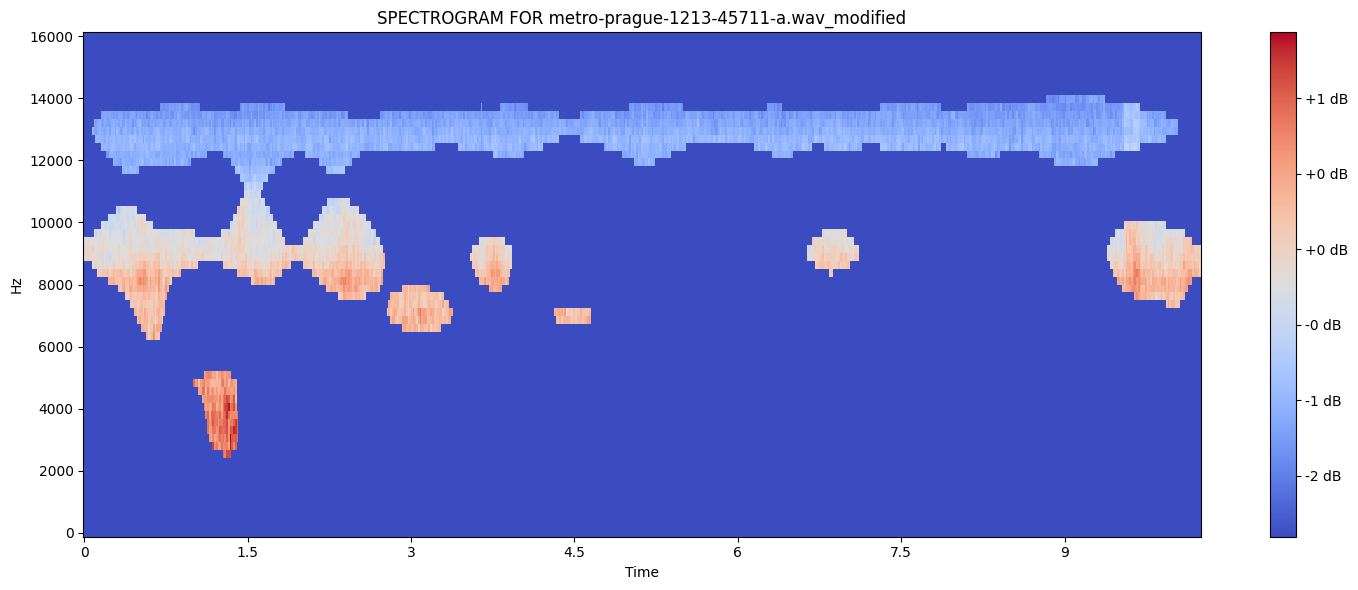

In [49]:
display_log_mel_spectrogram(audioname+"_modified", "cam_spectrograms", modified_spectrogram, 'test')


In [56]:
# Using mask with original audio

# Need a mel spectrogram instead of log-mel
modified_spectrogram_to_mel = librosa.db_to_power(modified_spectrogram)

# Convert mel spectrogram to audio using Griffin-Lim algorithm
y_inv = librosa.feature.inverse.mel_to_audio(modified_spectrogram_to_mel, sr=32000, n_fft=1024, hop_length=500, n_iter=3000)

In [55]:
Audio(data=y_inv, rate=32000)

In [58]:
log_mel_spectrogram.shape, grayscale_cam.shape

((64, 641), (64, 641))

In [65]:
normalized_cam = (grayscale_cam - np.min(grayscale_cam)) / (np.max(grayscale_cam) - np.min(grayscale_cam))

product_spec = (log_mel_spectrogram * normalized_cam)
product_spec.shape

(64, 641)

metro-prague-1213-45711-a.wav_modified Log-Mel Feature Shape :  (64, 641)


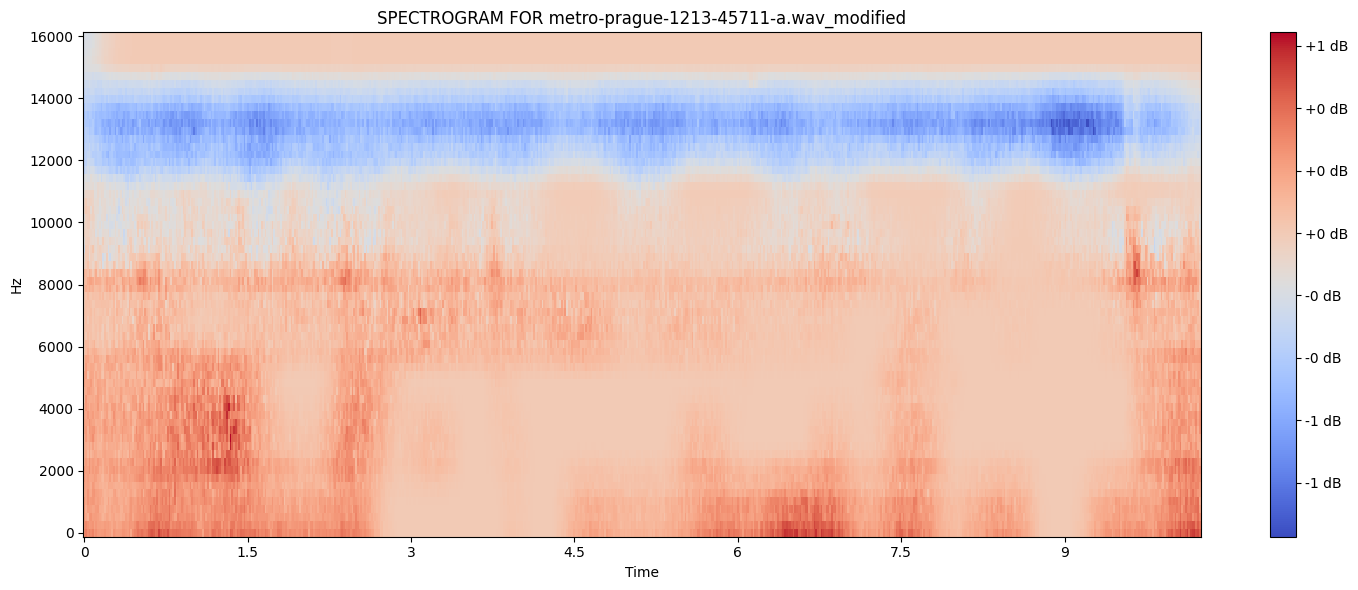

In [66]:
display_log_mel_spectrogram(audioname+"_modified", "cam_spectrograms", product_spec, 'product')

In [69]:
# Need a mel spectrogram instead of log-mel
modified_spectrogram_to_mel = librosa.db_to_power(product_spec)

# Convert mel spectrogram to audio using Griffin-Lim algorithm
y_inv = librosa.feature.inverse.mel_to_audio(modified_spectrogram_to_mel, sr=32000, n_fft=1024, hop_length=500, n_iter=64)

In [70]:
Audio(data=y_inv, rate=32000)